# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls drive/MyDrive/3D_reconstruction/

10IHSW05_10IHSW5A.mp4  2380579a-c4b7-4feb-a48b-6d6c3f6bd615.mpg  40LP265.mp4
10SOM282.mp4	       3225.mp4					 Cropped
200S0264.mp4	       3225..mp4				 H_62436043.mpg


# Installations

In [ ]:
! pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

# Imports

In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from base64 import b64encode
from IPython.display import HTML
from datetime import timedelta
from tqdm import tqdm
# import pytesseract
from google.colab.patches import cv2_imshow

In [ ]:
import easyocr  # like tesseract, but uses GPU

In [ ]:
import torch
import torch.nn.functional as F

# EDA

In [ ]:
video_path = '/content/drive/MyDrive/3D_reconstruction/2380579a-c4b7-4feb-a48b-6d6c3f6bd615.mpg'

## Brightness analysis

Video Properties:
Resolution: 1920x1080
Frame Rate: 30.00 fps
Total Frames: 25513
Duration: 850.43 seconds (0:14:10)
File Size: 1201.1 MB


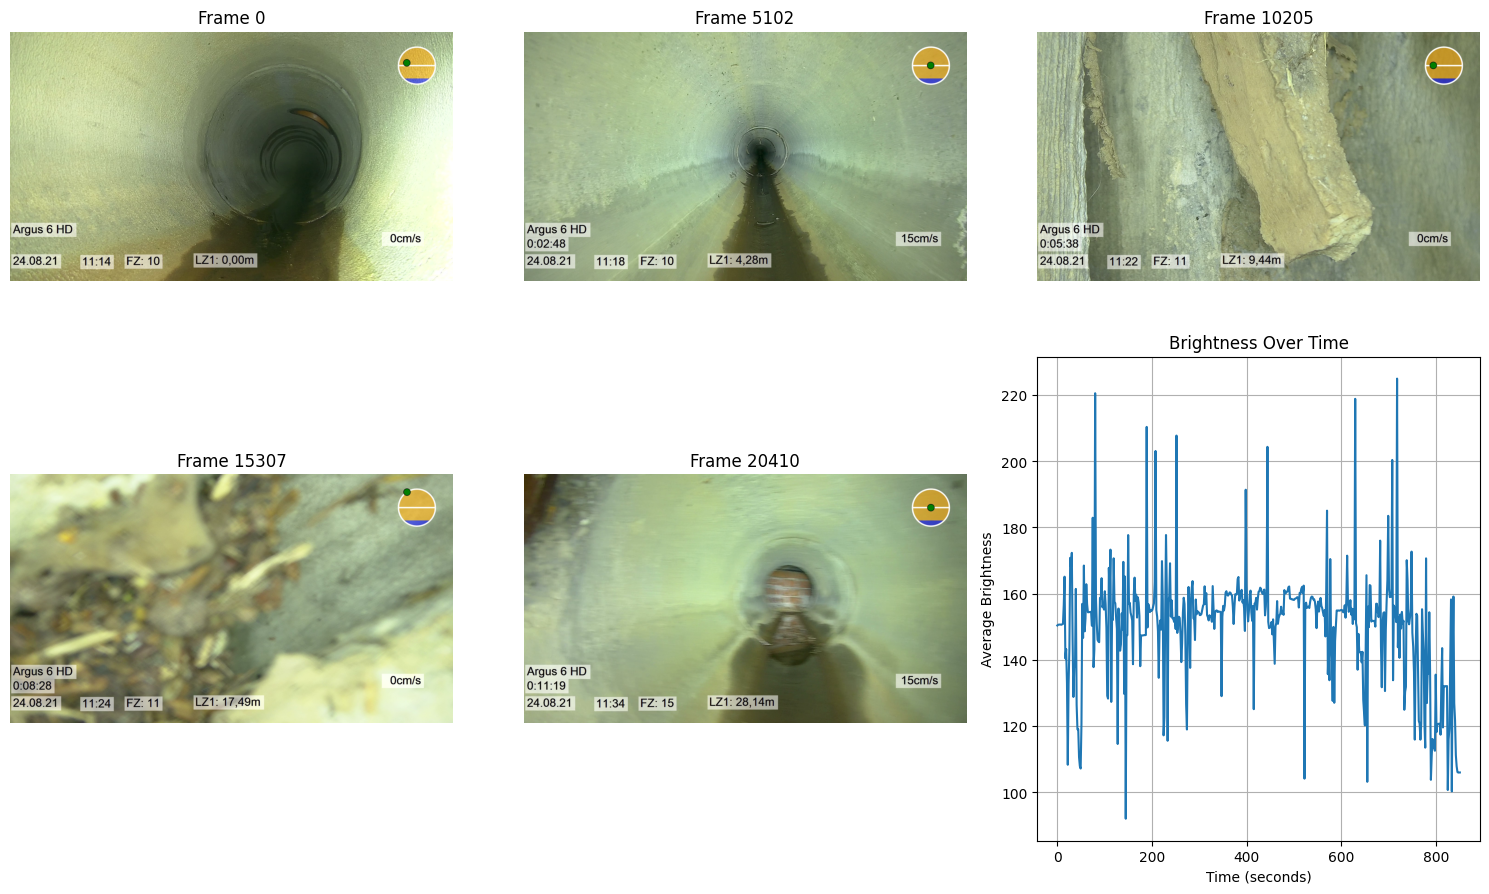

No audio streams detected in the video


In [ ]:
if not os.path.isfile(video_path):
    print(f"Error: File '{video_path}' does not exist")
else:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file '{video_path}'")
    else:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        resolution = f"{frame_width}x{frame_height}"
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = round(frame_count / fps, 2)

        file_size_mb = round(os.path.getsize(video_path) / (1024 * 1024), 2)  # file size in MB

        # basic video information
        print(f"Video Properties:")
        print(f"Resolution: {resolution}")
        print(f"Frame Rate: {fps:.2f} fps")
        print(f"Total Frames: {frame_count}")
        print(f"Duration: {duration:.2f} seconds ({str(timedelta(seconds=int(duration)))})")
        print(f"File Size: {file_size_mb} MB")

        frames = []
        frame_indices = []

        # extract 5 evenly distributed frames
        sample_count = 5
        if frame_count >= sample_count:
            for i in range(sample_count):
                frame_idx = int(i * frame_count / sample_count)
                frame_indices.append(frame_idx)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # reset to beginning of video for further analysis

        # motion and brightness analysis
        frame_brightness = []
        frame_diff = []
        prev_frame = None
        frame_samples = min(frame_count, 500)  # limit to 500 frames for performance
        sampling_interval = max(1, frame_count // frame_samples)

        for i in range(0, frame_count, sampling_interval):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break

            # brightness calculation
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)
            frame_brightness.append(brightness)

            # calculate frame difference (for motion estimation)
            if prev_frame is not None:
                diff = cv2.absdiff(gray, prev_gray)
                motion = np.mean(diff)
                frame_diff.append(motion)

            prev_gray = gray.copy()

        cap.release()

        # visualisations
        plt.figure(figsize=(15, 10))

        # sample frames
        for i, frame in enumerate(frames):
            plt.subplot(2, 3, i+1)
            plt.imshow(frame)
            plt.title(f"Frame {frame_indices[i]}")
            plt.axis('off')

        # brightness over time plot
        plt.subplot(2, 3, 6)
        plt.plot(np.linspace(0, duration, len(frame_brightness)), frame_brightness)
        plt.title('Brightness Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Average Brightness')
        plt.grid(True)

        # motion over time
        if frame_diff:
            plt.subplot(2, 3, 6)
            plt.plot(np.linspace(0, duration, len(frame_diff)), frame_diff)
            plt.title('Motion Estimation Over Time')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Motion (Average Pixel Difference)')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # audio check
        cap = cv2.VideoCapture(video_path)
        audio_streams = cap.get(cv2.CAP_PROP_AUDIO_STREAM)
        if audio_streams > 0:
            print(f"Video contains {int(audio_streams)} audio stream(s)")
        else:
            print("No audio streams detected in the video")
        cap.release()

Let's inspect the frames with brightness  $>200$:

High brightness detected at frame 2390, time: 79.67s, brightness: 206.46
High brightness detected at frame 2395, time: 79.83s, brightness: 212.60
High brightness detected at frame 2400, time: 80.00s, brightness: 216.33
High brightness detected at frame 2405, time: 80.17s, brightness: 213.04
High brightness detected at frame 2410, time: 80.33s, brightness: 201.78
High brightness detected at frame 5665, time: 188.83s, brightness: 211.59
High brightness detected at frame 6200, time: 206.67s, brightness: 200.55
High brightness detected at frame 6205, time: 206.83s, brightness: 204.69
High brightness detected at frame 6210, time: 207.00s, brightness: 208.46
High brightness detected at frame 6215, time: 207.17s, brightness: 208.29


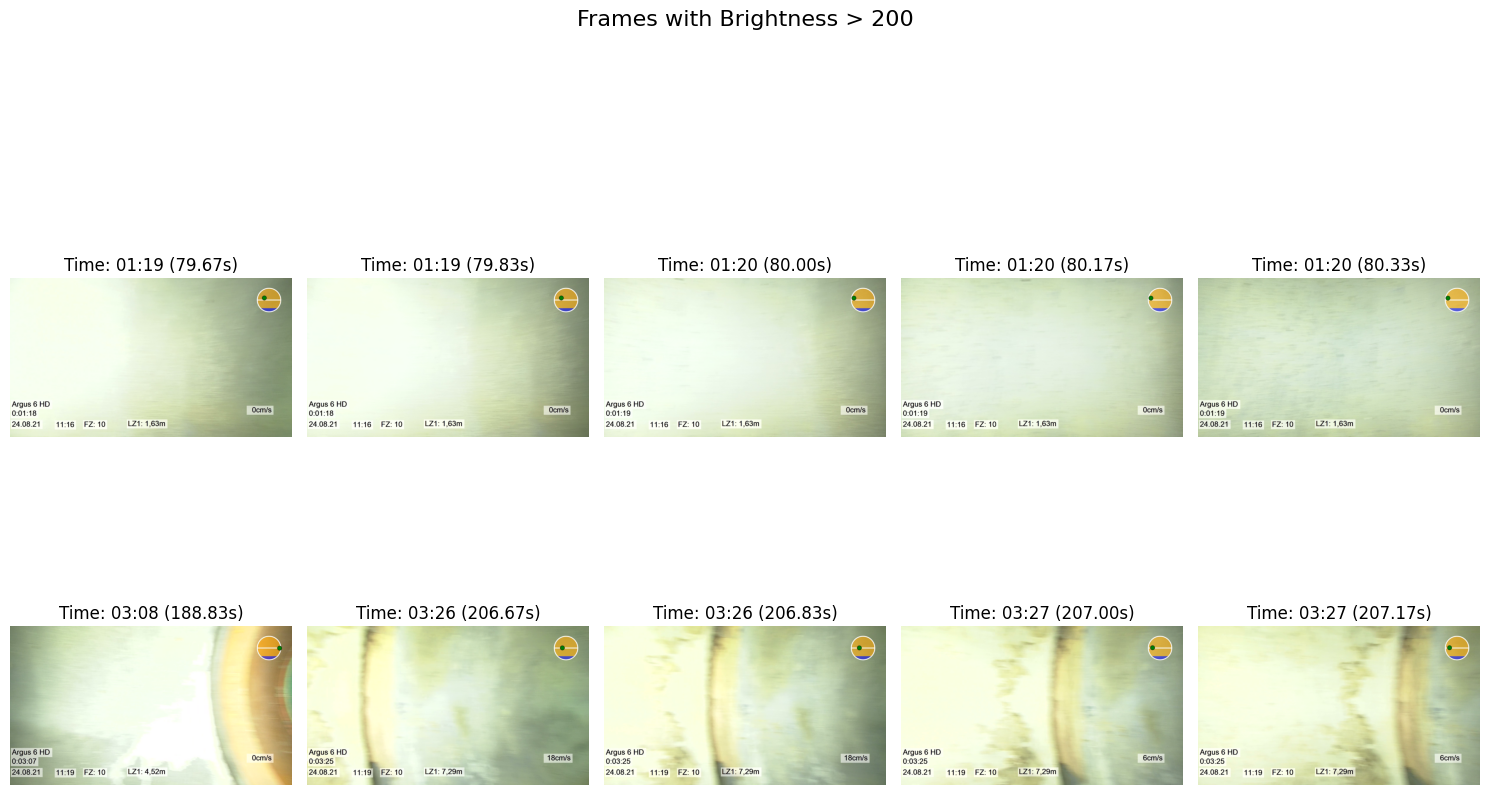

Found 10 frames with brightness > 200


In [ ]:
if os.path.isfile(video_path):
    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps

        high_brightness_frames = []
        high_brightness_timestamps = []

        frame_idx = 0
        sampling_interval = 5  # check every 5 frames to speed up processing

        while True:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            brightness = np.mean(gray)

            if brightness > 200:
                timestamp = frame_idx / fps
                high_brightness_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                high_brightness_timestamps.append(timestamp)
                print(f"High brightness detected at frame {frame_idx}, time: {timestamp:.2f}s, brightness: {brightness:.2f}")

            frame_idx += sampling_interval

            if frame_idx >= frame_count or len(high_brightness_frames) >= 10:
                break

        cap.release()

        if high_brightness_frames:
            plt.figure(figsize=(15, 10))
            for i, (frame, timestamp) in enumerate(zip(high_brightness_frames, high_brightness_timestamps)):
                plt.subplot(2, 5, i+1) if len(high_brightness_frames) <= 10 else plt.subplot(3, 4, i+1)
                plt.imshow(frame)
                minutes, seconds = divmod(int(timestamp), 60)
                plt.title(f"Time: {minutes:02d}:{seconds:02d} ({timestamp:.2f}s)")
                plt.axis('off')

            plt.suptitle("Frames with Brightness > 200", fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()

            print(f"Found {len(high_brightness_frames)} frames with brightness > 200")
        else:
            print("No frames with brightness > 200 were found")
    else:
        print(f"Error: Could not open video file '{video_path}'")
else:
    print(f"Error: File '{video_path}' does not exist")

**QUESTION**: *is it true for all the videos available?*

## DataFrame with some metadata

In [ ]:
reader = easyocr.Reader(['en'], gpu=True)

In [ ]:
def extract_text_with_fallback(frame, roi):
    """
    Extract text with multiple preprocessing attempts for better results
    """
    x, y, w, h = roi
    roi_img = frame[y:y+h, x:x+w]

    # try original image first
    results = reader.readtext(roi_img)
    text = ' '.join([result[1] for result in results])

    # if no text found, try grayscale
    if not text.strip():
        gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
        results = reader.readtext(gray)
        text = ' '.join([result[1] for result in results])

    # if still no text, try binary threshold
    if not text.strip():
        _, thresh = cv2.threshold(cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY),
                                150, 255, cv2.THRESH_BINARY_INV)
        results = reader.readtext(thresh)
        text = ' '.join([result[1] for result in results])

    return text.strip()

In [ ]:
def robust_parse_timestamp(text):
    match = re.search(r'(\d+:\d+:\d+)', text)
    if match:
        return match.group(1)

    # more flexible pattern if exact match fails
    match = re.search(r'(\d+)[:.,-]?(\d+)[:.,-]?(\d+)', text)
    if match:
        return f"{match.group(1)}:{match.group(2)}:{match.group(3)}"

    # if all else fails, look for any three numbers
    digits = re.findall(r'\d+', text)
    if len(digits) >= 3:
        return f"{digits[0]}:{digits[1]}:{digits[2]}"

    return None

In [ ]:
def robust_parse_fz(text):
    match = re.search(r'FZ:\s*(\d+)', text)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            pass

    # more flexible pattern
    match = re.search(r'[Ff][^0-9]*[Zz][^0-9]*(\d+)', text)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            pass

    # find any number after FZ
    match = re.search(r'FZ.*?(\d+)', text, re.IGNORECASE)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            pass

    # last resort: just take the first number
    digits = re.findall(r'\d+', text)
    if digits:
        try:
            return int(digits[0])
        except ValueError:
            pass

    return None

In [ ]:
def robust_parse_lz1(text):
    match = re.search(r'LZ1:\s*(\d+[,\.]\d+)m', text)
    if match:
        try:
            return float(match.group(1).replace(',', '.'))
        except ValueError:
            pass

    # more flexible pattern
    match = re.search(r'LZ1.*?(\d+[,\.]\d+)', text)
    if match:
        try:
            return float(match.group(1).replace(',', '.'))
        except ValueError:
            pass

    # last resort: just find any decimal number
    match = re.search(r'(\d+[,\.]\d+)', text)
    if match:
        try:
            return float(match.group(1).replace(',', '.'))
        except ValueError:
            pass

    return None

In [ ]:
def robust_parse_velocity(text):
    match = re.search(r'(\d+)cm/s', text)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            pass

    # more flexible pattern
    match = re.search(r'(\d+)\s*[cm]+', text)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            pass

    # last resort: just take the first number
    digits = re.findall(r'\d+', text)
    if digits:
        try:
            return int(digits[0])
        except ValueError:
            pass

    return 0

In [ ]:
def extract_metadata_from_video(video_path, frame_count, sampling_rate=1000):
    """
    Extract metadata with robust OCR and parsing

    Parameters:
    -----------
    video_path : str
        Path to the video file to be processed.
    frame_count : int
        Total number of frames in the video. This should be determined before calling this function.
    sampling_rate : int, optional
        Interval between processed frames. Default is 1000, meaning every 1000th frame will be processed.
        Lower values will result in more detailed data but longer processing times.

    Returns:
    --------
    pandas.DataFrame or None
        DataFrame containing the extracted metadata with the following columns:
        - 'frame_num': Frame number in the original video
        - 'timestamp': Parsed timestamp value from the video frame
        - 'FZ': Parsed FZ (Focus Zone) value
        - 'LZ1': Parsed LZ1 (Locator Zone 1) value in meters
        - 'velocity': Parsed velocity value in cm/s
        Returns None if the video file could not be opened.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return None

    data = {
        'frame_num': [],
        'timestamp': [],
        'FZ': [],
        'LZ1': [],
        'velocity': []
    }

    # TODO: change ROIs after uploading new video
    roi_timestamp = (7, 890, 185, 65)
    roi_fz = (490, 966, 175, 60)
    roi_lz1 = (790, 962, 290, 60)
    roi_velocity = (1610, 865, 185, 65)

    print("Processing frames...")
    for frame_idx in tqdm(range(0, frame_count, sampling_rate)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            print(f"Warning: Could not read frame {frame_idx}")
            break

        # extract text from ROIs
        timestamp_text = extract_text_with_fallback(frame, roi_timestamp)
        fz_text = extract_text_with_fallback(frame, roi_fz)
        lz1_text = extract_text_with_fallback(frame, roi_lz1)
        velocity_text = extract_text_with_fallback(frame, roi_velocity)

        if frame_idx % (sampling_rate * 5) == 0:
            print(f"\nFrame {frame_idx} raw text:")
            print(f"Timestamp: '{timestamp_text}'")
            print(f"FZ: '{fz_text}'")
            print(f"LZ1: '{lz1_text}'")
            print(f"Velocity: '{velocity_text}'")

        timestamp = robust_parse_timestamp(timestamp_text)
        fz = robust_parse_fz(fz_text)
        lz1 = robust_parse_lz1(lz1_text)
        velocity = robust_parse_velocity(velocity_text)

        if frame_idx % (sampling_rate * 5) == 0:
            print(f"Parsed values:")
            print(f"Timestamp: {timestamp}")
            print(f"FZ: {fz}")
            print(f"LZ1: {lz1}")
            print(f"Velocity: {velocity}")

        data['frame_num'].append(frame_idx)
        data['timestamp'].append(timestamp)
        data['FZ'].append(fz)
        data['LZ1'].append(lz1)
        data['velocity'].append(velocity)

        # free GPU memory periodically
        if frame_idx % (sampling_rate * 10) == 0:
            torch.cuda.empty_cache()

    # create DataFrame
    df = pd.DataFrame(data)

    # forward fill missing values instead of dropping rows
    df['FZ'] = df['FZ'].ffill()
    df['LZ1'] = df['LZ1'].ffill()
    df['velocity'] = df['velocity'].fillna(0)

    cap.release()

    print(f"Processed {len(df)} frames. DataFrame summary:")
    print(df.head())
    print(f"Missing values: {df.isnull().sum()}")

    return df

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
sampling_rate = 1  # extract all the frames available

In [ ]:
df = extract_metadata_from_video(video_path, frame_count, sampling_rate)
df.to_csv('sewer_video_metadata.csv', index=False)
print("Peremoha!")

Processing frames...


  0%|          | 2/25513 [00:00<1:13:40,  5.77it/s]


Frame 0 raw text:
Timestamp: ''
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: None
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 6/25513 [00:01<1:48:03,  3.93it/s]


Frame 5 raw text:
Timestamp: 'O.00.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 12/25513 [00:02<1:23:13,  5.11it/s]


Frame 10 raw text:
Timestamp: 'O.00.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 16/25513 [00:03<1:32:00,  4.62it/s]


Frame 15 raw text:
Timestamp: 'O.00.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 21/25513 [00:04<1:37:41,  4.35it/s]


Frame 20 raw text:
Timestamp: 'O.00.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 26/25513 [00:05<1:37:36,  4.35it/s]


Frame 25 raw text:
Timestamp: 'O.00.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 31/25513 [00:06<1:39:37,  4.26it/s]


Frame 30 raw text:
Timestamp: 'O.O0.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 36/25513 [00:08<1:38:57,  4.29it/s]


Frame 35 raw text:
Timestamp: 'O.O0.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 41/25513 [00:09<1:41:31,  4.18it/s]


Frame 40 raw text:
Timestamp: 'O.O0.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:0
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 46/25513 [00:10<1:51:39,  3.80it/s]


Frame 45 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 51/25513 [00:12<2:31:34,  2.80it/s]


Frame 50 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 56/25513 [00:14<2:11:25,  3.23it/s]


Frame 55 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 61/25513 [00:15<1:45:05,  4.04it/s]


Frame 60 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 66/25513 [00:16<2:12:18,  3.21it/s]


Frame 65 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 71/25513 [00:17<1:44:05,  4.07it/s]


Frame 70 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: None
Velocity: 0


  0%|          | 76/25513 [00:19<1:42:22,  4.14it/s]


Frame 75 raw text:
Timestamp: '0.00.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:01
FZ: 10
LZ1: None
Velocity: 0


  0%|          | 81/25513 [00:20<1:38:38,  4.30it/s]


Frame 80 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: None
Velocity: 0


  0%|          | 86/25513 [00:21<1:38:10,  4.32it/s]


Frame 85 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 91/25513 [00:22<1:41:18,  4.18it/s]


Frame 90 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 96/25513 [00:23<1:50:26,  3.84it/s]


Frame 95 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 101/25513 [00:25<2:26:25,  2.89it/s]


Frame 100 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 106/25513 [00:27<2:14:08,  3.16it/s]


Frame 105 raw text:
Timestamp: '0.00.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:02
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 111/25513 [00:28<1:42:56,  4.11it/s]


Frame 110 raw text:
Timestamp: '0.00.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:03
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 116/25513 [00:29<1:37:26,  4.34it/s]


Frame 115 raw text:
Timestamp: '0.00.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:03
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 121/25513 [00:30<1:39:27,  4.26it/s]


Frame 120 raw text:
Timestamp: '0.00.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:03
FZ: 10
LZ1: 0.0
Velocity: 0


  0%|          | 126/25513 [00:32<1:36:14,  4.40it/s]


Frame 125 raw text:
Timestamp: '0.00.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:03
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 131/25513 [00:33<1:39:55,  4.23it/s]


Frame 130 raw text:
Timestamp: '0.00.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:03
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 136/25513 [00:34<1:41:50,  4.15it/s]


Frame 135 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 141/25513 [00:35<1:38:33,  4.29it/s]


Frame 140 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 146/25513 [00:36<1:37:49,  4.32it/s]


Frame 145 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 151/25513 [00:38<2:20:49,  3.00it/s]


Frame 150 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 156/25513 [00:40<2:35:17,  2.72it/s]


Frame 155 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 161/25513 [00:41<1:49:04,  3.87it/s]


Frame 160 raw text:
Timestamp: '0.00.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:04
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 166/25513 [00:42<1:46:46,  3.96it/s]


Frame 165 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 171/25513 [00:43<1:39:05,  4.26it/s]


Frame 170 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 176/25513 [00:44<1:36:59,  4.35it/s]


Frame 175 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 181/25513 [00:46<1:40:19,  4.21it/s]


Frame 180 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 186/25513 [00:47<1:37:56,  4.31it/s]


Frame 185 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 191/25513 [00:48<1:37:43,  4.32it/s]


Frame 190 raw text:
Timestamp: '0.00.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:05
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 196/25513 [00:49<1:39:32,  4.24it/s]


Frame 195 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 201/25513 [00:51<2:00:13,  3.51it/s]


Frame 200 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 206/25513 [00:52<2:31:50,  2.78it/s]


Frame 205 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 211/25513 [00:54<2:06:11,  3.34it/s]


Frame 210 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 216/25513 [00:55<1:41:06,  4.17it/s]


Frame 215 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 221/25513 [00:56<1:38:01,  4.30it/s]


Frame 220 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 226/25513 [00:57<1:39:42,  4.23it/s]


Frame 225 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 231/25513 [00:59<1:36:23,  4.37it/s]


Frame 230 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 236/25513 [01:00<1:35:40,  4.40it/s]


Frame 235 raw text:
Timestamp: '0.00.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:06
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 241/25513 [01:01<1:40:59,  4.17it/s]


Frame 240 raw text:
Timestamp: '0.00.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:07
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 246/25513 [01:02<1:38:43,  4.27it/s]


Frame 245 raw text:
Timestamp: '0.00.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:07
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 251/25513 [01:03<1:40:24,  4.19it/s]


Frame 250 raw text:
Timestamp: '0.00.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:07
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 256/25513 [01:05<2:25:33,  2.89it/s]


Frame 255 raw text:
Timestamp: '0.00.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:07
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 261/25513 [01:07<2:28:11,  2.84it/s]


Frame 260 raw text:
Timestamp: '0.00.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:07
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 266/25513 [01:08<1:45:39,  3.98it/s]


Frame 265 raw text:
Timestamp: '0.00.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:08
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 271/25513 [01:09<1:47:12,  3.92it/s]


Frame 270 raw text:
Timestamp: '0.00.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:08
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 276/25513 [01:10<1:40:19,  4.19it/s]


Frame 275 raw text:
Timestamp: '0.00.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:08
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 281/25513 [01:12<1:37:45,  4.30it/s]


Frame 280 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 286/25513 [01:13<1:40:29,  4.18it/s]


Frame 285 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 291/25513 [01:14<1:37:15,  4.32it/s]


Frame 290 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 296/25513 [01:15<1:36:15,  4.37it/s]


Frame 295 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 301/25513 [01:16<1:38:26,  4.27it/s]


Frame 300 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 306/25513 [01:18<2:13:40,  3.14it/s]


Frame 305 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 311/25513 [01:20<2:31:35,  2.77it/s]


Frame 310 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|          | 316/25513 [01:21<1:57:37,  3.57it/s]


Frame 315 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 321/25513 [01:22<1:41:38,  4.13it/s]


Frame 320 raw text:
Timestamp: '0.00.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:09
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 326/25513 [01:23<1:38:40,  4.25it/s]


Frame 325 raw text:
Timestamp: 'O.00:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:1:0
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 331/25513 [01:25<1:39:17,  4.23it/s]


Frame 330 raw text:
Timestamp: '0.00:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:10
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 336/25513 [01:26<1:36:20,  4.36it/s]


Frame 335 raw text:
Timestamp: 'O.00:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:1:0
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 341/25513 [01:27<1:37:32,  4.30it/s]


Frame 340 raw text:
Timestamp: 'O.00:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 00:1:0
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 346/25513 [01:28<1:40:20,  4.18it/s]


Frame 345 raw text:
Timestamp: '0.00:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:10
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 351/25513 [01:29<1:41:09,  4.15it/s]


Frame 350 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 356/25513 [01:31<2:04:52,  3.36it/s]


Frame 355 raw text:
Timestamp: '0.00:11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 361/25513 [01:33<2:35:53,  2.69it/s]


Frame 360 raw text:
Timestamp: '0.00:11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 366/25513 [01:34<2:03:04,  3.41it/s]


Frame 365 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 371/25513 [01:35<1:40:20,  4.18it/s]


Frame 370 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 376/25513 [01:36<1:38:48,  4.24it/s]


Frame 375 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  1%|▏         | 381/25513 [01:38<1:39:25,  4.21it/s]


Frame 380 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 386/25513 [01:39<1:36:46,  4.33it/s]


Frame 385 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 391/25513 [01:40<1:41:16,  4.13it/s]


Frame 390 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 396/25513 [01:41<1:36:17,  4.35it/s]


Frame 395 raw text:
Timestamp: '0.00.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:11
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 401/25513 [01:42<1:37:37,  4.29it/s]


Frame 400 raw text:
Timestamp: '0.00:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:12
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 406/25513 [01:44<1:38:53,  4.23it/s]


Frame 405 raw text:
Timestamp: '0.00:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:12
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 411/25513 [01:45<2:23:32,  2.91it/s]


Frame 410 raw text:
Timestamp: '0.00:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:12
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 416/25513 [01:47<2:22:38,  2.93it/s]


Frame 415 raw text:
Timestamp: '0.00:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:12
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 421/25513 [01:48<1:47:52,  3.88it/s]


Frame 420 raw text:
Timestamp: '0.00:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:12
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 426/25513 [01:50<2:14:45,  3.10it/s]


Frame 425 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 431/25513 [01:51<1:44:08,  4.01it/s]


Frame 430 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 436/25513 [01:52<1:42:23,  4.08it/s]


Frame 435 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: None
Velocity: 0


  2%|▏         | 441/25513 [01:54<2:09:45,  3.22it/s]


Frame 440 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,O0m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: None
Velocity: 0


  2%|▏         | 446/25513 [01:55<1:43:51,  4.02it/s]


Frame 445 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 451/25513 [01:57<2:05:27,  3.33it/s]


Frame 450 raw text:
Timestamp: '0.00:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,O0m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:13
FZ: 10
LZ1: None
Velocity: 0


  2%|▏         | 456/25513 [01:59<2:59:50,  2.32it/s]


Frame 455 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 461/25513 [02:01<2:19:53,  2.98it/s]


Frame 460 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 466/25513 [02:02<1:44:58,  3.98it/s]


Frame 465 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 471/25513 [02:03<1:39:39,  4.19it/s]


Frame 470 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 476/25513 [02:04<1:36:35,  4.32it/s]


Frame 475 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 481/25513 [02:06<1:36:51,  4.31it/s]


Frame 480 raw text:
Timestamp: '0.00:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:14
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 486/25513 [02:07<2:11:09,  3.18it/s]


Frame 485 raw text:
Timestamp: '0.00.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:15
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 491/25513 [02:09<2:36:31,  2.66it/s]


Frame 490 raw text:
Timestamp: '0.00.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:15
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 496/25513 [02:11<2:03:03,  3.39it/s]


Frame 495 raw text:
Timestamp: '0.00:15'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:15
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 501/25513 [02:13<2:40:46,  2.59it/s]


Frame 500 raw text:
Timestamp: '0.00:15'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:15
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 506/25513 [02:14<2:18:25,  3.01it/s]


Frame 505 raw text:
Timestamp: '0.00:15'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:15
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 511/25513 [02:16<1:47:39,  3.87it/s]


Frame 510 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 516/25513 [02:17<1:41:49,  4.09it/s]


Frame 515 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 521/25513 [02:18<1:43:20,  4.03it/s]


Frame 520 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 526/25513 [02:19<1:42:51,  4.05it/s]


Frame 525 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 531/25513 [02:20<1:42:40,  4.06it/s]


Frame 530 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 536/25513 [02:22<1:40:35,  4.14it/s]


Frame 535 raw text:
Timestamp: '0.00:16'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:16
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 541/25513 [02:23<1:39:16,  4.19it/s]


Frame 540 raw text:
Timestamp: '0.00:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 546/25513 [02:24<1:45:43,  3.94it/s]


Frame 545 raw text:
Timestamp: '0.00:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 551/25513 [02:26<2:35:41,  2.67it/s]


Frame 550 raw text:
Timestamp: '0.00:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 556/25513 [02:28<2:15:05,  3.08it/s]


Frame 555 raw text:
Timestamp: '0.00:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 561/25513 [02:29<1:48:31,  3.83it/s]


Frame 560 raw text:
Timestamp: '0.00.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 566/25513 [02:30<1:43:53,  4.00it/s]


Frame 565 raw text:
Timestamp: '0.00:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:17
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 571/25513 [02:32<1:44:18,  3.99it/s]


Frame 570 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 576/25513 [02:33<1:43:59,  4.00it/s]


Frame 575 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: None
Velocity: 0


  2%|▏         | 581/25513 [02:34<1:44:38,  3.97it/s]


Frame 580 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 586/25513 [02:35<1:44:23,  3.98it/s]


Frame 585 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 591/25513 [02:37<1:45:04,  3.95it/s]


Frame 590 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 596/25513 [02:38<2:19:18,  2.98it/s]


Frame 595 raw text:
Timestamp: '0.00:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:18
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 601/25513 [02:40<2:49:47,  2.45it/s]


Frame 600 raw text:
Timestamp: '0.00:19'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:19
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 606/25513 [02:42<1:59:47,  3.47it/s]


Frame 605 raw text:
Timestamp: '0.00:19'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:19
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 611/25513 [02:43<1:44:01,  3.99it/s]


Frame 610 raw text:
Timestamp: '0.00:19'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:19
FZ: 10
LZ1: None
Velocity: 0


  2%|▏         | 616/25513 [02:44<1:42:48,  4.04it/s]


Frame 615 raw text:
Timestamp: '0.00:19'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:19
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 621/25513 [02:45<1:42:03,  4.06it/s]


Frame 620 raw text:
Timestamp: '0.00:19'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:19
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 626/25513 [02:47<1:42:55,  4.03it/s]


Frame 625 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 631/25513 [02:48<1:42:41,  4.04it/s]


Frame 630 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  2%|▏         | 636/25513 [02:49<1:40:25,  4.13it/s]


Frame 635 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 641/25513 [02:50<1:41:18,  4.09it/s]


Frame 640 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 646/25513 [02:52<2:27:53,  2.80it/s]


Frame 645 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 651/25513 [02:54<2:43:49,  2.53it/s]


Frame 650 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 656/25513 [02:55<1:53:28,  3.65it/s]


Frame 655 raw text:
Timestamp: '0.00.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:20
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 661/25513 [02:57<1:42:20,  4.05it/s]


Frame 660 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 666/25513 [02:58<1:39:31,  4.16it/s]


Frame 665 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 671/25513 [02:59<1:40:24,  4.12it/s]


Frame 670 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 676/25513 [03:00<1:38:59,  4.18it/s]


Frame 675 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 681/25513 [03:01<1:40:28,  4.12it/s]


Frame 680 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 686/25513 [03:03<1:37:48,  4.23it/s]


Frame 685 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 691/25513 [03:04<1:38:20,  4.21it/s]


Frame 690 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 696/25513 [03:05<2:08:19,  3.22it/s]


Frame 695 raw text:
Timestamp: '0.00.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:21
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 701/25513 [03:07<2:27:47,  2.80it/s]


Frame 700 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 706/25513 [03:08<1:54:01,  3.63it/s]


Frame 705 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 711/25513 [03:10<1:46:37,  3.88it/s]


Frame 710 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 716/25513 [03:11<1:44:27,  3.96it/s]


Frame 715 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 721/25513 [03:12<1:42:16,  4.04it/s]


Frame 720 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 726/25513 [03:13<1:37:30,  4.24it/s]


Frame 725 raw text:
Timestamp: '0.00.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:22
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 731/25513 [03:15<1:34:01,  4.39it/s]


Frame 730 raw text:
Timestamp: '0.00.23'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:23
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 736/25513 [03:16<1:34:31,  4.37it/s]


Frame 735 raw text:
Timestamp: '0.00.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:23
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 741/25513 [03:17<1:38:06,  4.21it/s]


Frame 740 raw text:
Timestamp: '0.00.23'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:23
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 746/25513 [03:18<2:10:19,  3.17it/s]


Frame 745 raw text:
Timestamp: '0.00.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:23
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 751/25513 [03:21<2:44:18,  2.51it/s]


Frame 750 raw text:
Timestamp: '0.00.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:23
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 756/25513 [03:22<2:00:27,  3.43it/s]


Frame 755 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 761/25513 [03:23<1:42:10,  4.04it/s]


Frame 760 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 766/25513 [03:24<1:38:44,  4.18it/s]


Frame 765 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 771/25513 [03:26<1:36:24,  4.28it/s]


Frame 770 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 776/25513 [03:27<1:36:35,  4.27it/s]


Frame 775 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 781/25513 [03:28<1:37:32,  4.23it/s]


Frame 780 raw text:
Timestamp: '0.00.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:24
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 786/25513 [03:29<1:39:00,  4.16it/s]


Frame 785 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 791/25513 [03:30<1:38:42,  4.17it/s]


Frame 790 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 796/25513 [03:32<2:16:59,  3.01it/s]


Frame 795 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 801/25513 [03:34<2:39:18,  2.59it/s]


Frame 800 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 806/25513 [03:35<1:56:41,  3.53it/s]


Frame 805 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 811/25513 [03:36<1:42:24,  4.02it/s]


Frame 810 raw text:
Timestamp: '0.00.25'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:25
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 816/25513 [03:38<1:40:58,  4.08it/s]


Frame 815 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 821/25513 [03:39<1:41:50,  4.04it/s]


Frame 820 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 826/25513 [03:40<1:45:55,  3.88it/s]


Frame 825 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 831/25513 [03:41<1:39:48,  4.12it/s]


Frame 830 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 836/25513 [03:43<1:39:21,  4.14it/s]


Frame 835 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 841/25513 [03:44<1:39:15,  4.14it/s]


Frame 840 raw text:
Timestamp: '0.00.26'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:26
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 846/25513 [03:46<2:24:14,  2.85it/s]


Frame 845 raw text:
Timestamp: '0.00.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:27
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 851/25513 [03:48<2:37:39,  2.61it/s]


Frame 850 raw text:
Timestamp: '0.00.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:27
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 856/25513 [03:49<1:52:55,  3.64it/s]


Frame 855 raw text:
Timestamp: '0.00.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:27
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 861/25513 [03:50<1:43:05,  3.99it/s]


Frame 860 raw text:
Timestamp: '0.00.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:27
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 866/25513 [03:51<1:38:48,  4.16it/s]


Frame 865 raw text:
Timestamp: '0.00.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:27
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 871/25513 [03:53<1:41:49,  4.03it/s]


Frame 870 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 876/25513 [03:54<1:42:01,  4.02it/s]


Frame 875 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: 0.0
Velocity: 0


  3%|▎         | 881/25513 [03:55<1:40:17,  4.09it/s]


Frame 880 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 886/25513 [03:56<1:40:18,  4.09it/s]


Frame 885 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: None
Velocity: 0


  3%|▎         | 891/25513 [03:57<1:39:28,  4.13it/s]


Frame 890 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 896/25513 [03:59<2:16:21,  3.01it/s]


Frame 895 raw text:
Timestamp: '0.00.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:28
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 901/25513 [04:01<2:33:29,  2.67it/s]


Frame 900 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 906/25513 [04:02<1:48:54,  3.77it/s]


Frame 905 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 911/25513 [04:03<1:39:44,  4.11it/s]


Frame 910 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 916/25513 [04:05<1:42:56,  3.98it/s]


Frame 915 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 921/25513 [04:06<1:41:23,  4.04it/s]


Frame 920 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 926/25513 [04:07<1:41:19,  4.04it/s]


Frame 925 raw text:
Timestamp: '0.00.29'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:29
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 931/25513 [04:08<1:40:58,  4.06it/s]


Frame 930 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 936/25513 [04:10<1:40:10,  4.09it/s]


Frame 935 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 941/25513 [04:11<1:41:41,  4.03it/s]


Frame 940 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 946/25513 [04:13<2:27:36,  2.77it/s]


Frame 945 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 951/25513 [04:15<2:35:42,  2.63it/s]


Frame 950 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▎         | 956/25513 [04:16<1:48:36,  3.77it/s]


Frame 955 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 961/25513 [04:17<1:40:47,  4.06it/s]


Frame 960 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 966/25513 [04:18<1:39:21,  4.12it/s]


Frame 965 raw text:
Timestamp: '0.00.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:30
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 971/25513 [04:20<1:38:08,  4.17it/s]


Frame 970 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 976/25513 [04:21<1:42:10,  4.00it/s]


Frame 975 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 981/25513 [04:22<1:40:38,  4.06it/s]


Frame 980 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 986/25513 [04:23<1:36:43,  4.23it/s]


Frame 985 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 991/25513 [04:24<1:38:10,  4.16it/s]


Frame 990 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 996/25513 [04:26<2:27:09,  2.78it/s]


Frame 995 raw text:
Timestamp: '0.00.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:31
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1001/25513 [04:28<2:29:19,  2.74it/s]


Frame 1000 raw text:
Timestamp: '0.00.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:32
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1006/25513 [04:29<1:49:27,  3.73it/s]


Frame 1005 raw text:
Timestamp: '0.00.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:32
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1011/25513 [04:31<1:42:51,  3.97it/s]


Frame 1010 raw text:
Timestamp: '0.00.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:32
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1016/25513 [04:32<1:40:01,  4.08it/s]


Frame 1015 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1021/25513 [04:33<1:39:17,  4.11it/s]


Frame 1020 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1026/25513 [04:34<1:40:10,  4.07it/s]


Frame 1025 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1031/25513 [04:36<1:38:16,  4.15it/s]


Frame 1030 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: None
Velocity: 0


  4%|▍         | 1036/25513 [04:37<1:37:42,  4.17it/s]


Frame 1035 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1041/25513 [04:38<1:37:36,  4.18it/s]


Frame 1040 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1046/25513 [04:40<2:30:18,  2.71it/s]


Frame 1045 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1051/25513 [04:42<2:24:06,  2.83it/s]


Frame 1050 raw text:
Timestamp: '0.00.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:33
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1056/25513 [04:43<1:47:18,  3.80it/s]


Frame 1055 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1061/25513 [04:44<1:38:15,  4.15it/s]


Frame 1060 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1066/25513 [04:45<1:36:59,  4.20it/s]


Frame 1065 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1071/25513 [04:47<1:37:57,  4.16it/s]


Frame 1070 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1076/25513 [04:48<1:37:59,  4.16it/s]


Frame 1075 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1081/25513 [04:49<1:39:56,  4.07it/s]


Frame 1080 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1086/25513 [04:50<1:40:29,  4.05it/s]


Frame 1085 raw text:
Timestamp: '0.00.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:34
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1091/25513 [04:51<1:41:15,  4.02it/s]


Frame 1090 raw text:
Timestamp: '0.00.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:35
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1096/25513 [04:53<2:29:21,  2.72it/s]


Frame 1095 raw text:
Timestamp: '0.00.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:35
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1101/25513 [04:55<2:20:40,  2.89it/s]


Frame 1100 raw text:
Timestamp: '0.00.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:35
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1106/25513 [04:56<1:44:27,  3.89it/s]


Frame 1105 raw text:
Timestamp: '0.00.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:35
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1111/25513 [04:58<1:40:03,  4.06it/s]


Frame 1110 raw text:
Timestamp: '0.00.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:35
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1116/25513 [04:59<1:39:00,  4.11it/s]


Frame 1115 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1121/25513 [05:00<1:38:41,  4.12it/s]


Frame 1120 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1126/25513 [05:01<1:39:41,  4.08it/s]


Frame 1125 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1131/25513 [05:03<1:40:47,  4.03it/s]


Frame 1130 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1136/25513 [05:04<1:37:50,  4.15it/s]


Frame 1135 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1141/25513 [05:05<1:37:52,  4.15it/s]


Frame 1140 raw text:
Timestamp: '0.00.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:36
FZ: 10
LZ1: 0.0
Velocity: 0


  4%|▍         | 1146/25513 [05:07<2:21:26,  2.87it/s]


Frame 1145 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1151/25513 [05:09<2:12:24,  3.07it/s]


Frame 1150 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1156/25513 [05:10<1:43:05,  3.94it/s]


Frame 1155 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1161/25513 [05:11<1:39:58,  4.06it/s]


Frame 1160 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1166/25513 [05:12<1:33:21,  4.35it/s]


Frame 1165 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1171/25513 [05:13<1:31:19,  4.44it/s]


Frame 1170 raw text:
Timestamp: '0.00.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:37
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1176/25513 [05:14<1:29:47,  4.52it/s]


Frame 1175 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1181/25513 [05:15<1:28:11,  4.60it/s]


Frame 1180 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1186/25513 [05:16<1:29:19,  4.54it/s]


Frame 1185 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: None
Velocity: 0


  5%|▍         | 1191/25513 [05:18<1:26:59,  4.66it/s]


Frame 1190 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1196/25513 [05:19<1:49:07,  3.71it/s]


Frame 1195 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1201/25513 [05:21<2:27:49,  2.74it/s]


Frame 1200 raw text:
Timestamp: '0.00.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:38
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1206/25513 [05:22<2:02:51,  3.30it/s]


Frame 1205 raw text:
Timestamp: '0.00.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:39
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1211/25513 [05:24<1:41:59,  3.97it/s]


Frame 1210 raw text:
Timestamp: '0.00.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:39
FZ: 10
LZ1: None
Velocity: 0


  5%|▍         | 1216/25513 [05:25<1:39:02,  4.09it/s]


Frame 1215 raw text:
Timestamp: '0.00.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:39
FZ: 10
LZ1: None
Velocity: 0


  5%|▍         | 1221/25513 [05:26<1:38:38,  4.10it/s]


Frame 1220 raw text:
Timestamp: '0.00.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:39
FZ: 10
LZ1: None
Velocity: 0


  5%|▍         | 1226/25513 [05:27<1:36:51,  4.18it/s]


Frame 1225 raw text:
Timestamp: '0.00.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:39
FZ: 10
LZ1: None
Velocity: 0


  5%|▍         | 1231/25513 [05:28<1:36:34,  4.19it/s]


Frame 1230 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1236/25513 [05:30<1:39:26,  4.07it/s]


Frame 1235 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1241/25513 [05:31<1:34:31,  4.28it/s]


Frame 1240 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1246/25513 [05:32<1:50:23,  3.66it/s]


Frame 1245 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1251/25513 [05:34<2:23:24,  2.82it/s]


Frame 1250 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1256/25513 [05:36<1:59:13,  3.39it/s]


Frame 1255 raw text:
Timestamp: '0.00.40'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:40
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1261/25513 [05:37<1:37:35,  4.14it/s]


Frame 1260 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1266/25513 [05:38<1:34:39,  4.27it/s]


Frame 1265 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▍         | 1271/25513 [05:39<1:34:09,  4.29it/s]


Frame 1270 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1276/25513 [05:40<1:33:22,  4.33it/s]


Frame 1275 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1281/25513 [05:41<1:32:18,  4.38it/s]


Frame 1280 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1286/25513 [05:42<1:28:21,  4.57it/s]


Frame 1285 raw text:
Timestamp: '0.00.41'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:41
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1291/25513 [05:44<1:29:26,  4.51it/s]


Frame 1290 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1296/25513 [05:45<1:29:33,  4.51it/s]


Frame 1295 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1301/25513 [05:46<2:01:02,  3.33it/s]


Frame 1300 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1306/25513 [05:48<2:19:15,  2.90it/s]


Frame 1305 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1311/25513 [05:49<1:46:55,  3.77it/s]


Frame 1310 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1316/25513 [05:50<1:31:59,  4.38it/s]


Frame 1315 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1321/25513 [05:52<1:30:11,  4.47it/s]


Frame 1320 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1326/25513 [05:53<1:31:00,  4.43it/s]


Frame 1325 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1331/25513 [05:54<1:29:16,  4.51it/s]


Frame 1330 raw text:
Timestamp: '0.00.42'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:42
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1336/25513 [05:55<1:29:12,  4.52it/s]


Frame 1335 raw text:
Timestamp: '0.00.43'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:43
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1341/25513 [05:56<1:30:36,  4.45it/s]


Frame 1340 raw text:
Timestamp: '0.00.43'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:43
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1346/25513 [05:57<1:29:35,  4.50it/s]


Frame 1345 raw text:
Timestamp: '0.00.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:43
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1351/25513 [05:58<1:35:12,  4.23it/s]


Frame 1350 raw text:
Timestamp: '0.00.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:43
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1356/25513 [06:00<2:20:16,  2.87it/s]


Frame 1355 raw text:
Timestamp: '0.00.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:43
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1361/25513 [06:02<2:17:46,  2.92it/s]


Frame 1360 raw text:
Timestamp: '0.00.44'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:44
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1366/25513 [06:03<1:46:04,  3.79it/s]


Frame 1365 raw text:
Timestamp: '0.00.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:44
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1371/25513 [06:04<1:40:30,  4.00it/s]


Frame 1370 raw text:
Timestamp: '0.00.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:44
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1376/25513 [06:06<1:39:41,  4.04it/s]


Frame 1375 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1381/25513 [06:07<1:39:41,  4.03it/s]


Frame 1380 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1386/25513 [06:08<1:38:24,  4.09it/s]


Frame 1385 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1391/25513 [06:09<1:39:15,  4.05it/s]


Frame 1390 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1396/25513 [06:11<1:39:14,  4.05it/s]


Frame 1395 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  5%|▌         | 1401/25513 [06:12<1:45:29,  3.81it/s]


Frame 1400 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1406/25513 [06:14<2:32:12,  2.64it/s]


Frame 1405 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1411/25513 [06:16<2:06:36,  3.17it/s]


Frame 1410 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1416/25513 [06:17<1:41:35,  3.95it/s]


Frame 1415 raw text:
Timestamp: '0.00.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:45
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1421/25513 [06:18<1:33:00,  4.32it/s]


Frame 1420 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1426/25513 [06:19<1:32:20,  4.35it/s]


Frame 1425 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,O0m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1431/25513 [06:20<1:27:30,  4.59it/s]


Frame 1430 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1436/25513 [06:21<1:27:06,  4.61it/s]


Frame 1435 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1441/25513 [06:22<1:29:26,  4.49it/s]


Frame 1440 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1446/25513 [06:24<1:33:43,  4.28it/s]


Frame 1445 raw text:
Timestamp: '0.00.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:46
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1451/25513 [06:25<1:33:00,  4.31it/s]


Frame 1450 raw text:
Timestamp: '0.00.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:47
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1456/25513 [06:26<2:17:55,  2.91it/s]


Frame 1455 raw text:
Timestamp: '0.00.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:47
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1461/25513 [06:28<2:31:04,  2.65it/s]


Frame 1460 raw text:
Timestamp: '0.00.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:47
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1466/25513 [06:30<1:51:00,  3.61it/s]


Frame 1465 raw text:
Timestamp: '0.00.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:47
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1471/25513 [06:31<1:40:22,  3.99it/s]


Frame 1470 raw text:
Timestamp: '0.00.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:47
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1476/25513 [06:32<1:33:12,  4.30it/s]


Frame 1475 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1481/25513 [06:33<1:31:43,  4.37it/s]


Frame 1480 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1486/25513 [06:34<1:34:02,  4.26it/s]


Frame 1485 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZ1: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1491/25513 [06:36<1:36:32,  4.15it/s]


Frame 1490 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1496/25513 [06:37<1:37:22,  4.11it/s]


Frame 1495 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1501/25513 [06:38<1:34:41,  4.23it/s]


Frame 1500 raw text:
Timestamp: '0.00.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:48
FZ: 10
LZ1: 0.0
Velocity: 0


  6%|▌         | 1506/25513 [06:39<2:06:45,  3.16it/s]


Frame 1505 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1511/25513 [06:41<2:30:56,  2.65it/s]


Frame 1510 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1516/25513 [06:43<1:54:06,  3.50it/s]


Frame 1515 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: 0.01
Velocity: 0


  6%|▌         | 1521/25513 [06:44<1:36:14,  4.15it/s]


Frame 1520 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1526/25513 [06:45<1:32:50,  4.31it/s]


Frame 1525 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1531/25513 [06:46<1:32:01,  4.34it/s]


Frame 1530 raw text:
Timestamp: '0.00.49'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:49
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1536/25513 [06:48<1:33:49,  4.26it/s]


Frame 1535 raw text:
Timestamp: '0.00.50'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:00:50
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1541/25513 [06:49<1:33:48,  4.26it/s]


Frame 1540 raw text:
Timestamp: '0.00.50'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:00:50
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1546/25513 [06:50<1:35:20,  4.19it/s]


Frame 1545 raw text:
Timestamp: '0.00.50'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:00:50
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1551/25513 [06:51<1:38:16,  4.06it/s]


Frame 1550 raw text:
Timestamp: 'O.00.50'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 00:5:0
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1556/25513 [06:52<1:55:33,  3.46it/s]


Frame 1555 raw text:
Timestamp: '0.00.50'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: '1cmls'
Parsed values:
Timestamp: 0:00:50
FZ: 10
LZ1: None
Velocity: 1


  6%|▌         | 1561/25513 [06:55<2:31:45,  2.63it/s]


Frame 1560 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1566/25513 [06:56<1:59:55,  3.33it/s]


Frame 1565 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1571/25513 [06:57<1:39:58,  3.99it/s]


Frame 1570 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1576/25513 [06:59<1:37:18,  4.10it/s]


Frame 1575 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1581/25513 [07:00<1:35:06,  4.19it/s]


Frame 1580 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1586/25513 [07:01<1:33:10,  4.28it/s]


Frame 1585 raw text:
Timestamp: '0.00.51'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:51
FZ: 10
LZ1: None
Velocity: 0


  6%|▌         | 1591/25513 [07:02<1:34:12,  4.23it/s]


Frame 1590 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1596/25513 [07:03<1:35:49,  4.16it/s]


Frame 1595 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: 0.01
Velocity: 0


  6%|▋         | 1601/25513 [07:04<1:36:01,  4.15it/s]


Frame 1600 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1606/25513 [07:06<1:43:35,  3.85it/s]


Frame 1605 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1611/25513 [07:08<2:28:44,  2.68it/s]


Frame 1610 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: 0.01
Velocity: 0


  6%|▋         | 1616/25513 [07:09<2:04:26,  3.20it/s]


Frame 1615 raw text:
Timestamp: '0.00.52'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:52
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1621/25513 [07:11<1:39:09,  4.02it/s]


Frame 1620 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1626/25513 [07:12<1:36:15,  4.14it/s]


Frame 1625 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1631/25513 [07:13<1:36:19,  4.13it/s]


Frame 1630 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: 0.01
Velocity: 0


  6%|▋         | 1636/25513 [07:14<1:40:06,  3.97it/s]


Frame 1635 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1641/25513 [07:16<1:41:31,  3.92it/s]


Frame 1640 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1646/25513 [07:17<1:39:55,  3.98it/s]


Frame 1645 raw text:
Timestamp: '0.00.53'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:53
FZ: 10
LZ1: 0.01
Velocity: 0


  6%|▋         | 1651/25513 [07:18<1:39:06,  4.01it/s]


Frame 1650 raw text:
Timestamp: '0.00.54'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:54
FZ: 10
LZ1: None
Velocity: 0


  6%|▋         | 1656/25513 [07:19<1:56:30,  3.41it/s]


Frame 1655 raw text:
Timestamp: '0.00.54'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:54
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1661/25513 [07:21<2:35:50,  2.55it/s]


Frame 1660 raw text:
Timestamp: '0.00.54'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:54
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1666/25513 [07:23<2:03:16,  3.22it/s]


Frame 1665 raw text:
Timestamp: '0.00.54'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:54
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1671/25513 [07:24<1:42:33,  3.87it/s]


Frame 1670 raw text:
Timestamp: '0.00.54'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:54
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1676/25513 [07:26<1:37:35,  4.07it/s]


Frame 1675 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1681/25513 [07:27<1:39:38,  3.99it/s]


Frame 1680 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1686/25513 [07:28<1:38:52,  4.02it/s]


Frame 1685 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1691/25513 [07:29<1:36:44,  4.10it/s]


Frame 1690 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1696/25513 [07:31<1:34:54,  4.18it/s]


Frame 1695 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1701/25513 [07:32<1:35:01,  4.18it/s]


Frame 1700 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1706/25513 [07:33<2:04:49,  3.18it/s]


Frame 1705 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1711/25513 [07:35<2:33:30,  2.58it/s]


Frame 1710 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1716/25513 [07:37<1:54:00,  3.48it/s]


Frame 1715 raw text:
Timestamp: '0.00.55'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:55
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1721/25513 [07:38<1:39:25,  3.99it/s]


Frame 1720 raw text:
Timestamp: '0.00.56'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:56
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1726/25513 [07:39<1:39:23,  3.99it/s]


Frame 1725 raw text:
Timestamp: '0.00.56'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:56
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1731/25513 [07:40<1:40:27,  3.95it/s]


Frame 1730 raw text:
Timestamp: '0.00.56'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:56
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1736/25513 [07:42<1:41:54,  3.89it/s]


Frame 1735 raw text:
Timestamp: '0.00.56'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:56
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1741/25513 [07:43<1:43:22,  3.83it/s]


Frame 1740 raw text:
Timestamp: '0.00.56'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:56
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1746/25513 [07:44<1:39:19,  3.99it/s]


Frame 1745 raw text:
Timestamp: '0.00.57'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:57
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1751/25513 [07:45<1:36:30,  4.10it/s]


Frame 1750 raw text:
Timestamp: '0.00.57'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:57
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1756/25513 [07:47<2:16:56,  2.89it/s]


Frame 1755 raw text:
Timestamp: '0.00.57'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:57
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1761/25513 [07:49<2:35:58,  2.54it/s]


Frame 1760 raw text:
Timestamp: '0.00.57'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:57
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1766/25513 [07:50<1:44:44,  3.78it/s]


Frame 1765 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1771/25513 [07:52<1:38:10,  4.03it/s]


Frame 1770 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1776/25513 [07:53<1:39:11,  3.99it/s]


Frame 1775 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1781/25513 [07:54<1:37:03,  4.07it/s]


Frame 1780 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1786/25513 [07:55<1:38:57,  4.00it/s]


Frame 1785 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1791/25513 [07:57<1:38:10,  4.03it/s]


Frame 1790 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1796/25513 [07:58<1:37:06,  4.07it/s]


Frame 1795 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1801/25513 [07:59<1:40:21,  3.94it/s]


Frame 1800 raw text:
Timestamp: '0.00.58'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:58
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1806/25513 [08:01<2:27:19,  2.68it/s]


Frame 1805 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: 0.01
Velocity: 0


  7%|▋         | 1811/25513 [08:03<2:17:22,  2.88it/s]


Frame 1810 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1816/25513 [08:04<1:44:17,  3.79it/s]


Frame 1815 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,01m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: 0.01
Velocity: 0


  7%|▋         | 1821/25513 [08:06<1:43:10,  3.83it/s]


Frame 1820 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1826/25513 [08:07<1:38:02,  4.03it/s]


Frame 1825 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1831/25513 [08:08<1:38:25,  4.01it/s]


Frame 1830 raw text:
Timestamp: '0.00.59'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:00:59
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1836/25513 [08:09<1:37:56,  4.03it/s]


Frame 1835 raw text:
Timestamp: 'O.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 01:0:0
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1841/25513 [08:10<1:36:58,  4.07it/s]


Frame 1840 raw text:
Timestamp: '0.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:00
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1846/25513 [08:12<1:42:13,  3.86it/s]


Frame 1845 raw text:
Timestamp: '0.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: -0,O1m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:00
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1851/25513 [08:13<2:10:19,  3.03it/s]


Frame 1850 raw text:
Timestamp: '0.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,OOm'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:00
FZ: 10
LZ1: None
Velocity: 0


  7%|▋         | 1856/25513 [08:15<2:37:12,  2.51it/s]


Frame 1855 raw text:
Timestamp: '0.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:00
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1861/25513 [08:17<1:56:53,  3.37it/s]


Frame 1860 raw text:
Timestamp: '0.01.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:00
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1866/25513 [08:18<1:41:50,  3.87it/s]


Frame 1865 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1871/25513 [08:19<1:32:14,  4.27it/s]


Frame 1870 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1876/25513 [08:20<1:30:15,  4.36it/s]


Frame 1875 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1881/25513 [08:22<1:30:56,  4.33it/s]


Frame 1880 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: '1cmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 1


  7%|▋         | 1886/25513 [08:23<1:29:42,  4.39it/s]


Frame 1885 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: '1cmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 1


  7%|▋         | 1891/25513 [08:24<1:31:00,  4.33it/s]


Frame 1890 raw text:
Timestamp: '0.01.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: '1cmls'
Parsed values:
Timestamp: 0:01:01
FZ: 10
LZ1: 0.0
Velocity: 1


  7%|▋         | 1896/25513 [08:25<1:31:20,  4.31it/s]


Frame 1895 raw text:
Timestamp: '0.01.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:02
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1901/25513 [08:26<1:46:27,  3.70it/s]


Frame 1900 raw text:
Timestamp: '0.01.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:02
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1906/25513 [08:28<2:16:45,  2.88it/s]


Frame 1905 raw text:
Timestamp: '0.01.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:02
FZ: 10
LZ1: 0.0
Velocity: 0


  7%|▋         | 1911/25513 [08:30<1:58:17,  3.33it/s]


Frame 1910 raw text:
Timestamp: '0.01.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:02
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1916/25513 [08:31<1:33:17,  4.22it/s]


Frame 1915 raw text:
Timestamp: '0.01.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:02
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1921/25513 [08:32<1:32:22,  4.26it/s]


Frame 1920 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1926/25513 [08:33<1:32:03,  4.27it/s]


Frame 1925 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1931/25513 [08:34<1:30:52,  4.33it/s]


Frame 1930 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1936/25513 [08:36<1:32:09,  4.26it/s]


Frame 1935 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1941/25513 [08:37<1:33:16,  4.21it/s]


Frame 1940 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1946/25513 [08:38<1:30:31,  4.34it/s]


Frame 1945 raw text:
Timestamp: '0.01.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:03
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1951/25513 [08:39<1:32:00,  4.27it/s]


Frame 1950 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1956/25513 [08:41<2:12:02,  2.97it/s]


Frame 1955 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1961/25513 [08:43<2:22:10,  2.76it/s]


Frame 1960 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1966/25513 [08:44<1:41:25,  3.87it/s]


Frame 1965 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1971/25513 [08:45<1:33:59,  4.17it/s]


Frame 1970 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1976/25513 [08:46<1:31:48,  4.27it/s]


Frame 1975 raw text:
Timestamp: '0.01.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:04
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1981/25513 [08:47<1:32:41,  4.23it/s]


Frame 1980 raw text:
Timestamp: '0.01.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:05
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1986/25513 [08:49<1:31:22,  4.29it/s]


Frame 1985 raw text:
Timestamp: '0.01.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:05
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1991/25513 [08:50<1:30:05,  4.35it/s]


Frame 1990 raw text:
Timestamp: '0.01.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:05
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 1996/25513 [08:51<1:31:06,  4.30it/s]


Frame 1995 raw text:
Timestamp: '0.01.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,0Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:05
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2001/25513 [08:52<1:33:06,  4.21it/s]


Frame 2000 raw text:
Timestamp: '0.01.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:05
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2006/25513 [08:54<2:01:33,  3.22it/s]


Frame 2005 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2011/25513 [08:56<2:19:25,  2.81it/s]


Frame 2010 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2016/25513 [08:57<1:49:57,  3.56it/s]


Frame 2015 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2021/25513 [08:58<1:33:16,  4.20it/s]


Frame 2020 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 0,00m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 0.0
Velocity: 0


  8%|▊         | 2026/25513 [08:59<1:31:49,  4.26it/s]


Frame 2025 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2031/25513 [09:00<1:31:05,  4.30it/s]


Frame 2030 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2036/25513 [09:02<1:30:22,  4.33it/s]


Frame 2035 raw text:
Timestamp: '0.01.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:06
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2041/25513 [09:03<1:33:37,  4.18it/s]


Frame 2040 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2046/25513 [09:04<1:33:00,  4.21it/s]


Frame 2045 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2051/25513 [09:05<1:31:18,  4.28it/s]


Frame 2050 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2056/25513 [09:06<1:40:15,  3.90it/s]


Frame 2055 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2061/25513 [09:08<2:18:07,  2.83it/s]


Frame 2060 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2066/25513 [09:10<1:59:53,  3.26it/s]


Frame 2065 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2071/25513 [09:11<1:34:38,  4.13it/s]


Frame 2070 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2076/25513 [09:12<1:33:48,  4.16it/s]


Frame 2075 raw text:
Timestamp: '0.01.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:07
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2081/25513 [09:13<1:31:54,  4.25it/s]


Frame 2080 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2086/25513 [09:15<1:32:06,  4.24it/s]


Frame 2085 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2091/25513 [09:16<1:31:23,  4.27it/s]


Frame 2090 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2096/25513 [09:17<1:29:11,  4.38it/s]


Frame 2095 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2101/25513 [09:18<1:31:06,  4.28it/s]


Frame 2100 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2106/25513 [09:19<1:31:03,  4.28it/s]


Frame 2105 raw text:
Timestamp: '0.01.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:08
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2111/25513 [09:21<2:10:04,  3.00it/s]


Frame 2110 raw text:
Timestamp: '0.01.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:09
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2116/25513 [09:23<2:26:34,  2.66it/s]


Frame 2115 raw text:
Timestamp: '0.01.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:09
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2121/25513 [09:24<1:41:21,  3.85it/s]


Frame 2120 raw text:
Timestamp: '0.01.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:09
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2126/25513 [09:25<1:31:34,  4.26it/s]


Frame 2125 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2131/25513 [09:26<1:30:48,  4.29it/s]


Frame 2130 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2136/25513 [09:28<1:30:38,  4.30it/s]


Frame 2135 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2141/25513 [09:29<1:30:19,  4.31it/s]


Frame 2140 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2146/25513 [09:30<1:31:06,  4.27it/s]


Frame 2145 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2151/25513 [09:31<1:31:31,  4.25it/s]


Frame 2150 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2156/25513 [09:32<1:30:20,  4.31it/s]


Frame 2155 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2161/25513 [09:34<1:57:12,  3.32it/s]


Frame 2160 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  8%|▊         | 2166/25513 [09:36<2:15:56,  2.86it/s]


Frame 2165 raw text:
Timestamp: '0.01.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,40m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:10
FZ: 10
LZ1: 1.4
Velocity: 0


  9%|▊         | 2171/25513 [09:37<1:51:36,  3.49it/s]


Frame 2170 raw text:
Timestamp: '0.01:11'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:11
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2176/25513 [09:38<1:39:57,  3.89it/s]


Frame 2175 raw text:
Timestamp: '0.01:11'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:11
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2181/25513 [09:40<1:34:11,  4.13it/s]


Frame 2180 raw text:
Timestamp: '0.01:11'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:11
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2186/25513 [09:41<1:33:52,  4.14it/s]


Frame 2185 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2191/25513 [09:42<1:33:10,  4.17it/s]


Frame 2190 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2196/25513 [09:43<1:33:31,  4.15it/s]


Frame 2195 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2201/25513 [09:44<1:33:34,  4.15it/s]


Frame 2200 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2206/25513 [09:45<1:29:45,  4.33it/s]


Frame 2205 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2211/25513 [09:47<1:46:08,  3.66it/s]


Frame 2210 raw text:
Timestamp: '0.01:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:12
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2216/25513 [09:49<2:15:51,  2.86it/s]


Frame 2215 raw text:
Timestamp: '0.01.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2221/25513 [09:50<1:55:59,  3.35it/s]


Frame 2220 raw text:
Timestamp: '0.01.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2226/25513 [09:51<1:33:36,  4.15it/s]


Frame 2225 raw text:
Timestamp: '0.01.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▊         | 2231/25513 [09:53<1:31:12,  4.25it/s]


Frame 2230 raw text:
Timestamp: '0.01:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2236/25513 [09:54<1:29:45,  4.32it/s]


Frame 2235 raw text:
Timestamp: '0.01:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2241/25513 [09:55<1:31:08,  4.26it/s]


Frame 2240 raw text:
Timestamp: '0.01:13'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:13
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2246/25513 [09:56<1:32:47,  4.18it/s]


Frame 2245 raw text:
Timestamp: '0.01.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2251/25513 [09:57<1:33:44,  4.14it/s]


Frame 2250 raw text:
Timestamp: '0.01:14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2256/25513 [09:58<1:31:48,  4.22it/s]


Frame 2255 raw text:
Timestamp: '0.01.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2261/25513 [10:00<1:34:26,  4.10it/s]


Frame 2260 raw text:
Timestamp: '0.01.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2266/25513 [10:02<2:17:59,  2.81it/s]


Frame 2265 raw text:
Timestamp: '0.01.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2271/25513 [10:03<2:17:48,  2.81it/s]


Frame 2270 raw text:
Timestamp: '0.01.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:14
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2276/25513 [10:05<1:42:13,  3.79it/s]


Frame 2275 raw text:
Timestamp: '0.01:15'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:15
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2281/25513 [10:06<1:33:45,  4.13it/s]


Frame 2280 raw text:
Timestamp: '0.01:15'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:15
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2286/25513 [10:07<1:31:00,  4.25it/s]


Frame 2285 raw text:
Timestamp: '0.01.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:15
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2291/25513 [10:08<1:32:43,  4.17it/s]


Frame 2290 raw text:
Timestamp: '0.01.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:15
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2296/25513 [10:09<1:33:37,  4.13it/s]


Frame 2295 raw text:
Timestamp: '0.01.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:15
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2301/25513 [10:11<1:38:29,  3.93it/s]


Frame 2300 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2306/25513 [10:12<1:47:26,  3.60it/s]


Frame 2305 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2311/25513 [10:13<1:48:01,  3.58it/s]


Frame 2310 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZ: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2316/25513 [10:15<2:25:42,  2.65it/s]


Frame 2315 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2321/25513 [10:17<2:03:42,  3.12it/s]


Frame 2320 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2326/25513 [10:18<1:33:47,  4.12it/s]


Frame 2325 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2331/25513 [10:19<1:30:57,  4.25it/s]


Frame 2330 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2336/25513 [10:21<1:33:10,  4.15it/s]


Frame 2335 raw text:
Timestamp: '0.01.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:16
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2341/25513 [10:22<1:34:38,  4.08it/s]


Frame 2340 raw text:
Timestamp: '0.01.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2346/25513 [10:23<1:35:17,  4.05it/s]


Frame 2345 raw text:
Timestamp: '0.01.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2351/25513 [10:24<1:35:12,  4.05it/s]


Frame 2350 raw text:
Timestamp: '0.01:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2356/25513 [10:25<1:34:43,  4.07it/s]


Frame 2355 raw text:
Timestamp: '0.01.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2361/25513 [10:27<1:37:32,  3.96it/s]


Frame 2360 raw text:
Timestamp: '0.01:17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2366/25513 [10:29<2:26:54,  2.63it/s]


Frame 2365 raw text:
Timestamp: '0.01.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:17
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2371/25513 [10:30<2:05:40,  3.07it/s]


Frame 2370 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2376/25513 [10:32<1:35:46,  4.03it/s]


Frame 2375 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2381/25513 [10:33<1:30:24,  4.26it/s]


Frame 2380 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2386/25513 [10:34<1:29:40,  4.30it/s]


Frame 2385 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2391/25513 [10:35<1:25:34,  4.50it/s]


Frame 2390 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2396/25513 [10:36<1:23:48,  4.60it/s]


Frame 2395 raw text:
Timestamp: '0.01:18'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:18
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2401/25513 [10:37<1:21:50,  4.71it/s]


Frame 2400 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2406/25513 [10:38<1:23:50,  4.59it/s]


Frame 2405 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2411/25513 [10:39<1:27:07,  4.42it/s]


Frame 2410 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2416/25513 [10:41<1:54:28,  3.36it/s]


Frame 2415 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


  9%|▉         | 2421/25513 [10:43<2:20:27,  2.74it/s]


Frame 2420 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2426/25513 [10:44<1:52:16,  3.43it/s]


Frame 2425 raw text:
Timestamp: '0.01.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:19
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2431/25513 [10:45<1:35:43,  4.02it/s]


Frame 2430 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2436/25513 [10:47<1:30:50,  4.23it/s]


Frame 2435 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2441/25513 [10:48<1:30:50,  4.23it/s]


Frame 2440 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2446/25513 [10:49<1:30:01,  4.27it/s]


Frame 2445 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2451/25513 [10:50<1:30:17,  4.26it/s]


Frame 2450 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2456/25513 [10:51<1:33:25,  4.11it/s]


Frame 2455 raw text:
Timestamp: '0.01.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:20
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2461/25513 [10:53<1:37:05,  3.96it/s]


Frame 2460 raw text:
Timestamp: '0.01.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:21
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2466/25513 [10:54<1:47:46,  3.56it/s]


Frame 2465 raw text:
Timestamp: '0.01.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:21
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2471/25513 [10:56<2:29:01,  2.58it/s]


Frame 2470 raw text:
Timestamp: '0.01.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,63m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:21
FZ: 10
LZ1: 1.63
Velocity: 0


 10%|▉         | 2476/25513 [10:58<2:00:23,  3.19it/s]


Frame 2475 raw text:
Timestamp: '0.01.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,60m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:21
FZ: 10
LZ1: 1.6
Velocity: 0


 10%|▉         | 2481/25513 [10:59<1:37:36,  3.93it/s]


Frame 2480 raw text:
Timestamp: '0.01.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,60m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:21
FZ: 10
LZ1: 1.6
Velocity: 0


 10%|▉         | 2486/25513 [11:00<1:36:42,  3.97it/s]


Frame 2485 raw text:
Timestamp: '0.01.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,54m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:22
FZ: 10
LZ1: 1.54
Velocity: 7


 10%|▉         | 2491/25513 [11:01<1:31:12,  4.21it/s]


Frame 2490 raw text:
Timestamp: '0.01.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,54m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:22
FZ: 10
LZ1: 1.54
Velocity: 7


 10%|▉         | 2496/25513 [11:03<1:34:30,  4.06it/s]


Frame 2495 raw text:
Timestamp: '0.01.222'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,54m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:222
FZ: 10
LZ1: 1.54
Velocity: 7


 10%|▉         | 2501/25513 [11:04<1:33:55,  4.08it/s]


Frame 2500 raw text:
Timestamp: '0.01.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:22
FZ: 10
LZ1: 1.49
Velocity: 7


 10%|▉         | 2506/25513 [11:05<1:33:11,  4.11it/s]


Frame 2505 raw text:
Timestamp: '0.01.222'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:222
FZ: 10
LZ1: 1.49
Velocity: 7


 10%|▉         | 2511/25513 [11:06<1:34:03,  4.08it/s]


Frame 2510 raw text:
Timestamp: '0.01.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:22
FZ: 10
LZ1: 1.49
Velocity: 7


 10%|▉         | 2516/25513 [11:08<1:56:44,  3.28it/s]


Frame 2515 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.41
Velocity: 15


 10%|▉         | 2521/25513 [11:10<2:25:29,  2.63it/s]


Frame 2520 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.41
Velocity: 15


 10%|▉         | 2526/25513 [11:11<1:50:59,  3.45it/s]


Frame 2525 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.41
Velocity: 15


 10%|▉         | 2531/25513 [11:12<1:38:24,  3.89it/s]


Frame 2530 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.38
Velocity: 15


 10%|▉         | 2536/25513 [11:14<1:33:47,  4.08it/s]


Frame 2535 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.38
Velocity: 15


 10%|▉         | 2541/25513 [11:15<1:37:01,  3.95it/s]


Frame 2540 raw text:
Timestamp: '0.01.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:01:23
FZ: 10
LZ1: 1.38
Velocity: 15


 10%|▉         | 2546/25513 [11:16<1:35:19,  4.02it/s]


Frame 2545 raw text:
Timestamp: '0.01.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:24
FZ: 10
LZ1: 1.38
Velocity: 3


 10%|▉         | 2551/25513 [11:17<1:33:04,  4.11it/s]


Frame 2550 raw text:
Timestamp: '0.01.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:24
FZ: 10
LZ1: 1.38
Velocity: 3


 10%|█         | 2556/25513 [11:18<1:30:25,  4.23it/s]


Frame 2555 raw text:
Timestamp: '0.01.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,38m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:24
FZ: 10
LZ1: 1.38
Velocity: 3


 10%|█         | 2561/25513 [11:20<1:32:48,  4.12it/s]


Frame 2560 raw text:
Timestamp: '0.01.224'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:224
FZ: 10
LZ1: 1.41
Velocity: 3


 10%|█         | 2566/25513 [11:21<2:01:05,  3.16it/s]


Frame 2565 raw text:
Timestamp: '0.01.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:24
FZ: 10
LZ1: 1.41
Velocity: 3


 10%|█         | 2571/25513 [11:23<2:30:09,  2.55it/s]


Frame 2570 raw text:
Timestamp: '0.01.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,41m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:24
FZ: 10
LZ1: 1.41
Velocity: 3


 10%|█         | 2576/25513 [11:25<1:57:05,  3.26it/s]


Frame 2575 raw text:
Timestamp: '0.01.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,43m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:25
FZ: 10
LZ1: 1.43
Velocity: 3


 10%|█         | 2581/25513 [11:26<1:40:38,  3.80it/s]


Frame 2580 raw text:
Timestamp: '0.01.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,43m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:01:25
FZ: 10
LZ1: 1.43
Velocity: 3


 10%|█         | 2586/25513 [11:27<1:37:58,  3.90it/s]


Frame 2585 raw text:
Timestamp: '0.01.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:25
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2591/25513 [11:29<1:33:41,  4.08it/s]


Frame 2590 raw text:
Timestamp: '0.01.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:25
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2596/25513 [11:30<1:27:23,  4.37it/s]


Frame 2595 raw text:
Timestamp: '0.01.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:25
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2601/25513 [11:31<1:28:28,  4.32it/s]


Frame 2600 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2606/25513 [11:32<1:31:56,  4.15it/s]


Frame 2605 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2611/25513 [11:33<1:34:56,  4.02it/s]


Frame 2610 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2616/25513 [11:35<2:16:12,  2.80it/s]


Frame 2615 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2621/25513 [11:37<2:35:59,  2.45it/s]


Frame 2620 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2626/25513 [11:39<1:47:27,  3.55it/s]


Frame 2625 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2631/25513 [11:40<1:37:54,  3.90it/s]


Frame 2630 raw text:
Timestamp: '0.01.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:26
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2636/25513 [11:41<1:37:30,  3.91it/s]


Frame 2635 raw text:
Timestamp: '0.01.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:27
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2641/25513 [11:42<1:39:23,  3.84it/s]


Frame 2640 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2646/25513 [11:44<1:36:01,  3.97it/s]


Frame 2645 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2651/25513 [11:45<1:34:47,  4.02it/s]


Frame 2650 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2656/25513 [11:46<1:36:44,  3.94it/s]


Frame 2655 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2661/25513 [11:47<1:33:30,  4.07it/s]


Frame 2660 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2666/25513 [11:49<2:19:42,  2.73it/s]


Frame 2665 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2671/25513 [11:51<2:12:15,  2.88it/s]


Frame 2670 raw text:
Timestamp: '0.01.227'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:227
FZ: 10
LZ1: 1.44
Velocity: 0


 10%|█         | 2676/25513 [11:52<1:42:10,  3.73it/s]


Frame 2675 raw text:
Timestamp: '0.01.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:28
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2681/25513 [11:54<1:40:08,  3.80it/s]


Frame 2680 raw text:
Timestamp: '0.01.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:28
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2686/25513 [11:55<1:37:47,  3.89it/s]


Frame 2685 raw text:
Timestamp: '0.01.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:28
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2691/25513 [11:56<1:37:51,  3.89it/s]


Frame 2690 raw text:
Timestamp: '0.01.229'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:229
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2696/25513 [11:57<1:32:51,  4.10it/s]


Frame 2695 raw text:
Timestamp: '0.01.229'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:229
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2701/25513 [11:59<1:33:10,  4.08it/s]


Frame 2700 raw text:
Timestamp: '0.01.229'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:229
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2706/25513 [12:00<1:31:12,  4.17it/s]


Frame 2705 raw text:
Timestamp: '0.01.229'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:229
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2711/25513 [12:01<1:40:34,  3.78it/s]


Frame 2710 raw text:
Timestamp: '0.01.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:29
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2716/25513 [12:03<2:20:37,  2.70it/s]


Frame 2715 raw text:
Timestamp: '0.01.229'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:229
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2721/25513 [12:05<1:58:40,  3.20it/s]


Frame 2720 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2726/25513 [12:06<1:38:23,  3.86it/s]


Frame 2725 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2731/25513 [12:07<1:35:09,  3.99it/s]


Frame 2730 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2736/25513 [12:08<1:32:39,  4.10it/s]


Frame 2735 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2741/25513 [12:10<1:32:10,  4.12it/s]


Frame 2740 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2746/25513 [12:11<1:30:43,  4.18it/s]


Frame 2745 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2751/25513 [12:12<1:30:40,  4.18it/s]


Frame 2750 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2756/25513 [12:13<1:35:22,  3.98it/s]


Frame 2755 raw text:
Timestamp: '0.01.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:30
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2761/25513 [12:15<1:45:10,  3.61it/s]


Frame 2760 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2766/25513 [12:17<2:21:41,  2.68it/s]


Frame 2765 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2771/25513 [12:18<2:01:01,  3.13it/s]


Frame 2770 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2776/25513 [12:20<1:36:13,  3.94it/s]


Frame 2775 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2781/25513 [12:21<1:33:59,  4.03it/s]


Frame 2780 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2786/25513 [12:22<1:35:23,  3.97it/s]


Frame 2785 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2791/25513 [12:23<1:32:32,  4.09it/s]


Frame 2790 raw text:
Timestamp: '0.01.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:31
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2796/25513 [12:24<1:30:58,  4.16it/s]


Frame 2795 raw text:
Timestamp: '0.01.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:32
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2801/25513 [12:26<1:31:43,  4.13it/s]


Frame 2800 raw text:
Timestamp: '0.01.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:32
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2806/25513 [12:27<1:29:34,  4.22it/s]


Frame 2805 raw text:
Timestamp: '0.01.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:32
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2811/25513 [12:28<1:50:36,  3.42it/s]


Frame 2810 raw text:
Timestamp: '0.01.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:32
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2816/25513 [12:30<2:24:40,  2.61it/s]


Frame 2815 raw text:
Timestamp: '0.01.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:32
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2821/25513 [12:32<1:53:30,  3.33it/s]


Frame 2820 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2826/25513 [12:33<1:36:29,  3.92it/s]


Frame 2825 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2831/25513 [12:34<1:34:11,  4.01it/s]


Frame 2830 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2836/25513 [12:36<1:33:25,  4.05it/s]


Frame 2835 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2841/25513 [12:37<1:31:56,  4.11it/s]


Frame 2840 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2846/25513 [12:38<1:33:14,  4.05it/s]


Frame 2845 raw text:
Timestamp: '0.01.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:33
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2851/25513 [12:39<1:31:17,  4.14it/s]


Frame 2850 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2856/25513 [12:40<1:31:52,  4.11it/s]


Frame 2855 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2861/25513 [12:42<1:59:17,  3.16it/s]


Frame 2860 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█         | 2866/25513 [12:44<2:28:20,  2.54it/s]


Frame 2865 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2871/25513 [12:45<1:52:37,  3.35it/s]


Frame 2870 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2876/25513 [12:47<1:39:20,  3.80it/s]


Frame 2875 raw text:
Timestamp: '0.01.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:34
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2881/25513 [12:48<1:37:01,  3.89it/s]


Frame 2880 raw text:
Timestamp: '0.01.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:35
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2886/25513 [12:49<1:35:20,  3.96it/s]


Frame 2885 raw text:
Timestamp: '0.01.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:35
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2891/25513 [12:51<1:36:04,  3.92it/s]


Frame 2890 raw text:
Timestamp: '0.01.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:35
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2896/25513 [12:52<1:34:38,  3.98it/s]


Frame 2895 raw text:
Timestamp: '0.01.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:35
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2901/25513 [12:53<1:34:05,  4.01it/s]


Frame 2900 raw text:
Timestamp: '0.01.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:35
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2906/25513 [12:54<1:31:54,  4.10it/s]


Frame 2905 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2911/25513 [12:56<2:08:13,  2.94it/s]


Frame 2910 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2916/25513 [12:58<2:22:39,  2.64it/s]


Frame 2915 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2921/25513 [12:59<1:40:57,  3.73it/s]


Frame 2920 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2926/25513 [13:00<1:31:37,  4.11it/s]


Frame 2925 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 11%|█▏        | 2931/25513 [13:02<1:31:21,  4.12it/s]


Frame 2930 raw text:
Timestamp: '0.01.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:36
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2936/25513 [13:03<1:33:24,  4.03it/s]


Frame 2935 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2941/25513 [13:04<1:31:53,  4.09it/s]


Frame 2940 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2946/25513 [13:05<1:32:20,  4.07it/s]


Frame 2945 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2951/25513 [13:07<1:31:03,  4.13it/s]


Frame 2950 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2956/25513 [13:08<1:33:29,  4.02it/s]


Frame 2955 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2961/25513 [13:10<2:13:22,  2.82it/s]


Frame 2960 raw text:
Timestamp: '0.01.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:37
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2966/25513 [13:12<2:28:56,  2.52it/s]


Frame 2965 raw text:
Timestamp: '0.01.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:38
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2971/25513 [13:13<1:43:43,  3.62it/s]


Frame 2970 raw text:
Timestamp: '0.01.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:38
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2976/25513 [13:14<1:36:00,  3.91it/s]


Frame 2975 raw text:
Timestamp: '0.01.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:38
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2981/25513 [13:15<1:32:13,  4.07it/s]


Frame 2980 raw text:
Timestamp: '0.01.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:38
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2986/25513 [13:17<1:31:52,  4.09it/s]


Frame 2985 raw text:
Timestamp: '0.01.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:38
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2991/25513 [13:18<1:30:19,  4.16it/s]


Frame 2990 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 2996/25513 [13:19<1:30:13,  4.16it/s]


Frame 2995 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3001/25513 [13:20<1:32:58,  4.04it/s]


Frame 3000 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3006/25513 [13:21<1:31:33,  4.10it/s]


Frame 3005 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3011/25513 [13:23<2:15:07,  2.78it/s]


Frame 3010 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3016/25513 [13:25<2:16:01,  2.76it/s]


Frame 3015 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3021/25513 [13:26<1:38:34,  3.80it/s]


Frame 3020 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3026/25513 [13:28<1:35:06,  3.94it/s]


Frame 3025 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3031/25513 [13:29<1:31:41,  4.09it/s]


Frame 3030 raw text:
Timestamp: '0.01.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:39
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3036/25513 [13:30<1:32:40,  4.04it/s]


Frame 3035 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3041/25513 [13:31<1:31:03,  4.11it/s]


Frame 3040 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3046/25513 [13:33<1:31:28,  4.09it/s]


Frame 3045 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3051/25513 [13:34<1:32:10,  4.06it/s]


Frame 3050 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3056/25513 [13:35<1:31:20,  4.10it/s]


Frame 3055 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3061/25513 [13:37<2:16:21,  2.74it/s]


Frame 3060 raw text:
Timestamp: '0.01.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:40
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3066/25513 [13:39<2:10:48,  2.86it/s]


Frame 3065 raw text:
Timestamp: '0.01.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:41
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3071/25513 [13:40<1:38:19,  3.80it/s]


Frame 3070 raw text:
Timestamp: '0.01.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:41
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3076/25513 [13:41<1:34:14,  3.97it/s]


Frame 3075 raw text:
Timestamp: '0.01.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:41
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3081/25513 [13:42<1:32:26,  4.04it/s]


Frame 3080 raw text:
Timestamp: '0.01.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:41
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3086/25513 [13:44<1:34:47,  3.94it/s]


Frame 3085 raw text:
Timestamp: '0.01.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:41
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3091/25513 [13:45<1:32:51,  4.02it/s]


Frame 3090 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3096/25513 [13:46<1:32:56,  4.02it/s]


Frame 3095 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3101/25513 [13:48<1:35:54,  3.89it/s]


Frame 3100 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3106/25513 [13:49<1:47:04,  3.49it/s]


Frame 3105 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3111/25513 [13:51<2:21:49,  2.63it/s]


Frame 3110 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3116/25513 [13:53<2:01:34,  3.07it/s]


Frame 3115 raw text:
Timestamp: '0.01.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:42
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3121/25513 [13:54<1:37:16,  3.84it/s]


Frame 3120 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3126/25513 [13:55<1:31:41,  4.07it/s]


Frame 3125 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3131/25513 [13:56<1:30:37,  4.12it/s]


Frame 3130 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3136/25513 [13:57<1:29:08,  4.18it/s]


Frame 3135 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3141/25513 [13:59<1:30:15,  4.13it/s]


Frame 3140 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3146/25513 [14:00<1:33:16,  4.00it/s]


Frame 3145 raw text:
Timestamp: '0.01.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:43
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3151/25513 [14:01<1:33:07,  4.00it/s]


Frame 3150 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3156/25513 [14:03<1:57:54,  3.16it/s]


Frame 3155 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3161/25513 [14:05<2:31:50,  2.45it/s]


Frame 3160 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3166/25513 [14:06<1:53:38,  3.28it/s]


Frame 3165 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3171/25513 [14:08<1:37:14,  3.83it/s]


Frame 3170 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3176/25513 [14:09<1:34:09,  3.95it/s]


Frame 3175 raw text:
Timestamp: '0.01.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:44
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3181/25513 [14:10<1:31:06,  4.09it/s]


Frame 3180 raw text:
Timestamp: '0.01.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:45
FZ: 10
LZ1: 1.44
Velocity: 0


 12%|█▏        | 3186/25513 [14:11<1:31:28,  4.07it/s]


Frame 3185 raw text:
Timestamp: '0.01.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:45
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3191/25513 [14:13<1:32:13,  4.03it/s]


Frame 3190 raw text:
Timestamp: '0.01.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:45
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3196/25513 [14:14<1:32:00,  4.04it/s]


Frame 3195 raw text:
Timestamp: '0.01.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:45
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3201/25513 [14:15<1:32:00,  4.04it/s]


Frame 3200 raw text:
Timestamp: '0.01.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:45
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3206/25513 [14:17<2:16:21,  2.73it/s]


Frame 3205 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3211/25513 [14:19<2:29:17,  2.49it/s]


Frame 3210 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3216/25513 [14:20<1:43:03,  3.61it/s]


Frame 3215 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3221/25513 [14:22<1:37:24,  3.81it/s]


Frame 3220 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3226/25513 [14:23<1:33:06,  3.99it/s]


Frame 3225 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3231/25513 [14:24<1:32:51,  4.00it/s]


Frame 3230 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3236/25513 [14:25<1:31:53,  4.04it/s]


Frame 3235 raw text:
Timestamp: '0.01.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:46
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3241/25513 [14:27<1:30:52,  4.08it/s]


Frame 3240 raw text:
Timestamp: '0.01.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:47
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3246/25513 [14:28<1:29:03,  4.17it/s]


Frame 3245 raw text:
Timestamp: '0.01.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:47
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3251/25513 [14:29<1:30:34,  4.10it/s]


Frame 3250 raw text:
Timestamp: '0.01.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:47
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3256/25513 [14:31<2:18:36,  2.68it/s]


Frame 3255 raw text:
Timestamp: '0.01.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:47
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3261/25513 [14:33<2:03:24,  3.01it/s]


Frame 3260 raw text:
Timestamp: '0.01.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:47
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3266/25513 [14:34<1:36:09,  3.86it/s]


Frame 3265 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3271/25513 [14:35<1:33:07,  3.98it/s]


Frame 3270 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3276/25513 [14:36<1:29:57,  4.12it/s]


Frame 3275 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3281/25513 [14:38<1:29:06,  4.16it/s]


Frame 3280 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3286/25513 [14:39<1:29:11,  4.15it/s]


Frame 3285 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3291/25513 [14:40<1:28:44,  4.17it/s]


Frame 3290 raw text:
Timestamp: '0.01.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:48
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3296/25513 [14:41<1:29:15,  4.15it/s]


Frame 3295 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3301/25513 [14:42<1:35:45,  3.87it/s]


Frame 3300 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3306/25513 [14:44<2:17:23,  2.69it/s]


Frame 3305 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3311/25513 [14:46<2:05:12,  2.96it/s]


Frame 3310 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3316/25513 [14:47<1:36:02,  3.85it/s]


Frame 3315 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3321/25513 [14:49<1:32:25,  4.00it/s]


Frame 3320 raw text:
Timestamp: '0.01.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:49
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3326/25513 [14:50<1:31:12,  4.05it/s]


Frame 3325 raw text:
Timestamp: '0.01.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:50
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3331/25513 [14:51<1:32:03,  4.02it/s]


Frame 3330 raw text:
Timestamp: '0.01.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:50
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3336/25513 [14:52<1:34:30,  3.91it/s]


Frame 3335 raw text:
Timestamp: '0.01.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:50
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3341/25513 [14:54<1:34:07,  3.93it/s]


Frame 3340 raw text:
Timestamp: '0.01.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:50
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3346/25513 [14:55<1:32:32,  3.99it/s]


Frame 3345 raw text:
Timestamp: '0.01.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:50
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3351/25513 [14:56<1:56:21,  3.17it/s]


Frame 3350 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3356/25513 [14:59<2:27:18,  2.51it/s]


Frame 3355 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3361/25513 [15:00<1:52:00,  3.30it/s]


Frame 3360 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3366/25513 [15:01<1:34:27,  3.91it/s]


Frame 3365 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3371/25513 [15:03<1:31:06,  4.05it/s]


Frame 3370 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3376/25513 [15:04<1:29:08,  4.14it/s]


Frame 3375 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3381/25513 [15:05<1:26:51,  4.25it/s]


Frame 3380 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3386/25513 [15:06<1:25:01,  4.34it/s]


Frame 3385 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3391/25513 [15:07<1:24:02,  4.39it/s]


Frame 3390 raw text:
Timestamp: '0.01.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:51
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3396/25513 [15:08<1:24:06,  4.38it/s]


Frame 3395 raw text:
Timestamp: '0.01.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:52
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3401/25513 [15:10<1:37:55,  3.76it/s]


Frame 3400 raw text:
Timestamp: '0.01.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:52
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3406/25513 [15:12<2:10:58,  2.81it/s]


Frame 3405 raw text:
Timestamp: '0.01.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:52
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3411/25513 [15:13<1:54:40,  3.21it/s]


Frame 3410 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3416/25513 [15:14<1:33:23,  3.94it/s]


Frame 3415 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3421/25513 [15:16<1:29:52,  4.10it/s]


Frame 3420 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3426/25513 [15:17<1:31:53,  4.01it/s]


Frame 3425 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3431/25513 [15:18<1:33:44,  3.93it/s]


Frame 3430 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3436/25513 [15:19<1:30:12,  4.08it/s]


Frame 3435 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 13%|█▎        | 3441/25513 [15:21<1:31:19,  4.03it/s]


Frame 3440 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3446/25513 [15:22<1:30:14,  4.08it/s]


Frame 3445 raw text:
Timestamp: '0.01.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:53
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3451/25513 [15:23<1:43:29,  3.55it/s]


Frame 3450 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3456/25513 [15:25<2:19:04,  2.64it/s]


Frame 3455 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3461/25513 [15:27<1:57:41,  3.12it/s]


Frame 3460 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3466/25513 [15:28<1:35:58,  3.83it/s]


Frame 3465 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3471/25513 [15:29<1:29:31,  4.10it/s]


Frame 3470 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3476/25513 [15:31<1:28:24,  4.15it/s]


Frame 3475 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3481/25513 [15:32<1:25:58,  4.27it/s]


Frame 3480 raw text:
Timestamp: '0.01.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:54
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3486/25513 [15:33<1:24:58,  4.32it/s]


Frame 3485 raw text:
Timestamp: '0.01.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:55
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3491/25513 [15:34<1:28:51,  4.13it/s]


Frame 3490 raw text:
Timestamp: '0.01.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:55
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3496/25513 [15:35<1:26:25,  4.25it/s]


Frame 3495 raw text:
Timestamp: '0.01.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:55
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3501/25513 [15:36<1:33:31,  3.92it/s]


Frame 3500 raw text:
Timestamp: '0.01.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:55
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▎        | 3506/25513 [15:38<2:15:51,  2.70it/s]


Frame 3505 raw text:
Timestamp: '0.01.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:55
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3511/25513 [15:40<1:54:14,  3.21it/s]


Frame 3510 raw text:
Timestamp: '0.01.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:56
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3516/25513 [15:41<1:32:06,  3.98it/s]


Frame 3515 raw text:
Timestamp: '0.01.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:56
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3521/25513 [15:42<1:29:30,  4.09it/s]


Frame 3520 raw text:
Timestamp: '0.01.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:56
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3526/25513 [15:44<1:32:28,  3.96it/s]


Frame 3525 raw text:
Timestamp: '0.01.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:56
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3531/25513 [15:45<1:26:54,  4.22it/s]


Frame 3530 raw text:
Timestamp: '0.01.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:56
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3536/25513 [15:46<1:27:54,  4.17it/s]


Frame 3535 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3541/25513 [15:47<1:26:52,  4.21it/s]


Frame 3540 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3546/25513 [15:48<1:27:30,  4.18it/s]


Frame 3545 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3551/25513 [15:50<1:32:05,  3.97it/s]


Frame 3550 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3556/25513 [15:52<2:10:31,  2.80it/s]


Frame 3555 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3561/25513 [15:53<2:09:41,  2.82it/s]


Frame 3560 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3566/25513 [15:55<1:40:31,  3.64it/s]


Frame 3565 raw text:
Timestamp: '0.01.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:57
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3571/25513 [15:56<1:33:00,  3.93it/s]


Frame 3570 raw text:
Timestamp: '0.01.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:58
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3576/25513 [15:57<1:32:12,  3.96it/s]


Frame 3575 raw text:
Timestamp: '0.01.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:58
FZ: 10
LZ1: 1.44
Velocity: 0


 14%|█▍        | 3581/25513 [15:59<1:32:54,  3.93it/s]


Frame 3580 raw text:
Timestamp: '0.01.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:58
FZ: 10
LZ1: 1.48
Velocity: 0


 14%|█▍        | 3586/25513 [16:00<1:32:45,  3.94it/s]


Frame 3585 raw text:
Timestamp: '0.01.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:58
FZ: 10
LZ1: 1.48
Velocity: 0


 14%|█▍        | 3591/25513 [16:01<1:30:06,  4.06it/s]


Frame 3590 raw text:
Timestamp: '0.01.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:01:58
FZ: 10
LZ1: 1.48
Velocity: 0


 14%|█▍        | 3596/25513 [16:02<1:32:23,  3.95it/s]


Frame 3595 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,52m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.52
Velocity: 7


 14%|█▍        | 3601/25513 [16:04<1:47:32,  3.40it/s]


Frame 3600 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,52m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.52
Velocity: 7


 14%|█▍        | 3606/25513 [16:06<2:18:49,  2.63it/s]


Frame 3605 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,52m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.52
Velocity: 7


 14%|█▍        | 3611/25513 [16:07<1:56:14,  3.14it/s]


Frame 3610 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,57m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.57
Velocity: 7


 14%|█▍        | 3616/25513 [16:09<1:35:58,  3.80it/s]


Frame 3615 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,57m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.57
Velocity: 7


 14%|█▍        | 3621/25513 [16:10<1:34:04,  3.88it/s]


Frame 3620 raw text:
Timestamp: '0.01.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,57m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:01:59
FZ: 10
LZ1: 1.57
Velocity: 7


 14%|█▍        | 3626/25513 [16:11<1:32:56,  3.92it/s]


Frame 3625 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,62m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.62
Velocity: 11


 14%|█▍        | 3631/25513 [16:12<1:29:08,  4.09it/s]


Frame 3630 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,62m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.62
Velocity: 11


 14%|█▍        | 3636/25513 [16:14<1:34:58,  3.84it/s]


Frame 3635 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,67m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.67
Velocity: 11


 14%|█▍        | 3641/25513 [16:15<1:37:42,  3.73it/s]


Frame 3640 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,67m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.67
Velocity: 11


 14%|█▍        | 3646/25513 [16:16<1:34:51,  3.84it/s]


Frame 3645 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,67m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.67
Velocity: 11


 14%|█▍        | 3651/25513 [16:18<2:18:33,  2.63it/s]


Frame 3650 raw text:
Timestamp: '0.02.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,67m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:00
FZ: 10
LZ1: 1.67
Velocity: 11


 14%|█▍        | 3656/25513 [16:20<2:32:03,  2.40it/s]


Frame 3655 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.74
Velocity: 11


 14%|█▍        | 3661/25513 [16:22<1:45:53,  3.44it/s]


Frame 3660 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.74
Velocity: 11


 14%|█▍        | 3666/25513 [16:23<1:34:44,  3.84it/s]


Frame 3665 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.74
Velocity: 11


 14%|█▍        | 3671/25513 [16:24<1:32:37,  3.93it/s]


Frame 3670 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,79m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.79
Velocity: 11


 14%|█▍        | 3676/25513 [16:26<1:33:54,  3.88it/s]


Frame 3675 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,79m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.79
Velocity: 11


 14%|█▍        | 3681/25513 [16:27<1:32:25,  3.94it/s]


Frame 3680 raw text:
Timestamp: '0.02.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,79m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:01
FZ: 10
LZ1: 1.79
Velocity: 11


 14%|█▍        | 3686/25513 [16:28<1:34:24,  3.85it/s]


Frame 3685 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,84m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.84
Velocity: 11


 14%|█▍        | 3691/25513 [16:29<1:31:16,  3.98it/s]


Frame 3690 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,84m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.84
Velocity: 11


 14%|█▍        | 3696/25513 [16:31<1:40:21,  3.62it/s]


Frame 3695 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,89m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.89
Velocity: 11


 15%|█▍        | 3701/25513 [16:33<2:16:15,  2.67it/s]


Frame 3700 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,89m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.89
Velocity: 11


 15%|█▍        | 3706/25513 [16:34<1:54:49,  3.17it/s]


Frame 3705 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,89m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.89
Velocity: 11


 15%|█▍        | 3711/25513 [16:36<1:31:01,  3.99it/s]


Frame 3710 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,93m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.93
Velocity: 11


 15%|█▍        | 3716/25513 [16:37<1:27:40,  4.14it/s]


Frame 3715 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,93m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.93
Velocity: 11


 15%|█▍        | 3721/25513 [16:38<1:29:05,  4.08it/s]


Frame 3720 raw text:
Timestamp: '0.02.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,93m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:02
FZ: 10
LZ1: 1.93
Velocity: 11


 15%|█▍        | 3726/25513 [16:39<1:29:51,  4.04it/s]


Frame 3725 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3731/25513 [16:40<1:29:35,  4.05it/s]


Frame 3730 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3736/25513 [16:42<1:31:27,  3.97it/s]


Frame 3735 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3741/25513 [16:43<1:29:46,  4.04it/s]


Frame 3740 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3746/25513 [16:44<1:49:19,  3.32it/s]


Frame 3745 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3751/25513 [16:46<2:21:48,  2.56it/s]


Frame 3750 raw text:
Timestamp: '0.02.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:03
FZ: 10
LZ1: 1.94
Velocity: 9


 15%|█▍        | 3756/25513 [16:48<1:56:11,  3.12it/s]


Frame 3755 raw text:
Timestamp: '0.02.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:04
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3761/25513 [16:49<1:33:06,  3.89it/s]


Frame 3760 raw text:
Timestamp: '0.02.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:04
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3766/25513 [16:51<1:34:35,  3.83it/s]


Frame 3765 raw text:
Timestamp: '0.02.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:04
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3771/25513 [16:52<1:33:50,  3.86it/s]


Frame 3770 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3776/25513 [16:53<1:33:03,  3.89it/s]


Frame 3775 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3781/25513 [16:54<1:30:54,  3.98it/s]


Frame 3780 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3786/25513 [16:56<1:29:30,  4.05it/s]


Frame 3785 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3791/25513 [16:57<1:32:07,  3.93it/s]


Frame 3790 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3796/25513 [16:59<1:57:39,  3.08it/s]


Frame 3795 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3801/25513 [17:01<2:21:12,  2.56it/s]


Frame 3800 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3806/25513 [17:02<1:42:12,  3.54it/s]


Frame 3805 raw text:
Timestamp: '0.02.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:05
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3811/25513 [17:03<1:30:28,  4.00it/s]


Frame 3810 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3816/25513 [17:04<1:28:15,  4.10it/s]


Frame 3815 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3821/25513 [17:06<1:29:49,  4.02it/s]


Frame 3820 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▍        | 3826/25513 [17:07<1:29:20,  4.05it/s]


Frame 3825 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,94m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.94
Velocity: 0


 15%|█▌        | 3831/25513 [17:08<1:31:13,  3.96it/s]


Frame 3830 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,95m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.95
Velocity: 0


 15%|█▌        | 3836/25513 [17:09<1:31:04,  3.97it/s]


Frame 3835 raw text:
Timestamp: '0.02.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,95m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:06
FZ: 10
LZ1: 1.95
Velocity: 0


 15%|█▌        | 3841/25513 [17:11<1:30:45,  3.98it/s]


Frame 3840 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,98m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 1.98
Velocity: 2


 15%|█▌        | 3846/25513 [17:12<2:05:24,  2.88it/s]


Frame 3845 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,98m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 1.98
Velocity: 2


 15%|█▌        | 3851/25513 [17:14<2:18:40,  2.60it/s]


Frame 3850 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 1,98m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 1.98
Velocity: 2


 15%|█▌        | 3856/25513 [17:16<1:44:16,  3.46it/s]


Frame 3855 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,01m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 2.01
Velocity: 2


 15%|█▌        | 3861/25513 [17:17<1:31:38,  3.94it/s]


Frame 3860 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,01m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 2.01
Velocity: 2


 15%|█▌        | 3866/25513 [17:18<1:30:03,  4.01it/s]


Frame 3865 raw text:
Timestamp: '0.02.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,01m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:07
FZ: 10
LZ1: 2.01
Velocity: 2


 15%|█▌        | 3871/25513 [17:19<1:31:34,  3.94it/s]


Frame 3870 raw text:
Timestamp: '0.02.08'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:02:08
FZ: 10
LZ1: 2.02
Velocity: 6


 15%|█▌        | 3876/25513 [17:21<1:33:02,  3.88it/s]


Frame 3875 raw text:
Timestamp: '0.02.08'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:02:08
FZ: 10
LZ1: 2.02
Velocity: 6


 15%|█▌        | 3881/25513 [17:22<1:33:13,  3.87it/s]


Frame 3880 raw text:
Timestamp: '0.02.08'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:02:08
FZ: 10
LZ1: 2.02
Velocity: 6


 15%|█▌        | 3886/25513 [17:23<1:27:15,  4.13it/s]


Frame 3885 raw text:
Timestamp: '0.02.08'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:02:08
FZ: 10
LZ1: 2.02
Velocity: 6


 15%|█▌        | 3891/25513 [17:24<1:24:37,  4.26it/s]


Frame 3890 raw text:
Timestamp: '0.02.08'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:02:08
FZ: 10
LZ1: 2.02
Velocity: 6


 15%|█▌        | 3896/25513 [17:26<2:07:37,  2.82it/s]


Frame 3895 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3901/25513 [17:28<2:12:12,  2.72it/s]


Frame 3900 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3906/25513 [17:29<1:38:12,  3.67it/s]


Frame 3905 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3911/25513 [17:31<1:31:37,  3.93it/s]


Frame 3910 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3916/25513 [17:32<1:27:33,  4.11it/s]


Frame 3915 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3921/25513 [17:33<1:25:53,  4.19it/s]


Frame 3920 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3926/25513 [17:34<1:27:29,  4.11it/s]


Frame 3925 raw text:
Timestamp: '0.02.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:09
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3931/25513 [17:35<1:26:45,  4.15it/s]


Frame 3930 raw text:
Timestamp: '0.02:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:10
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3936/25513 [17:37<1:30:33,  3.97it/s]


Frame 3935 raw text:
Timestamp: '0.02:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:10
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3941/25513 [17:38<1:28:49,  4.05it/s]


Frame 3940 raw text:
Timestamp: '0.02:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:10
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3946/25513 [17:40<2:05:22,  2.87it/s]


Frame 3945 raw text:
Timestamp: '0.02:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:10
FZ: 10
LZ1: 2.02
Velocity: 0


 15%|█▌        | 3951/25513 [17:42<2:22:44,  2.52it/s]


Frame 3950 raw text:
Timestamp: '0.02:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:10
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3956/25513 [17:43<1:41:56,  3.52it/s]


Frame 3955 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3961/25513 [17:44<1:36:40,  3.72it/s]


Frame 3960 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3966/25513 [17:46<1:32:26,  3.89it/s]


Frame 3965 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3971/25513 [17:47<1:30:25,  3.97it/s]


Frame 3970 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3976/25513 [17:48<1:28:36,  4.05it/s]


Frame 3975 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3981/25513 [17:49<1:29:12,  4.02it/s]


Frame 3980 raw text:
Timestamp: '0.02.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:11
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3986/25513 [17:51<1:29:17,  4.02it/s]


Frame 3985 raw text:
Timestamp: '0.02:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3991/25513 [17:52<1:33:43,  3.83it/s]


Frame 3990 raw text:
Timestamp: '0.02.12'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 3996/25513 [17:54<2:14:45,  2.66it/s]


Frame 3995 raw text:
Timestamp: '0.02.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4001/25513 [17:56<1:59:08,  3.01it/s]


Frame 4000 raw text:
Timestamp: '0.02.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4006/25513 [17:57<1:31:46,  3.91it/s]


Frame 4005 raw text:
Timestamp: '0.02.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4011/25513 [17:58<1:29:11,  4.02it/s]


Frame 4010 raw text:
Timestamp: '0.02.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:12
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4016/25513 [17:59<1:30:09,  3.97it/s]


Frame 4015 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4021/25513 [18:01<1:29:54,  3.98it/s]


Frame 4020 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4026/25513 [18:02<1:31:48,  3.90it/s]


Frame 4025 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4031/25513 [18:03<1:32:15,  3.88it/s]


Frame 4030 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4036/25513 [18:04<1:30:45,  3.94it/s]


Frame 4035 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4041/25513 [18:06<1:49:37,  3.26it/s]


Frame 4040 raw text:
Timestamp: '0.02.13'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:13
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4046/25513 [18:08<2:17:27,  2.60it/s]


Frame 4045 raw text:
Timestamp: '0.02:14'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:14
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4051/25513 [18:09<1:46:36,  3.36it/s]


Frame 4050 raw text:
Timestamp: '0.02.14'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:14
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4056/25513 [18:11<1:29:37,  3.99it/s]


Frame 4055 raw text:
Timestamp: '0.02.14'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:14
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4061/25513 [18:12<1:27:21,  4.09it/s]


Frame 4060 raw text:
Timestamp: '0.02.14'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:14
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4066/25513 [18:13<1:26:58,  4.11it/s]


Frame 4065 raw text:
Timestamp: '0.02.14'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:14
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4071/25513 [18:14<1:32:23,  3.87it/s]


Frame 4070 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4076/25513 [18:16<1:29:57,  3.97it/s]


Frame 4075 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4081/25513 [18:17<1:29:44,  3.98it/s]


Frame 4080 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4086/25513 [18:18<1:28:48,  4.02it/s]


Frame 4085 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4091/25513 [18:20<2:00:51,  2.95it/s]


Frame 4090 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4096/25513 [18:22<2:17:53,  2.59it/s]


Frame 4095 raw text:
Timestamp: '0.02.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,02m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:15
FZ: 10
LZ1: 2.02
Velocity: 0


 16%|█▌        | 4101/25513 [18:23<1:39:28,  3.59it/s]


Frame 4100 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4106/25513 [18:24<1:26:36,  4.12it/s]


Frame 4105 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4111/25513 [18:26<1:24:50,  4.20it/s]


Frame 4110 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4116/25513 [18:27<1:26:50,  4.11it/s]


Frame 4115 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4121/25513 [18:28<1:29:36,  3.98it/s]


Frame 4120 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4126/25513 [18:29<1:28:21,  4.03it/s]


Frame 4125 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4131/25513 [18:31<1:26:55,  4.10it/s]


Frame 4130 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4136/25513 [18:32<1:25:41,  4.16it/s]


Frame 4135 raw text:
Timestamp: '0.02.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:16
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▌        | 4141/25513 [18:33<1:54:37,  3.11it/s]


Frame 4140 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4146/25513 [18:35<2:10:28,  2.73it/s]


Frame 4145 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4151/25513 [18:37<1:42:37,  3.47it/s]


Frame 4150 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4156/25513 [18:38<1:29:57,  3.96it/s]


Frame 4155 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4161/25513 [18:39<1:30:13,  3.94it/s]


Frame 4160 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4166/25513 [18:40<1:30:30,  3.93it/s]


Frame 4165 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4171/25513 [18:42<1:30:57,  3.91it/s]


Frame 4170 raw text:
Timestamp: '0.02.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:17
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4176/25513 [18:43<1:28:21,  4.02it/s]


Frame 4175 raw text:
Timestamp: '0.02.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:18
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4181/25513 [18:44<1:30:07,  3.94it/s]


Frame 4180 raw text:
Timestamp: '0.02.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:18
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4186/25513 [18:45<1:25:35,  4.15it/s]


Frame 4185 raw text:
Timestamp: '0.02.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:18
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4191/25513 [18:47<1:59:59,  2.96it/s]


Frame 4190 raw text:
Timestamp: '0.02.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:18
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4196/25513 [18:49<2:18:25,  2.57it/s]


Frame 4195 raw text:
Timestamp: '0.02.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:18
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4201/25513 [18:50<1:37:50,  3.63it/s]


Frame 4200 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 16%|█▋        | 4206/25513 [18:52<1:30:28,  3.92it/s]


Frame 4205 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4211/25513 [18:53<1:29:44,  3.96it/s]


Frame 4210 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4216/25513 [18:54<1:29:49,  3.95it/s]


Frame 4215 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4221/25513 [18:55<1:28:02,  4.03it/s]


Frame 4220 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4226/25513 [18:57<1:31:10,  3.89it/s]


Frame 4225 raw text:
Timestamp: '0.02.19'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:19
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4231/25513 [18:58<1:28:40,  4.00it/s]


Frame 4230 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4236/25513 [18:59<1:29:29,  3.96it/s]


Frame 4235 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4241/25513 [19:01<2:15:27,  2.62it/s]


Frame 4240 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4246/25513 [19:03<2:05:01,  2.83it/s]


Frame 4245 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4251/25513 [19:04<1:33:37,  3.78it/s]


Frame 4250 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4256/25513 [19:05<1:27:47,  4.04it/s]


Frame 4255 raw text:
Timestamp: '0.02.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:20
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4261/25513 [19:07<1:27:51,  4.03it/s]


Frame 4260 raw text:
Timestamp: '0.02.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:21
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4266/25513 [19:08<1:26:24,  4.10it/s]


Frame 4265 raw text:
Timestamp: '0.02.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:21
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4271/25513 [19:09<1:28:58,  3.98it/s]


Frame 4270 raw text:
Timestamp: '0.02.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:21
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4276/25513 [19:10<1:30:08,  3.93it/s]


Frame 4275 raw text:
Timestamp: '0.02.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:21
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4281/25513 [19:12<1:30:14,  3.92it/s]


Frame 4280 raw text:
Timestamp: '0.02.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:21
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4286/25513 [19:13<1:40:21,  3.53it/s]


Frame 4285 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4291/25513 [19:15<2:04:04,  2.85it/s]


Frame 4290 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4296/25513 [19:17<1:53:23,  3.12it/s]


Frame 4295 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4301/25513 [19:18<1:29:15,  3.96it/s]


Frame 4300 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4306/25513 [19:19<1:27:11,  4.05it/s]


Frame 4305 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4311/25513 [19:20<1:27:51,  4.02it/s]


Frame 4310 raw text:
Timestamp: '0.02.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:22
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4316/25513 [19:22<1:26:40,  4.08it/s]


Frame 4315 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4321/25513 [19:23<1:21:20,  4.34it/s]


Frame 4320 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4326/25513 [19:24<1:22:49,  4.26it/s]


Frame 4325 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4331/25513 [19:25<1:22:48,  4.26it/s]


Frame 4330 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4336/25513 [19:26<1:22:28,  4.28it/s]


Frame 4335 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4341/25513 [19:28<2:04:36,  2.83it/s]


Frame 4340 raw text:
Timestamp: '0.02.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:23
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4346/25513 [19:30<2:14:23,  2.62it/s]


Frame 4345 raw text:
Timestamp: '0.02.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:24
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4351/25513 [19:31<1:34:47,  3.72it/s]


Frame 4350 raw text:
Timestamp: '0.02.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:24
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4356/25513 [19:32<1:28:36,  3.98it/s]


Frame 4355 raw text:
Timestamp: '0.02.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:24
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4361/25513 [19:34<1:26:26,  4.08it/s]


Frame 4360 raw text:
Timestamp: '0.02.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:24
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4366/25513 [19:35<1:25:18,  4.13it/s]


Frame 4365 raw text:
Timestamp: '0.02.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:24
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4371/25513 [19:36<1:26:08,  4.09it/s]


Frame 4370 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4376/25513 [19:37<1:25:15,  4.13it/s]


Frame 4375 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4381/25513 [19:39<1:23:51,  4.20it/s]


Frame 4380 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4386/25513 [19:40<1:23:01,  4.24it/s]


Frame 4385 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4391/25513 [19:41<2:02:21,  2.88it/s]


Frame 4390 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4396/25513 [19:43<2:10:23,  2.70it/s]


Frame 4395 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4401/25513 [19:45<1:38:16,  3.58it/s]


Frame 4400 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4406/25513 [19:46<1:30:11,  3.90it/s]


Frame 4405 raw text:
Timestamp: '0.02.25'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:25
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4411/25513 [19:47<1:27:14,  4.03it/s]


Frame 4410 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4416/25513 [19:48<1:24:38,  4.15it/s]


Frame 4415 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4421/25513 [19:50<1:26:37,  4.06it/s]


Frame 4420 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4426/25513 [19:51<1:28:13,  3.98it/s]


Frame 4425 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4431/25513 [19:52<1:28:07,  3.99it/s]


Frame 4430 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4436/25513 [19:53<1:27:36,  4.01it/s]


Frame 4435 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4441/25513 [19:55<2:02:48,  2.86it/s]


Frame 4440 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4446/25513 [19:57<2:09:24,  2.71it/s]


Frame 4445 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4451/25513 [19:58<1:30:40,  3.87it/s]


Frame 4450 raw text:
Timestamp: '0.02.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:26
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4456/25513 [19:59<1:25:42,  4.09it/s]


Frame 4455 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 17%|█▋        | 4461/25513 [20:01<1:22:30,  4.25it/s]


Frame 4460 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4466/25513 [20:02<1:22:34,  4.25it/s]


Frame 4465 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4471/25513 [20:03<1:23:32,  4.20it/s]


Frame 4470 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4476/25513 [20:04<1:20:41,  4.35it/s]


Frame 4475 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4481/25513 [20:05<1:20:05,  4.38it/s]


Frame 4480 raw text:
Timestamp: '0.02.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:27
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4486/25513 [20:06<1:22:21,  4.25it/s]


Frame 4485 raw text:
Timestamp: '0.02.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:28
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4491/25513 [20:08<1:46:32,  3.29it/s]


Frame 4490 raw text:
Timestamp: '0.02.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:28
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4496/25513 [20:10<2:03:17,  2.84it/s]


Frame 4495 raw text:
Timestamp: '0.02.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:28
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4501/25513 [20:11<1:35:21,  3.67it/s]


Frame 4500 raw text:
Timestamp: '0.02.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:28
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4506/25513 [20:12<1:25:29,  4.10it/s]


Frame 4505 raw text:
Timestamp: '0.02.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:28
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4511/25513 [20:14<1:25:39,  4.09it/s]


Frame 4510 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4516/25513 [20:15<1:31:55,  3.81it/s]


Frame 4515 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4521/25513 [20:16<1:30:50,  3.85it/s]


Frame 4520 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4526/25513 [20:17<1:32:37,  3.78it/s]


Frame 4525 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4531/25513 [20:19<1:33:29,  3.74it/s]


Frame 4530 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4536/25513 [20:20<1:33:17,  3.75it/s]


Frame 4535 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4541/25513 [20:22<2:09:32,  2.70it/s]


Frame 4540 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4546/25513 [20:24<2:14:02,  2.61it/s]


Frame 4545 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4551/25513 [20:25<1:33:39,  3.73it/s]


Frame 4550 raw text:
Timestamp: '0.02.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:29
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4556/25513 [20:27<1:31:13,  3.83it/s]


Frame 4555 raw text:
Timestamp: '0.02.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:30
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4561/25513 [20:28<1:30:51,  3.84it/s]


Frame 4560 raw text:
Timestamp: '0.02.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:30
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4566/25513 [20:29<1:28:06,  3.96it/s]


Frame 4565 raw text:
Timestamp: '0.02.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:30
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4571/25513 [20:30<1:22:59,  4.21it/s]


Frame 4570 raw text:
Timestamp: '0.02.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:30
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4576/25513 [20:31<1:21:40,  4.27it/s]


Frame 4575 raw text:
Timestamp: '0.02.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:30
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4581/25513 [20:33<1:22:44,  4.22it/s]


Frame 4580 raw text:
Timestamp: '0.02.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:31
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4586/25513 [20:34<1:22:56,  4.21it/s]


Frame 4585 raw text:
Timestamp: '0.02.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:31
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4591/25513 [20:36<2:01:18,  2.87it/s]


Frame 4590 raw text:
Timestamp: '0.02.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:31
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4596/25513 [20:38<2:07:38,  2.73it/s]


Frame 4595 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4601/25513 [20:39<1:32:01,  3.79it/s]


Frame 4600 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4606/25513 [20:40<1:28:32,  3.94it/s]


Frame 4605 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,03m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.03
Velocity: 0


 18%|█▊        | 4611/25513 [20:41<1:25:22,  4.08it/s]


Frame 4610 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,04m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.04
Velocity: 0


 18%|█▊        | 4616/25513 [20:42<1:25:11,  4.09it/s]


Frame 4615 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,04m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.04
Velocity: 0


 18%|█▊        | 4621/25513 [20:44<1:27:10,  3.99it/s]


Frame 4620 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,04m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.04
Velocity: 0


 18%|█▊        | 4626/25513 [20:45<1:31:35,  3.80it/s]


Frame 4625 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,07m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.07
Velocity: 2


 18%|█▊        | 4631/25513 [20:46<1:27:29,  3.98it/s]


Frame 4630 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,07m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.07
Velocity: 2


 18%|█▊        | 4636/25513 [20:48<1:31:06,  3.82it/s]


Frame 4635 raw text:
Timestamp: '0.02.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,07m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:32
FZ: 10
LZ1: 2.07
Velocity: 2


 18%|█▊        | 4641/25513 [20:50<2:09:42,  2.68it/s]


Frame 4640 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,11m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.11
Velocity: 2


 18%|█▊        | 4646/25513 [20:51<1:58:18,  2.94it/s]


Frame 4645 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,11m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.11
Velocity: 2


 18%|█▊        | 4651/25513 [20:53<1:34:25,  3.68it/s]


Frame 4650 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,11m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.11
Velocity: 2


 18%|█▊        | 4656/25513 [20:54<1:27:32,  3.97it/s]


Frame 4655 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,14m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.14
Velocity: 7


 18%|█▊        | 4661/25513 [20:55<1:28:11,  3.94it/s]


Frame 4660 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,14m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.14
Velocity: 7


 18%|█▊        | 4666/25513 [20:56<1:27:54,  3.95it/s]


Frame 4665 raw text:
Timestamp: '0.02.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,14m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:33
FZ: 10
LZ1: 2.14
Velocity: 7


 18%|█▊        | 4671/25513 [20:58<1:26:46,  4.00it/s]


Frame 4670 raw text:
Timestamp: '0.02.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,19m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:34
FZ: 10
LZ1: 2.19
Velocity: 7


 18%|█▊        | 4676/25513 [20:59<1:26:48,  4.00it/s]


Frame 4675 raw text:
Timestamp: '0.02.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,19m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:34
FZ: 10
LZ1: 2.19
Velocity: 7


 18%|█▊        | 4681/25513 [21:00<1:34:41,  3.67it/s]


Frame 4680 raw text:
Timestamp: '0.02.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,19m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:02:34
FZ: 10
LZ1: 2.19
Velocity: 7


 18%|█▊        | 4686/25513 [21:02<1:55:35,  3.00it/s]


Frame 4685 raw text:
Timestamp: '0.02.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,23m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:34
FZ: 10
LZ1: 2.23
Velocity: 9


 18%|█▊        | 4691/25513 [21:04<2:17:41,  2.52it/s]


Frame 4690 raw text:
Timestamp: '0.02.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,23m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:34
FZ: 10
LZ1: 2.23
Velocity: 9


 18%|█▊        | 4696/25513 [21:05<1:45:46,  3.28it/s]


Frame 4695 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,28m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.28
Velocity: 9


 18%|█▊        | 4701/25513 [21:07<1:30:00,  3.85it/s]


Frame 4700 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,28m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.28
Velocity: 9


 18%|█▊        | 4706/25513 [21:08<1:25:44,  4.04it/s]


Frame 4705 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,28m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.28
Velocity: 9


 18%|█▊        | 4711/25513 [21:09<1:26:46,  4.00it/s]


Frame 4710 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,34m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.34
Velocity: 11


 18%|█▊        | 4716/25513 [21:10<1:27:08,  3.98it/s]


Frame 4715 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,34m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.34
Velocity: 11


 19%|█▊        | 4721/25513 [21:12<1:27:52,  3.94it/s]


Frame 4720 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,34m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.34
Velocity: 11


 19%|█▊        | 4726/25513 [21:13<1:26:59,  3.98it/s]


Frame 4725 raw text:
Timestamp: '0.02.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,34m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:35
FZ: 10
LZ1: 2.34
Velocity: 11


 19%|█▊        | 4731/25513 [21:14<1:25:50,  4.04it/s]


Frame 4730 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,43m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.43
Velocity: 11


 19%|█▊        | 4736/25513 [21:16<2:05:13,  2.77it/s]


Frame 4735 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,43m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.43
Velocity: 11


 19%|█▊        | 4741/25513 [21:18<2:20:53,  2.46it/s]


Frame 4740 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZ1: 2,43m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.43
Velocity: 11


 19%|█▊        | 4746/25513 [21:19<1:35:12,  3.64it/s]


Frame 4745 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,49m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.49
Velocity: 13


 19%|█▊        | 4751/25513 [21:21<1:29:20,  3.87it/s]


Frame 4750 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,49m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.49
Velocity: 13


 19%|█▊        | 4756/25513 [21:22<1:33:19,  3.71it/s]


Frame 4755 raw text:
Timestamp: '0.02.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,49m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:36
FZ: 10
LZ1: 2.49
Velocity: 13


 19%|█▊        | 4761/25513 [21:23<1:27:42,  3.94it/s]


Frame 4760 raw text:
Timestamp: '0.02.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,56m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:37
FZ: 10
LZ1: 2.56
Velocity: 13


 19%|█▊        | 4766/25513 [21:24<1:26:27,  4.00it/s]


Frame 4765 raw text:
Timestamp: '0.02.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,56m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:37
FZ: 10
LZ1: 2.56
Velocity: 13


 19%|█▊        | 4771/25513 [21:26<1:27:45,  3.94it/s]


Frame 4770 raw text:
Timestamp: '0.02.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:37
FZ: 10
LZ1: 2.62
Velocity: 14


 19%|█▊        | 4776/25513 [21:27<1:27:45,  3.94it/s]


Frame 4775 raw text:
Timestamp: '0.02.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:37
FZ: 10
LZ1: 2.62
Velocity: 14


 19%|█▊        | 4781/25513 [21:28<1:42:42,  3.36it/s]


Frame 4780 raw text:
Timestamp: '0.02.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:37
FZ: 10
LZ1: 2.62
Velocity: 14


 19%|█▉        | 4786/25513 [21:30<2:14:42,  2.56it/s]


Frame 4785 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.68
Velocity: 14


 19%|█▉        | 4791/25513 [21:32<1:50:05,  3.14it/s]


Frame 4790 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.68
Velocity: 14


 19%|█▉        | 4796/25513 [21:33<1:31:17,  3.78it/s]


Frame 4795 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.68
Velocity: 14


 19%|█▉        | 4801/25513 [21:35<1:29:04,  3.88it/s]


Frame 4800 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,74m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.74
Velocity: 14


 19%|█▉        | 4806/25513 [21:36<1:26:49,  3.97it/s]


Frame 4805 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,74m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.74
Velocity: 14


 19%|█▉        | 4811/25513 [21:37<1:26:45,  3.98it/s]


Frame 4810 raw text:
Timestamp: '0.02.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,74m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:38
FZ: 10
LZ1: 2.74
Velocity: 14


 19%|█▉        | 4816/25513 [21:38<1:28:35,  3.89it/s]


Frame 4815 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,82m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.82
Velocity: 14


 19%|█▉        | 4821/25513 [21:40<1:26:24,  3.99it/s]


Frame 4820 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,82m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.82
Velocity: 14


 19%|█▉        | 4826/25513 [21:41<1:25:45,  4.02it/s]


Frame 4825 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,82m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.82
Velocity: 14


 19%|█▉        | 4831/25513 [21:43<1:58:05,  2.92it/s]


Frame 4830 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,88m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.88
Velocity: 13


 19%|█▉        | 4836/25513 [21:45<2:13:48,  2.58it/s]


Frame 4835 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,88m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.88
Velocity: 13


 19%|█▉        | 4841/25513 [21:46<1:39:53,  3.45it/s]


Frame 4840 raw text:
Timestamp: '0.02.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,88m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:39
FZ: 10
LZ1: 2.88
Velocity: 13


 19%|█▉        | 4846/25513 [21:47<1:27:54,  3.92it/s]


Frame 4845 raw text:
Timestamp: '0.02.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,94m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:40
FZ: 10
LZ1: 2.94
Velocity: 13


 19%|█▉        | 4851/25513 [21:49<1:26:13,  3.99it/s]


Frame 4850 raw text:
Timestamp: '0.02.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 2,94m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:02:40
FZ: 10
LZ1: 2.94
Velocity: 13


 19%|█▉        | 4856/25513 [21:50<1:25:59,  4.00it/s]


Frame 4855 raw text:
Timestamp: '0.02.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:40
FZ: 10
LZ1: 3.01
Velocity: 15


 19%|█▉        | 4861/25513 [21:51<1:27:37,  3.93it/s]


Frame 4860 raw text:
Timestamp: '0.02.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:40
FZ: 10
LZ1: 3.01
Velocity: 15


 19%|█▉        | 4866/25513 [21:52<1:24:18,  4.08it/s]


Frame 4865 raw text:
Timestamp: '0.02.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:40
FZ: 10
LZ1: 3.01
Velocity: 15


 19%|█▉        | 4871/25513 [21:54<1:23:21,  4.13it/s]


Frame 4870 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: 3.09
Velocity: 15


 19%|█▉        | 4876/25513 [21:55<1:25:14,  4.03it/s]


Frame 4875 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: 3.09
Velocity: 15


 19%|█▉        | 4881/25513 [21:57<2:03:08,  2.79it/s]


Frame 4880 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: 3.09
Velocity: 15


 19%|█▉        | 4886/25513 [21:59<2:18:16,  2.49it/s]


Frame 4885 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,16m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: 3.16
Velocity: 15


 19%|█▉        | 4891/25513 [22:00<1:38:33,  3.49it/s]


Frame 4890 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZ1: 16m 3,'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: None
Velocity: 15


 19%|█▉        | 4896/25513 [22:01<1:27:40,  3.92it/s]


Frame 4895 raw text:
Timestamp: '0.02.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,16m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:41
FZ: 10
LZ1: 3.16
Velocity: 15


 19%|█▉        | 4901/25513 [22:02<1:26:29,  3.97it/s]


Frame 4900 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.25
Velocity: 15


 19%|█▉        | 4906/25513 [22:04<1:27:44,  3.91it/s]


Frame 4905 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.25
Velocity: 15


 19%|█▉        | 4911/25513 [22:05<1:26:16,  3.98it/s]


Frame 4910 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.25
Velocity: 15


 19%|█▉        | 4916/25513 [22:06<1:26:13,  3.98it/s]


Frame 4915 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,32m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.32
Velocity: 16


 19%|█▉        | 4921/25513 [22:07<1:26:18,  3.98it/s]


Frame 4920 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,32m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.32
Velocity: 16


 19%|█▉        | 4926/25513 [22:09<1:29:55,  3.82it/s]


Frame 4925 raw text:
Timestamp: '0.02.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,32m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:42
FZ: 10
LZ1: 3.32
Velocity: 16


 19%|█▉        | 4931/25513 [22:11<2:10:55,  2.62it/s]


Frame 4930 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,39m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.39
Velocity: 16


 19%|█▉        | 4936/25513 [22:13<1:50:14,  3.11it/s]


Frame 4935 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,39m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.39
Velocity: 16


 19%|█▉        | 4941/25513 [22:14<1:28:26,  3.88it/s]


Frame 4940 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,39m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.39
Velocity: 16


 19%|█▉        | 4946/25513 [22:15<1:25:46,  4.00it/s]


Frame 4945 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,47m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.47
Velocity: 16


 19%|█▉        | 4951/25513 [22:16<1:28:42,  3.86it/s]


Frame 4950 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,47m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.47
Velocity: 16


 19%|█▉        | 4956/25513 [22:18<1:27:15,  3.93it/s]


Frame 4955 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,47m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.47
Velocity: 16


 19%|█▉        | 4961/25513 [22:19<1:25:53,  3.99it/s]


Frame 4960 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,54m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.54
Velocity: 15


 19%|█▉        | 4966/25513 [22:20<1:27:53,  3.90it/s]


Frame 4965 raw text:
Timestamp: '0.02.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,54m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:43
FZ: 10
LZ1: 3.54
Velocity: 15


 19%|█▉        | 4971/25513 [22:21<1:29:02,  3.84it/s]


Frame 4970 raw text:
Timestamp: '0.02.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,61m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:44
FZ: 10
LZ1: 3.61
Velocity: 15


 20%|█▉        | 4976/25513 [22:23<1:57:12,  2.92it/s]


Frame 4975 raw text:
Timestamp: '0.02.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,61m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:44
FZ: 10
LZ1: 3.61
Velocity: 15


 20%|█▉        | 4981/25513 [22:25<2:18:36,  2.47it/s]


Frame 4980 raw text:
Timestamp: '0.02.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,61m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:44
FZ: 10
LZ1: 3.61
Velocity: 15


 20%|█▉        | 4986/25513 [22:27<1:35:16,  3.59it/s]


Frame 4985 raw text:
Timestamp: '0.02.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,61m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:44
FZ: 10
LZ1: 3.61
Velocity: 15


 20%|█▉        | 4991/25513 [22:28<1:27:16,  3.92it/s]


Frame 4990 raw text:
Timestamp: '0.02.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,70m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:45
FZ: 10
LZ1: 3.7
Velocity: 16


 20%|█▉        | 4996/25513 [22:29<1:25:28,  4.00it/s]


Frame 4995 raw text:
Timestamp: '0.02.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,70m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:45
FZ: 10
LZ1: 3.7
Velocity: 16


 20%|█▉        | 5001/25513 [22:30<1:23:59,  4.07it/s]


Frame 5000 raw text:
Timestamp: '0.02.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:45
FZ: 10
LZ1: 3.77
Velocity: 16


 20%|█▉        | 5006/25513 [22:31<1:24:48,  4.03it/s]


Frame 5005 raw text:
Timestamp: '0.02.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:45
FZ: 10
LZ1: 3.77
Velocity: 16


 20%|█▉        | 5011/25513 [22:33<1:26:02,  3.97it/s]


Frame 5010 raw text:
Timestamp: '0.02.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:45
FZ: 10
LZ1: 3.77
Velocity: 16


 20%|█▉        | 5016/25513 [22:34<1:26:17,  3.96it/s]


Frame 5015 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,84m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.84
Velocity: 16


 20%|█▉        | 5021/25513 [22:35<1:26:40,  3.94it/s]


Frame 5020 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,84m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.84
Velocity: 16


 20%|█▉        | 5026/25513 [22:37<2:07:59,  2.67it/s]


Frame 5025 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,84m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.84
Velocity: 16


 20%|█▉        | 5031/25513 [22:39<2:00:53,  2.82it/s]


Frame 5030 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,92m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.92
Velocity: 16


 20%|█▉        | 5036/25513 [22:40<1:34:05,  3.63it/s]


Frame 5035 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,92m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.92
Velocity: 16


 20%|█▉        | 5041/25513 [22:42<1:29:29,  3.81it/s]


Frame 5040 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,92m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.92
Velocity: 16


 20%|█▉        | 5046/25513 [22:43<1:25:52,  3.97it/s]


Frame 5045 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,99m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.99
Velocity: 15


 20%|█▉        | 5051/25513 [22:44<1:22:44,  4.12it/s]


Frame 5050 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,99m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.99
Velocity: 15


 20%|█▉        | 5056/25513 [22:45<1:26:59,  3.92it/s]


Frame 5055 raw text:
Timestamp: '0.02.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 3,99m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:46
FZ: 10
LZ1: 3.99
Velocity: 15


 20%|█▉        | 5061/25513 [22:47<1:24:51,  4.02it/s]


Frame 5060 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,06m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.06
Velocity: 15


 20%|█▉        | 5066/25513 [22:48<1:25:52,  3.97it/s]


Frame 5065 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,06m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.06
Velocity: 15


 20%|█▉        | 5071/25513 [22:49<1:41:32,  3.36it/s]


Frame 5070 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,06m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.06
Velocity: 15


 20%|█▉        | 5076/25513 [22:51<2:13:55,  2.54it/s]


Frame 5075 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.15
Velocity: 16


 20%|█▉        | 5081/25513 [22:53<1:44:29,  3.26it/s]


Frame 5080 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.15
Velocity: 16


 20%|█▉        | 5086/25513 [22:54<1:28:55,  3.83it/s]


Frame 5085 raw text:
Timestamp: '0.02.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:47
FZ: 10
LZ1: 4.15
Velocity: 16


 20%|█▉        | 5091/25513 [22:56<1:25:36,  3.98it/s]


Frame 5090 raw text:
Timestamp: '0.02.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,22m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:48
FZ: 10
LZ1: 4.22
Velocity: 16


 20%|█▉        | 5096/25513 [22:57<1:25:01,  4.00it/s]


Frame 5095 raw text:
Timestamp: '0.02.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,22m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:48
FZ: 10
LZ1: 4.22
Velocity: 16


 20%|█▉        | 5101/25513 [22:58<1:27:41,  3.88it/s]


Frame 5100 raw text:
Timestamp: '0.02.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,22m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:02:48
FZ: 10
LZ1: 4.22
Velocity: 16


 20%|██        | 5106/25513 [22:59<1:26:00,  3.95it/s]


Frame 5105 raw text:
Timestamp: '0.02.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:48
FZ: 10
LZ1: 4.28
Velocity: 15


 20%|██        | 5111/25513 [23:01<1:24:23,  4.03it/s]


Frame 5110 raw text:
Timestamp: '0.02.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:48
FZ: 10
LZ1: 4.28
Velocity: 15


 20%|██        | 5116/25513 [23:02<1:25:15,  3.99it/s]


Frame 5115 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,35m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.35
Velocity: 15


 20%|██        | 5121/25513 [23:04<1:59:51,  2.84it/s]


Frame 5120 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,35m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.35
Velocity: 15


 20%|██        | 5126/25513 [23:06<2:14:34,  2.52it/s]


Frame 5125 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,35m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.35
Velocity: 15


 20%|██        | 5131/25513 [23:07<1:34:28,  3.60it/s]


Frame 5130 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,42m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.42
Velocity: 14


 20%|██        | 5136/25513 [23:08<1:25:34,  3.97it/s]


Frame 5135 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,42m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.42
Velocity: 14


 20%|██        | 5141/25513 [23:09<1:23:41,  4.06it/s]


Frame 5140 raw text:
Timestamp: '0.02.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,42m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:49
FZ: 10
LZ1: 4.42
Velocity: 14


 20%|██        | 5146/25513 [23:11<1:28:15,  3.85it/s]


Frame 5145 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.46
Velocity: 14


 20%|██        | 5151/25513 [23:12<1:26:22,  3.93it/s]


Frame 5150 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.46
Velocity: 14


 20%|██        | 5156/25513 [23:13<1:23:05,  4.08it/s]


Frame 5155 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.46
Velocity: 14


 20%|██        | 5161/25513 [23:14<1:18:03,  4.35it/s]


Frame 5160 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5166/25513 [23:15<1:19:31,  4.26it/s]


Frame 5165 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5171/25513 [23:17<1:49:51,  3.09it/s]


Frame 5170 raw text:
Timestamp: '0.02.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:50
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5176/25513 [23:19<2:02:01,  2.78it/s]


Frame 5175 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5181/25513 [23:20<1:29:29,  3.79it/s]


Frame 5180 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5186/25513 [23:21<1:23:16,  4.07it/s]


Frame 5185 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 8


 20%|██        | 5191/25513 [23:23<1:22:36,  4.10it/s]


Frame 5190 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5196/25513 [23:24<1:21:45,  4.14it/s]


Frame 5195 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5201/25513 [23:25<1:20:51,  4.19it/s]


Frame 5200 raw text:
Timestamp: '0.02.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:51
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5206/25513 [23:26<1:21:10,  4.17it/s]


Frame 5205 raw text:
Timestamp: '0.02.52'
FZ: 'FZ: 10'
LZ1: 'LZ: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:52
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5211/25513 [23:27<1:20:43,  4.19it/s]


Frame 5210 raw text:
Timestamp: '0.02.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:52
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5216/25513 [23:29<1:22:30,  4.10it/s]


Frame 5215 raw text:
Timestamp: '0.02.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:52
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5221/25513 [23:30<1:58:29,  2.85it/s]


Frame 5220 raw text:
Timestamp: '0.02.52'
FZ: 'FZ: 10'
LZ1: 'LZ: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:52
FZ: 10
LZ1: 4.47
Velocity: 0


 20%|██        | 5226/25513 [23:32<2:14:56,  2.51it/s]


Frame 5225 raw text:
Timestamp: '0.02.52'
FZ: 'FZ: 10'
LZ1: 'LZ: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:52
FZ: 10
LZ1: 4.47
Velocity: 0


 21%|██        | 5231/25513 [23:34<1:35:51,  3.53it/s]


Frame 5230 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZ: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.47
Velocity: 0


 21%|██        | 5236/25513 [23:35<1:25:24,  3.96it/s]


Frame 5235 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZ: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.47
Velocity: 0


 21%|██        | 5241/25513 [23:36<1:22:42,  4.08it/s]


Frame 5240 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.47
Velocity: 0


 21%|██        | 5246/25513 [23:37<1:24:24,  4.00it/s]


Frame 5245 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.47
Velocity: 0


 21%|██        | 5251/25513 [23:39<1:26:31,  3.90it/s]


Frame 5250 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,48m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.48
Velocity: 0


 21%|██        | 5256/25513 [23:40<1:27:40,  3.85it/s]


Frame 5255 raw text:
Timestamp: '0.02.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,48m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:53
FZ: 10
LZ1: 4.48
Velocity: 0


 21%|██        | 5261/25513 [23:41<1:26:41,  3.89it/s]


Frame 5260 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,50m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.5
Velocity: 0


 21%|██        | 5266/25513 [23:43<1:26:40,  3.89it/s]


Frame 5265 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,50m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.5
Velocity: 0


 21%|██        | 5271/25513 [23:45<2:02:24,  2.76it/s]


Frame 5270 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,50m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.5
Velocity: 0


 21%|██        | 5276/25513 [23:46<1:58:23,  2.85it/s]


Frame 5275 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5281/25513 [23:47<1:24:42,  3.98it/s]


Frame 5280 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5286/25513 [23:49<1:19:56,  4.22it/s]


Frame 5285 raw text:
Timestamp: '0.02.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:02:54
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5291/25513 [23:50<1:19:39,  4.23it/s]


Frame 5290 raw text:
Timestamp: '0.02.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:02:55
FZ: 10
LZ1: 4.52
Velocity: 4


 21%|██        | 5296/25513 [23:51<1:21:29,  4.13it/s]


Frame 5295 raw text:
Timestamp: '0.02.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:02:55
FZ: 10
LZ1: 4.52
Velocity: 4


 21%|██        | 5301/25513 [23:52<1:20:14,  4.20it/s]


Frame 5300 raw text:
Timestamp: '0.02.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:02:55
FZ: 10
LZ1: 4.52
Velocity: 4


 21%|██        | 5306/25513 [23:53<1:23:31,  4.03it/s]


Frame 5305 raw text:
Timestamp: '0.02.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:55
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5311/25513 [23:55<1:22:26,  4.08it/s]


Frame 5310 raw text:
Timestamp: '0.02.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:55
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5316/25513 [23:56<1:19:14,  4.25it/s]


Frame 5315 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5321/25513 [23:58<1:51:07,  3.03it/s]


Frame 5320 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZ1: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5326/25513 [23:59<2:02:27,  2.75it/s]


Frame 5325 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5331/25513 [24:01<1:28:14,  3.81it/s]


Frame 5330 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5336/25513 [24:02<1:23:06,  4.05it/s]


Frame 5335 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5341/25513 [24:03<1:20:22,  4.18it/s]


Frame 5340 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5346/25513 [24:04<1:19:00,  4.25it/s]


Frame 5345 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5351/25513 [24:06<1:20:25,  4.18it/s]


Frame 5350 raw text:
Timestamp: '0.02.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:56
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5356/25513 [24:07<1:18:37,  4.27it/s]


Frame 5355 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5361/25513 [24:08<1:19:16,  4.24it/s]


Frame 5360 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5366/25513 [24:09<1:19:52,  4.20it/s]


Frame 5365 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5371/25513 [24:11<1:45:08,  3.19it/s]


Frame 5370 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5376/25513 [24:12<1:54:01,  2.94it/s]


Frame 5375 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5381/25513 [24:14<1:34:16,  3.56it/s]


Frame 5380 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5386/25513 [24:15<1:21:44,  4.10it/s]


Frame 5385 raw text:
Timestamp: '0.02.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:57
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5391/25513 [24:16<1:20:10,  4.18it/s]


Frame 5390 raw text:
Timestamp: '0.02.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:58
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5396/25513 [24:17<1:20:00,  4.19it/s]


Frame 5395 raw text:
Timestamp: '0.02.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:58
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5401/25513 [24:19<1:20:24,  4.17it/s]


Frame 5400 raw text:
Timestamp: '0.02.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:58
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5406/25513 [24:20<1:20:06,  4.18it/s]


Frame 5405 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5411/25513 [24:21<1:20:35,  4.16it/s]


Frame 5410 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5416/25513 [24:22<1:19:35,  4.21it/s]


Frame 5415 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██        | 5421/25513 [24:24<1:35:51,  3.49it/s]


Frame 5420 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5426/25513 [24:26<1:58:41,  2.82it/s]


Frame 5425 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5431/25513 [24:27<1:37:04,  3.45it/s]


Frame 5430 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5436/25513 [24:28<1:22:21,  4.06it/s]


Frame 5435 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5441/25513 [24:29<1:22:12,  4.07it/s]


Frame 5440 raw text:
Timestamp: '0.02.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:02:59
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5446/25513 [24:31<1:19:08,  4.23it/s]


Frame 5445 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5451/25513 [24:32<1:18:00,  4.29it/s]


Frame 5450 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5456/25513 [24:33<1:20:51,  4.13it/s]


Frame 5455 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5461/25513 [24:34<1:19:13,  4.22it/s]


Frame 5460 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5466/25513 [24:35<1:18:44,  4.24it/s]


Frame 5465 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5471/25513 [24:37<1:26:17,  3.87it/s]


Frame 5470 raw text:
Timestamp: '0.03.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:00
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5476/25513 [24:39<1:58:16,  2.82it/s]


Frame 5475 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 21%|██▏       | 5481/25513 [24:40<1:46:53,  3.12it/s]


Frame 5480 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5486/25513 [24:41<1:24:46,  3.94it/s]


Frame 5485 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5491/25513 [24:43<1:19:45,  4.18it/s]


Frame 5490 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5496/25513 [24:44<1:18:56,  4.23it/s]


Frame 5495 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5501/25513 [24:45<1:21:23,  4.10it/s]


Frame 5500 raw text:
Timestamp: '0.03.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:01
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5506/25513 [24:46<1:19:03,  4.22it/s]


Frame 5505 raw text:
Timestamp: '0.03.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:02
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5511/25513 [24:47<1:17:27,  4.30it/s]


Frame 5510 raw text:
Timestamp: '0.03.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:02
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5516/25513 [24:49<1:19:03,  4.22it/s]


Frame 5515 raw text:
Timestamp: '0.03.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:02
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5521/25513 [24:50<1:17:54,  4.28it/s]


Frame 5520 raw text:
Timestamp: '0.03.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:02
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5526/25513 [24:52<1:54:29,  2.91it/s]


Frame 5525 raw text:
Timestamp: '0.03.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:02
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5531/25513 [24:53<1:57:50,  2.83it/s]


Frame 5530 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5536/25513 [24:55<1:24:25,  3.94it/s]


Frame 5535 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5541/25513 [24:56<1:18:12,  4.26it/s]


Frame 5540 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5546/25513 [24:57<1:20:11,  4.15it/s]


Frame 5545 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5551/25513 [24:58<1:18:19,  4.25it/s]


Frame 5550 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5556/25513 [24:59<1:19:05,  4.21it/s]


Frame 5555 raw text:
Timestamp: '0.03.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:03
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5561/25513 [25:01<1:19:44,  4.17it/s]


Frame 5560 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5566/25513 [25:02<1:19:36,  4.18it/s]


Frame 5565 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5571/25513 [25:03<1:19:01,  4.21it/s]


Frame 5570 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5576/25513 [25:05<1:52:33,  2.95it/s]


Frame 5575 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5581/25513 [25:07<1:58:30,  2.80it/s]


Frame 5580 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5586/25513 [25:08<1:26:38,  3.83it/s]


Frame 5585 raw text:
Timestamp: '0.03.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:04
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5591/25513 [25:09<1:21:14,  4.09it/s]


Frame 5590 raw text:
Timestamp: '0.03.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:05
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5596/25513 [25:10<1:18:28,  4.23it/s]


Frame 5595 raw text:
Timestamp: '0.03.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:05
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5601/25513 [25:11<1:17:29,  4.28it/s]


Frame 5600 raw text:
Timestamp: '0.03.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:05
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5606/25513 [25:13<1:19:51,  4.15it/s]


Frame 5605 raw text:
Timestamp: '0.03.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:05
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5611/25513 [25:14<1:19:08,  4.19it/s]


Frame 5610 raw text:
Timestamp: '0.03.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:05
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5616/25513 [25:15<1:17:37,  4.27it/s]


Frame 5615 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5621/25513 [25:16<1:22:32,  4.02it/s]


Frame 5620 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5626/25513 [25:18<1:43:33,  3.20it/s]


Frame 5625 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5631/25513 [25:20<2:01:50,  2.72it/s]


Frame 5630 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5636/25513 [25:21<1:31:52,  3.61it/s]


Frame 5635 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5641/25513 [25:22<1:21:08,  4.08it/s]


Frame 5640 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5646/25513 [25:24<1:20:47,  4.10it/s]


Frame 5645 raw text:
Timestamp: '0.03.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:06
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5651/25513 [25:25<1:16:53,  4.30it/s]


Frame 5650 raw text:
Timestamp: '0.03.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:07
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5656/25513 [25:26<1:13:56,  4.48it/s]


Frame 5655 raw text:
Timestamp: '0.03.07'
FZ: 'FZ: 10'
LZ1: 'LZ1: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:07
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5661/25513 [25:27<1:13:18,  4.51it/s]


Frame 5660 raw text:
Timestamp: '0.03.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:07
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5666/25513 [25:28<1:12:28,  4.56it/s]


Frame 5665 raw text:
Timestamp: '0.03.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:07
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5671/25513 [25:29<1:14:40,  4.43it/s]


Frame 5670 raw text:
Timestamp: '0.03.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:07
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5676/25513 [25:30<1:18:45,  4.20it/s]


Frame 5675 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5681/25513 [25:32<1:54:44,  2.88it/s]


Frame 5680 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5686/25513 [25:34<1:48:44,  3.04it/s]


Frame 5685 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5691/25513 [25:35<1:23:14,  3.97it/s]


Frame 5690 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5696/25513 [25:36<1:19:10,  4.17it/s]


Frame 5695 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5701/25513 [25:38<1:21:06,  4.07it/s]


Frame 5700 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5706/25513 [25:39<1:23:32,  3.95it/s]


Frame 5705 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5711/25513 [25:40<1:26:15,  3.83it/s]


Frame 5710 raw text:
Timestamp: '0.03.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:08
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5716/25513 [25:41<1:25:21,  3.87it/s]


Frame 5715 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5721/25513 [25:43<1:22:59,  3.97it/s]


Frame 5720 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5726/25513 [25:44<1:37:00,  3.40it/s]


Frame 5725 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5731/25513 [25:46<2:07:13,  2.59it/s]


Frame 5730 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.52
Velocity: 0


 22%|██▏       | 5736/25513 [25:48<1:48:34,  3.04it/s]


Frame 5735 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,53m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.53
Velocity: 0


 23%|██▎       | 5741/25513 [25:49<1:27:26,  3.77it/s]


Frame 5740 raw text:
Timestamp: '0.03.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,53m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:09
FZ: 10
LZ1: 4.53
Velocity: 0


 23%|██▎       | 5746/25513 [25:50<1:22:00,  4.02it/s]


Frame 5745 raw text:
Timestamp: '0.03:10'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,58m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:10
FZ: 10
LZ1: 4.58
Velocity: 0


 23%|██▎       | 5751/25513 [25:52<1:20:47,  4.08it/s]


Frame 5750 raw text:
Timestamp: '0.03.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,58m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:10
FZ: 10
LZ1: 4.58
Velocity: 0


 23%|██▎       | 5756/25513 [25:53<1:20:16,  4.10it/s]


Frame 5755 raw text:
Timestamp: '0.03.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,58m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:10
FZ: 10
LZ1: 4.58
Velocity: 0


 23%|██▎       | 5761/25513 [25:54<1:21:32,  4.04it/s]


Frame 5760 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,64m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.64
Velocity: 9


 23%|██▎       | 5766/25513 [25:55<1:21:16,  4.05it/s]


Frame 5765 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,64m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.64
Velocity: 9


 23%|██▎       | 5771/25513 [25:57<1:23:18,  3.95it/s]


Frame 5770 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,64m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.64
Velocity: 9


 23%|██▎       | 5776/25513 [25:58<1:45:43,  3.11it/s]


Frame 5775 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,72m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.72
Velocity: 9


 23%|██▎       | 5781/25513 [26:00<2:09:03,  2.55it/s]


Frame 5780 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,72m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.72
Velocity: 9


 23%|██▎       | 5786/25513 [26:02<1:38:16,  3.35it/s]


Frame 5785 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,72m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.72
Velocity: 9


 23%|██▎       | 5791/25513 [26:03<1:23:32,  3.93it/s]


Frame 5790 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,80m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.8
Velocity: 17


 23%|██▎       | 5796/25513 [26:04<1:20:29,  4.08it/s]


Frame 5795 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,80m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.8
Velocity: 17


 23%|██▎       | 5801/25513 [26:05<1:21:51,  4.01it/s]


Frame 5800 raw text:
Timestamp: '0.03.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,80m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:11
FZ: 10
LZ1: 4.8
Velocity: 17


 23%|██▎       | 5806/25513 [26:07<1:24:04,  3.91it/s]


Frame 5805 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.88
Velocity: 17


 23%|██▎       | 5811/25513 [26:08<1:23:13,  3.95it/s]


Frame 5810 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.88
Velocity: 17


 23%|██▎       | 5816/25513 [26:09<1:23:19,  3.94it/s]


Frame 5815 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.88
Velocity: 17


 23%|██▎       | 5821/25513 [26:10<1:21:53,  4.01it/s]


Frame 5820 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,99m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.99
Velocity: 18


 23%|██▎       | 5826/25513 [26:12<1:57:14,  2.80it/s]


Frame 5825 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,99m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.99
Velocity: 18


 23%|██▎       | 5831/25513 [26:14<2:07:47,  2.57it/s]


Frame 5830 raw text:
Timestamp: '0.03.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 4,99m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:12
FZ: 10
LZ1: 4.99
Velocity: 18


 23%|██▎       | 5836/25513 [26:16<1:31:42,  3.58it/s]


Frame 5835 raw text:
Timestamp: '0.03.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,07m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:13
FZ: 10
LZ1: 5.07
Velocity: 18


 23%|██▎       | 5841/25513 [26:17<1:24:36,  3.88it/s]


Frame 5840 raw text:
Timestamp: '0.03.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,07m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:13
FZ: 10
LZ1: 5.07
Velocity: 18


 23%|██▎       | 5846/25513 [26:18<1:24:11,  3.89it/s]


Frame 5845 raw text:
Timestamp: '0.03.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,07m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:13
FZ: 10
LZ1: 5.07
Velocity: 18


 23%|██▎       | 5851/25513 [26:19<1:21:55,  4.00it/s]


Frame 5850 raw text:
Timestamp: '0.03.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,17m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:13
FZ: 10
LZ1: 5.17
Velocity: 19


 23%|██▎       | 5856/25513 [26:21<1:22:33,  3.97it/s]


Frame 5855 raw text:
Timestamp: '0.03.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,17m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:13
FZ: 10
LZ1: 5.17
Velocity: 19


 23%|██▎       | 5861/25513 [26:22<1:23:37,  3.92it/s]


Frame 5860 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,26m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.26
Velocity: 19


 23%|██▎       | 5866/25513 [26:23<1:22:24,  3.97it/s]


Frame 5865 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,26m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.26
Velocity: 19


 23%|██▎       | 5871/25513 [26:24<1:24:48,  3.86it/s]


Frame 5870 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,26m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.26
Velocity: 19


 23%|██▎       | 5876/25513 [26:27<2:06:01,  2.60it/s]


Frame 5875 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,35m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.35
Velocity: 2


 23%|██▎       | 5881/25513 [26:28<1:51:22,  2.94it/s]


Frame 5880 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,35m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.35
Velocity: 2


 23%|██▎       | 5886/25513 [26:30<1:27:55,  3.72it/s]


Frame 5885 raw text:
Timestamp: '0.03.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,35m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:14
FZ: 10
LZ1: 5.35
Velocity: 2


 23%|██▎       | 5891/25513 [26:31<1:23:13,  3.93it/s]


Frame 5890 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,45m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.45
Velocity: 2


 23%|██▎       | 5896/25513 [26:32<1:22:20,  3.97it/s]


Frame 5895 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,45m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.45
Velocity: 2


 23%|██▎       | 5901/25513 [26:33<1:21:43,  4.00it/s]


Frame 5900 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,45m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.45
Velocity: 2


 23%|██▎       | 5906/25513 [26:35<1:20:54,  4.04it/s]


Frame 5905 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,56m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.56
Velocity: 2


 23%|██▎       | 5911/25513 [26:36<1:22:28,  3.96it/s]


Frame 5910 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,56m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.56
Velocity: 2


 23%|██▎       | 5916/25513 [26:37<1:21:29,  4.01it/s]


Frame 5915 raw text:
Timestamp: '0.03.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,56m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:15
FZ: 10
LZ1: 5.56
Velocity: 2


 23%|██▎       | 5921/25513 [26:39<1:45:09,  3.11it/s]


Frame 5920 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,65m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.65
Velocity: 2


 23%|██▎       | 5926/25513 [26:41<2:08:58,  2.53it/s]


Frame 5925 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,65m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.65
Velocity: 2


 23%|██▎       | 5931/25513 [26:42<1:38:40,  3.31it/s]


Frame 5930 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,65m'
Velocity: '20cmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.65
Velocity: 20


 23%|██▎       | 5936/25513 [26:44<1:25:33,  3.81it/s]


Frame 5935 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,73m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.73
Velocity: 2


 23%|██▎       | 5941/25513 [26:45<1:24:17,  3.87it/s]


Frame 5940 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,73m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.73
Velocity: 2


 23%|██▎       | 5946/25513 [26:46<1:22:27,  3.95it/s]


Frame 5945 raw text:
Timestamp: '0.03.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,73m'
Velocity: '2Ocmls'
Parsed values:
Timestamp: 0:03:16
FZ: 10
LZ1: 5.73
Velocity: 2


 23%|██▎       | 5951/25513 [26:47<1:23:53,  3.89it/s]


Frame 5950 raw text:
Timestamp: '0.03.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,82m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:17
FZ: 10
LZ1: 5.82
Velocity: 19


 23%|██▎       | 5956/25513 [26:49<1:22:26,  3.95it/s]


Frame 5955 raw text:
Timestamp: '0.03.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,82m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:17
FZ: 10
LZ1: 5.82
Velocity: 19


 23%|██▎       | 5961/25513 [26:50<1:21:47,  3.98it/s]


Frame 5960 raw text:
Timestamp: '0.03.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,91m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:17
FZ: 10
LZ1: 5.91
Velocity: 19


 23%|██▎       | 5966/25513 [26:51<1:23:15,  3.91it/s]


Frame 5965 raw text:
Timestamp: '0.03.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,91m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:17
FZ: 10
LZ1: 5.91
Velocity: 19


 23%|██▎       | 5971/25513 [26:53<2:01:30,  2.68it/s]


Frame 5970 raw text:
Timestamp: '0.03.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,91m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:17
FZ: 10
LZ1: 5.91
Velocity: 19


 23%|██▎       | 5976/25513 [26:55<1:59:46,  2.72it/s]


Frame 5975 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 5.99
Velocity: 19


 23%|██▎       | 5981/25513 [26:56<1:29:29,  3.64it/s]


Frame 5980 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 5.99
Velocity: 19


 23%|██▎       | 5986/25513 [26:58<1:22:50,  3.93it/s]


Frame 5985 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 5.99
Velocity: 19


 23%|██▎       | 5991/25513 [26:59<1:23:07,  3.91it/s]


Frame 5990 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 5,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 5.99
Velocity: 19


 24%|██▎       | 5996/25513 [27:00<1:22:36,  3.94it/s]


Frame 5995 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,11m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 6.11
Velocity: 19


 24%|██▎       | 6001/25513 [27:02<1:21:55,  3.97it/s]


Frame 6000 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,11m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 6.11
Velocity: 19


 24%|██▎       | 6006/25513 [27:03<1:20:58,  4.02it/s]


Frame 6005 raw text:
Timestamp: '0.03.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,11m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:18
FZ: 10
LZ1: 6.11
Velocity: 19


 24%|██▎       | 6011/25513 [27:04<1:22:12,  3.95it/s]


Frame 6010 raw text:
Timestamp: '0.03.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,19m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:19
FZ: 10
LZ1: 6.19
Velocity: 19


 24%|██▎       | 6016/25513 [27:06<1:38:52,  3.29it/s]


Frame 6015 raw text:
Timestamp: '0.03.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,19m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:19
FZ: 10
LZ1: 6.19
Velocity: 19


 24%|██▎       | 6021/25513 [27:08<2:06:23,  2.57it/s]


Frame 6020 raw text:
Timestamp: '0.03.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,27m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:19
FZ: 10
LZ1: 6.27
Velocity: 19


 24%|██▎       | 6026/25513 [27:09<1:38:39,  3.29it/s]


Frame 6025 raw text:
Timestamp: '0.03.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,27m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:19
FZ: 10
LZ1: 6.27
Velocity: 19


 24%|██▎       | 6031/25513 [27:10<1:23:32,  3.89it/s]


Frame 6030 raw text:
Timestamp: '0.03.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,27m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:19
FZ: 10
LZ1: 6.27
Velocity: 19


 24%|██▎       | 6036/25513 [27:12<1:22:48,  3.92it/s]


Frame 6035 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.36
Velocity: 18


 24%|██▎       | 6041/25513 [27:13<1:22:52,  3.92it/s]


Frame 6040 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.36
Velocity: 18


 24%|██▎       | 6046/25513 [27:14<1:22:10,  3.95it/s]


Frame 6045 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.36
Velocity: 18


 24%|██▎       | 6051/25513 [27:15<1:21:25,  3.98it/s]


Frame 6050 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZ1: 6,45m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.45
Velocity: 18


 24%|██▎       | 6056/25513 [27:17<1:25:34,  3.79it/s]


Frame 6055 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,45m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.45
Velocity: 18


 24%|██▍       | 6061/25513 [27:18<1:22:14,  3.94it/s]


Frame 6060 raw text:
Timestamp: '0.03.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,45m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:20
FZ: 10
LZ1: 6.45
Velocity: 18


 24%|██▍       | 6066/25513 [27:20<1:57:07,  2.77it/s]


Frame 6065 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.53
Velocity: 18


 24%|██▍       | 6071/25513 [27:22<2:11:29,  2.46it/s]


Frame 6070 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.53
Velocity: 18


 24%|██▍       | 6076/25513 [27:23<1:30:28,  3.58it/s]


Frame 6075 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.53
Velocity: 18


 24%|██▍       | 6081/25513 [27:24<1:22:47,  3.91it/s]


Frame 6080 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,64m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.64
Velocity: 18


 24%|██▍       | 6086/25513 [27:26<1:22:26,  3.93it/s]


Frame 6085 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,64m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.64
Velocity: 18


 24%|██▍       | 6091/25513 [27:27<1:22:03,  3.94it/s]


Frame 6090 raw text:
Timestamp: '0.03.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,64m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:21
FZ: 10
LZ1: 6.64
Velocity: 18


 24%|██▍       | 6096/25513 [27:28<1:23:02,  3.90it/s]


Frame 6095 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,73m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.73
Velocity: 19


 24%|██▍       | 6101/25513 [27:30<1:22:20,  3.93it/s]


Frame 6100 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,73m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.73
Velocity: 19


 24%|██▍       | 6106/25513 [27:31<1:21:42,  3.96it/s]


Frame 6105 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,73m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.73
Velocity: 19


 24%|██▍       | 6111/25513 [27:32<1:31:39,  3.53it/s]


Frame 6110 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,82m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.82
Velocity: 19


 24%|██▍       | 6116/25513 [27:34<2:05:08,  2.58it/s]


Frame 6115 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZ1: 6,82m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.82
Velocity: 19


 24%|██▍       | 6121/25513 [27:36<1:45:49,  3.05it/s]


Frame 6120 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,82m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.82
Velocity: 19


 24%|██▍       | 6126/25513 [27:37<1:24:48,  3.81it/s]


Frame 6125 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,91m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.91
Velocity: 19


 24%|██▍       | 6131/25513 [27:39<1:21:37,  3.96it/s]


Frame 6130 raw text:
Timestamp: '0.03.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,91m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:22
FZ: 10
LZ1: 6.91
Velocity: 19


 24%|██▍       | 6136/25513 [27:40<1:21:37,  3.96it/s]


Frame 6135 raw text:
Timestamp: '0.03.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:23
FZ: 10
LZ1: 6.99
Velocity: 19


 24%|██▍       | 6141/25513 [27:41<1:21:38,  3.95it/s]


Frame 6140 raw text:
Timestamp: '0.03.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:23
FZ: 10
LZ1: 6.99
Velocity: 19


 24%|██▍       | 6146/25513 [27:42<1:21:03,  3.98it/s]


Frame 6145 raw text:
Timestamp: '0.03.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 6,99m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:23
FZ: 10
LZ1: 6.99
Velocity: 19


 24%|██▍       | 6151/25513 [27:44<1:20:28,  4.01it/s]


Frame 6150 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,07m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.07
Velocity: 19


 24%|██▍       | 6156/25513 [27:45<1:20:40,  4.00it/s]


Frame 6155 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,07m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.07
Velocity: 19


 24%|██▍       | 6161/25513 [27:47<1:53:03,  2.85it/s]


Frame 6160 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,07m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.07
Velocity: 19


 24%|██▍       | 6166/25513 [27:49<2:09:04,  2.50it/s]


Frame 6165 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,17m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.17
Velocity: 19


 24%|██▍       | 6171/25513 [27:50<1:33:13,  3.46it/s]


Frame 6170 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,17m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.17
Velocity: 19


 24%|██▍       | 6176/25513 [27:51<1:23:42,  3.85it/s]


Frame 6175 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,17m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.17
Velocity: 19


 24%|██▍       | 6181/25513 [27:53<1:24:04,  3.83it/s]


Frame 6180 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.25
Velocity: 18


 24%|██▍       | 6186/25513 [27:54<1:20:35,  4.00it/s]


Frame 6185 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.25
Velocity: 18


 24%|██▍       | 6191/25513 [27:55<1:17:49,  4.14it/s]


Frame 6190 raw text:
Timestamp: '0.03.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:24
FZ: 10
LZ1: 7.25
Velocity: 18


 24%|██▍       | 6196/25513 [27:56<1:14:36,  4.31it/s]


Frame 6195 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 18


 24%|██▍       | 6201/25513 [27:57<1:13:08,  4.40it/s]


Frame 6200 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZ: 7,29m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 18


 24%|██▍       | 6206/25513 [27:59<1:13:56,  4.35it/s]


Frame 6205 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 18


 24%|██▍       | 6211/25513 [28:00<1:38:02,  3.28it/s]


Frame 6210 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 6


 24%|██▍       | 6216/25513 [28:02<1:52:57,  2.85it/s]


Frame 6215 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 6


 24%|██▍       | 6221/25513 [28:03<1:29:07,  3.61it/s]


Frame 6220 raw text:
Timestamp: '0.03.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:25
FZ: 10
LZ1: 7.29
Velocity: 6


 24%|██▍       | 6226/25513 [28:04<1:16:03,  4.23it/s]


Frame 6225 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 6


 24%|██▍       | 6231/25513 [28:06<1:16:07,  4.22it/s]


Frame 6230 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 6


 24%|██▍       | 6236/25513 [28:07<1:19:14,  4.05it/s]


Frame 6235 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 0


 24%|██▍       | 6241/25513 [28:08<1:20:13,  4.00it/s]


Frame 6240 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 0


 24%|██▍       | 6246/25513 [28:09<1:20:30,  3.99it/s]


Frame 6245 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 0


 25%|██▍       | 6251/25513 [28:11<1:19:36,  4.03it/s]


Frame 6250 raw text:
Timestamp: '0.03.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:26
FZ: 10
LZ1: 7.29
Velocity: 0


 25%|██▍       | 6256/25513 [28:12<1:19:45,  4.02it/s]


Frame 6255 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.29
Velocity: 0


 25%|██▍       | 6261/25513 [28:13<1:38:37,  3.25it/s]


Frame 6260 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.29
Velocity: 0


 25%|██▍       | 6266/25513 [28:15<2:05:26,  2.56it/s]


Frame 6265 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.29
Velocity: 0


 25%|██▍       | 6271/25513 [28:17<1:40:39,  3.19it/s]


Frame 6270 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,30m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.3
Velocity: 0


 25%|██▍       | 6276/25513 [28:18<1:25:20,  3.76it/s]


Frame 6275 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,30m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.3
Velocity: 0


 25%|██▍       | 6281/25513 [28:20<1:23:49,  3.82it/s]


Frame 6280 raw text:
Timestamp: '0.03.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,30m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:03:27
FZ: 10
LZ1: 7.3
Velocity: 0


 25%|██▍       | 6286/25513 [28:21<1:25:17,  3.76it/s]


Frame 6285 raw text:
Timestamp: '0.03.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,34m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:03:28
FZ: 10
LZ1: 7.34
Velocity: 0


 25%|██▍       | 6291/25513 [28:22<1:22:21,  3.89it/s]


Frame 6290 raw text:
Timestamp: '0.03.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,34m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:03:28
FZ: 10
LZ1: 7.34
Velocity: 0


 25%|██▍       | 6296/25513 [28:23<1:21:13,  3.94it/s]


Frame 6295 raw text:
Timestamp: '0.03.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,38m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:28
FZ: 10
LZ1: 7.38
Velocity: 7


 25%|██▍       | 6301/25513 [28:25<1:23:16,  3.85it/s]


Frame 6300 raw text:
Timestamp: '0.03.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,38m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:28
FZ: 10
LZ1: 7.38
Velocity: 7


 25%|██▍       | 6306/25513 [28:26<1:22:38,  3.87it/s]


Frame 6305 raw text:
Timestamp: '0.03.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,38m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:28
FZ: 10
LZ1: 7.38
Velocity: 7


 25%|██▍       | 6311/25513 [28:28<2:02:19,  2.62it/s]


Frame 6310 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,40m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.4
Velocity: 7


 25%|██▍       | 6316/25513 [28:30<1:53:45,  2.81it/s]


Frame 6315 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,40m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.4
Velocity: 7


 25%|██▍       | 6321/25513 [28:31<1:24:37,  3.78it/s]


Frame 6320 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,40m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.4
Velocity: 7


 25%|██▍       | 6326/25513 [28:32<1:19:22,  4.03it/s]


Frame 6325 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.41
Velocity: 7


 25%|██▍       | 6331/25513 [28:34<1:15:04,  4.26it/s]


Frame 6330 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.41
Velocity: 7


 25%|██▍       | 6336/25513 [28:35<1:13:59,  4.32it/s]


Frame 6335 raw text:
Timestamp: '0.03.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:03:29
FZ: 10
LZ1: 7.41
Velocity: 7


 25%|██▍       | 6341/25513 [28:36<1:14:47,  4.27it/s]


Frame 6340 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6346/25513 [28:37<1:14:01,  4.32it/s]


Frame 6345 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6351/25513 [28:38<1:14:13,  4.30it/s]


Frame 6350 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6356/25513 [28:40<1:17:42,  4.11it/s]


Frame 6355 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6361/25513 [28:41<1:46:25,  3.00it/s]


Frame 6360 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6366/25513 [28:43<1:54:03,  2.80it/s]


Frame 6365 raw text:
Timestamp: '0.03.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:03:30
FZ: 10
LZ1: 7.41
Velocity: 4


 25%|██▍       | 6371/25513 [28:44<1:23:51,  3.80it/s]


Frame 6370 raw text:
Timestamp: '0.03.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:31
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▍       | 6376/25513 [28:46<1:19:10,  4.03it/s]


Frame 6375 raw text:
Timestamp: '0.03.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:31
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6381/25513 [28:47<1:19:49,  3.99it/s]


Frame 6380 raw text:
Timestamp: '0.03.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:31
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6386/25513 [28:48<1:18:07,  4.08it/s]


Frame 6385 raw text:
Timestamp: '0.03.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:31
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6391/25513 [28:49<1:15:49,  4.20it/s]


Frame 6390 raw text:
Timestamp: '0.03.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:31
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6396/25513 [28:50<1:18:00,  4.08it/s]


Frame 6395 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6401/25513 [28:52<1:19:24,  4.01it/s]


Frame 6400 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6406/25513 [28:53<1:20:10,  3.97it/s]


Frame 6405 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6411/25513 [28:55<2:00:30,  2.64it/s]


Frame 6410 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZ1: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6416/25513 [28:57<1:55:43,  2.75it/s]


Frame 6415 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6421/25513 [28:58<1:25:23,  3.73it/s]


Frame 6420 raw text:
Timestamp: '0.03.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:32
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6426/25513 [28:59<1:21:48,  3.89it/s]


Frame 6425 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6431/25513 [29:01<1:19:08,  4.02it/s]


Frame 6430 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6436/25513 [29:02<1:19:55,  3.98it/s]


Frame 6435 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6441/25513 [29:03<1:18:19,  4.06it/s]


Frame 6440 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6446/25513 [29:04<1:18:23,  4.05it/s]


Frame 6445 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6451/25513 [29:06<1:21:19,  3.91it/s]


Frame 6450 raw text:
Timestamp: '0.03.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:33
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6456/25513 [29:07<1:36:32,  3.29it/s]


Frame 6455 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6461/25513 [29:09<2:05:01,  2.54it/s]


Frame 6460 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6466/25513 [29:11<1:39:39,  3.19it/s]


Frame 6465 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6471/25513 [29:12<1:22:49,  3.83it/s]


Frame 6470 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6476/25513 [29:13<1:19:42,  3.98it/s]


Frame 6475 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6481/25513 [29:15<1:20:06,  3.96it/s]


Frame 6480 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6486/25513 [29:16<1:20:16,  3.95it/s]


Frame 6485 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6491/25513 [29:17<1:25:56,  3.69it/s]


Frame 6490 raw text:
Timestamp: '0.03.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:34
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6496/25513 [29:19<1:22:39,  3.83it/s]


Frame 6495 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 25%|██▌       | 6501/25513 [29:20<1:22:15,  3.85it/s]


Frame 6500 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6506/25513 [29:22<1:59:43,  2.65it/s]


Frame 6505 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6511/25513 [29:24<2:06:30,  2.50it/s]


Frame 6510 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6516/25513 [29:25<1:26:57,  3.64it/s]


Frame 6515 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6521/25513 [29:26<1:20:44,  3.92it/s]


Frame 6520 raw text:
Timestamp: '0.03.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:35
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6526/25513 [29:28<1:21:45,  3.87it/s]


Frame 6525 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6531/25513 [29:29<1:21:46,  3.87it/s]


Frame 6530 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6536/25513 [29:30<1:21:38,  3.87it/s]


Frame 6535 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6541/25513 [29:32<1:21:23,  3.88it/s]


Frame 6540 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6546/25513 [29:33<1:22:57,  3.81it/s]


Frame 6545 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6551/25513 [29:34<1:43:58,  3.04it/s]


Frame 6550 raw text:
Timestamp: '0.03.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:36
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6556/25513 [29:36<2:06:37,  2.50it/s]


Frame 6555 raw text:
Timestamp: '0.03.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:37
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6561/25513 [29:38<1:36:02,  3.29it/s]


Frame 6560 raw text:
Timestamp: '0.03.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:37
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6566/25513 [29:39<1:24:28,  3.74it/s]


Frame 6565 raw text:
Timestamp: '0.03.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:37
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6571/25513 [29:41<1:21:39,  3.87it/s]


Frame 6570 raw text:
Timestamp: '0.03.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:37
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6576/25513 [29:42<1:20:27,  3.92it/s]


Frame 6575 raw text:
Timestamp: '0.03.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:37
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6581/25513 [29:43<1:20:08,  3.94it/s]


Frame 6580 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6586/25513 [29:45<1:22:18,  3.83it/s]


Frame 6585 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6591/25513 [29:46<1:22:58,  3.80it/s]


Frame 6590 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6596/25513 [29:47<1:20:35,  3.91it/s]


Frame 6595 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6601/25513 [29:49<1:57:39,  2.68it/s]


Frame 6600 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6606/25513 [29:51<1:54:11,  2.76it/s]


Frame 6605 raw text:
Timestamp: '0.03.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:38
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6611/25513 [29:52<1:26:28,  3.64it/s]


Frame 6610 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6616/25513 [29:54<1:21:13,  3.88it/s]


Frame 6615 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZ1: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6621/25513 [29:55<1:22:39,  3.81it/s]


Frame 6620 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6626/25513 [29:56<1:22:04,  3.83it/s]


Frame 6625 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6631/25513 [29:58<1:21:40,  3.85it/s]


Frame 6630 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6636/25513 [29:59<1:20:32,  3.91it/s]


Frame 6635 raw text:
Timestamp: '0.03.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:39
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6641/25513 [30:00<1:21:36,  3.85it/s]


Frame 6640 raw text:
Timestamp: '0.03.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:40
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6646/25513 [30:02<1:47:33,  2.92it/s]


Frame 6645 raw text:
Timestamp: '0.03.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:40
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6651/25513 [30:04<2:05:20,  2.51it/s]


Frame 6650 raw text:
Timestamp: '0.03.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:40
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6656/25513 [30:05<1:31:50,  3.42it/s]


Frame 6655 raw text:
Timestamp: '0.03.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:40
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6661/25513 [30:07<1:22:05,  3.83it/s]


Frame 6660 raw text:
Timestamp: '0.03.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:40
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6666/25513 [30:08<1:20:04,  3.92it/s]


Frame 6665 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6671/25513 [30:09<1:20:28,  3.90it/s]


Frame 6670 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6676/25513 [30:10<1:20:05,  3.92it/s]


Frame 6675 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6681/25513 [30:12<1:21:52,  3.83it/s]


Frame 6680 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6686/25513 [30:13<1:22:30,  3.80it/s]


Frame 6685 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6691/25513 [30:14<1:19:46,  3.93it/s]


Frame 6690 raw text:
Timestamp: '0.03.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:41
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▌       | 6696/25513 [30:16<1:57:17,  2.67it/s]


Frame 6695 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6701/25513 [30:18<1:57:31,  2.67it/s]


Frame 6700 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6706/25513 [30:20<1:26:38,  3.62it/s]


Frame 6705 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6711/25513 [30:21<1:21:52,  3.83it/s]


Frame 6710 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6716/25513 [30:22<1:22:00,  3.82it/s]


Frame 6715 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6721/25513 [30:23<1:21:46,  3.83it/s]


Frame 6720 raw text:
Timestamp: '0.03.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:42
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6726/25513 [30:25<1:19:35,  3.93it/s]


Frame 6725 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6731/25513 [30:26<1:19:49,  3.92it/s]


Frame 6730 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6736/25513 [30:27<1:22:34,  3.79it/s]


Frame 6735 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZ1: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6741/25513 [30:29<1:46:35,  2.94it/s]


Frame 6740 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6746/25513 [30:31<2:06:49,  2.47it/s]


Frame 6745 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6751/25513 [30:32<1:32:00,  3.40it/s]


Frame 6750 raw text:
Timestamp: '0.03.43'
FZ: 'FZ: 10'
LZ1: 'LZ1: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:43
FZ: 10
LZ1: 7.41
Velocity: 0


 26%|██▋       | 6756/25513 [30:34<1:21:13,  3.85it/s]


Frame 6755 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6761/25513 [30:35<1:19:43,  3.92it/s]


Frame 6760 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6766/25513 [30:36<1:17:54,  4.01it/s]


Frame 6765 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6771/25513 [30:38<1:19:06,  3.95it/s]


Frame 6770 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6776/25513 [30:39<1:20:05,  3.90it/s]


Frame 6775 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6781/25513 [30:40<1:20:01,  3.90it/s]


Frame 6780 raw text:
Timestamp: '0.03.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:44
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6786/25513 [30:41<1:19:04,  3.95it/s]


Frame 6785 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6791/25513 [30:43<1:56:24,  2.68it/s]


Frame 6790 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6796/25513 [30:45<1:57:22,  2.66it/s]


Frame 6795 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6801/25513 [30:47<1:26:47,  3.59it/s]


Frame 6800 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6806/25513 [30:48<1:23:52,  3.72it/s]


Frame 6805 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6811/25513 [30:49<1:20:37,  3.87it/s]


Frame 6810 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6816/25513 [30:51<1:22:02,  3.80it/s]


Frame 6815 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6821/25513 [30:52<1:19:41,  3.91it/s]


Frame 6820 raw text:
Timestamp: '0.03.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:45
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6826/25513 [30:53<1:18:42,  3.96it/s]


Frame 6825 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6831/25513 [30:54<1:16:33,  4.07it/s]


Frame 6830 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6836/25513 [30:56<1:45:35,  2.95it/s]


Frame 6835 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6841/25513 [30:58<2:05:38,  2.48it/s]


Frame 6840 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZ1: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6846/25513 [31:00<1:31:45,  3.39it/s]


Frame 6845 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6851/25513 [31:01<1:20:05,  3.88it/s]


Frame 6850 raw text:
Timestamp: '0.03.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:46
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6856/25513 [31:02<1:18:04,  3.98it/s]


Frame 6855 raw text:
Timestamp: '0.03.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:47
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6861/25513 [31:03<1:18:12,  3.98it/s]


Frame 6860 raw text:
Timestamp: '0.03.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:47
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6866/25513 [31:05<1:17:50,  3.99it/s]


Frame 6865 raw text:
Timestamp: '0.03.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:47
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6871/25513 [31:06<1:16:57,  4.04it/s]


Frame 6870 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6876/25513 [31:07<1:18:33,  3.95it/s]


Frame 6875 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6881/25513 [31:08<1:17:12,  4.02it/s]


Frame 6880 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6886/25513 [31:10<1:49:01,  2.85it/s]


Frame 6885 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6891/25513 [31:12<1:58:26,  2.62it/s]


Frame 6890 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6896/25513 [31:13<1:22:50,  3.75it/s]


Frame 6895 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6901/25513 [31:15<1:19:36,  3.90it/s]


Frame 6900 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6906/25513 [31:16<1:17:33,  4.00it/s]


Frame 6905 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6911/25513 [31:17<1:16:33,  4.05it/s]


Frame 6910 raw text:
Timestamp: '0.03.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:48
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6916/25513 [31:18<1:17:50,  3.98it/s]


Frame 6915 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6921/25513 [31:20<1:17:01,  4.02it/s]


Frame 6920 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6926/25513 [31:21<1:19:53,  3.88it/s]


Frame 6925 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6931/25513 [31:22<1:25:46,  3.61it/s]


Frame 6930 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6936/25513 [31:24<1:57:52,  2.63it/s]


Frame 6935 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6941/25513 [31:26<1:46:39,  2.90it/s]


Frame 6940 raw text:
Timestamp: '0.03.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:49
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6946/25513 [31:27<1:23:22,  3.71it/s]


Frame 6945 raw text:
Timestamp: '0.03.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:50
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6951/25513 [31:29<1:18:12,  3.96it/s]


Frame 6950 raw text:
Timestamp: '0.03.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:50
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6956/25513 [31:30<1:14:53,  4.13it/s]


Frame 6955 raw text:
Timestamp: '0.03.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:50
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6961/25513 [31:31<1:13:29,  4.21it/s]


Frame 6960 raw text:
Timestamp: '0.03.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:50
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6966/25513 [31:32<1:12:23,  4.27it/s]


Frame 6965 raw text:
Timestamp: '0.03.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:50
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6971/25513 [31:33<1:13:01,  4.23it/s]


Frame 6970 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6976/25513 [31:35<1:11:25,  4.33it/s]


Frame 6975 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6981/25513 [31:36<1:13:50,  4.18it/s]


Frame 6980 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6986/25513 [31:38<1:46:29,  2.90it/s]


Frame 6985 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6991/25513 [31:39<1:47:46,  2.86it/s]


Frame 6990 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 6996/25513 [31:41<1:19:58,  3.86it/s]


Frame 6995 raw text:
Timestamp: '0.03.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:51
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 7001/25513 [31:42<1:17:56,  3.96it/s]


Frame 7000 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 7006/25513 [31:43<1:19:06,  3.90it/s]


Frame 7005 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 7011/25513 [31:44<1:18:11,  3.94it/s]


Frame 7010 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 27%|██▋       | 7016/25513 [31:46<1:20:23,  3.83it/s]


Frame 7015 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7021/25513 [31:47<1:20:49,  3.81it/s]


Frame 7020 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7026/25513 [31:48<1:20:25,  3.83it/s]


Frame 7025 raw text:
Timestamp: '0.03.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:52
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7031/25513 [31:50<1:33:56,  3.28it/s]


Frame 7030 raw text:
Timestamp: '0.03.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:53
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7036/25513 [31:52<1:53:48,  2.71it/s]


Frame 7035 raw text:
Timestamp: '0.03.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:53
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7041/25513 [31:53<1:28:50,  3.47it/s]


Frame 7040 raw text:
Timestamp: '0.03.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:53
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7046/25513 [31:54<1:15:02,  4.10it/s]


Frame 7045 raw text:
Timestamp: '0.03.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:53
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7051/25513 [31:56<1:13:05,  4.21it/s]


Frame 7050 raw text:
Timestamp: '0.03.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:53
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7056/25513 [31:57<1:13:55,  4.16it/s]


Frame 7055 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7061/25513 [31:58<1:16:07,  4.04it/s]


Frame 7060 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7066/25513 [31:59<1:14:42,  4.12it/s]


Frame 7065 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7071/25513 [32:01<1:14:22,  4.13it/s]


Frame 7070 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7076/25513 [32:02<1:13:54,  4.16it/s]


Frame 7075 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7081/25513 [32:03<1:18:59,  3.89it/s]


Frame 7080 raw text:
Timestamp: '0.03.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:54
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7086/25513 [32:05<1:49:50,  2.80it/s]


Frame 7085 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7091/25513 [32:07<1:40:57,  3.04it/s]


Frame 7090 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7096/25513 [32:08<1:18:46,  3.90it/s]


Frame 7095 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7101/25513 [32:09<1:16:27,  4.01it/s]


Frame 7100 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7106/25513 [32:10<1:17:43,  3.95it/s]


Frame 7105 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7111/25513 [32:12<1:17:21,  3.96it/s]


Frame 7110 raw text:
Timestamp: '0.03.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:55
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7116/25513 [32:13<1:16:20,  4.02it/s]


Frame 7115 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7121/25513 [32:14<1:18:48,  3.89it/s]


Frame 7120 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7126/25513 [32:15<1:17:16,  3.97it/s]


Frame 7125 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7131/25513 [32:17<1:34:43,  3.23it/s]


Frame 7130 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7136/25513 [32:19<2:00:02,  2.55it/s]


Frame 7135 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7141/25513 [32:21<1:35:35,  3.20it/s]


Frame 7140 raw text:
Timestamp: '0.03.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:56
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7146/25513 [32:22<1:21:12,  3.77it/s]


Frame 7145 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7151/25513 [32:23<1:16:32,  4.00it/s]


Frame 7150 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7156/25513 [32:24<1:14:25,  4.11it/s]


Frame 7155 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7161/25513 [32:26<1:13:09,  4.18it/s]


Frame 7160 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7166/25513 [32:27<1:16:35,  3.99it/s]


Frame 7165 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,41m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.41
Velocity: 0


 28%|██▊       | 7171/25513 [32:28<1:16:09,  4.01it/s]


Frame 7170 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,42m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.42
Velocity: 0


 28%|██▊       | 7176/25513 [32:29<1:16:48,  3.98it/s]


Frame 7175 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,42m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.42
Velocity: 0


 28%|██▊       | 7181/25513 [32:31<1:43:52,  2.94it/s]


Frame 7180 raw text:
Timestamp: '0.03.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,42m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:57
FZ: 10
LZ1: 7.42
Velocity: 0


 28%|██▊       | 7186/25513 [32:33<2:04:22,  2.46it/s]


Frame 7185 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,43m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.43
Velocity: 0


 28%|██▊       | 7191/25513 [32:34<1:29:43,  3.40it/s]


Frame 7190 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,43m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.43
Velocity: 0


 28%|██▊       | 7196/25513 [32:36<1:19:21,  3.85it/s]


Frame 7195 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,43m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.43
Velocity: 0


 28%|██▊       | 7201/25513 [32:37<1:17:08,  3.96it/s]


Frame 7200 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,50m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.5
Velocity: 6


 28%|██▊       | 7206/25513 [32:38<1:17:03,  3.96it/s]


Frame 7205 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,50m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.5
Velocity: 6


 28%|██▊       | 7211/25513 [32:40<1:16:38,  3.98it/s]


Frame 7210 raw text:
Timestamp: '0.03.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,50m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:58
FZ: 10
LZ1: 7.5
Velocity: 6


 28%|██▊       | 7216/25513 [32:41<1:16:47,  3.97it/s]


Frame 7215 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.56
Velocity: 6


 28%|██▊       | 7221/25513 [32:42<1:17:27,  3.94it/s]


Frame 7220 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.56
Velocity: 6


 28%|██▊       | 7226/25513 [32:43<1:17:16,  3.94it/s]


Frame 7225 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.56
Velocity: 6


 28%|██▊       | 7231/25513 [32:45<1:55:57,  2.63it/s]


Frame 7230 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,63m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.63
Velocity: 14


 28%|██▊       | 7236/25513 [32:47<1:46:55,  2.85it/s]


Frame 7235 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,63m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.63
Velocity: 14


 28%|██▊       | 7241/25513 [32:49<1:22:18,  3.70it/s]


Frame 7240 raw text:
Timestamp: '0.03.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,63m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:03:59
FZ: 10
LZ1: 7.63
Velocity: 14


 28%|██▊       | 7246/25513 [32:50<1:19:25,  3.83it/s]


Frame 7245 raw text:
Timestamp: '0.04.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,70m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:04:00
FZ: 10
LZ1: 7.7
Velocity: 14


 28%|██▊       | 7251/25513 [32:51<1:17:42,  3.92it/s]


Frame 7250 raw text:
Timestamp: '0.04.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,70m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:04:00
FZ: 10
LZ1: 7.7
Velocity: 14


 28%|██▊       | 7256/25513 [32:52<1:18:02,  3.90it/s]


Frame 7255 raw text:
Timestamp: '0.04.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:00
FZ: 10
LZ1: 7.77
Velocity: 16


 28%|██▊       | 7261/25513 [32:54<1:17:59,  3.90it/s]


Frame 7260 raw text:
Timestamp: '0.04.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:00
FZ: 10
LZ1: 7.77
Velocity: 16


 28%|██▊       | 7266/25513 [32:55<1:18:26,  3.88it/s]


Frame 7265 raw text:
Timestamp: '0.04.00'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,77m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:00
FZ: 10
LZ1: 7.77
Velocity: 16


 28%|██▊       | 7271/25513 [32:56<1:16:35,  3.97it/s]


Frame 7270 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,85m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.85
Velocity: 16


 29%|██▊       | 7276/25513 [32:58<1:37:20,  3.12it/s]


Frame 7275 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,85m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.85
Velocity: 16


 29%|██▊       | 7281/25513 [33:00<1:58:59,  2.55it/s]


Frame 7280 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,85m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.85
Velocity: 16


 29%|██▊       | 7286/25513 [33:01<1:33:00,  3.27it/s]


Frame 7285 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,85m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.85
Velocity: 16


 29%|██▊       | 7291/25513 [33:03<1:20:33,  3.77it/s]


Frame 7290 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.95
Velocity: 16


 29%|██▊       | 7296/25513 [33:04<1:19:19,  3.83it/s]


Frame 7295 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.95
Velocity: 16


 29%|██▊       | 7301/25513 [33:05<1:18:32,  3.86it/s]


Frame 7300 raw text:
Timestamp: '0.04.01'
FZ: 'FZ: 10'
LZ1: 'LZI: 7,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:01
FZ: 10
LZ1: 7.95
Velocity: 16


 29%|██▊       | 7306/25513 [33:07<1:18:18,  3.87it/s]


Frame 7305 raw text:
Timestamp: '0.04.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,02m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:02
FZ: 10
LZ1: 8.02
Velocity: 16


 29%|██▊       | 7311/25513 [33:08<1:15:19,  4.03it/s]


Frame 7310 raw text:
Timestamp: '0.04.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,02m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:02
FZ: 10
LZ1: 8.02
Velocity: 16


 29%|██▊       | 7316/25513 [33:09<1:14:32,  4.07it/s]


Frame 7315 raw text:
Timestamp: '0.04.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,1Om'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:02
FZ: 10
LZ1: 8.1
Velocity: 16


 29%|██▊       | 7321/25513 [33:10<1:16:36,  3.96it/s]


Frame 7320 raw text:
Timestamp: '0.04.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,1Om'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:02
FZ: 10
LZ1: 8.1
Velocity: 16


 29%|██▊       | 7326/25513 [33:12<1:49:17,  2.77it/s]


Frame 7325 raw text:
Timestamp: '0.04.02'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,1Om'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:02
FZ: 10
LZ1: 8.1
Velocity: 16


 29%|██▊       | 7331/25513 [33:14<1:59:32,  2.53it/s]


Frame 7330 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.17
Velocity: 16


 29%|██▉       | 7336/25513 [33:15<1:23:30,  3.63it/s]


Frame 7335 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.17
Velocity: 16


 29%|██▉       | 7341/25513 [33:17<1:16:16,  3.97it/s]


Frame 7340 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.17
Velocity: 16


 29%|██▉       | 7346/25513 [33:18<1:17:23,  3.91it/s]


Frame 7345 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,25m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.25
Velocity: 16


 29%|██▉       | 7351/25513 [33:19<1:19:14,  3.82it/s]


Frame 7350 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,25m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.25
Velocity: 16


 29%|██▉       | 7356/25513 [33:21<1:19:50,  3.79it/s]


Frame 7355 raw text:
Timestamp: '0.04.03'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,25m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:03
FZ: 10
LZ1: 8.25
Velocity: 16


 29%|██▉       | 7361/25513 [33:22<1:18:35,  3.85it/s]


Frame 7360 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,33m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.33
Velocity: 16


 29%|██▉       | 7366/25513 [33:23<1:15:31,  4.00it/s]


Frame 7365 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,33m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.33
Velocity: 16


 29%|██▉       | 7371/25513 [33:25<1:29:01,  3.40it/s]


Frame 7370 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,33m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.33
Velocity: 16


 29%|██▉       | 7376/25513 [33:27<1:55:48,  2.61it/s]


Frame 7375 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,43m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.43
Velocity: 16


 29%|██▉       | 7381/25513 [33:28<1:34:26,  3.20it/s]


Frame 7380 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,43m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.43
Velocity: 16


 29%|██▉       | 7386/25513 [33:30<1:19:21,  3.81it/s]


Frame 7385 raw text:
Timestamp: '0.04.04'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,43m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:04:04
FZ: 10
LZ1: 8.43
Velocity: 16


 29%|██▉       | 7391/25513 [33:31<1:18:38,  3.84it/s]


Frame 7390 raw text:
Timestamp: '0.04.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,50m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:04:05
FZ: 10
LZ1: 8.5
Velocity: 18


 29%|██▉       | 7396/25513 [33:32<1:16:52,  3.93it/s]


Frame 7395 raw text:
Timestamp: '0.04.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,50m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:04:05
FZ: 10
LZ1: 8.5
Velocity: 18


 29%|██▉       | 7401/25513 [33:33<1:16:25,  3.95it/s]


Frame 7400 raw text:
Timestamp: '0.04.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,50m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:04:05
FZ: 10
LZ1: 8.5
Velocity: 18


 29%|██▉       | 7406/25513 [33:35<1:17:09,  3.91it/s]


Frame 7405 raw text:
Timestamp: '0.04.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,58m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:04:05
FZ: 10
LZ1: 8.58
Velocity: 18


 29%|██▉       | 7411/25513 [33:36<1:19:51,  3.78it/s]


Frame 7410 raw text:
Timestamp: '0.04.05'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,58m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:04:05
FZ: 10
LZ1: 8.58
Velocity: 18


 29%|██▉       | 7416/25513 [33:37<1:18:16,  3.85it/s]


Frame 7415 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.66
Velocity: 17


 29%|██▉       | 7421/25513 [33:39<1:48:26,  2.78it/s]


Frame 7420 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.66
Velocity: 17


 29%|██▉       | 7426/25513 [33:41<2:06:05,  2.39it/s]


Frame 7425 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.66
Velocity: 17


 29%|██▉       | 7431/25513 [33:42<1:26:11,  3.50it/s]


Frame 7430 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,74m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.74
Velocity: 17


 29%|██▉       | 7436/25513 [33:44<1:19:04,  3.81it/s]


Frame 7435 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,74m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.74
Velocity: 17


 29%|██▉       | 7441/25513 [33:45<1:18:25,  3.84it/s]


Frame 7440 raw text:
Timestamp: '0.04.06'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,74m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:06
FZ: 10
LZ1: 8.74
Velocity: 17


 29%|██▉       | 7446/25513 [33:46<1:17:49,  3.87it/s]


Frame 7445 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,82m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.82
Velocity: 17


 29%|██▉       | 7451/25513 [33:48<1:17:53,  3.86it/s]


Frame 7450 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,82m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.82
Velocity: 17


 29%|██▉       | 7456/25513 [33:49<1:17:38,  3.88it/s]


Frame 7455 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,82m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.82
Velocity: 17


 29%|██▉       | 7461/25513 [33:50<1:15:37,  3.98it/s]


Frame 7460 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,91m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.91
Velocity: 17


 29%|██▉       | 7466/25513 [33:52<1:36:06,  3.13it/s]


Frame 7465 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,91m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.91
Velocity: 17


 29%|██▉       | 7471/25513 [33:54<1:56:38,  2.58it/s]


Frame 7470 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,91m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.91
Velocity: 17


 29%|██▉       | 7476/25513 [33:55<1:32:05,  3.26it/s]


Frame 7475 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.99
Velocity: 17


 29%|██▉       | 7481/25513 [33:57<1:20:39,  3.73it/s]


Frame 7480 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.99
Velocity: 17


 29%|██▉       | 7486/25513 [33:58<1:17:43,  3.87it/s]


Frame 7485 raw text:
Timestamp: '0.04.07'
FZ: 'FZ: 10'
LZ1: 'LZI: 8,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:07
FZ: 10
LZ1: 8.99
Velocity: 17


 29%|██▉       | 7491/25513 [33:59<1:17:08,  3.89it/s]


Frame 7490 raw text:
Timestamp: '0.04.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,07m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:08
FZ: 10
LZ1: 9.07
Velocity: 17


 29%|██▉       | 7496/25513 [34:01<1:15:55,  3.96it/s]


Frame 7495 raw text:
Timestamp: '0.04.08'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,07m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:08
FZ: 10
LZ1: 9.07
Velocity: 17


 29%|██▉       | 7501/25513 [34:02<1:14:54,  4.01it/s]


Frame 7500 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,15m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.15
Velocity: 17


 29%|██▉       | 7506/25513 [34:03<1:15:42,  3.96it/s]


Frame 7505 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,15m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.15
Velocity: 17


 29%|██▉       | 7511/25513 [34:04<1:15:12,  3.99it/s]


Frame 7510 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,15m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.15
Velocity: 17


 29%|██▉       | 7516/25513 [34:06<1:44:37,  2.87it/s]


Frame 7515 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,22m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.22
Velocity: 17


 29%|██▉       | 7521/25513 [34:08<2:01:08,  2.48it/s]


Frame 7520 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,22m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.22
Velocity: 17


 29%|██▉       | 7526/25513 [34:09<1:27:20,  3.43it/s]


Frame 7525 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,22m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.22
Velocity: 17


 30%|██▉       | 7531/25513 [34:11<1:19:36,  3.76it/s]


Frame 7530 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.28
Velocity: 15


 30%|██▉       | 7536/25513 [34:12<1:17:42,  3.86it/s]


Frame 7535 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.28
Velocity: 15


 30%|██▉       | 7541/25513 [34:13<1:14:06,  4.04it/s]


Frame 7540 raw text:
Timestamp: '0.04.09'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:09
FZ: 10
LZ1: 9.28
Velocity: 15


 30%|██▉       | 7546/25513 [34:15<1:11:22,  4.20it/s]


Frame 7545 raw text:
Timestamp: '0.04.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:10
FZ: 10
LZ1: 9.29
Velocity: 15


 30%|██▉       | 7551/25513 [34:16<1:11:10,  4.21it/s]


Frame 7550 raw text:
Timestamp: '0.04.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:10
FZ: 10
LZ1: 9.29
Velocity: 15


 30%|██▉       | 7556/25513 [34:17<1:08:11,  4.39it/s]


Frame 7555 raw text:
Timestamp: '0.04.10'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:04:10
FZ: 10
LZ1: 9.29
Velocity: 15


 30%|██▉       | 7561/25513 [34:18<1:05:49,  4.55it/s]


Frame 7560 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7566/25513 [34:20<1:34:56,  3.15it/s]


Frame 7565 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7571/25513 [34:21<1:48:01,  2.77it/s]


Frame 7570 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7576/25513 [34:23<1:21:48,  3.65it/s]


Frame 7575 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7581/25513 [34:24<1:13:05,  4.09it/s]


Frame 7580 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7586/25513 [34:25<1:15:57,  3.93it/s]


Frame 7585 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZ: 9,29m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 3


 30%|██▉       | 7591/25513 [34:27<1:16:34,  3.90it/s]


Frame 7590 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 0


 30%|██▉       | 7596/25513 [34:28<1:14:56,  3.98it/s]


Frame 7595 raw text:
Timestamp: '0.04.11'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,29m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:11
FZ: 10
LZ1: 9.29
Velocity: 0


 30%|██▉       | 7601/25513 [34:29<1:13:21,  4.07it/s]


Frame 7600 raw text:
Timestamp: '0.04.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,30m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.3
Velocity: 0


 30%|██▉       | 7606/25513 [34:30<1:12:15,  4.13it/s]


Frame 7605 raw text:
Timestamp: '0.04:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,30m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.3
Velocity: 0


 30%|██▉       | 7611/25513 [34:32<1:14:41,  4.00it/s]


Frame 7610 raw text:
Timestamp: '0.04:12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,30m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.3
Velocity: 0


 30%|██▉       | 7616/25513 [34:33<1:41:50,  2.93it/s]


Frame 7615 raw text:
Timestamp: '0.04.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,35m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.35
Velocity: 0


 30%|██▉       | 7621/25513 [34:35<2:00:27,  2.48it/s]


Frame 7620 raw text:
Timestamp: '0.04.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,35m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.35
Velocity: 0


 30%|██▉       | 7626/25513 [34:37<1:24:22,  3.53it/s]


Frame 7625 raw text:
Timestamp: '0.04.12'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,35m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:12
FZ: 10
LZ1: 9.35
Velocity: 0


 30%|██▉       | 7631/25513 [34:38<1:17:10,  3.86it/s]


Frame 7630 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,42m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.42
Velocity: 6


 30%|██▉       | 7636/25513 [34:39<1:14:40,  3.99it/s]


Frame 7635 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,42m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.42
Velocity: 6


 30%|██▉       | 7641/25513 [34:40<1:13:29,  4.05it/s]


Frame 7640 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,42m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.42
Velocity: 6


 30%|██▉       | 7646/25513 [34:42<1:15:18,  3.95it/s]


Frame 7645 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|██▉       | 7651/25513 [34:43<1:16:15,  3.90it/s]


Frame 7650 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7656/25513 [34:44<1:16:23,  3.90it/s]


Frame 7655 raw text:
Timestamp: '0.04.13'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:13
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7661/25513 [34:46<1:16:40,  3.88it/s]


Frame 7660 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7666/25513 [34:47<1:47:56,  2.76it/s]


Frame 7665 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7671/25513 [34:49<1:54:47,  2.59it/s]


Frame 7670 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7676/25513 [34:51<1:22:47,  3.59it/s]


Frame 7675 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7681/25513 [34:52<1:16:31,  3.88it/s]


Frame 7680 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7686/25513 [34:53<1:15:13,  3.95it/s]


Frame 7685 raw text:
Timestamp: '0.04.14'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:04:14
FZ: 10
LZ1: 9.44
Velocity: 9


 30%|███       | 7691/25513 [34:55<1:15:07,  3.95it/s]


Frame 7690 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7696/25513 [34:56<1:13:51,  4.02it/s]


Frame 7695 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7701/25513 [34:57<1:12:17,  4.11it/s]


Frame 7700 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7706/25513 [34:58<1:11:41,  4.14it/s]


Frame 7705 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7711/25513 [34:59<1:13:34,  4.03it/s]


Frame 7710 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7716/25513 [35:01<1:41:26,  2.92it/s]


Frame 7715 raw text:
Timestamp: '0.04.15'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:15
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7721/25513 [35:03<1:43:09,  2.87it/s]


Frame 7720 raw text:
Timestamp: '0.04.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:16
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7726/25513 [35:04<1:16:43,  3.86it/s]


Frame 7725 raw text:
Timestamp: '0.04.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:16
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7731/25513 [35:05<1:10:06,  4.23it/s]


Frame 7730 raw text:
Timestamp: '0.04.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:16
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7736/25513 [35:07<1:10:37,  4.19it/s]


Frame 7735 raw text:
Timestamp: '0.04.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:16
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7741/25513 [35:08<1:10:19,  4.21it/s]


Frame 7740 raw text:
Timestamp: '0.04.16'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:16
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7746/25513 [35:09<1:09:12,  4.28it/s]


Frame 7745 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7751/25513 [35:10<1:10:02,  4.23it/s]


Frame 7750 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7756/25513 [35:11<1:09:00,  4.29it/s]


Frame 7755 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7761/25513 [35:13<1:08:52,  4.30it/s]


Frame 7760 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7766/25513 [35:14<1:36:48,  3.06it/s]


Frame 7765 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7771/25513 [35:16<1:45:17,  2.81it/s]


Frame 7770 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7776/25513 [35:17<1:18:13,  3.78it/s]


Frame 7775 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 30%|███       | 7781/25513 [35:19<1:12:55,  4.05it/s]


Frame 7780 raw text:
Timestamp: '0.04.17'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:17
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7786/25513 [35:20<1:14:17,  3.98it/s]


Frame 7785 raw text:
Timestamp: '0.04.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:18
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7791/25513 [35:21<1:14:59,  3.94it/s]


Frame 7790 raw text:
Timestamp: '0.04.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:18
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7796/25513 [35:22<1:11:44,  4.12it/s]


Frame 7795 raw text:
Timestamp: '0.04.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:18
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7801/25513 [35:24<1:09:49,  4.23it/s]


Frame 7800 raw text:
Timestamp: '0.04.18'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:18
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7806/25513 [35:25<1:10:37,  4.18it/s]


Frame 7805 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7811/25513 [35:26<1:14:47,  3.94it/s]


Frame 7810 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7816/25513 [35:28<1:44:14,  2.83it/s]


Frame 7815 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7821/25513 [35:30<1:56:27,  2.53it/s]


Frame 7820 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7826/25513 [35:31<1:23:23,  3.53it/s]


Frame 7825 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7831/25513 [35:32<1:16:46,  3.84it/s]


Frame 7830 raw text:
Timestamp: '0.04.19'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:19
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7836/25513 [35:34<1:15:23,  3.91it/s]


Frame 7835 raw text:
Timestamp: '0.04.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:20
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7841/25513 [35:35<1:15:55,  3.88it/s]


Frame 7840 raw text:
Timestamp: '0.04.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:20
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7846/25513 [35:36<1:16:19,  3.86it/s]


Frame 7845 raw text:
Timestamp: '0.04.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:20
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7851/25513 [35:38<1:17:22,  3.80it/s]


Frame 7850 raw text:
Timestamp: '0.04.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:20
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7856/25513 [35:39<1:16:27,  3.85it/s]


Frame 7855 raw text:
Timestamp: '0.04.20'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:20
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7861/25513 [35:40<1:24:59,  3.46it/s]


Frame 7860 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7866/25513 [35:42<1:55:10,  2.55it/s]


Frame 7865 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7871/25513 [35:44<1:35:44,  3.07it/s]


Frame 7870 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7876/25513 [35:45<1:18:16,  3.76it/s]


Frame 7875 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7881/25513 [35:47<1:15:37,  3.89it/s]


Frame 7880 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7886/25513 [35:48<1:15:29,  3.89it/s]


Frame 7885 raw text:
Timestamp: '0.04.21'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:21
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7891/25513 [35:49<1:17:30,  3.79it/s]


Frame 7890 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7896/25513 [35:51<1:15:38,  3.88it/s]


Frame 7895 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7901/25513 [35:52<1:16:10,  3.85it/s]


Frame 7900 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7906/25513 [35:53<1:16:14,  3.85it/s]


Frame 7905 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7911/25513 [35:55<1:48:28,  2.70it/s]


Frame 7910 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7916/25513 [35:57<1:54:43,  2.56it/s]


Frame 7915 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7921/25513 [35:58<1:20:45,  3.63it/s]


Frame 7920 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7926/25513 [36:00<1:16:12,  3.85it/s]


Frame 7925 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7931/25513 [36:01<1:16:30,  3.83it/s]


Frame 7930 raw text:
Timestamp: '0.04.22'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:22
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7936/25513 [36:02<1:13:31,  3.98it/s]


Frame 7935 raw text:
Timestamp: '0.04.23'
FZ: 'FZ: 10'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:23
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7941/25513 [36:03<1:12:30,  4.04it/s]


Frame 7940 raw text:
Timestamp: '0.04.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:23
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7946/25513 [36:05<1:14:15,  3.94it/s]


Frame 7945 raw text:
Timestamp: '0.04.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:23
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7951/25513 [36:06<1:17:15,  3.79it/s]


Frame 7950 raw text:
Timestamp: '0.04.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:23
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7956/25513 [36:07<1:29:39,  3.26it/s]


Frame 7955 raw text:
Timestamp: '0.04.23'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:23
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7961/25513 [36:10<1:57:05,  2.50it/s]


Frame 7960 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7966/25513 [36:11<1:31:41,  3.19it/s]


Frame 7965 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███       | 7971/25513 [36:12<1:16:41,  3.81it/s]


Frame 7970 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 7976/25513 [36:14<1:13:24,  3.98it/s]


Frame 7975 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 7981/25513 [36:15<1:12:38,  4.02it/s]


Frame 7980 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 7986/25513 [36:16<1:13:34,  3.97it/s]


Frame 7985 raw text:
Timestamp: '0.04.24'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:24
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 7991/25513 [36:18<1:15:04,  3.89it/s]


Frame 7990 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 7996/25513 [36:19<1:15:23,  3.87it/s]


Frame 7995 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8001/25513 [36:20<1:16:42,  3.80it/s]


Frame 8000 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8006/25513 [36:22<1:51:02,  2.63it/s]


Frame 8005 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8011/25513 [36:24<1:51:46,  2.61it/s]


Frame 8010 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8016/25513 [36:25<1:19:58,  3.65it/s]


Frame 8015 raw text:
Timestamp: '0.04.25'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:25
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8021/25513 [36:27<1:14:38,  3.91it/s]


Frame 8020 raw text:
Timestamp: '0.04.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:26
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8026/25513 [36:28<1:14:10,  3.93it/s]


Frame 8025 raw text:
Timestamp: '0.04.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:26
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8031/25513 [36:29<1:15:00,  3.88it/s]


Frame 8030 raw text:
Timestamp: '0.04.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:26
FZ: 10
LZ1: 9.44
Velocity: 0


 31%|███▏      | 8036/25513 [36:30<1:14:01,  3.94it/s]


Frame 8035 raw text:
Timestamp: '0.04.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:26
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8041/25513 [36:32<1:14:08,  3.93it/s]


Frame 8040 raw text:
Timestamp: '0.04.26'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:26
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8046/25513 [36:33<1:16:12,  3.82it/s]


Frame 8045 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8051/25513 [36:35<1:32:08,  3.16it/s]


Frame 8050 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8056/25513 [36:37<1:58:14,  2.46it/s]


Frame 8055 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8061/25513 [36:38<1:31:06,  3.19it/s]


Frame 8060 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8066/25513 [36:40<1:18:15,  3.72it/s]


Frame 8065 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8071/25513 [36:41<1:14:59,  3.88it/s]


Frame 8070 raw text:
Timestamp: '0.04.27'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:27
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8076/25513 [36:42<1:14:05,  3.92it/s]


Frame 8075 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8081/25513 [36:43<1:14:37,  3.89it/s]


Frame 8080 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8086/25513 [36:45<1:13:23,  3.96it/s]


Frame 8085 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8091/25513 [36:46<1:13:31,  3.95it/s]


Frame 8090 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8096/25513 [36:47<1:13:37,  3.94it/s]


Frame 8095 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8101/25513 [36:49<1:47:12,  2.71it/s]


Frame 8100 raw text:
Timestamp: '0.04.28'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:28
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8106/25513 [36:51<1:52:07,  2.59it/s]


Frame 8105 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8111/25513 [36:52<1:21:07,  3.58it/s]


Frame 8110 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8116/25513 [36:54<1:14:54,  3.87it/s]


Frame 8115 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8121/25513 [36:55<1:15:41,  3.83it/s]


Frame 8120 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8126/25513 [36:56<1:14:45,  3.88it/s]


Frame 8125 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8131/25513 [36:58<1:15:19,  3.85it/s]


Frame 8130 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8136/25513 [36:59<1:15:11,  3.85it/s]


Frame 8135 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8141/25513 [37:00<1:16:12,  3.80it/s]


Frame 8140 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8146/25513 [37:02<1:36:15,  3.01it/s]


Frame 8145 raw text:
Timestamp: '0.04.29'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:29
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8151/25513 [37:04<1:58:09,  2.45it/s]


Frame 8150 raw text:
Timestamp: '0.04.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:30
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8156/25513 [37:06<1:29:08,  3.25it/s]


Frame 8155 raw text:
Timestamp: '0.04.30'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:30
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8161/25513 [37:07<1:18:14,  3.70it/s]


Frame 8160 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8166/25513 [37:08<1:16:14,  3.79it/s]


Frame 8165 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8171/25513 [37:10<1:16:06,  3.80it/s]


Frame 8170 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8176/25513 [37:11<1:15:41,  3.82it/s]


Frame 8175 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8181/25513 [37:12<1:14:08,  3.90it/s]


Frame 8180 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8186/25513 [37:13<1:13:19,  3.94it/s]


Frame 8185 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8191/25513 [37:15<1:12:31,  3.98it/s]


Frame 8190 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8196/25513 [37:17<1:48:53,  2.65it/s]


Frame 8195 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8201/25513 [37:19<1:42:23,  2.82it/s]


Frame 8200 raw text:
Timestamp: '0.04.31'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:31
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8206/25513 [37:20<1:21:08,  3.55it/s]


Frame 8205 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8211/25513 [37:21<1:18:05,  3.69it/s]


Frame 8210 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8216/25513 [37:23<1:14:38,  3.86it/s]


Frame 8215 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8221/25513 [37:24<1:12:48,  3.96it/s]


Frame 8220 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8226/25513 [37:25<1:12:47,  3.96it/s]


Frame 8225 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8231/25513 [37:26<1:13:00,  3.95it/s]


Frame 8230 raw text:
Timestamp: '0.04.32'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:32
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8236/25513 [37:28<1:14:34,  3.86it/s]


Frame 8235 raw text:
Timestamp: '0.04.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:33
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8241/25513 [37:29<1:39:04,  2.91it/s]


Frame 8240 raw text:
Timestamp: '0.04.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:33
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8246/25513 [37:31<1:53:19,  2.54it/s]


Frame 8245 raw text:
Timestamp: '0.04.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:33
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8251/25513 [37:33<1:25:34,  3.36it/s]


Frame 8250 raw text:
Timestamp: '0.04.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:33
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8256/25513 [37:34<1:15:08,  3.83it/s]


Frame 8255 raw text:
Timestamp: '0.04.33'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:33
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8261/25513 [37:35<1:14:09,  3.88it/s]


Frame 8260 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8266/25513 [37:37<1:13:23,  3.92it/s]


Frame 8265 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8271/25513 [37:38<1:14:49,  3.84it/s]


Frame 8270 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8276/25513 [37:39<1:12:05,  3.99it/s]


Frame 8275 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8281/25513 [37:40<1:11:28,  4.02it/s]


Frame 8280 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8286/25513 [37:42<1:11:17,  4.03it/s]


Frame 8285 raw text:
Timestamp: '0.04.34'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:34
FZ: 10
LZ1: 9.44
Velocity: 0


 32%|███▏      | 8291/25513 [37:44<1:45:58,  2.71it/s]


Frame 8290 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8296/25513 [37:46<1:44:40,  2.74it/s]


Frame 8295 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8301/25513 [37:47<1:16:49,  3.73it/s]


Frame 8300 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8306/25513 [37:48<1:12:02,  3.98it/s]


Frame 8305 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8311/25513 [37:49<1:11:32,  4.01it/s]


Frame 8310 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8316/25513 [37:51<1:12:37,  3.95it/s]


Frame 8315 raw text:
Timestamp: '0.04.35'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:35
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8321/25513 [37:52<1:13:07,  3.92it/s]


Frame 8320 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8326/25513 [37:53<1:12:56,  3.93it/s]


Frame 8325 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8331/25513 [37:54<1:12:35,  3.95it/s]


Frame 8330 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8336/25513 [37:56<1:28:50,  3.22it/s]


Frame 8335 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8341/25513 [37:58<1:53:31,  2.52it/s]


Frame 8340 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8346/25513 [38:00<1:28:18,  3.24it/s]


Frame 8345 raw text:
Timestamp: '0.04.36'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:36
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8351/25513 [38:01<1:16:00,  3.76it/s]


Frame 8350 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8356/25513 [38:02<1:14:42,  3.83it/s]


Frame 8355 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8361/25513 [38:03<1:12:58,  3.92it/s]


Frame 8360 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8366/25513 [38:05<1:10:32,  4.05it/s]


Frame 8365 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8371/25513 [38:06<1:09:22,  4.12it/s]


Frame 8370 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8376/25513 [38:07<1:07:38,  4.22it/s]


Frame 8375 raw text:
Timestamp: '0.04.37'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:37
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8381/25513 [38:08<1:06:52,  4.27it/s]


Frame 8380 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8386/25513 [38:10<1:29:03,  3.21it/s]


Frame 8385 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8391/25513 [38:12<1:40:57,  2.83it/s]


Frame 8390 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8396/25513 [38:13<1:19:12,  3.60it/s]


Frame 8395 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8401/25513 [38:14<1:07:46,  4.21it/s]


Frame 8400 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8406/25513 [38:15<1:06:05,  4.31it/s]


Frame 8405 raw text:
Timestamp: '0.04.38'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:38
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8411/25513 [38:17<1:07:08,  4.25it/s]


Frame 8410 raw text:
Timestamp: '0.04.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:39
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8416/25513 [38:18<1:09:23,  4.11it/s]


Frame 8415 raw text:
Timestamp: '0.04.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:39
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8421/25513 [38:19<1:11:22,  3.99it/s]


Frame 8420 raw text:
Timestamp: '0.04.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:39
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8426/25513 [38:20<1:15:23,  3.78it/s]


Frame 8425 raw text:
Timestamp: '0.04.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:39
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8431/25513 [38:22<1:16:16,  3.73it/s]


Frame 8430 raw text:
Timestamp: '0.04.39'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:39
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8436/25513 [38:23<1:38:18,  2.90it/s]


Frame 8435 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8441/25513 [38:26<1:56:18,  2.45it/s]


Frame 8440 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8446/25513 [38:27<1:23:09,  3.42it/s]


Frame 8445 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8451/25513 [38:28<1:11:59,  3.95it/s]


Frame 8450 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8456/25513 [38:30<1:11:33,  3.97it/s]


Frame 8455 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8461/25513 [38:31<1:10:34,  4.03it/s]


Frame 8460 raw text:
Timestamp: '0.04.40'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:40
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8466/25513 [38:32<1:09:39,  4.08it/s]


Frame 8465 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8471/25513 [38:33<1:10:23,  4.03it/s]


Frame 8470 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8476/25513 [38:34<1:08:47,  4.13it/s]


Frame 8475 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8481/25513 [38:36<1:10:30,  4.03it/s]


Frame 8480 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8486/25513 [38:37<1:36:25,  2.94it/s]


Frame 8485 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8491/25513 [38:39<1:47:58,  2.63it/s]


Frame 8490 raw text:
Timestamp: '0.04.41'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:41
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8496/25513 [38:41<1:17:48,  3.64it/s]


Frame 8495 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8501/25513 [38:42<1:13:52,  3.84it/s]


Frame 8500 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8506/25513 [38:43<1:10:58,  3.99it/s]


Frame 8505 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8511/25513 [38:44<1:11:17,  3.98it/s]


Frame 8510 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8516/25513 [38:46<1:11:07,  3.98it/s]


Frame 8515 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8521/25513 [38:47<1:11:59,  3.93it/s]


Frame 8520 raw text:
Timestamp: '0.04.42'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:42
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8526/25513 [38:48<1:12:31,  3.90it/s]


Frame 8525 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8531/25513 [38:50<1:17:46,  3.64it/s]


Frame 8530 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8536/25513 [38:52<1:51:09,  2.55it/s]


Frame 8535 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8541/25513 [38:54<1:36:04,  2.94it/s]


Frame 8540 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 33%|███▎      | 8546/25513 [38:55<1:15:39,  3.74it/s]


Frame 8545 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8551/25513 [38:56<1:10:29,  4.01it/s]


Frame 8550 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8556/25513 [38:57<1:08:41,  4.11it/s]


Frame 8555 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8561/25513 [38:59<1:08:57,  4.10it/s]


Frame 8560 raw text:
Timestamp: '0.04.43'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:43
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8566/25513 [39:00<1:10:03,  4.03it/s]


Frame 8565 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8571/25513 [39:01<1:09:54,  4.04it/s]


Frame 8570 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8576/25513 [39:02<1:10:32,  4.00it/s]


Frame 8575 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8581/25513 [39:04<1:25:40,  3.29it/s]


Frame 8580 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8586/25513 [39:06<1:42:54,  2.74it/s]


Frame 8585 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8591/25513 [39:07<1:26:02,  3.28it/s]


Frame 8590 raw text:
Timestamp: '0.04.44'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:44
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8596/25513 [39:09<1:11:37,  3.94it/s]


Frame 8595 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8601/25513 [39:10<1:07:59,  4.15it/s]


Frame 8600 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▎      | 8606/25513 [39:11<1:09:05,  4.08it/s]


Frame 8605 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8611/25513 [39:12<1:10:59,  3.97it/s]


Frame 8610 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8616/25513 [39:14<1:11:52,  3.92it/s]


Frame 8615 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8621/25513 [39:15<1:11:43,  3.93it/s]


Frame 8620 raw text:
Timestamp: '0.04.45'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:45
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8626/25513 [39:16<1:09:25,  4.05it/s]


Frame 8625 raw text:
Timestamp: '0.04.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:46
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8631/25513 [39:18<1:29:28,  3.14it/s]


Frame 8630 raw text:
Timestamp: '0.04.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:46
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8636/25513 [39:19<1:43:35,  2.72it/s]


Frame 8635 raw text:
Timestamp: '0.04.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:46
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8641/25513 [39:21<1:23:31,  3.37it/s]


Frame 8640 raw text:
Timestamp: '0.04.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:46
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8646/25513 [39:22<1:10:39,  3.98it/s]


Frame 8645 raw text:
Timestamp: '0.04.46'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:46
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8651/25513 [39:24<1:08:29,  4.10it/s]


Frame 8650 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8656/25513 [39:25<1:07:56,  4.14it/s]


Frame 8655 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8661/25513 [39:26<1:10:09,  4.00it/s]


Frame 8660 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8666/25513 [39:27<1:11:12,  3.94it/s]


Frame 8665 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8671/25513 [39:29<1:10:55,  3.96it/s]


Frame 8670 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8676/25513 [39:30<1:11:56,  3.90it/s]


Frame 8675 raw text:
Timestamp: '0.04.47'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:47
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8681/25513 [39:32<1:39:55,  2.81it/s]


Frame 8680 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8686/25513 [39:34<1:52:43,  2.49it/s]


Frame 8685 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8691/25513 [39:35<1:20:07,  3.50it/s]


Frame 8690 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8696/25513 [39:36<1:13:32,  3.81it/s]


Frame 8695 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8701/25513 [39:38<1:13:19,  3.82it/s]


Frame 8700 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8706/25513 [39:39<1:12:26,  3.87it/s]


Frame 8705 raw text:
Timestamp: '0.04.48'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:48
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8711/25513 [39:40<1:12:41,  3.85it/s]


Frame 8710 raw text:
Timestamp: '0.04.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:49
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8716/25513 [39:41<1:11:51,  3.90it/s]


Frame 8715 raw text:
Timestamp: '0.04.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:49
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8721/25513 [39:43<1:13:32,  3.81it/s]


Frame 8720 raw text:
Timestamp: '0.04.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:49
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8726/25513 [39:44<1:27:33,  3.20it/s]


Frame 8725 raw text:
Timestamp: '0.04.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:49
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8731/25513 [39:46<1:50:30,  2.53it/s]


Frame 8730 raw text:
Timestamp: '0.04.49'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:49
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8736/25513 [39:48<1:26:16,  3.24it/s]


Frame 8735 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8741/25513 [39:49<1:12:58,  3.83it/s]


Frame 8740 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8746/25513 [39:51<1:12:29,  3.86it/s]


Frame 8745 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8751/25513 [39:52<1:10:13,  3.98it/s]


Frame 8750 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8756/25513 [39:53<1:09:05,  4.04it/s]


Frame 8755 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8761/25513 [39:54<1:09:54,  3.99it/s]


Frame 8760 raw text:
Timestamp: '0.04.50'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:50
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8766/25513 [39:56<1:10:58,  3.93it/s]


Frame 8765 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8771/25513 [39:57<1:12:39,  3.84it/s]


Frame 8770 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8776/25513 [39:59<1:41:49,  2.74it/s]


Frame 8775 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8781/25513 [40:01<1:48:37,  2.57it/s]


Frame 8780 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8786/25513 [40:02<1:17:30,  3.60it/s]


Frame 8785 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8791/25513 [40:03<1:09:29,  4.01it/s]


Frame 8790 raw text:
Timestamp: '0.04.51'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:51
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8796/25513 [40:04<1:05:50,  4.23it/s]


Frame 8795 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 34%|███▍      | 8801/25513 [40:06<1:06:22,  4.20it/s]


Frame 8800 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8806/25513 [40:07<1:06:14,  4.20it/s]


Frame 8805 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8811/25513 [40:08<1:07:28,  4.13it/s]


Frame 8810 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8816/25513 [40:09<1:08:18,  4.07it/s]


Frame 8815 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8821/25513 [40:10<1:07:13,  4.14it/s]


Frame 8820 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8826/25513 [40:12<1:32:59,  2.99it/s]


Frame 8825 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8831/25513 [40:14<1:43:52,  2.68it/s]


Frame 8830 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8836/25513 [40:15<1:17:07,  3.60it/s]


Frame 8835 raw text:
Timestamp: '0.04.52'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:52
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8841/25513 [40:17<1:10:29,  3.94it/s]


Frame 8840 raw text:
Timestamp: '0.04.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:53
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8846/25513 [40:18<1:08:10,  4.07it/s]


Frame 8845 raw text:
Timestamp: '0.04.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:53
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8851/25513 [40:19<1:08:19,  4.06it/s]


Frame 8850 raw text:
Timestamp: '0.04.53'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:53
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8856/25513 [40:20<1:12:50,  3.81it/s]


Frame 8855 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8861/25513 [40:22<1:13:48,  3.76it/s]


Frame 8860 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8866/25513 [40:23<1:10:01,  3.96it/s]


Frame 8865 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8871/25513 [40:24<1:06:21,  4.18it/s]


Frame 8870 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8876/25513 [40:26<1:34:04,  2.95it/s]


Frame 8875 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8881/25513 [40:28<1:41:14,  2.74it/s]


Frame 8880 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8886/25513 [40:29<1:12:31,  3.82it/s]


Frame 8885 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8891/25513 [40:30<1:08:24,  4.05it/s]


Frame 8890 raw text:
Timestamp: '0.04.54'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:54
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8896/25513 [40:32<1:05:54,  4.20it/s]


Frame 8895 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8901/25513 [40:33<1:05:07,  4.25it/s]


Frame 8900 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8906/25513 [40:34<1:06:56,  4.13it/s]


Frame 8905 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8911/25513 [40:35<1:08:36,  4.03it/s]


Frame 8910 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8916/25513 [40:36<1:07:33,  4.09it/s]


Frame 8915 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8921/25513 [40:38<1:08:00,  4.07it/s]


Frame 8920 raw text:
Timestamp: '0.04.55'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:55
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▍      | 8926/25513 [40:39<1:32:40,  2.98it/s]


Frame 8925 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8931/25513 [40:41<1:41:15,  2.73it/s]


Frame 8930 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8936/25513 [40:43<1:16:25,  3.62it/s]


Frame 8935 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8941/25513 [40:44<1:08:51,  4.01it/s]


Frame 8940 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8946/25513 [40:45<1:07:34,  4.09it/s]


Frame 8945 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8951/25513 [40:46<1:08:40,  4.02it/s]


Frame 8950 raw text:
Timestamp: '0.04.56'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:56
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8956/25513 [40:48<1:08:10,  4.05it/s]


Frame 8955 raw text:
Timestamp: '0.04.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:57
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8961/25513 [40:49<1:09:00,  4.00it/s]


Frame 8960 raw text:
Timestamp: '0.04.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:57
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8966/25513 [40:50<1:08:07,  4.05it/s]


Frame 8965 raw text:
Timestamp: '0.04.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:57
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8971/25513 [40:51<1:07:17,  4.10it/s]


Frame 8970 raw text:
Timestamp: '0.04.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:57
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8976/25513 [40:53<1:34:11,  2.93it/s]


Frame 8975 raw text:
Timestamp: '0.04.57'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:57
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8981/25513 [40:55<1:44:11,  2.64it/s]


Frame 8980 raw text:
Timestamp: '0.04.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:58
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8986/25513 [40:56<1:15:11,  3.66it/s]


Frame 8985 raw text:
Timestamp: '0.04.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:58
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8991/25513 [40:57<1:08:49,  4.00it/s]


Frame 8990 raw text:
Timestamp: '0.04.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:58
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 8996/25513 [40:59<1:08:08,  4.04it/s]


Frame 8995 raw text:
Timestamp: '0.04.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:58
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9001/25513 [41:00<1:07:08,  4.10it/s]


Frame 9000 raw text:
Timestamp: '0.04.58'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:58
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9006/25513 [41:01<1:08:21,  4.02it/s]


Frame 9005 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9011/25513 [41:02<1:08:12,  4.03it/s]


Frame 9010 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9016/25513 [41:04<1:07:03,  4.10it/s]


Frame 9015 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9021/25513 [41:05<1:08:53,  3.99it/s]


Frame 9020 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9026/25513 [41:07<1:37:26,  2.82it/s]


Frame 9025 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 10'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 10
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9031/25513 [41:09<1:43:04,  2.66it/s]


Frame 9030 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9036/25513 [41:10<1:15:37,  3.63it/s]


Frame 9035 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9041/25513 [41:11<1:08:14,  4.02it/s]


Frame 9040 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9046/25513 [41:12<1:06:53,  4.10it/s]


Frame 9045 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9051/25513 [41:14<1:08:43,  3.99it/s]


Frame 9050 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 35%|███▌      | 9056/25513 [41:15<1:07:59,  4.03it/s]


Frame 9055 raw text:
Timestamp: '0.04.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:04:59
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9061/25513 [41:16<1:07:44,  4.05it/s]


Frame 9060 raw text:
Timestamp: '0.05.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:00
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9066/25513 [41:17<1:09:33,  3.94it/s]


Frame 9065 raw text:
Timestamp: '0.05.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:00
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9071/25513 [41:19<1:07:53,  4.04it/s]


Frame 9070 raw text:
Timestamp: '0.05.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:00
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9076/25513 [41:21<1:37:12,  2.82it/s]


Frame 9075 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9081/25513 [41:22<1:43:05,  2.66it/s]


Frame 9080 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9086/25513 [41:24<1:11:40,  3.82it/s]


Frame 9085 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9091/25513 [41:25<1:06:22,  4.12it/s]


Frame 9090 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9096/25513 [41:26<1:07:06,  4.08it/s]


Frame 9095 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9101/25513 [41:27<1:07:52,  4.03it/s]


Frame 9100 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9106/25513 [41:29<1:10:07,  3.90it/s]


Frame 9105 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9111/25513 [41:30<1:13:49,  3.70it/s]


Frame 9110 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9116/25513 [41:31<1:14:12,  3.68it/s]


Frame 9115 raw text:
Timestamp: '0.05.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:01
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9121/25513 [41:33<1:25:44,  3.19it/s]


Frame 9120 raw text:
Timestamp: '0.05.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:02
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9126/25513 [41:35<1:51:03,  2.46it/s]


Frame 9125 raw text:
Timestamp: '0.05.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:02
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9131/25513 [41:37<1:24:32,  3.23it/s]


Frame 9130 raw text:
Timestamp: '0.05.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:02
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9136/25513 [41:38<1:10:32,  3.87it/s]


Frame 9135 raw text:
Timestamp: '0.05.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:02
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9141/25513 [41:39<1:08:38,  3.98it/s]


Frame 9140 raw text:
Timestamp: '0.05.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:02
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9146/25513 [41:40<1:08:16,  4.00it/s]


Frame 9145 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9151/25513 [41:42<1:10:22,  3.87it/s]


Frame 9150 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9156/25513 [41:43<1:10:33,  3.86it/s]


Frame 9155 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9161/25513 [41:44<1:10:49,  3.85it/s]


Frame 9160 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9166/25513 [41:46<1:09:45,  3.91it/s]


Frame 9165 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9171/25513 [41:47<1:41:03,  2.70it/s]


Frame 9170 raw text:
Timestamp: '0.05.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:03
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9176/25513 [41:49<1:49:09,  2.49it/s]


Frame 9175 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9181/25513 [41:51<1:18:53,  3.45it/s]


Frame 9180 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9186/25513 [41:52<1:13:07,  3.72it/s]


Frame 9185 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9191/25513 [41:53<1:12:12,  3.77it/s]


Frame 9190 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9196/25513 [41:55<1:10:20,  3.87it/s]


Frame 9195 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9201/25513 [41:56<1:11:52,  3.78it/s]


Frame 9200 raw text:
Timestamp: '0.05.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:04
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9206/25513 [41:57<1:09:42,  3.90it/s]


Frame 9205 raw text:
Timestamp: '0.05.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:05
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9211/25513 [41:59<1:08:21,  3.97it/s]


Frame 9210 raw text:
Timestamp: '0.05.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:05
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9216/25513 [42:00<1:18:36,  3.46it/s]


Frame 9215 raw text:
Timestamp: '0.05.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:05
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9221/25513 [42:02<1:37:35,  2.78it/s]


Frame 9220 raw text:
Timestamp: '0.05.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:05
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9226/25513 [42:03<1:23:29,  3.25it/s]


Frame 9225 raw text:
Timestamp: '0.05.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:05
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9231/25513 [42:05<1:11:29,  3.80it/s]


Frame 9230 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9236/25513 [42:06<1:06:54,  4.05it/s]


Frame 9235 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9241/25513 [42:07<1:07:16,  4.03it/s]


Frame 9240 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▌      | 9246/25513 [42:08<1:09:24,  3.91it/s]


Frame 9245 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9251/25513 [42:10<1:07:26,  4.02it/s]


Frame 9250 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9256/25513 [42:11<1:08:10,  3.97it/s]


Frame 9255 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9261/25513 [42:12<1:09:33,  3.89it/s]


Frame 9260 raw text:
Timestamp: '0.05.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:06
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9266/25513 [42:14<1:32:17,  2.93it/s]


Frame 9265 raw text:
Timestamp: '0.05.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:07
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9271/25513 [42:16<1:45:17,  2.57it/s]


Frame 9270 raw text:
Timestamp: '0.05.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:07
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9276/25513 [42:17<1:19:03,  3.42it/s]


Frame 9275 raw text:
Timestamp: '0.05.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:07
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9281/25513 [42:19<1:07:33,  4.00it/s]


Frame 9280 raw text:
Timestamp: '0.05.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:07
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9286/25513 [42:20<1:06:31,  4.07it/s]


Frame 9285 raw text:
Timestamp: '0.05.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:07
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9291/25513 [42:21<1:10:50,  3.82it/s]


Frame 9290 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9296/25513 [42:22<1:06:46,  4.05it/s]


Frame 9295 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9301/25513 [42:24<1:05:10,  4.15it/s]


Frame 9300 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9306/25513 [42:25<1:06:59,  4.03it/s]


Frame 9305 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 36%|███▋      | 9311/25513 [42:26<1:05:30,  4.12it/s]


Frame 9310 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9316/25513 [42:28<1:28:42,  3.04it/s]


Frame 9315 raw text:
Timestamp: '0.05.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:08
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9321/25513 [42:30<1:42:51,  2.62it/s]


Frame 9320 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9326/25513 [42:31<1:17:58,  3.46it/s]


Frame 9325 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9331/25513 [42:32<1:08:22,  3.94it/s]


Frame 9330 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9336/25513 [42:34<1:07:13,  4.01it/s]


Frame 9335 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9341/25513 [42:35<1:05:00,  4.15it/s]


Frame 9340 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9346/25513 [42:36<1:05:05,  4.14it/s]


Frame 9345 raw text:
Timestamp: '0.05.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:09
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9351/25513 [42:37<1:06:10,  4.07it/s]


Frame 9350 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9356/25513 [42:38<1:06:36,  4.04it/s]


Frame 9355 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9361/25513 [42:40<1:06:39,  4.04it/s]


Frame 9360 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9366/25513 [42:41<1:37:43,  2.75it/s]


Frame 9365 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9371/25513 [42:43<1:49:28,  2.46it/s]


Frame 9370 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9376/25513 [42:45<1:20:22,  3.35it/s]


Frame 9375 raw text:
Timestamp: '0.05.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:10
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9381/25513 [42:46<1:13:28,  3.66it/s]


Frame 9380 raw text:
Timestamp: '0.05.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:11
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9386/25513 [42:48<1:10:58,  3.79it/s]


Frame 9385 raw text:
Timestamp: '0.05:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:11
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9391/25513 [42:49<1:08:49,  3.90it/s]


Frame 9390 raw text:
Timestamp: '0.05.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:11
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9396/25513 [42:50<1:07:59,  3.95it/s]


Frame 9395 raw text:
Timestamp: '0.05:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:11
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9401/25513 [42:51<1:09:26,  3.87it/s]


Frame 9400 raw text:
Timestamp: '0.05.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:11
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9406/25513 [42:53<1:08:56,  3.89it/s]


Frame 9405 raw text:
Timestamp: '0.05:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:12
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9411/25513 [42:54<1:12:11,  3.72it/s]


Frame 9410 raw text:
Timestamp: '0.05.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:12
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9416/25513 [42:56<1:45:33,  2.54it/s]


Frame 9415 raw text:
Timestamp: '0.05.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:12
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9421/25513 [42:58<1:31:21,  2.94it/s]


Frame 9420 raw text:
Timestamp: '0.05.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:12
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9426/25513 [42:59<1:14:31,  3.60it/s]


Frame 9425 raw text:
Timestamp: '0.05.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:12
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9431/25513 [43:01<1:11:13,  3.76it/s]


Frame 9430 raw text:
Timestamp: '0.05.:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:5
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9436/25513 [43:02<1:10:18,  3.81it/s]


Frame 9435 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9441/25513 [43:03<1:12:39,  3.69it/s]


Frame 9440 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9446/25513 [43:05<1:11:28,  3.75it/s]


Frame 9445 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9451/25513 [43:06<1:08:17,  3.92it/s]


Frame 9450 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9456/25513 [43:07<1:06:25,  4.03it/s]


Frame 9455 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9461/25513 [43:09<1:33:06,  2.87it/s]


Frame 9460 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9466/25513 [43:11<1:39:09,  2.70it/s]


Frame 9465 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9471/25513 [43:12<1:13:41,  3.63it/s]


Frame 9470 raw text:
Timestamp: '0.05.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:13
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9476/25513 [43:13<1:05:27,  4.08it/s]


Frame 9475 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9481/25513 [43:14<1:05:02,  4.11it/s]


Frame 9480 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9486/25513 [43:16<1:07:46,  3.94it/s]


Frame 9485 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9491/25513 [43:17<1:06:15,  4.03it/s]


Frame 9490 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9496/25513 [43:18<1:05:11,  4.09it/s]


Frame 9495 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9501/25513 [43:19<1:06:52,  3.99it/s]


Frame 9500 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9506/25513 [43:21<1:05:22,  4.08it/s]


Frame 9505 raw text:
Timestamp: '0.05.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:14
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9511/25513 [43:22<1:32:02,  2.90it/s]


Frame 9510 raw text:
Timestamp: '0.05.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:15
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9516/25513 [43:24<1:40:16,  2.66it/s]


Frame 9515 raw text:
Timestamp: '0.05.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:15
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9521/25513 [43:26<1:13:30,  3.63it/s]


Frame 9520 raw text:
Timestamp: '0.05.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:15
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9526/25513 [43:27<1:07:05,  3.97it/s]


Frame 9525 raw text:
Timestamp: '0.05.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:15
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9531/25513 [43:28<1:06:30,  4.01it/s]


Frame 9530 raw text:
Timestamp: '0.05.:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:5
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9536/25513 [43:29<1:05:30,  4.06it/s]


Frame 9535 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9541/25513 [43:31<1:04:46,  4.11it/s]


Frame 9540 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9546/25513 [43:32<1:05:13,  4.08it/s]


Frame 9545 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9551/25513 [43:33<1:04:49,  4.10it/s]


Frame 9550 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9556/25513 [43:34<1:06:26,  4.00it/s]


Frame 9555 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9561/25513 [43:36<1:36:37,  2.75it/s]


Frame 9560 raw text:
Timestamp: '0.05.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:16
FZ: 11
LZ1: 9.44
Velocity: 0


 37%|███▋      | 9566/25513 [43:38<1:44:46,  2.54it/s]


Frame 9565 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9571/25513 [43:39<1:12:17,  3.67it/s]


Frame 9570 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9576/25513 [43:41<1:09:15,  3.84it/s]


Frame 9575 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9581/25513 [43:42<1:08:38,  3.87it/s]


Frame 9580 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9586/25513 [43:43<1:08:21,  3.88it/s]


Frame 9585 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9591/25513 [43:45<1:08:53,  3.85it/s]


Frame 9590 raw text:
Timestamp: '0.05.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:17
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9596/25513 [43:46<1:07:13,  3.95it/s]


Frame 9595 raw text:
Timestamp: '0.05.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9601/25513 [43:47<1:08:16,  3.88it/s]


Frame 9600 raw text:
Timestamp: '0.05:18'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9606/25513 [43:49<1:17:16,  3.43it/s]


Frame 9605 raw text:
Timestamp: '0.05.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9611/25513 [43:50<1:37:42,  2.71it/s]


Frame 9610 raw text:
Timestamp: '0.05.18'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9616/25513 [43:52<1:28:33,  2.99it/s]


Frame 9615 raw text:
Timestamp: '0.05.18'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9621/25513 [43:54<1:12:52,  3.63it/s]


Frame 9620 raw text:
Timestamp: '0.05.18'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:18
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9626/25513 [43:55<1:06:37,  3.97it/s]


Frame 9625 raw text:
Timestamp: '0.05.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:19
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9631/25513 [43:56<1:05:08,  4.06it/s]


Frame 9630 raw text:
Timestamp: '0.05.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:19
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9636/25513 [43:57<1:06:32,  3.98it/s]


Frame 9635 raw text:
Timestamp: '0.05.19'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:19
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9641/25513 [43:58<1:05:26,  4.04it/s]


Frame 9640 raw text:
Timestamp: '0.05.19'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:19
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9646/25513 [44:00<1:05:41,  4.03it/s]


Frame 9645 raw text:
Timestamp: '0.05.19'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:19
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9651/25513 [44:01<1:05:57,  4.01it/s]


Frame 9650 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9656/25513 [44:02<1:17:01,  3.43it/s]


Frame 9655 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9661/25513 [44:04<1:33:19,  2.83it/s]


Frame 9660 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9666/25513 [44:06<1:24:31,  3.12it/s]


Frame 9665 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9671/25513 [44:07<1:08:27,  3.86it/s]


Frame 9670 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9676/25513 [44:08<1:04:49,  4.07it/s]


Frame 9675 raw text:
Timestamp: '0.05.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:20
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9681/25513 [44:10<1:06:14,  3.98it/s]


Frame 9680 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9686/25513 [44:11<1:03:24,  4.16it/s]


Frame 9685 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9691/25513 [44:12<1:02:04,  4.25it/s]


Frame 9690 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9696/25513 [44:13<1:04:11,  4.11it/s]


Frame 9695 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9701/25513 [44:14<1:02:33,  4.21it/s]


Frame 9700 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9706/25513 [44:16<1:03:20,  4.16it/s]


Frame 9705 raw text:
Timestamp: '0.05.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:21
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9711/25513 [44:17<1:31:10,  2.89it/s]


Frame 9710 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9716/25513 [44:19<1:29:16,  2.95it/s]


Frame 9715 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9721/25513 [44:20<1:05:44,  4.00it/s]


Frame 9720 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9726/25513 [44:21<1:04:17,  4.09it/s]


Frame 9725 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9731/25513 [44:23<1:03:29,  4.14it/s]


Frame 9730 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9736/25513 [44:24<1:00:59,  4.31it/s]


Frame 9735 raw text:
Timestamp: '0.05.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:22
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9741/25513 [44:25<1:03:11,  4.16it/s]


Frame 9740 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9746/25513 [44:26<1:00:43,  4.33it/s]


Frame 9745 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9751/25513 [44:27<1:02:40,  4.19it/s]


Frame 9750 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9756/25513 [44:29<1:03:49,  4.12it/s]


Frame 9755 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9761/25513 [44:30<1:26:38,  3.03it/s]


Frame 9760 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9766/25513 [44:32<1:39:07,  2.65it/s]


Frame 9765 raw text:
Timestamp: '0.05.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:23
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9771/25513 [44:34<1:13:34,  3.57it/s]


Frame 9770 raw text:
Timestamp: '0.05.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:24
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9776/25513 [44:35<1:07:37,  3.88it/s]


Frame 9775 raw text:
Timestamp: '0.05.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:24
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9781/25513 [44:36<1:04:16,  4.08it/s]


Frame 9780 raw text:
Timestamp: '0.05.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:24
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9786/25513 [44:37<1:05:26,  4.01it/s]


Frame 9785 raw text:
Timestamp: '0.05.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:24
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9791/25513 [44:39<1:03:54,  4.10it/s]


Frame 9790 raw text:
Timestamp: '0.05.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:24
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9796/25513 [44:40<1:05:54,  3.97it/s]


Frame 9795 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9801/25513 [44:41<1:06:19,  3.95it/s]


Frame 9800 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9806/25513 [44:42<1:03:01,  4.15it/s]


Frame 9805 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9811/25513 [44:44<1:29:21,  2.93it/s]


Frame 9810 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9816/25513 [44:46<1:41:38,  2.57it/s]


Frame 9815 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 38%|███▊      | 9821/25513 [44:47<1:14:54,  3.49it/s]


Frame 9820 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9826/25513 [44:49<1:08:19,  3.83it/s]


Frame 9825 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9831/25513 [44:50<1:08:23,  3.82it/s]


Frame 9830 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9836/25513 [44:51<1:07:36,  3.86it/s]


Frame 9835 raw text:
Timestamp: '0.05.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:25
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9841/25513 [44:53<1:08:17,  3.83it/s]


Frame 9840 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9846/25513 [44:54<1:07:22,  3.88it/s]


Frame 9845 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9851/25513 [44:55<1:07:41,  3.86it/s]


Frame 9850 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9856/25513 [44:57<1:16:26,  3.41it/s]


Frame 9855 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9861/25513 [44:59<1:41:10,  2.58it/s]


Frame 9860 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9866/25513 [45:00<1:24:12,  3.10it/s]


Frame 9865 raw text:
Timestamp: '0.05.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:26
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9871/25513 [45:02<1:09:18,  3.76it/s]


Frame 9870 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9876/25513 [45:03<1:07:16,  3.87it/s]


Frame 9875 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9881/25513 [45:04<1:07:01,  3.89it/s]


Frame 9880 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▊      | 9886/25513 [45:05<1:08:20,  3.81it/s]


Frame 9885 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZ1: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9891/25513 [45:07<1:08:53,  3.78it/s]


Frame 9890 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9896/25513 [45:08<1:07:37,  3.85it/s]


Frame 9895 raw text:
Timestamp: '0.05.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:27
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9901/25513 [45:09<1:04:32,  4.03it/s]


Frame 9900 raw text:
Timestamp: '0.05.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:28
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9906/25513 [45:11<1:27:41,  2.97it/s]


Frame 9905 raw text:
Timestamp: '0.05.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:28
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9911/25513 [45:13<1:35:10,  2.73it/s]


Frame 9910 raw text:
Timestamp: '0.05.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:28
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9916/25513 [45:14<1:12:51,  3.57it/s]


Frame 9915 raw text:
Timestamp: '0.05.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:28
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9921/25513 [45:16<1:07:42,  3.84it/s]


Frame 9920 raw text:
Timestamp: '0.05.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:28
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9926/25513 [45:17<1:01:57,  4.19it/s]


Frame 9925 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9931/25513 [45:18<1:02:48,  4.13it/s]


Frame 9930 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9936/25513 [45:19<1:05:17,  3.98it/s]


Frame 9935 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9941/25513 [45:20<1:04:08,  4.05it/s]


Frame 9940 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9946/25513 [45:22<1:03:57,  4.06it/s]


Frame 9945 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9951/25513 [45:23<1:04:08,  4.04it/s]


Frame 9950 raw text:
Timestamp: '0.05.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:29
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9956/25513 [45:25<1:28:15,  2.94it/s]


Frame 9955 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9961/25513 [45:27<1:40:34,  2.58it/s]


Frame 9960 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9966/25513 [45:28<1:16:40,  3.38it/s]


Frame 9965 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9971/25513 [45:29<1:06:35,  3.89it/s]


Frame 9970 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9976/25513 [45:30<1:03:07,  4.10it/s]


Frame 9975 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9981/25513 [45:32<1:05:45,  3.94it/s]


Frame 9980 raw text:
Timestamp: '0.05.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:30
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9986/25513 [45:33<1:04:26,  4.02it/s]


Frame 9985 raw text:
Timestamp: '0.05.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:31
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9991/25513 [45:34<1:04:43,  4.00it/s]


Frame 9990 raw text:
Timestamp: '0.05.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:31
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 9996/25513 [45:36<1:06:42,  3.88it/s]


Frame 9995 raw text:
Timestamp: '0.05.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:31
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10001/25513 [45:37<1:05:32,  3.94it/s]


Frame 10000 raw text:
Timestamp: '0.05.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:31
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10006/25513 [45:39<1:27:48,  2.94it/s]


Frame 10005 raw text:
Timestamp: '0.05.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:31
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10011/25513 [45:40<1:34:56,  2.72it/s]


Frame 10010 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10016/25513 [45:42<1:08:25,  3.77it/s]


Frame 10015 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10021/25513 [45:43<1:02:20,  4.14it/s]


Frame 10020 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10026/25513 [45:44<1:03:11,  4.09it/s]


Frame 10025 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10031/25513 [45:45<1:02:14,  4.15it/s]


Frame 10030 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10036/25513 [45:47<1:00:38,  4.25it/s]


Frame 10035 raw text:
Timestamp: '0.05.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:32
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10041/25513 [45:48<1:04:10,  4.02it/s]


Frame 10040 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10046/25513 [45:49<1:02:41,  4.11it/s]


Frame 10045 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10051/25513 [45:50<1:02:36,  4.12it/s]


Frame 10050 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10056/25513 [45:52<1:26:59,  2.96it/s]


Frame 10055 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10061/25513 [45:54<1:34:44,  2.72it/s]


Frame 10060 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10066/25513 [45:55<1:12:00,  3.58it/s]


Frame 10065 raw text:
Timestamp: '0.05.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:33
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10071/25513 [45:56<1:05:06,  3.95it/s]


Frame 10070 raw text:
Timestamp: '0.05.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:34
FZ: 11
LZ1: 9.44
Velocity: 0


 39%|███▉      | 10076/25513 [45:58<1:03:19,  4.06it/s]


Frame 10075 raw text:
Timestamp: '0.05.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:34
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10081/25513 [45:59<1:03:09,  4.07it/s]


Frame 10080 raw text:
Timestamp: '0.05.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:34
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10086/25513 [46:00<1:04:40,  3.98it/s]


Frame 10085 raw text:
Timestamp: '0.05.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:34
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10091/25513 [46:01<1:02:26,  4.12it/s]


Frame 10090 raw text:
Timestamp: '0.05.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:34
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10096/25513 [46:02<1:00:41,  4.23it/s]


Frame 10095 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10101/25513 [46:04<1:02:12,  4.13it/s]


Frame 10100 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10106/25513 [46:05<1:23:18,  3.08it/s]


Frame 10105 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10111/25513 [46:07<1:40:07,  2.56it/s]


Frame 10110 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10116/25513 [46:09<1:15:24,  3.40it/s]


Frame 10115 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10121/25513 [46:10<1:04:21,  3.99it/s]


Frame 10120 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10126/25513 [46:11<1:00:41,  4.23it/s]


Frame 10125 raw text:
Timestamp: '0.05.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:35
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10131/25513 [46:12<1:01:01,  4.20it/s]


Frame 10130 raw text:
Timestamp: '0.05.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:36
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10136/25513 [46:14<1:00:36,  4.23it/s]


Frame 10135 raw text:
Timestamp: '0.05.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:36
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10141/25513 [46:15<1:01:29,  4.17it/s]


Frame 10140 raw text:
Timestamp: '0.05.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:36
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10146/25513 [46:16<1:03:12,  4.05it/s]


Frame 10145 raw text:
Timestamp: '0.05.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:36
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10151/25513 [46:17<1:01:54,  4.14it/s]


Frame 10150 raw text:
Timestamp: '0.05.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:36
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10156/25513 [46:19<1:22:15,  3.11it/s]


Frame 10155 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10161/25513 [46:21<1:43:58,  2.46it/s]


Frame 10160 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10166/25513 [46:22<1:20:30,  3.18it/s]


Frame 10165 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10171/25513 [46:24<1:06:23,  3.85it/s]


Frame 10170 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10176/25513 [46:25<1:05:44,  3.89it/s]


Frame 10175 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10181/25513 [46:26<1:03:28,  4.03it/s]


Frame 10180 raw text:
Timestamp: '0.05.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:37
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10186/25513 [46:27<1:05:22,  3.91it/s]


Frame 10185 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10191/25513 [46:29<1:03:26,  4.03it/s]


Frame 10190 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10196/25513 [46:30<1:01:20,  4.16it/s]


Frame 10195 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|███▉      | 10201/25513 [46:31<1:04:41,  3.95it/s]


Frame 10200 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10206/25513 [46:33<1:36:08,  2.65it/s]


Frame 10205 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10211/25513 [46:35<1:41:34,  2.51it/s]


Frame 10210 raw text:
Timestamp: '0.05.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:38
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10216/25513 [46:36<1:09:34,  3.66it/s]


Frame 10215 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10221/25513 [46:38<1:05:15,  3.91it/s]


Frame 10220 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10226/25513 [46:39<1:03:42,  4.00it/s]


Frame 10225 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10231/25513 [46:40<1:07:29,  3.77it/s]


Frame 10230 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10236/25513 [46:41<1:06:51,  3.81it/s]


Frame 10235 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10241/25513 [46:43<1:04:30,  3.95it/s]


Frame 10240 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10246/25513 [46:44<1:05:09,  3.90it/s]


Frame 10245 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10251/25513 [46:45<1:16:39,  3.32it/s]


Frame 10250 raw text:
Timestamp: '0.05.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:39
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10256/25513 [46:47<1:40:18,  2.54it/s]


Frame 10255 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10261/25513 [46:49<1:25:58,  2.96it/s]


Frame 10260 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10266/25513 [46:51<1:10:45,  3.59it/s]


Frame 10265 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10271/25513 [46:52<1:06:24,  3.83it/s]


Frame 10270 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10276/25513 [46:53<1:03:30,  4.00it/s]


Frame 10275 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10281/25513 [46:54<1:01:27,  4.13it/s]


Frame 10280 raw text:
Timestamp: '0.05.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:40
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10286/25513 [46:56<1:01:21,  4.14it/s]


Frame 10285 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10291/25513 [46:57<1:03:40,  3.98it/s]


Frame 10290 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10296/25513 [46:58<1:05:51,  3.85it/s]


Frame 10295 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10301/25513 [47:00<1:23:11,  3.05it/s]


Frame 10300 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10306/25513 [47:02<1:37:13,  2.61it/s]


Frame 10305 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10311/25513 [47:03<1:19:49,  3.17it/s]


Frame 10310 raw text:
Timestamp: '0.05.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:41
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10316/25513 [47:05<1:06:53,  3.79it/s]


Frame 10315 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10321/25513 [47:06<1:05:07,  3.89it/s]


Frame 10320 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10326/25513 [47:07<1:03:34,  3.98it/s]


Frame 10325 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 40%|████      | 10331/25513 [47:08<1:02:35,  4.04it/s]


Frame 10330 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10336/25513 [47:10<1:03:24,  3.99it/s]


Frame 10335 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10341/25513 [47:11<1:04:58,  3.89it/s]


Frame 10340 raw text:
Timestamp: '0.05.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:42
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10346/25513 [47:12<1:04:23,  3.93it/s]


Frame 10345 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10351/25513 [47:14<1:30:36,  2.79it/s]


Frame 10350 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10356/25513 [47:16<1:42:33,  2.46it/s]


Frame 10355 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10361/25513 [47:17<1:10:36,  3.58it/s]


Frame 10360 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10366/25513 [47:19<1:04:52,  3.89it/s]


Frame 10365 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10371/25513 [47:20<1:07:32,  3.74it/s]


Frame 10370 raw text:
Timestamp: '0.05.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:43
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10376/25513 [47:21<1:05:34,  3.85it/s]


Frame 10375 raw text:
Timestamp: '0.05.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:44
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10381/25513 [47:23<1:05:14,  3.87it/s]


Frame 10380 raw text:
Timestamp: '0.05.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:44
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10386/25513 [47:24<1:01:04,  4.13it/s]


Frame 10385 raw text:
Timestamp: '0.05.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:44
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10391/25513 [47:25<57:24,  4.39it/s]


Frame 10390 raw text:
Timestamp: '0.05.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:44
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10396/25513 [47:26<56:41,  4.44it/s]


Frame 10395 raw text:
Timestamp: '0.05.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:44
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10401/25513 [47:28<1:29:15,  2.82it/s]


Frame 10400 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10406/25513 [47:30<1:39:42,  2.53it/s]


Frame 10405 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10411/25513 [47:31<1:13:59,  3.40it/s]


Frame 10410 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10416/25513 [47:33<1:13:38,  3.42it/s]


Frame 10415 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10421/25513 [47:34<1:10:33,  3.56it/s]


Frame 10420 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10426/25513 [47:35<1:07:52,  3.70it/s]


Frame 10425 raw text:
Timestamp: '0.05.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:45
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10431/25513 [47:37<1:05:38,  3.83it/s]


Frame 10430 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10436/25513 [47:38<1:02:41,  4.01it/s]


Frame 10435 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10441/25513 [47:39<1:01:04,  4.11it/s]


Frame 10440 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10446/25513 [47:41<1:18:20,  3.21it/s]


Frame 10445 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10451/25513 [47:43<1:35:06,  2.64it/s]


Frame 10450 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10456/25513 [47:44<1:15:51,  3.31it/s]


Frame 10455 raw text:
Timestamp: '0.05.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:46
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10461/25513 [47:45<1:06:17,  3.78it/s]


Frame 10460 raw text:
Timestamp: '0.05.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:47
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10466/25513 [47:47<1:03:07,  3.97it/s]


Frame 10465 raw text:
Timestamp: '0.05.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:47
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10471/25513 [47:48<1:04:16,  3.90it/s]


Frame 10470 raw text:
Timestamp: '0.05.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:47
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10476/25513 [47:49<1:04:20,  3.90it/s]


Frame 10475 raw text:
Timestamp: '0.05.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:47
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10481/25513 [47:51<1:06:01,  3.79it/s]


Frame 10480 raw text:
Timestamp: '0.05.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:47
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10486/25513 [47:52<1:06:27,  3.77it/s]


Frame 10485 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10491/25513 [47:53<1:08:15,  3.67it/s]


Frame 10490 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10496/25513 [47:55<1:33:12,  2.69it/s]


Frame 10495 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10501/25513 [47:57<1:32:34,  2.70it/s]


Frame 10500 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10506/25513 [47:59<1:10:36,  3.54it/s]


Frame 10505 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10511/25513 [48:00<1:04:25,  3.88it/s]


Frame 10510 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10516/25513 [48:01<1:03:58,  3.91it/s]


Frame 10515 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████      | 10521/25513 [48:02<1:03:49,  3.91it/s]


Frame 10520 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████▏     | 10526/25513 [48:04<1:03:01,  3.96it/s]


Frame 10525 raw text:
Timestamp: '0.05.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,44m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:48
FZ: 11
LZ1: 9.44
Velocity: 0


 41%|████▏     | 10531/25513 [48:05<1:03:04,  3.96it/s]


Frame 10530 raw text:
Timestamp: '0.05.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:49
FZ: 11
LZ1: 9.46
Velocity: 0


 41%|████▏     | 10536/25513 [48:06<1:04:59,  3.84it/s]


Frame 10535 raw text:
Timestamp: '0.05.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:49
FZ: 11
LZ1: 9.46
Velocity: 0


 41%|████▏     | 10541/25513 [48:08<1:18:55,  3.16it/s]


Frame 10540 raw text:
Timestamp: '0.05.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:05:49
FZ: 11
LZ1: 9.46
Velocity: 0


 41%|████▏     | 10546/25513 [48:10<1:36:00,  2.60it/s]


Frame 10545 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,58m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.58
Velocity: 12


 41%|████▏     | 10551/25513 [48:11<1:18:20,  3.18it/s]


Frame 10550 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,58m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.58
Velocity: 12


 41%|████▏     | 10556/25513 [48:13<1:07:37,  3.69it/s]


Frame 10555 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,58m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.58
Velocity: 12


 41%|████▏     | 10561/25513 [48:14<1:05:11,  3.82it/s]


Frame 10560 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,66m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.66
Velocity: 12


 41%|████▏     | 10566/25513 [48:15<1:04:46,  3.85it/s]


Frame 10565 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,66m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.66
Velocity: 12


 41%|████▏     | 10571/25513 [48:17<1:04:09,  3.88it/s]


Frame 10570 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,66m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.66
Velocity: 12


 41%|████▏     | 10576/25513 [48:18<1:04:08,  3.88it/s]


Frame 10575 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,73m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.73
Velocity: 12


 41%|████▏     | 10581/25513 [48:19<1:04:44,  3.84it/s]


Frame 10580 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,73m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.73
Velocity: 12


 41%|████▏     | 10586/25513 [48:20<1:04:58,  3.83it/s]


Frame 10585 raw text:
Timestamp: '0.05.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,73m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:05:50
FZ: 11
LZ1: 9.73
Velocity: 12


 42%|████▏     | 10591/25513 [48:22<1:31:13,  2.73it/s]


Frame 10590 raw text:
Timestamp: '0.05.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,81m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:51
FZ: 11
LZ1: 9.81
Velocity: 17


 42%|████▏     | 10596/25513 [48:24<1:38:36,  2.52it/s]


Frame 10595 raw text:
Timestamp: '0.05.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,81m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:51
FZ: 11
LZ1: 9.81
Velocity: 17


 42%|████▏     | 10601/25513 [48:26<1:11:31,  3.47it/s]


Frame 10600 raw text:
Timestamp: '0.05.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:51
FZ: 11
LZ1: 9.89
Velocity: 17


 42%|████▏     | 10606/25513 [48:27<1:05:55,  3.77it/s]


Frame 10605 raw text:
Timestamp: '0.05.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:51
FZ: 11
LZ1: 9.89
Velocity: 17


 42%|████▏     | 10611/25513 [48:28<1:05:38,  3.78it/s]


Frame 10610 raw text:
Timestamp: '0.05.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:51
FZ: 11
LZ1: 9.89
Velocity: 17


 42%|████▏     | 10616/25513 [48:30<1:03:56,  3.88it/s]


Frame 10615 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 9.97
Velocity: 17


 42%|████▏     | 10621/25513 [48:31<1:05:28,  3.79it/s]


Frame 10620 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 9.97
Velocity: 17


 42%|████▏     | 10626/25513 [48:32<1:05:30,  3.79it/s]


Frame 10625 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 9.97
Velocity: 17


 42%|████▏     | 10631/25513 [48:34<1:04:47,  3.83it/s]


Frame 10630 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 9,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 9.97
Velocity: 17


 42%|████▏     | 10636/25513 [48:35<1:14:59,  3.31it/s]


Frame 10635 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,06m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 10.06
Velocity: 17


 42%|████▏     | 10641/25513 [48:37<1:36:38,  2.56it/s]


Frame 10640 raw text:
Timestamp: '0.05.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,06m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:52
FZ: 11
LZ1: 10.06
Velocity: 17


 42%|████▏     | 10646/25513 [48:39<1:19:27,  3.12it/s]


Frame 10645 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,13m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.13
Velocity: 17


 42%|████▏     | 10651/25513 [48:40<1:07:50,  3.65it/s]


Frame 10650 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,13m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.13
Velocity: 17


 42%|████▏     | 10656/25513 [48:41<1:05:38,  3.77it/s]


Frame 10655 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,13m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.13
Velocity: 17


 42%|████▏     | 10661/25513 [48:43<1:04:51,  3.82it/s]


Frame 10660 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,20m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.2
Velocity: 17


 42%|████▏     | 10666/25513 [48:44<1:05:04,  3.80it/s]


Frame 10665 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,20m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.2
Velocity: 17


 42%|████▏     | 10671/25513 [48:45<1:05:41,  3.77it/s]


Frame 10670 raw text:
Timestamp: '0.05.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,20m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:05:53
FZ: 11
LZ1: 10.2
Velocity: 17


 42%|████▏     | 10676/25513 [48:47<1:03:50,  3.87it/s]


Frame 10675 raw text:
Timestamp: '0.05.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,27m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:54
FZ: 11
LZ1: 10.27
Velocity: 15


 42%|████▏     | 10681/25513 [48:48<1:03:49,  3.87it/s]


Frame 10680 raw text:
Timestamp: '0.05.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,27m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:54
FZ: 11
LZ1: 10.27
Velocity: 15


 42%|████▏     | 10686/25513 [48:50<1:32:25,  2.67it/s]


Frame 10685 raw text:
Timestamp: '0.05.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,27m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:54
FZ: 11
LZ1: 10.27
Velocity: 15


 42%|████▏     | 10691/25513 [48:52<1:37:55,  2.52it/s]


Frame 10690 raw text:
Timestamp: '0.05.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,34m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:54
FZ: 11
LZ1: 10.34
Velocity: 15


 42%|████▏     | 10696/25513 [48:53<1:12:44,  3.39it/s]


Frame 10695 raw text:
Timestamp: '0.05.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,34m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:54
FZ: 11
LZ1: 10.34
Velocity: 15


 42%|████▏     | 10701/25513 [48:55<1:08:18,  3.61it/s]


Frame 10700 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.41
Velocity: 15


 42%|████▏     | 10706/25513 [48:56<1:06:02,  3.74it/s]


Frame 10705 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.41
Velocity: 15


 42%|████▏     | 10711/25513 [48:57<1:04:39,  3.82it/s]


Frame 10710 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.41
Velocity: 15


 42%|████▏     | 10716/25513 [48:59<1:04:15,  3.84it/s]


Frame 10715 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.41
Velocity: 15


 42%|████▏     | 10721/25513 [49:00<1:02:59,  3.91it/s]


Frame 10720 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,49m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.49
Velocity: 15


 42%|████▏     | 10726/25513 [49:01<1:03:40,  3.87it/s]


Frame 10725 raw text:
Timestamp: '0.05.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,49m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:55
FZ: 11
LZ1: 10.49
Velocity: 15


 42%|████▏     | 10731/25513 [49:03<1:20:40,  3.05it/s]


Frame 10730 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.55
Velocity: 15


 42%|████▏     | 10736/25513 [49:05<1:38:32,  2.50it/s]


Frame 10735 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.55
Velocity: 15


 42%|████▏     | 10741/25513 [49:06<1:15:28,  3.26it/s]


Frame 10740 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.55
Velocity: 15


 42%|████▏     | 10746/25513 [49:08<1:06:04,  3.72it/s]


Frame 10745 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,62m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.62
Velocity: 15


 42%|████▏     | 10751/25513 [49:09<1:04:00,  3.84it/s]


Frame 10750 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,62m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.62
Velocity: 15


 42%|████▏     | 10756/25513 [49:10<1:03:50,  3.85it/s]


Frame 10755 raw text:
Timestamp: '0.05.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,62m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:56
FZ: 11
LZ1: 10.62
Velocity: 15


 42%|████▏     | 10761/25513 [49:12<1:05:03,  3.78it/s]


Frame 10760 raw text:
Timestamp: '0.05.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:57
FZ: 11
LZ1: 10.68
Velocity: 14


 42%|████▏     | 10766/25513 [49:13<1:03:28,  3.87it/s]


Frame 10765 raw text:
Timestamp: '0.05.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:57
FZ: 11
LZ1: 10.68
Velocity: 14


 42%|████▏     | 10771/25513 [49:14<1:02:26,  3.93it/s]


Frame 10770 raw text:
Timestamp: '0.05.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,68m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:57
FZ: 11
LZ1: 10.68
Velocity: 14


 42%|████▏     | 10776/25513 [49:15<1:02:48,  3.91it/s]


Frame 10775 raw text:
Timestamp: '0.05.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,75m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:57
FZ: 11
LZ1: 10.75
Velocity: 14


 42%|████▏     | 10781/25513 [49:17<1:28:41,  2.77it/s]


Frame 10780 raw text:
Timestamp: '0.05.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,75m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:57
FZ: 11
LZ1: 10.75
Velocity: 14


 42%|████▏     | 10786/25513 [49:19<1:34:52,  2.59it/s]


Frame 10785 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,82m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.82
Velocity: 15


 42%|████▏     | 10791/25513 [49:21<1:09:54,  3.51it/s]


Frame 10790 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,82m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.82
Velocity: 15


 42%|████▏     | 10796/25513 [49:22<1:05:25,  3.75it/s]


Frame 10795 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,82m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.82
Velocity: 15


 42%|████▏     | 10801/25513 [49:23<1:05:55,  3.72it/s]


Frame 10800 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,82m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.82
Velocity: 15


 42%|████▏     | 10806/25513 [49:25<1:04:34,  3.80it/s]


Frame 10805 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,90m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.9
Velocity: 15


 42%|████▏     | 10811/25513 [49:26<1:04:03,  3.82it/s]


Frame 10810 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,90m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.9
Velocity: 15


 42%|████▏     | 10816/25513 [49:27<1:03:06,  3.88it/s]


Frame 10815 raw text:
Timestamp: '0.05.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,90m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:58
FZ: 11
LZ1: 10.9
Velocity: 15


 42%|████▏     | 10821/25513 [49:29<1:04:50,  3.78it/s]


Frame 10820 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,97m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 10.97
Velocity: 14


 42%|████▏     | 10826/25513 [49:30<1:21:31,  3.00it/s]


Frame 10825 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 10,97m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 10.97
Velocity: 14


 42%|████▏     | 10831/25513 [49:32<1:36:58,  2.52it/s]


Frame 10830 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,04m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.04
Velocity: 14


 42%|████▏     | 10836/25513 [49:34<1:16:01,  3.22it/s]


Frame 10835 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,04m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.04
Velocity: 14


 42%|████▏     | 10841/25513 [49:35<1:05:45,  3.72it/s]


Frame 10840 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,04m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.04
Velocity: 14


 43%|████▎     | 10846/25513 [49:36<1:02:33,  3.91it/s]


Frame 10845 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,11m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.11
Velocity: 15


 43%|████▎     | 10851/25513 [49:38<1:02:54,  3.88it/s]


Frame 10850 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,11m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.11
Velocity: 15


 43%|████▎     | 10856/25513 [49:39<1:03:52,  3.82it/s]


Frame 10855 raw text:
Timestamp: '0.05.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,11m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:05:59
FZ: 11
LZ1: 11.11
Velocity: 15


 43%|████▎     | 10861/25513 [49:40<1:04:01,  3.81it/s]


Frame 10860 raw text:
Timestamp: '0.06.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,18m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:00
FZ: 11
LZ1: 11.18
Velocity: 15


 43%|████▎     | 10866/25513 [49:42<1:04:01,  3.81it/s]


Frame 10865 raw text:
Timestamp: '0.06.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,18m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:00
FZ: 11
LZ1: 11.18
Velocity: 15


 43%|████▎     | 10871/25513 [49:43<1:04:44,  3.77it/s]


Frame 10870 raw text:
Timestamp: '0.06.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,18m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:00
FZ: 11
LZ1: 11.18
Velocity: 15


 43%|████▎     | 10876/25513 [49:45<1:31:41,  2.66it/s]


Frame 10875 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.25
Velocity: 15


 43%|████▎     | 10881/25513 [49:47<1:27:22,  2.79it/s]


Frame 10880 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.25
Velocity: 15


 43%|████▎     | 10886/25513 [49:48<1:06:38,  3.66it/s]


Frame 10885 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,25m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.25
Velocity: 15


 43%|████▎     | 10891/25513 [49:49<1:04:20,  3.79it/s]


Frame 10890 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,32m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.32
Velocity: 15


 43%|████▎     | 10896/25513 [49:51<1:04:40,  3.77it/s]


Frame 10895 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,32m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.32
Velocity: 15


 43%|████▎     | 10901/25513 [49:52<1:03:03,  3.86it/s]


Frame 10900 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,32m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.32
Velocity: 15


 43%|████▎     | 10906/25513 [49:53<1:03:54,  3.81it/s]


Frame 10905 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.39
Velocity: 15


 43%|████▎     | 10911/25513 [49:55<1:03:38,  3.82it/s]


Frame 10910 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.39
Velocity: 15


 43%|████▎     | 10916/25513 [49:56<1:02:28,  3.89it/s]


Frame 10915 raw text:
Timestamp: '0.06.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:01
FZ: 11
LZ1: 11.39
Velocity: 15


 43%|████▎     | 10921/25513 [49:58<1:28:21,  2.75it/s]


Frame 10920 raw text:
Timestamp: '0.06.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:02
FZ: 11
LZ1: 11.46
Velocity: 14


 43%|████▎     | 10926/25513 [50:00<1:40:50,  2.41it/s]


Frame 10925 raw text:
Timestamp: '0.06.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:02
FZ: 11
LZ1: 11.46
Velocity: 14


 43%|████▎     | 10931/25513 [50:01<1:12:43,  3.34it/s]


Frame 10930 raw text:
Timestamp: '0.06.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,50m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:02
FZ: 11
LZ1: 11.5
Velocity: 14


 43%|████▎     | 10936/25513 [50:03<1:04:28,  3.77it/s]


Frame 10935 raw text:
Timestamp: '0.06.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,50m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:02
FZ: 11
LZ1: 11.5
Velocity: 14


 43%|████▎     | 10941/25513 [50:04<1:03:36,  3.82it/s]


Frame 10940 raw text:
Timestamp: '0.06.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,50m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:02
FZ: 11
LZ1: 11.5
Velocity: 14


 43%|████▎     | 10946/25513 [50:05<1:01:00,  3.98it/s]


Frame 10945 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10951/25513 [50:06<1:00:19,  4.02it/s]


Frame 10950 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10956/25513 [50:08<1:01:21,  3.95it/s]


Frame 10955 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10961/25513 [50:09<59:44,  4.06it/s]  


Frame 10960 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10966/25513 [50:10<59:21,  4.08it/s]


Frame 10965 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10971/25513 [50:12<1:28:04,  2.75it/s]


Frame 10970 raw text:
Timestamp: '0.06.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:06:03
FZ: 11
LZ1: 11.51
Velocity: 12


 43%|████▎     | 10976/25513 [50:14<1:29:26,  2.71it/s]


Frame 10975 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 10981/25513 [50:15<1:05:08,  3.72it/s]


Frame 10980 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 10986/25513 [50:16<1:03:14,  3.83it/s]


Frame 10985 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 10991/25513 [50:18<59:35,  4.06it/s]  


Frame 10990 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 10996/25513 [50:19<1:00:04,  4.03it/s]


Frame 10995 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11001/25513 [50:20<1:00:55,  3.97it/s]


Frame 11000 raw text:
Timestamp: '0.06.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:04
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11006/25513 [50:22<1:01:31,  3.93it/s]


Frame 11005 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11011/25513 [50:23<1:01:29,  3.93it/s]


Frame 11010 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11016/25513 [50:24<1:12:35,  3.33it/s]


Frame 11015 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11021/25513 [50:26<1:29:58,  2.68it/s]


Frame 11020 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11026/25513 [50:28<1:16:21,  3.16it/s]


Frame 11025 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11031/25513 [50:29<1:01:29,  3.93it/s]


Frame 11030 raw text:
Timestamp: '0.06.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:05
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11036/25513 [50:30<58:46,  4.11it/s]


Frame 11035 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11041/25513 [50:32<59:19,  4.07it/s]


Frame 11040 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11046/25513 [50:33<1:00:59,  3.95it/s]


Frame 11045 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11051/25513 [50:34<59:08,  4.08it/s]


Frame 11050 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11056/25513 [50:35<58:49,  4.10it/s]


Frame 11055 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11061/25513 [50:36<1:00:21,  3.99it/s]


Frame 11060 raw text:
Timestamp: '0.06.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:06
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11066/25513 [50:38<1:07:32,  3.56it/s]


Frame 11065 raw text:
Timestamp: '0.06.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:07
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11071/25513 [50:40<1:29:42,  2.68it/s]


Frame 11070 raw text:
Timestamp: '0.06.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:07
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11076/25513 [50:42<1:21:30,  2.95it/s]


Frame 11075 raw text:
Timestamp: '0.06.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:07
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11081/25513 [50:43<1:02:30,  3.85it/s]


Frame 11080 raw text:
Timestamp: '0.06.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:07
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11086/25513 [50:44<1:00:14,  3.99it/s]


Frame 11085 raw text:
Timestamp: '0.06.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:07
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11091/25513 [50:45<1:01:45,  3.89it/s]


Frame 11090 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 43%|████▎     | 11096/25513 [50:47<1:00:56,  3.94it/s]


Frame 11095 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11101/25513 [50:48<1:01:12,  3.92it/s]


Frame 11100 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11106/25513 [50:49<1:00:55,  3.94it/s]


Frame 11105 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11111/25513 [50:50<58:40,  4.09it/s]


Frame 11110 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11116/25513 [50:52<1:13:52,  3.25it/s]


Frame 11115 raw text:
Timestamp: '0.06.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:08
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11121/25513 [50:54<1:31:42,  2.62it/s]


Frame 11120 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11126/25513 [50:55<1:13:33,  3.26it/s]


Frame 11125 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11131/25513 [50:57<1:01:50,  3.88it/s]


Frame 11130 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11136/25513 [50:58<1:01:08,  3.92it/s]


Frame 11135 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11141/25513 [50:59<59:17,  4.04it/s]  


Frame 11140 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11146/25513 [51:00<58:31,  4.09it/s]


Frame 11145 raw text:
Timestamp: '0.06.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:09
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11151/25513 [51:02<59:43,  4.01it/s]


Frame 11150 raw text:
Timestamp: '0.06.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:10
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11156/25513 [51:03<58:49,  4.07it/s]


Frame 11155 raw text:
Timestamp: '0.06.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:10
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▎     | 11161/25513 [51:04<1:01:45,  3.87it/s]


Frame 11160 raw text:
Timestamp: '0.06.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:10
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11166/25513 [51:06<1:16:39,  3.12it/s]


Frame 11165 raw text:
Timestamp: '0.06.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:10
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11171/25513 [51:08<1:26:22,  2.77it/s]


Frame 11170 raw text:
Timestamp: '0.06.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:10
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11176/25513 [51:09<1:13:08,  3.27it/s]


Frame 11175 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11181/25513 [51:10<1:00:46,  3.93it/s]


Frame 11180 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11186/25513 [51:12<1:00:15,  3.96it/s]


Frame 11185 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11191/25513 [51:13<1:00:28,  3.95it/s]


Frame 11190 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11196/25513 [51:14<1:02:11,  3.84it/s]


Frame 11195 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11201/25513 [51:16<1:01:44,  3.86it/s]


Frame 11200 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11206/25513 [51:17<1:02:45,  3.80it/s]


Frame 11205 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11211/25513 [51:18<1:03:37,  3.75it/s]


Frame 11210 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11216/25513 [51:20<1:25:37,  2.78it/s]


Frame 11215 raw text:
Timestamp: '0.06.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:11
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11221/25513 [51:22<1:35:49,  2.49it/s]


Frame 11220 raw text:
Timestamp: '0.06.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:12
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11226/25513 [51:23<1:11:14,  3.34it/s]


Frame 11225 raw text:
Timestamp: '0.06.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:12
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11231/25513 [51:25<1:03:08,  3.77it/s]


Frame 11230 raw text:
Timestamp: '0.06.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:12
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11236/25513 [51:26<1:00:20,  3.94it/s]


Frame 11235 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11241/25513 [51:27<59:41,  3.98it/s]


Frame 11240 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11246/25513 [51:29<59:06,  4.02it/s]


Frame 11245 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11251/25513 [51:30<59:28,  4.00it/s]


Frame 11250 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11256/25513 [51:31<1:01:28,  3.86it/s]


Frame 11255 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11261/25513 [51:32<1:00:20,  3.94it/s]


Frame 11260 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11266/25513 [51:34<1:25:31,  2.78it/s]


Frame 11265 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11271/25513 [51:36<1:28:19,  2.69it/s]


Frame 11270 raw text:
Timestamp: '0.06.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:13
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11276/25513 [51:37<1:04:13,  3.69it/s]


Frame 11275 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11281/25513 [51:39<1:00:42,  3.91it/s]


Frame 11280 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11286/25513 [51:40<1:01:56,  3.83it/s]


Frame 11285 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11291/25513 [51:41<1:00:39,  3.91it/s]


Frame 11290 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11296/25513 [51:43<58:57,  4.02it/s]


Frame 11295 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11301/25513 [51:44<59:06,  4.01it/s]


Frame 11300 raw text:
Timestamp: '0.06.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:14
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11306/25513 [51:45<58:16,  4.06it/s]


Frame 11305 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11311/25513 [51:46<1:04:50,  3.65it/s]


Frame 11310 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11316/25513 [51:48<1:31:38,  2.58it/s]


Frame 11315 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11321/25513 [51:50<1:19:10,  2.99it/s]


Frame 11320 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11326/25513 [51:51<1:01:55,  3.82it/s]


Frame 11325 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11331/25513 [51:53<1:02:37,  3.77it/s]


Frame 11330 raw text:
Timestamp: '0.06.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:15
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11336/25513 [51:54<1:00:29,  3.91it/s]


Frame 11335 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11341/25513 [51:55<59:31,  3.97it/s]


Frame 11340 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11346/25513 [51:56<59:11,  3.99it/s]


Frame 11345 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 44%|████▍     | 11351/25513 [51:58<59:20,  3.98it/s]


Frame 11350 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11356/25513 [51:59<58:43,  4.02it/s]


Frame 11355 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11361/25513 [52:00<1:12:40,  3.25it/s]


Frame 11360 raw text:
Timestamp: '0.06.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:16
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11366/25513 [52:02<1:28:05,  2.68it/s]


Frame 11365 raw text:
Timestamp: '0.06.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:17
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11371/25513 [52:04<1:13:37,  3.20it/s]


Frame 11370 raw text:
Timestamp: '0.06.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:17
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11376/25513 [52:05<1:02:19,  3.78it/s]


Frame 11375 raw text:
Timestamp: '0.06.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:17
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11381/25513 [52:07<58:11,  4.05it/s]


Frame 11380 raw text:
Timestamp: '0.06.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:17
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11386/25513 [52:08<57:38,  4.08it/s]


Frame 11385 raw text:
Timestamp: '0.06.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:17
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11391/25513 [52:09<58:05,  4.05it/s]


Frame 11390 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11396/25513 [52:10<56:23,  4.17it/s]


Frame 11395 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11401/25513 [52:11<58:27,  4.02it/s]


Frame 11400 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11406/25513 [52:13<58:55,  3.99it/s]


Frame 11405 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11411/25513 [52:14<1:14:26,  3.16it/s]


Frame 11410 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11416/25513 [52:16<1:30:36,  2.59it/s]


Frame 11415 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11421/25513 [52:18<1:13:55,  3.18it/s]


Frame 11420 raw text:
Timestamp: '0.06.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:18
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11426/25513 [52:19<1:03:06,  3.72it/s]


Frame 11425 raw text:
Timestamp: '0.06.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:19
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11431/25513 [52:20<1:00:50,  3.86it/s]


Frame 11430 raw text:
Timestamp: '0.06.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:19
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11436/25513 [52:22<1:00:49,  3.86it/s]


Frame 11435 raw text:
Timestamp: '0.06.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:19
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11441/25513 [52:23<59:50,  3.92it/s]


Frame 11440 raw text:
Timestamp: '0.06.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:19
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11446/25513 [52:24<59:58,  3.91it/s]  


Frame 11445 raw text:
Timestamp: '0.06.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:19
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11451/25513 [52:26<1:00:43,  3.86it/s]


Frame 11450 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11456/25513 [52:27<59:34,  3.93it/s]  


Frame 11455 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11461/25513 [52:29<1:25:51,  2.73it/s]


Frame 11460 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11466/25513 [52:31<1:32:08,  2.54it/s]


Frame 11465 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11471/25513 [52:32<1:05:47,  3.56it/s]


Frame 11470 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▍     | 11476/25513 [52:33<1:02:01,  3.77it/s]


Frame 11475 raw text:
Timestamp: '0.06.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:20
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11481/25513 [52:35<1:00:44,  3.85it/s]


Frame 11480 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11486/25513 [52:36<1:00:05,  3.89it/s]


Frame 11485 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11491/25513 [52:37<1:00:25,  3.87it/s]


Frame 11490 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11496/25513 [52:39<1:02:00,  3.77it/s]


Frame 11495 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11501/25513 [52:40<59:17,  3.94it/s]  


Frame 11500 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11506/25513 [52:41<1:13:20,  3.18it/s]


Frame 11505 raw text:
Timestamp: '0.06.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:21
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11511/25513 [52:43<1:27:16,  2.67it/s]


Frame 11510 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11516/25513 [52:45<1:11:39,  3.26it/s]


Frame 11515 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11521/25513 [52:46<1:01:29,  3.79it/s]


Frame 11520 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11526/25513 [52:47<59:28,  3.92it/s]


Frame 11525 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11531/25513 [52:49<58:07,  4.01it/s]


Frame 11530 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11536/25513 [52:50<57:02,  4.08it/s]


Frame 11535 raw text:
Timestamp: '0.06.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:22
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11541/25513 [52:51<57:20,  4.06it/s]


Frame 11540 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11546/25513 [52:52<57:44,  4.03it/s]


Frame 11545 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11551/25513 [52:54<57:33,  4.04it/s]


Frame 11550 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11556/25513 [52:55<1:16:09,  3.05it/s]


Frame 11555 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11561/25513 [52:57<1:27:11,  2.67it/s]


Frame 11560 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11566/25513 [52:59<1:07:56,  3.42it/s]


Frame 11565 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11571/25513 [53:00<59:06,  3.93it/s]


Frame 11570 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11576/25513 [53:01<57:30,  4.04it/s]


Frame 11575 raw text:
Timestamp: '0.06.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:23
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11581/25513 [53:02<56:55,  4.08it/s]


Frame 11580 raw text:
Timestamp: '0.06.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:24
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11586/25513 [53:04<58:47,  3.95it/s]


Frame 11585 raw text:
Timestamp: '0.06.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:24
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11591/25513 [53:05<1:00:33,  3.83it/s]


Frame 11590 raw text:
Timestamp: '0.06.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:24
FZ: 11
LZ1: 11.51
Velocity: 0


 45%|████▌     | 11596/25513 [53:06<58:25,  3.97it/s]


Frame 11595 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.52
Velocity: 0


 45%|████▌     | 11601/25513 [53:08<59:25,  3.90it/s]


Frame 11600 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.52
Velocity: 0


 45%|████▌     | 11606/25513 [53:09<1:20:29,  2.88it/s]


Frame 11605 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.52
Velocity: 0


 46%|████▌     | 11611/25513 [53:11<1:29:05,  2.60it/s]


Frame 11610 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,53m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.53
Velocity: 0


 46%|████▌     | 11616/25513 [53:13<1:06:44,  3.47it/s]


Frame 11615 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,53m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.53
Velocity: 0


 46%|████▌     | 11621/25513 [53:14<1:00:40,  3.82it/s]


Frame 11620 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,53m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.53
Velocity: 0


 46%|████▌     | 11626/25513 [53:15<59:28,  3.89it/s]


Frame 11625 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,59m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.59
Velocity: 0


 46%|████▌     | 11631/25513 [53:17<1:01:56,  3.73it/s]


Frame 11630 raw text:
Timestamp: '0.06.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,59m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:25
FZ: 11
LZ1: 11.59
Velocity: 0


 46%|████▌     | 11636/25513 [53:18<1:01:14,  3.78it/s]


Frame 11635 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,64m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.64
Velocity: 8


 46%|████▌     | 11641/25513 [53:19<1:01:38,  3.75it/s]


Frame 11640 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,64m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.64
Velocity: 8


 46%|████▌     | 11646/25513 [53:21<1:01:07,  3.78it/s]


Frame 11645 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,64m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.64
Velocity: 8


 46%|████▌     | 11651/25513 [53:22<1:10:30,  3.28it/s]


Frame 11650 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,7Om'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.7
Velocity: 8


 46%|████▌     | 11656/25513 [53:24<1:28:59,  2.60it/s]


Frame 11655 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,7Om'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.7
Velocity: 8


 46%|████▌     | 11661/25513 [53:26<1:16:38,  3.01it/s]


Frame 11660 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,70m'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.7
Velocity: 8


 46%|████▌     | 11666/25513 [53:27<1:00:18,  3.83it/s]


Frame 11665 raw text:
Timestamp: '0.06.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,7Om'
Velocity: '8cmls'
Parsed values:
Timestamp: 0:06:26
FZ: 11
LZ1: 11.7
Velocity: 8


 46%|████▌     | 11671/25513 [53:28<59:02,  3.91it/s]


Frame 11670 raw text:
Timestamp: '0.06.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,79m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:06:27
FZ: 11
LZ1: 11.79
Velocity: 13


 46%|████▌     | 11676/25513 [53:30<58:19,  3.95it/s]


Frame 11675 raw text:
Timestamp: '0.06.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,79m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:06:27
FZ: 11
LZ1: 11.79
Velocity: 13


 46%|████▌     | 11681/25513 [53:31<58:28,  3.94it/s]


Frame 11680 raw text:
Timestamp: '0.06.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:06:27
FZ: 11
LZ1: 11.86
Velocity: 13


 46%|████▌     | 11686/25513 [53:32<58:15,  3.96it/s]


Frame 11685 raw text:
Timestamp: '0.06.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:06:27
FZ: 11
LZ1: 11.86
Velocity: 13


 46%|████▌     | 11691/25513 [53:33<1:00:43,  3.79it/s]


Frame 11690 raw text:
Timestamp: '0.06.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:06:27
FZ: 11
LZ1: 11.86
Velocity: 13


 46%|████▌     | 11696/25513 [53:35<59:51,  3.85it/s]  


Frame 11695 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,94m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 11.94
Velocity: 15


 46%|████▌     | 11701/25513 [53:36<1:20:09,  2.87it/s]


Frame 11700 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,94m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 11.94
Velocity: 15


 46%|████▌     | 11706/25513 [53:38<1:33:11,  2.47it/s]


Frame 11705 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 11,94m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 11.94
Velocity: 15


 46%|████▌     | 11711/25513 [53:40<1:10:38,  3.26it/s]


Frame 11710 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 12.01
Velocity: 15


 46%|████▌     | 11716/25513 [53:41<1:00:52,  3.78it/s]


Frame 11715 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 12.01
Velocity: 15


 46%|████▌     | 11721/25513 [53:43<58:46,  3.91it/s]


Frame 11720 raw text:
Timestamp: '0.06.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,01m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:28
FZ: 11
LZ1: 12.01
Velocity: 15


 46%|████▌     | 11726/25513 [53:44<1:00:10,  3.82it/s]


Frame 11725 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.09
Velocity: 17


 46%|████▌     | 11731/25513 [53:45<59:09,  3.88it/s]


Frame 11730 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.09
Velocity: 17


 46%|████▌     | 11736/25513 [53:47<59:27,  3.86it/s]


Frame 11735 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.09
Velocity: 17


 46%|████▌     | 11741/25513 [53:48<59:28,  3.86it/s]


Frame 11740 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,17m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.17
Velocity: 17


 46%|████▌     | 11746/25513 [53:49<1:05:05,  3.53it/s]


Frame 11745 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,17m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.17
Velocity: 17


 46%|████▌     | 11751/25513 [53:51<1:29:47,  2.55it/s]


Frame 11750 raw text:
Timestamp: '0.06.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,17m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:29
FZ: 11
LZ1: 12.17
Velocity: 17


 46%|████▌     | 11756/25513 [53:53<1:19:24,  2.89it/s]


Frame 11755 raw text:
Timestamp: '0.06.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:30
FZ: 11
LZ1: 12.27
Velocity: 17


 46%|████▌     | 11761/25513 [53:54<1:05:22,  3.51it/s]


Frame 11760 raw text:
Timestamp: '0.06.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:30
FZ: 11
LZ1: 12.27
Velocity: 17


 46%|████▌     | 11766/25513 [53:56<1:00:26,  3.79it/s]


Frame 11765 raw text:
Timestamp: '0.06.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:30
FZ: 11
LZ1: 12.27
Velocity: 17


 46%|████▌     | 11771/25513 [53:57<59:05,  3.88it/s]  


Frame 11770 raw text:
Timestamp: '0.06.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,35m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:30
FZ: 11
LZ1: 12.35
Velocity: 17


 46%|████▌     | 11776/25513 [53:58<58:30,  3.91it/s]


Frame 11775 raw text:
Timestamp: '0.06.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,35m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:06:30
FZ: 11
LZ1: 12.35
Velocity: 17


 46%|████▌     | 11781/25513 [54:00<59:30,  3.85it/s]


Frame 11780 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,43m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.43
Velocity: 18


 46%|████▌     | 11786/25513 [54:01<58:49,  3.89it/s]


Frame 11785 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,43m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.43
Velocity: 18


 46%|████▌     | 11791/25513 [54:02<59:33,  3.84it/s]


Frame 11790 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,43m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.43
Velocity: 18


 46%|████▌     | 11796/25513 [54:04<1:23:16,  2.75it/s]


Frame 11795 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.53
Velocity: 18


 46%|████▋     | 11801/25513 [54:06<1:32:06,  2.48it/s]


Frame 11800 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.53
Velocity: 18


 46%|████▋     | 11806/25513 [54:07<1:05:06,  3.51it/s]


Frame 11805 raw text:
Timestamp: '0.06.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,53m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:31
FZ: 11
LZ1: 12.53
Velocity: 18


 46%|████▋     | 11811/25513 [54:09<1:00:32,  3.77it/s]


Frame 11810 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,61m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.61
Velocity: 19


 46%|████▋     | 11816/25513 [54:10<59:22,  3.84it/s]


Frame 11815 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,61m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.61
Velocity: 19


 46%|████▋     | 11821/25513 [54:11<58:18,  3.91it/s]


Frame 11820 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,61m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.61
Velocity: 19


 46%|████▋     | 11826/25513 [54:13<58:58,  3.87it/s]


Frame 11825 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,70m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.7
Velocity: 19


 46%|████▋     | 11831/25513 [54:14<57:35,  3.96it/s]


Frame 11830 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,7Om'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.7
Velocity: 19


 46%|████▋     | 11836/25513 [54:15<56:59,  4.00it/s]


Frame 11835 raw text:
Timestamp: '0.06.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,7Om'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:06:32
FZ: 11
LZ1: 12.7
Velocity: 19


 46%|████▋     | 11841/25513 [54:17<1:02:22,  3.65it/s]


Frame 11840 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,80m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.8
Velocity: 18


 46%|████▋     | 11846/25513 [54:19<1:28:22,  2.58it/s]


Frame 11845 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,80m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.8
Velocity: 18


 46%|████▋     | 11851/25513 [54:20<1:19:58,  2.85it/s]


Frame 11850 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,80m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.8
Velocity: 18


 46%|████▋     | 11856/25513 [54:22<1:04:55,  3.51it/s]


Frame 11855 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,89m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.89
Velocity: 18


 46%|████▋     | 11861/25513 [54:23<1:00:37,  3.75it/s]


Frame 11860 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,89m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.89
Velocity: 18


 47%|████▋     | 11866/25513 [54:24<58:02,  3.92it/s]


Frame 11865 raw text:
Timestamp: '0.06.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,89m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:33
FZ: 11
LZ1: 12.89
Velocity: 18


 47%|████▋     | 11871/25513 [54:26<59:31,  3.82it/s]


Frame 11870 raw text:
Timestamp: '0.06.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,97m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:34
FZ: 11
LZ1: 12.97
Velocity: 18


 47%|████▋     | 11876/25513 [54:27<1:00:02,  3.79it/s]


Frame 11875 raw text:
Timestamp: '0.06.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,97m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:34
FZ: 11
LZ1: 12.97
Velocity: 18


 47%|████▋     | 11881/25513 [54:28<59:08,  3.84it/s]


Frame 11880 raw text:
Timestamp: '0.06.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 12,97m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:34
FZ: 11
LZ1: 12.97
Velocity: 18


 47%|████▋     | 11886/25513 [54:30<59:07,  3.84it/s]


Frame 11885 raw text:
Timestamp: '0.06.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,05m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:34
FZ: 11
LZ1: 13.05
Velocity: 18


 47%|████▋     | 11891/25513 [54:31<1:22:51,  2.74it/s]


Frame 11890 raw text:
Timestamp: '0.06.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,05m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:06:34
FZ: 11
LZ1: 13.05
Velocity: 18


 47%|████▋     | 11896/25513 [54:33<1:31:32,  2.48it/s]


Frame 11895 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.09
Velocity: 15


 47%|████▋     | 11901/25513 [54:35<1:04:50,  3.50it/s]


Frame 11900 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.09
Velocity: 15


 47%|████▋     | 11906/25513 [54:36<59:26,  3.82it/s]  


Frame 11905 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.09
Velocity: 15


 47%|████▋     | 11911/25513 [54:37<59:19,  3.82it/s]


Frame 11910 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.1
Velocity: 15


 47%|████▋     | 11916/25513 [54:39<59:12,  3.83it/s]


Frame 11915 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.1
Velocity: 15


 47%|████▋     | 11921/25513 [54:40<56:01,  4.04it/s]


Frame 11920 raw text:
Timestamp: '0.06.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:35
FZ: 11
LZ1: 13.1
Velocity: 15


 47%|████▋     | 11926/25513 [54:41<54:59,  4.12it/s]


Frame 11925 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11931/25513 [54:42<54:26,  4.16it/s]


Frame 11930 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11936/25513 [54:44<59:55,  3.78it/s]


Frame 11935 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZ: 13,10m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11941/25513 [54:46<1:25:28,  2.65it/s]


Frame 11940 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11946/25513 [54:47<1:18:12,  2.89it/s]


Frame 11945 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11951/25513 [54:49<1:01:24,  3.68it/s]


Frame 11950 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11956/25513 [54:50<58:46,  3.84it/s]


Frame 11955 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11961/25513 [54:51<57:49,  3.91it/s]


Frame 11960 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11966/25513 [54:53<57:26,  3.93it/s]


Frame 11965 raw text:
Timestamp: '0.06.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:36
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11971/25513 [54:54<57:17,  3.94it/s]


Frame 11970 raw text:
Timestamp: '0.06.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:37
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11976/25513 [54:55<1:01:01,  3.70it/s]


Frame 11975 raw text:
Timestamp: '0.06.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:37
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11981/25513 [54:57<1:01:07,  3.69it/s]


Frame 11980 raw text:
Timestamp: '0.06.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:37
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11986/25513 [54:58<1:23:49,  2.69it/s]


Frame 11985 raw text:
Timestamp: '0.06.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:37
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11991/25513 [55:01<1:34:00,  2.40it/s]


Frame 11990 raw text:
Timestamp: '0.06.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:37
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 11996/25513 [55:02<1:09:09,  3.26it/s]


Frame 11995 raw text:
Timestamp: '0.06.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:38
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12001/25513 [55:03<1:01:34,  3.66it/s]


Frame 12000 raw text:
Timestamp: '0.06.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:38
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12006/25513 [55:05<1:00:26,  3.72it/s]


Frame 12005 raw text:
Timestamp: '0.06.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:38
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12011/25513 [55:06<59:27,  3.78it/s]  


Frame 12010 raw text:
Timestamp: '0.06.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:38
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12016/25513 [55:07<56:44,  3.96it/s]


Frame 12015 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12021/25513 [55:09<56:22,  3.99it/s]


Frame 12020 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12026/25513 [55:10<56:24,  3.98it/s]


Frame 12025 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12031/25513 [55:11<1:06:44,  3.37it/s]


Frame 12030 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12036/25513 [55:13<1:24:36,  2.65it/s]


Frame 12035 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12041/25513 [55:15<1:13:53,  3.04it/s]


Frame 12040 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12046/25513 [55:16<58:28,  3.84it/s]


Frame 12045 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12051/25513 [55:17<58:55,  3.81it/s]


Frame 12050 raw text:
Timestamp: '0.06.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:39
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12056/25513 [55:19<55:15,  4.06it/s]


Frame 12055 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12061/25513 [55:20<56:49,  3.95it/s]


Frame 12060 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12066/25513 [55:21<56:21,  3.98it/s]


Frame 12065 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12071/25513 [55:23<58:44,  3.81it/s]


Frame 12070 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12076/25513 [55:24<58:32,  3.83it/s]


Frame 12075 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12081/25513 [55:26<1:21:02,  2.76it/s]


Frame 12080 raw text:
Timestamp: '0.06.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:40
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12086/25513 [55:28<1:36:45,  2.31it/s]


Frame 12085 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12091/25513 [55:29<1:11:02,  3.15it/s]


Frame 12090 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12096/25513 [55:31<1:01:28,  3.64it/s]


Frame 12095 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12101/25513 [55:32<56:07,  3.98it/s]


Frame 12100 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12106/25513 [55:33<54:09,  4.13it/s]


Frame 12105 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12111/25513 [55:34<56:41,  3.94it/s]


Frame 12110 raw text:
Timestamp: '0.06.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:41
FZ: 11
LZ1: 13.1
Velocity: 0


 47%|████▋     | 12116/25513 [55:36<57:07,  3.91it/s]


Frame 12115 raw text:
Timestamp: '0.06.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:42
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12121/25513 [55:37<58:14,  3.83it/s]


Frame 12120 raw text:
Timestamp: '0.06.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:42
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12126/25513 [55:38<1:02:54,  3.55it/s]


Frame 12125 raw text:
Timestamp: '0.06.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:42
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12131/25513 [55:41<1:26:28,  2.58it/s]


Frame 12130 raw text:
Timestamp: '0.06.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:42
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12136/25513 [55:42<1:16:02,  2.93it/s]


Frame 12135 raw text:
Timestamp: '0.06.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:42
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12141/25513 [55:44<59:41,  3.73it/s]  


Frame 12140 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12146/25513 [55:45<55:10,  4.04it/s]


Frame 12145 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12151/25513 [55:46<55:00,  4.05it/s]


Frame 12150 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12156/25513 [55:47<54:33,  4.08it/s]


Frame 12155 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12161/25513 [55:48<55:23,  4.02it/s]


Frame 12160 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12166/25513 [55:50<56:12,  3.96it/s]


Frame 12165 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12171/25513 [55:51<59:11,  3.76it/s]


Frame 12170 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12176/25513 [55:53<1:13:02,  3.04it/s]


Frame 12175 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12181/25513 [55:55<1:27:10,  2.55it/s]


Frame 12180 raw text:
Timestamp: '0.06.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:43
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12186/25513 [55:57<1:34:09,  2.36it/s]


Frame 12185 raw text:
Timestamp: '0.06.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:44
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12191/25513 [55:59<1:45:11,  2.11it/s]


Frame 12190 raw text:
Timestamp: '0.06.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:44
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12196/25513 [56:00<1:03:18,  3.51it/s]


Frame 12195 raw text:
Timestamp: '0.06.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:44
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12201/25513 [56:02<58:27,  3.80it/s]


Frame 12200 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12206/25513 [56:03<57:15,  3.87it/s]


Frame 12205 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12211/25513 [56:04<57:09,  3.88it/s]


Frame 12210 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12216/25513 [56:05<56:41,  3.91it/s]


Frame 12215 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12221/25513 [56:07<1:15:46,  2.92it/s]


Frame 12220 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12226/25513 [56:09<1:20:59,  2.73it/s]


Frame 12225 raw text:
Timestamp: '0.06.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:45
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12231/25513 [56:10<1:01:50,  3.58it/s]


Frame 12230 raw text:
Timestamp: '0.06.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:46
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12236/25513 [56:12<57:56,  3.82it/s]


Frame 12235 raw text:
Timestamp: '0.06.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:46
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12241/25513 [56:13<57:30,  3.85it/s]


Frame 12240 raw text:
Timestamp: '0.06.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:46
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12246/25513 [56:14<58:08,  3.80it/s]


Frame 12245 raw text:
Timestamp: '0.06.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:46
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12251/25513 [56:15<55:11,  4.00it/s]


Frame 12250 raw text:
Timestamp: '0.06.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:46
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12256/25513 [56:17<54:09,  4.08it/s]


Frame 12255 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12261/25513 [56:18<54:50,  4.03it/s]


Frame 12260 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12266/25513 [56:19<56:13,  3.93it/s]


Frame 12265 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12271/25513 [56:21<1:18:18,  2.82it/s]


Frame 12270 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12276/25513 [56:23<1:24:27,  2.61it/s]


Frame 12275 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12281/25513 [56:24<1:01:01,  3.61it/s]


Frame 12280 raw text:
Timestamp: '0.06.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:47
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12286/25513 [56:26<57:51,  3.81it/s]


Frame 12285 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZ: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12291/25513 [56:27<56:33,  3.90it/s]


Frame 12290 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12296/25513 [56:28<54:37,  4.03it/s]


Frame 12295 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12301/25513 [56:29<52:34,  4.19it/s]


Frame 12300 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12306/25513 [56:31<52:32,  4.19it/s]


Frame 12305 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12311/25513 [56:32<54:10,  4.06it/s]


Frame 12310 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12316/25513 [56:33<55:16,  3.98it/s]


Frame 12315 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12321/25513 [56:35<1:17:53,  2.82it/s]


Frame 12320 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12326/25513 [56:37<1:18:02,  2.82it/s]


Frame 12325 raw text:
Timestamp: '0.06.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:48
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12331/25513 [56:38<57:13,  3.84it/s]


Frame 12330 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12336/25513 [56:39<52:17,  4.20it/s]


Frame 12335 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12341/25513 [56:40<53:02,  4.14it/s]


Frame 12340 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12346/25513 [56:42<53:53,  4.07it/s]


Frame 12345 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12351/25513 [56:43<55:25,  3.96it/s]


Frame 12350 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12356/25513 [56:44<54:15,  4.04it/s]


Frame 12355 raw text:
Timestamp: '0.06.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:49
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12361/25513 [56:45<52:18,  4.19it/s]


Frame 12360 raw text:
Timestamp: '0.06.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:50
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12366/25513 [56:47<54:15,  4.04it/s]


Frame 12365 raw text:
Timestamp: '0.06.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:50
FZ: 11
LZ1: 13.1
Velocity: 0


 48%|████▊     | 12371/25513 [56:48<1:09:08,  3.17it/s]


Frame 12370 raw text:
Timestamp: '0.06.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:50
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12376/25513 [56:50<1:19:30,  2.75it/s]


Frame 12375 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12381/25513 [56:51<1:01:33,  3.56it/s]


Frame 12380 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12386/25513 [56:53<53:34,  4.08it/s]


Frame 12385 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12391/25513 [56:54<51:15,  4.27it/s]


Frame 12390 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12396/25513 [56:55<52:44,  4.14it/s]


Frame 12395 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12401/25513 [56:56<52:04,  4.20it/s]


Frame 12400 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12406/25513 [56:57<51:09,  4.27it/s]


Frame 12405 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12411/25513 [56:59<54:13,  4.03it/s]


Frame 12410 raw text:
Timestamp: '0.06.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,1Om'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:51
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12416/25513 [57:00<52:21,  4.17it/s]


Frame 12415 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12421/25513 [57:01<1:01:29,  3.55it/s]


Frame 12420 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12426/25513 [57:03<1:15:05,  2.90it/s]


Frame 12425 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12431/25513 [57:05<1:07:54,  3.21it/s]


Frame 12430 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▊     | 12436/25513 [57:06<52:52,  4.12it/s]


Frame 12435 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12441/25513 [57:07<53:04,  4.11it/s]


Frame 12440 raw text:
Timestamp: '0.06.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:52
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12446/25513 [57:08<56:33,  3.85it/s]


Frame 12445 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12451/25513 [57:10<58:48,  3.70it/s]


Frame 12450 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12456/25513 [57:11<1:01:58,  3.51it/s]


Frame 12455 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12461/25513 [57:12<59:38,  3.65it/s]  


Frame 12460 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12466/25513 [57:14<59:53,  3.63it/s]


Frame 12465 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12471/25513 [57:15<1:17:15,  2.81it/s]


Frame 12470 raw text:
Timestamp: '0.06.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:53
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12476/25513 [57:17<1:24:59,  2.56it/s]


Frame 12475 raw text:
Timestamp: '0.06.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:54
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12481/25513 [57:19<1:04:40,  3.36it/s]


Frame 12480 raw text:
Timestamp: '0.06.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:54
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12486/25513 [57:20<58:32,  3.71it/s]


Frame 12485 raw text:
Timestamp: '0.06.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:54
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12491/25513 [57:22<57:25,  3.78it/s]


Frame 12490 raw text:
Timestamp: '0.06.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:54
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12496/25513 [57:23<56:28,  3.84it/s]


Frame 12495 raw text:
Timestamp: '0.06.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,10m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:54
FZ: 11
LZ1: 13.1
Velocity: 0


 49%|████▉     | 12501/25513 [57:24<56:11,  3.86it/s]


Frame 12500 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,11m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.11
Velocity: 0


 49%|████▉     | 12506/25513 [57:26<59:32,  3.64it/s]


Frame 12505 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,11m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.11
Velocity: 0


 49%|████▉     | 12511/25513 [57:27<57:24,  3.77it/s]


Frame 12510 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,11m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.11
Velocity: 0


 49%|████▉     | 12516/25513 [57:28<1:02:37,  3.46it/s]


Frame 12515 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,16m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.16
Velocity: 0


 49%|████▉     | 12521/25513 [57:30<1:24:06,  2.57it/s]


Frame 12520 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,16m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.16
Velocity: 0


 49%|████▉     | 12526/25513 [57:32<1:11:41,  3.02it/s]


Frame 12525 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,16m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.16
Velocity: 0


 49%|████▉     | 12531/25513 [57:33<58:50,  3.68it/s]


Frame 12530 raw text:
Timestamp: '0.06.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,16m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:06:55
FZ: 11
LZ1: 13.16
Velocity: 0


 49%|████▉     | 12536/25513 [57:35<56:19,  3.84it/s]


Frame 12535 raw text:
Timestamp: '0.06.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,25m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:06:56
FZ: 11
LZ1: 13.25
Velocity: 1


 49%|████▉     | 12541/25513 [57:36<57:06,  3.79it/s]


Frame 12540 raw text:
Timestamp: '0.06.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,25m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:06:56
FZ: 11
LZ1: 13.25
Velocity: 1


 49%|████▉     | 12546/25513 [57:37<57:08,  3.78it/s]


Frame 12545 raw text:
Timestamp: '0.06.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,25m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:06:56
FZ: 11
LZ1: 13.25
Velocity: 1


 49%|████▉     | 12551/25513 [57:39<56:27,  3.83it/s]


Frame 12550 raw text:
Timestamp: '0.06.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,32m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:06:56
FZ: 11
LZ1: 13.32
Velocity: 1


 49%|████▉     | 12556/25513 [57:40<55:50,  3.87it/s]


Frame 12555 raw text:
Timestamp: '0.06.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,32m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:06:56
FZ: 11
LZ1: 13.32
Velocity: 1


 49%|████▉     | 12561/25513 [57:41<57:10,  3.78it/s]


Frame 12560 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,38m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.38
Velocity: 14


 49%|████▉     | 12566/25513 [57:43<1:17:15,  2.79it/s]


Frame 12565 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,38m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.38
Velocity: 14


 49%|████▉     | 12571/25513 [57:45<1:23:49,  2.57it/s]


Frame 12570 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,38m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.38
Velocity: 14


 49%|████▉     | 12576/25513 [57:46<1:02:54,  3.43it/s]


Frame 12575 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.46
Velocity: 14


 49%|████▉     | 12581/25513 [57:48<56:52,  3.79it/s]


Frame 12580 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.46
Velocity: 14


 49%|████▉     | 12586/25513 [57:49<56:27,  3.82it/s]


Frame 12585 raw text:
Timestamp: '0.06.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,46m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:06:57
FZ: 11
LZ1: 13.46
Velocity: 14


 49%|████▉     | 12591/25513 [57:50<56:25,  3.82it/s]


Frame 12590 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,53m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.53
Velocity: 15


 49%|████▉     | 12596/25513 [57:52<57:55,  3.72it/s]


Frame 12595 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,53m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.53
Velocity: 15


 49%|████▉     | 12601/25513 [57:53<57:02,  3.77it/s]


Frame 12600 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,53m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.53
Velocity: 15


 49%|████▉     | 12606/25513 [57:54<57:12,  3.76it/s]


Frame 12605 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,60m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.6
Velocity: 15


 49%|████▉     | 12611/25513 [57:56<1:08:23,  3.14it/s]


Frame 12610 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,60m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.6
Velocity: 15


 49%|████▉     | 12616/25513 [57:58<1:26:31,  2.48it/s]


Frame 12615 raw text:
Timestamp: '0.06.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,60m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:06:58
FZ: 11
LZ1: 13.6
Velocity: 15


 49%|████▉     | 12621/25513 [58:00<1:10:45,  3.04it/s]


Frame 12620 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.69
Velocity: 16


 49%|████▉     | 12626/25513 [58:01<58:18,  3.68it/s]


Frame 12625 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.69
Velocity: 16


 50%|████▉     | 12631/25513 [58:02<56:48,  3.78it/s]


Frame 12630 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.69
Velocity: 16


 50%|████▉     | 12636/25513 [58:04<55:55,  3.84it/s]


Frame 12635 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,76m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.76
Velocity: 16


 50%|████▉     | 12641/25513 [58:05<55:52,  3.84it/s]


Frame 12640 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,76m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.76
Velocity: 16


 50%|████▉     | 12646/25513 [58:06<55:23,  3.87it/s]


Frame 12645 raw text:
Timestamp: '0.06.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,76m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:06:59
FZ: 11
LZ1: 13.76
Velocity: 16


 50%|████▉     | 12651/25513 [58:08<57:03,  3.76it/s]


Frame 12650 raw text:
Timestamp: '0.07:00'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,84m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:00
FZ: 11
LZ1: 13.84
Velocity: 16


 50%|████▉     | 12656/25513 [58:09<56:16,  3.81it/s]


Frame 12655 raw text:
Timestamp: '0.07:00'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,84m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:00
FZ: 11
LZ1: 13.84
Velocity: 16


 50%|████▉     | 12661/25513 [58:11<1:18:16,  2.74it/s]


Frame 12660 raw text:
Timestamp: '0.07:00'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,91m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:00
FZ: 11
LZ1: 13.91
Velocity: 16


 50%|████▉     | 12666/25513 [58:13<1:25:57,  2.49it/s]


Frame 12665 raw text:
Timestamp: '0.07.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,91m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:00
FZ: 11
LZ1: 13.91
Velocity: 16


 50%|████▉     | 12671/25513 [58:14<1:01:09,  3.50it/s]


Frame 12670 raw text:
Timestamp: '0.07.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,91m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:00
FZ: 11
LZ1: 13.91
Velocity: 16


 50%|████▉     | 12676/25513 [58:15<55:45,  3.84it/s]


Frame 12675 raw text:
Timestamp: '0.07.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 13.99
Velocity: 17


 50%|████▉     | 12681/25513 [58:17<56:40,  3.77it/s]


Frame 12680 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 13.99
Velocity: 17


 50%|████▉     | 12686/25513 [58:18<56:43,  3.77it/s]


Frame 12685 raw text:
Timestamp: '0.07.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 13,99m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 13.99
Velocity: 17


 50%|████▉     | 12691/25513 [58:19<58:01,  3.68it/s]


Frame 12690 raw text:
Timestamp: '0.07.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,06m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.06
Velocity: 17


 50%|████▉     | 12696/25513 [58:21<56:36,  3.77it/s]


Frame 12695 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,06m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.06
Velocity: 17


 50%|████▉     | 12701/25513 [58:22<55:07,  3.87it/s]


Frame 12700 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,06m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.06
Velocity: 17


 50%|████▉     | 12706/25513 [58:24<1:07:16,  3.17it/s]


Frame 12705 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.14
Velocity: 15


 50%|████▉     | 12711/25513 [58:26<1:21:59,  2.60it/s]


Frame 12710 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.14
Velocity: 15


 50%|████▉     | 12716/25513 [58:27<1:08:36,  3.11it/s]


Frame 12715 raw text:
Timestamp: '0.07:01'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:01
FZ: 11
LZ1: 14.14
Velocity: 15


 50%|████▉     | 12721/25513 [58:29<58:10,  3.66it/s]


Frame 12720 raw text:
Timestamp: '0.07:02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,21m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.21
Velocity: 15


 50%|████▉     | 12726/25513 [58:30<57:55,  3.68it/s]


Frame 12725 raw text:
Timestamp: '0.07.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,21m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.21
Velocity: 15


 50%|████▉     | 12731/25513 [58:31<55:59,  3.80it/s]


Frame 12730 raw text:
Timestamp: '0.07.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,21m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.21
Velocity: 15


 50%|████▉     | 12736/25513 [58:33<55:06,  3.86it/s]


Frame 12735 raw text:
Timestamp: '0.07:02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.28
Velocity: 15


 50%|████▉     | 12741/25513 [58:34<56:27,  3.77it/s]


Frame 12740 raw text:
Timestamp: '0.07.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.28
Velocity: 15


 50%|████▉     | 12746/25513 [58:35<55:12,  3.85it/s]


Frame 12745 raw text:
Timestamp: '0.07.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,28m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:02
FZ: 11
LZ1: 14.28
Velocity: 15


 50%|████▉     | 12751/25513 [58:37<55:00,  3.87it/s]


Frame 12750 raw text:
Timestamp: '0.07:03'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,35m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:03
FZ: 11
LZ1: 14.35
Velocity: 15


 50%|████▉     | 12756/25513 [58:38<1:19:13,  2.68it/s]


Frame 12755 raw text:
Timestamp: '0.07:03'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,35m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:03
FZ: 11
LZ1: 14.35
Velocity: 15


 50%|█████     | 12761/25513 [58:40<1:22:44,  2.57it/s]


Frame 12760 raw text:
Timestamp: '0.07:03'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,42m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:03
FZ: 11
LZ1: 14.42
Velocity: 15


 50%|█████     | 12766/25513 [58:42<1:00:19,  3.52it/s]


Frame 12765 raw text:
Timestamp: '0.07:03'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,42m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:03
FZ: 11
LZ1: 14.42
Velocity: 15


 50%|█████     | 12771/25513 [58:43<56:54,  3.73it/s]


Frame 12770 raw text:
Timestamp: '0.07:03'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,42m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:03
FZ: 11
LZ1: 14.42
Velocity: 15


 50%|█████     | 12776/25513 [58:44<56:22,  3.77it/s]


Frame 12775 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,50m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.5
Velocity: 15


 50%|█████     | 12781/25513 [58:46<54:51,  3.87it/s]


Frame 12780 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,50m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.5
Velocity: 15


 50%|█████     | 12786/25513 [58:47<54:44,  3.87it/s]


Frame 12785 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,50m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.5
Velocity: 15


 50%|█████     | 12791/25513 [58:48<54:02,  3.92it/s]


Frame 12790 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,50m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.5
Velocity: 15


 50%|█████     | 12796/25513 [58:50<55:33,  3.81it/s]


Frame 12795 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,58m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.58
Velocity: 15


 50%|█████     | 12801/25513 [58:51<1:12:48,  2.91it/s]


Frame 12800 raw text:
Timestamp: '0.07:04'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,58m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:04
FZ: 11
LZ1: 14.58
Velocity: 15


 50%|█████     | 12806/25513 [58:53<1:24:45,  2.50it/s]


Frame 12805 raw text:
Timestamp: '0.07:05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,65m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.65
Velocity: 16


 50%|█████     | 12811/25513 [58:55<1:06:08,  3.20it/s]


Frame 12810 raw text:
Timestamp: '0.07:05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,65m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.65
Velocity: 16


 50%|█████     | 12816/25513 [58:56<58:52,  3.59it/s]  


Frame 12815 raw text:
Timestamp: '0.07:05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,65m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.65
Velocity: 16


 50%|█████     | 12821/25513 [58:58<55:08,  3.84it/s]


Frame 12820 raw text:
Timestamp: '0.07.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,73m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.73
Velocity: 16


 50%|█████     | 12826/25513 [58:59<54:06,  3.91it/s]


Frame 12825 raw text:
Timestamp: '0.07.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,73m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.73
Velocity: 16


 50%|█████     | 12831/25513 [59:00<56:05,  3.77it/s]


Frame 12830 raw text:
Timestamp: '0.07:05'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,73m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:05
FZ: 11
LZ1: 14.73
Velocity: 16


 50%|█████     | 12836/25513 [59:02<54:52,  3.85it/s]


Frame 12835 raw text:
Timestamp: '0.07.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,80m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:06
FZ: 11
LZ1: 14.8
Velocity: 15


 50%|█████     | 12841/25513 [59:03<55:09,  3.83it/s]


Frame 12840 raw text:
Timestamp: '0.07.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,80m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:06
FZ: 11
LZ1: 14.8
Velocity: 15


 50%|█████     | 12846/25513 [59:04<56:32,  3.73it/s]


Frame 12845 raw text:
Timestamp: '0.07:06'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,80m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:06
FZ: 11
LZ1: 14.8
Velocity: 15


 50%|█████     | 12851/25513 [59:06<1:24:29,  2.50it/s]


Frame 12850 raw text:
Timestamp: '0.07:06'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,87m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:06
FZ: 11
LZ1: 14.87
Velocity: 15


 50%|█████     | 12856/25513 [59:08<1:14:07,  2.85it/s]


Frame 12855 raw text:
Timestamp: '0.07:06'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,87m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:06
FZ: 11
LZ1: 14.87
Velocity: 15


 50%|█████     | 12861/25513 [59:09<58:45,  3.59it/s]


Frame 12860 raw text:
Timestamp: '0.07:07'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 14.95
Velocity: 16


 50%|█████     | 12866/25513 [59:11<55:46,  3.78it/s]


Frame 12865 raw text:
Timestamp: '0.07:07'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 14.95
Velocity: 16


 50%|█████     | 12871/25513 [59:12<55:18,  3.81it/s]


Frame 12870 raw text:
Timestamp: '0.07:07'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 14.95
Velocity: 16


 50%|█████     | 12876/25513 [59:13<55:44,  3.78it/s]


Frame 12875 raw text:
Timestamp: '0.07.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 14,95m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 14.95
Velocity: 16


 50%|█████     | 12881/25513 [59:15<54:36,  3.86it/s]


Frame 12880 raw text:
Timestamp: '0.07.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,04m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 15.04
Velocity: 16


 51%|█████     | 12886/25513 [59:16<55:05,  3.82it/s]


Frame 12885 raw text:
Timestamp: '0.07:07'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,04m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 15.04
Velocity: 16


 51%|█████     | 12891/25513 [59:17<55:39,  3.78it/s]


Frame 12890 raw text:
Timestamp: '0.07.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,04m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:07
FZ: 11
LZ1: 15.04
Velocity: 16


 51%|█████     | 12896/25513 [59:19<1:16:41,  2.74it/s]


Frame 12895 raw text:
Timestamp: '0.07:08'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,11m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:08
FZ: 11
LZ1: 15.11
Velocity: 17


 51%|█████     | 12901/25513 [59:21<1:26:18,  2.44it/s]


Frame 12900 raw text:
Timestamp: '0.07:08'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,11m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:08
FZ: 11
LZ1: 15.11
Velocity: 17


 51%|█████     | 12906/25513 [59:23<1:02:48,  3.35it/s]


Frame 12905 raw text:
Timestamp: '0.07:08'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:08
FZ: 11
LZ1: 15.19
Velocity: 17


 51%|█████     | 12911/25513 [59:24<56:08,  3.74it/s]


Frame 12910 raw text:
Timestamp: '0.07.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:08
FZ: 11
LZ1: 15.19
Velocity: 17


 51%|█████     | 12916/25513 [59:25<54:09,  3.88it/s]


Frame 12915 raw text:
Timestamp: '0.07.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:08
FZ: 11
LZ1: 15.19
Velocity: 17


 51%|█████     | 12921/25513 [59:27<57:05,  3.68it/s]


Frame 12920 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,27m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.27
Velocity: 16


 51%|█████     | 12926/25513 [59:28<56:05,  3.74it/s]


Frame 12925 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,27m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.27
Velocity: 16


 51%|█████     | 12931/25513 [59:29<54:40,  3.84it/s]


Frame 12930 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,27m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.27
Velocity: 16


 51%|█████     | 12936/25513 [59:31<54:38,  3.84it/s]


Frame 12935 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,35m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.35
Velocity: 16


 51%|█████     | 12941/25513 [59:32<1:06:02,  3.17it/s]


Frame 12940 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,35m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.35
Velocity: 16


 51%|█████     | 12946/25513 [59:34<1:23:23,  2.51it/s]


Frame 12945 raw text:
Timestamp: '0.07:09'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,35m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:09
FZ: 11
LZ1: 15.35
Velocity: 16


 51%|█████     | 12951/25513 [59:36<1:06:54,  3.13it/s]


Frame 12950 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,42m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.42
Velocity: 17


 51%|█████     | 12956/25513 [59:37<56:47,  3.69it/s]


Frame 12955 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,42m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.42
Velocity: 17


 51%|█████     | 12961/25513 [59:39<54:45,  3.82it/s]


Frame 12960 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,42m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.42
Velocity: 17


 51%|█████     | 12966/25513 [59:40<55:12,  3.79it/s]


Frame 12965 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.51
Velocity: 17


 51%|█████     | 12971/25513 [59:41<53:54,  3.88it/s]


Frame 12970 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.51
Velocity: 17


 51%|█████     | 12976/25513 [59:42<54:45,  3.82it/s]


Frame 12975 raw text:
Timestamp: '0.07:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:10
FZ: 11
LZ1: 15.51
Velocity: 17


 51%|█████     | 12981/25513 [59:44<54:57,  3.80it/s]


Frame 12980 raw text:
Timestamp: '0.07:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,59m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:11
FZ: 11
LZ1: 15.59
Velocity: 16


 51%|█████     | 12986/25513 [59:45<54:26,  3.83it/s]


Frame 12985 raw text:
Timestamp: '0.07:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,59m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:11
FZ: 11
LZ1: 15.59
Velocity: 16


 51%|█████     | 12991/25513 [59:47<1:18:59,  2.64it/s]


Frame 12990 raw text:
Timestamp: '0.07:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,59m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:11
FZ: 11
LZ1: 15.59
Velocity: 16


 51%|█████     | 12996/25513 [59:49<1:19:10,  2.63it/s]


Frame 12995 raw text:
Timestamp: '0.07:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,67m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:11
FZ: 11
LZ1: 15.67
Velocity: 16


 51%|█████     | 13001/25513 [59:50<58:39,  3.55it/s]  


Frame 13000 raw text:
Timestamp: '0.07:11'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,67m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:11
FZ: 11
LZ1: 15.67
Velocity: 16


 51%|█████     | 13006/25513 [59:52<55:57,  3.73it/s]


Frame 13005 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.74
Velocity: 16


 51%|█████     | 13011/25513 [59:53<55:59,  3.72it/s]


Frame 13010 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.74
Velocity: 16


 51%|█████     | 13016/25513 [59:54<54:50,  3.80it/s]


Frame 13015 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.74
Velocity: 16


 51%|█████     | 13021/25513 [59:56<54:32,  3.82it/s]


Frame 13020 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,81m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.81
Velocity: 16


 51%|█████     | 13026/25513 [59:57<56:33,  3.68it/s]


Frame 13025 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,81m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.81
Velocity: 16


 51%|█████     | 13031/25513 [59:58<54:14,  3.84it/s]


Frame 13030 raw text:
Timestamp: '0.07:12'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,81m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:12
FZ: 11
LZ1: 15.81
Velocity: 16


 51%|█████     | 13036/25513 [1:00:00<1:11:24,  2.91it/s]


Frame 13035 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.89
Velocity: 17


 51%|█████     | 13041/25513 [1:00:02<1:23:47,  2.48it/s]


Frame 13040 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.89
Velocity: 17


 51%|█████     | 13046/25513 [1:00:04<1:04:14,  3.23it/s]


Frame 13045 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.89
Velocity: 17


 51%|█████     | 13051/25513 [1:00:05<55:45,  3.73it/s]


Frame 13050 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,98m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.98
Velocity: 17


 51%|█████     | 13056/25513 [1:00:06<55:09,  3.76it/s]


Frame 13055 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,98m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.98
Velocity: 17


 51%|█████     | 13061/25513 [1:00:07<53:05,  3.91it/s]


Frame 13060 raw text:
Timestamp: '0.07:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 15,98m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:13
FZ: 11
LZ1: 15.98
Velocity: 17


 51%|█████     | 13066/25513 [1:00:09<54:08,  3.83it/s]


Frame 13065 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.05
Velocity: 16


 51%|█████     | 13071/25513 [1:00:10<54:16,  3.82it/s]


Frame 13070 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.05
Velocity: 16


 51%|█████▏    | 13076/25513 [1:00:11<53:14,  3.89it/s]


Frame 13075 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.05
Velocity: 16


 51%|█████▏    | 13081/25513 [1:00:13<54:53,  3.77it/s]


Frame 13080 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.13
Velocity: 16


 51%|█████▏    | 13086/25513 [1:00:15<1:20:48,  2.56it/s]


Frame 13085 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.13
Velocity: 16


 51%|█████▏    | 13091/25513 [1:00:17<1:14:22,  2.78it/s]


Frame 13090 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.13
Velocity: 16


 51%|█████▏    | 13096/25513 [1:00:18<57:11,  3.62it/s]


Frame 13095 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.2
Velocity: 16


 51%|█████▏    | 13101/25513 [1:00:19<56:31,  3.66it/s]


Frame 13100 raw text:
Timestamp: '0.07:14'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:14
FZ: 11
LZ1: 16.2
Velocity: 16


 51%|█████▏    | 13106/25513 [1:00:21<54:58,  3.76it/s]


Frame 13105 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.28
Velocity: 16


 51%|█████▏    | 13111/25513 [1:00:22<55:26,  3.73it/s]


Frame 13110 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.28
Velocity: 16


 51%|█████▏    | 13116/25513 [1:00:23<54:22,  3.80it/s]


Frame 13115 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.28
Velocity: 16


 51%|█████▏    | 13121/25513 [1:00:25<55:10,  3.74it/s]


Frame 13120 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.36
Velocity: 16


 51%|█████▏    | 13126/25513 [1:00:26<54:38,  3.78it/s]


Frame 13125 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.36
Velocity: 16


 51%|█████▏    | 13131/25513 [1:00:28<1:19:06,  2.61it/s]


Frame 13130 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.36
Velocity: 16


 51%|█████▏    | 13136/25513 [1:00:30<1:24:50,  2.43it/s]


Frame 13135 raw text:
Timestamp: '0.07:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:15
FZ: 11
LZ1: 16.36
Velocity: 16


 52%|█████▏    | 13141/25513 [1:00:31<59:54,  3.44it/s]  


Frame 13140 raw text:
Timestamp: '0.07:16'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:16
FZ: 11
LZ1: 16.46
Velocity: 16


 52%|█████▏    | 13146/25513 [1:00:33<54:00,  3.82it/s]


Frame 13145 raw text:
Timestamp: '0.07:16'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:16
FZ: 11
LZ1: 16.46
Velocity: 16


 52%|█████▏    | 13151/25513 [1:00:34<53:10,  3.87it/s]


Frame 13150 raw text:
Timestamp: '0.07:16'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:16
FZ: 11
LZ1: 16.46
Velocity: 16


 52%|█████▏    | 13156/25513 [1:00:35<52:51,  3.90it/s]


Frame 13155 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,54m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.54
Velocity: 16


 52%|█████▏    | 13161/25513 [1:00:37<53:53,  3.82it/s]


Frame 13160 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,54m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.54
Velocity: 16


 52%|█████▏    | 13166/25513 [1:00:38<53:07,  3.87it/s]


Frame 13165 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,62m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.62
Velocity: 17


 52%|█████▏    | 13171/25513 [1:00:39<54:53,  3.75it/s]


Frame 13170 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,62m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.62
Velocity: 17


 52%|█████▏    | 13176/25513 [1:00:41<1:06:20,  3.10it/s]


Frame 13175 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,62m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.62
Velocity: 17


 52%|█████▏    | 13181/25513 [1:00:43<1:20:30,  2.55it/s]


Frame 13180 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,70m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.7
Velocity: 17


 52%|█████▏    | 13186/25513 [1:00:44<1:04:59,  3.16it/s]


Frame 13185 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,70m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.7
Velocity: 17


 52%|█████▏    | 13191/25513 [1:00:46<55:57,  3.67it/s]


Frame 13190 raw text:
Timestamp: '0.07:17'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,7Om'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:17
FZ: 11
LZ1: 16.7
Velocity: 17


 52%|█████▏    | 13196/25513 [1:00:47<53:13,  3.86it/s]


Frame 13195 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,78m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.78
Velocity: 17


 52%|█████▏    | 13201/25513 [1:00:48<52:59,  3.87it/s]


Frame 13200 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,78m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.78
Velocity: 17


 52%|█████▏    | 13206/25513 [1:00:50<53:45,  3.82it/s]


Frame 13205 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,78m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.78
Velocity: 17


 52%|█████▏    | 13211/25513 [1:00:51<55:44,  3.68it/s]


Frame 13210 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,86m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.86
Velocity: 17


 52%|█████▏    | 13216/25513 [1:00:52<54:18,  3.77it/s]


Frame 13215 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,86m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.86
Velocity: 17


 52%|█████▏    | 13221/25513 [1:00:54<53:53,  3.80it/s]


Frame 13220 raw text:
Timestamp: '0.07:18'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,86m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:18
FZ: 11
LZ1: 16.86
Velocity: 17


 52%|█████▏    | 13226/25513 [1:00:56<1:15:29,  2.71it/s]


Frame 13225 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,95m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 16.95
Velocity: 18


 52%|█████▏    | 13231/25513 [1:00:58<1:21:52,  2.50it/s]


Frame 13230 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,95m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 16.95
Velocity: 18


 52%|█████▏    | 13236/25513 [1:00:59<58:59,  3.47it/s]  


Frame 13235 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 16,95m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 16.95
Velocity: 18


 52%|█████▏    | 13241/25513 [1:01:00<54:43,  3.74it/s]


Frame 13240 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,03m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 17.03
Velocity: 18


 52%|█████▏    | 13246/25513 [1:01:02<55:47,  3.66it/s]


Frame 13245 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,03m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 17.03
Velocity: 18


 52%|█████▏    | 13251/25513 [1:01:03<55:57,  3.65it/s]


Frame 13250 raw text:
Timestamp: '0.07:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,03m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:07:19
FZ: 11
LZ1: 17.03
Velocity: 18


 52%|█████▏    | 13256/25513 [1:01:04<53:30,  3.82it/s]


Frame 13255 raw text:
Timestamp: '0.07.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,11m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:20
FZ: 11
LZ1: 17.11
Velocity: 16


 52%|█████▏    | 13261/25513 [1:01:06<54:13,  3.77it/s]


Frame 13260 raw text:
Timestamp: '0.07.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,11m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:20
FZ: 11
LZ1: 17.11
Velocity: 16


 52%|█████▏    | 13266/25513 [1:01:07<54:00,  3.78it/s]


Frame 13265 raw text:
Timestamp: '0.07.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,19m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:20
FZ: 11
LZ1: 17.19
Velocity: 16


 52%|█████▏    | 13271/25513 [1:01:09<1:10:18,  2.90it/s]


Frame 13270 raw text:
Timestamp: '0.07.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,19m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:20
FZ: 11
LZ1: 17.19
Velocity: 16


 52%|█████▏    | 13276/25513 [1:01:11<1:18:51,  2.59it/s]


Frame 13275 raw text:
Timestamp: '0.07.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,19m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:07:20
FZ: 11
LZ1: 17.19
Velocity: 16


 52%|█████▏    | 13281/25513 [1:01:12<1:03:08,  3.23it/s]


Frame 13280 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,26m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.26
Velocity: 17


 52%|█████▏    | 13286/25513 [1:01:14<54:27,  3.74it/s]


Frame 13285 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,26m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.26
Velocity: 17


 52%|█████▏    | 13291/25513 [1:01:15<53:25,  3.81it/s]


Frame 13290 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,26m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.26
Velocity: 17


 52%|█████▏    | 13296/25513 [1:01:16<54:07,  3.76it/s]


Frame 13295 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,34m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.34
Velocity: 17


 52%|█████▏    | 13301/25513 [1:01:17<52:14,  3.90it/s]


Frame 13300 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,34m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.34
Velocity: 17


 52%|█████▏    | 13306/25513 [1:01:19<50:46,  4.01it/s]


Frame 13305 raw text:
Timestamp: '0.07.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,34m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:07:21
FZ: 11
LZ1: 17.34
Velocity: 17


 52%|█████▏    | 13311/25513 [1:01:20<50:31,  4.03it/s]


Frame 13310 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.38
Velocity: 15


 52%|█████▏    | 13316/25513 [1:01:21<50:08,  4.05it/s]


Frame 13315 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.38
Velocity: 15


 52%|█████▏    | 13321/25513 [1:01:23<1:07:45,  3.00it/s]


Frame 13320 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.38
Velocity: 15


 52%|█████▏    | 13326/25513 [1:01:25<1:11:16,  2.85it/s]


Frame 13325 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.39
Velocity: 15


 52%|█████▏    | 13331/25513 [1:01:26<55:36,  3.65it/s]


Frame 13330 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.39
Velocity: 15


 52%|█████▏    | 13336/25513 [1:01:27<51:10,  3.97it/s]


Frame 13335 raw text:
Timestamp: '0.07.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:07:22
FZ: 11
LZ1: 17.39
Velocity: 15


 52%|█████▏    | 13341/25513 [1:01:29<50:14,  4.04it/s]


Frame 13340 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13346/25513 [1:01:30<51:22,  3.95it/s]


Frame 13345 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13351/25513 [1:01:31<51:39,  3.92it/s]


Frame 13350 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13356/25513 [1:01:32<53:04,  3.82it/s]


Frame 13355 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13361/25513 [1:01:34<53:16,  3.80it/s]


Frame 13360 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13366/25513 [1:01:35<53:42,  3.77it/s]


Frame 13365 raw text:
Timestamp: '0.07.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:07:23
FZ: 11
LZ1: 17.39
Velocity: 2


 52%|█████▏    | 13371/25513 [1:01:37<1:15:35,  2.68it/s]


Frame 13370 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 52%|█████▏    | 13376/25513 [1:01:39<1:18:54,  2.56it/s]


Frame 13375 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 52%|█████▏    | 13381/25513 [1:01:40<58:02,  3.48it/s]


Frame 13380 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 52%|█████▏    | 13386/25513 [1:01:42<55:33,  3.64it/s]


Frame 13385 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 52%|█████▏    | 13391/25513 [1:01:43<53:49,  3.75it/s]


Frame 13390 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 53%|█████▎    | 13396/25513 [1:01:44<53:41,  3.76it/s]


Frame 13395 raw text:
Timestamp: '0.07.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,39m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:24
FZ: 11
LZ1: 17.39
Velocity: 0


 53%|█████▎    | 13401/25513 [1:01:46<55:02,  3.67it/s]


Frame 13400 raw text:
Timestamp: '0.07.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,44m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:07:25
FZ: 11
LZ1: 17.44
Velocity: 3


 53%|█████▎    | 13406/25513 [1:01:47<53:42,  3.76it/s]


Frame 13405 raw text:
Timestamp: '0.07.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,44m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:07:25
FZ: 11
LZ1: 17.44
Velocity: 3


 53%|█████▎    | 13411/25513 [1:01:49<54:30,  3.70it/s]


Frame 13410 raw text:
Timestamp: '0.07.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,48m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:07:25
FZ: 11
LZ1: 17.48
Velocity: 3


 53%|█████▎    | 13416/25513 [1:01:50<1:17:06,  2.61it/s]


Frame 13415 raw text:
Timestamp: '0.07.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,48m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:07:25
FZ: 11
LZ1: 17.48
Velocity: 3


 53%|█████▎    | 13421/25513 [1:01:52<1:20:42,  2.50it/s]


Frame 13420 raw text:
Timestamp: '0.07.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,48m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:07:25
FZ: 11
LZ1: 17.48
Velocity: 3


 53%|█████▎    | 13426/25513 [1:01:54<58:22,  3.45it/s]  


Frame 13425 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13431/25513 [1:01:55<52:17,  3.85it/s]


Frame 13430 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13436/25513 [1:01:56<48:55,  4.11it/s]


Frame 13435 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13441/25513 [1:01:58<49:39,  4.05it/s]


Frame 13440 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13446/25513 [1:01:59<50:26,  3.99it/s]


Frame 13445 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13451/25513 [1:02:00<48:44,  4.12it/s]


Frame 13450 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13456/25513 [1:02:01<48:51,  4.11it/s]


Frame 13455 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13461/25513 [1:02:03<50:16,  4.00it/s]


Frame 13460 raw text:
Timestamp: '0.07.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: '7cmls'
Parsed values:
Timestamp: 0:07:26
FZ: 11
LZ1: 17.49
Velocity: 7


 53%|█████▎    | 13466/25513 [1:02:04<1:08:00,  2.95it/s]


Frame 13465 raw text:
Timestamp: '0.07.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:27
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13471/25513 [1:02:06<1:13:45,  2.72it/s]


Frame 13470 raw text:
Timestamp: '0.07.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:27
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13476/25513 [1:02:07<54:24,  3.69it/s]


Frame 13475 raw text:
Timestamp: '0.07.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:27
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13481/25513 [1:02:09<50:27,  3.97it/s]


Frame 13480 raw text:
Timestamp: '0.07.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:27
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13486/25513 [1:02:10<48:48,  4.11it/s]


Frame 13485 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13491/25513 [1:02:11<48:53,  4.10it/s]


Frame 13490 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13496/25513 [1:02:12<46:37,  4.30it/s]


Frame 13495 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13501/25513 [1:02:13<46:34,  4.30it/s]


Frame 13500 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13506/25513 [1:02:15<49:16,  4.06it/s]


Frame 13505 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13511/25513 [1:02:16<50:30,  3.96it/s]


Frame 13510 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13516/25513 [1:02:18<1:04:32,  3.10it/s]


Frame 13515 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13521/25513 [1:02:20<1:16:48,  2.60it/s]


Frame 13520 raw text:
Timestamp: '0.07.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:28
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13526/25513 [1:02:21<56:42,  3.52it/s]  


Frame 13525 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13531/25513 [1:02:22<49:42,  4.02it/s]


Frame 13530 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13536/25513 [1:02:23<49:18,  4.05it/s]


Frame 13535 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13541/25513 [1:02:25<49:37,  4.02it/s]


Frame 13540 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13546/25513 [1:02:26<49:59,  3.99it/s]


Frame 13545 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13551/25513 [1:02:27<51:26,  3.88it/s]


Frame 13550 raw text:
Timestamp: '0.07.29'
FZ: 'FZ: 11'
LZ1: 'LZ: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:29
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13556/25513 [1:02:28<48:36,  4.10it/s]


Frame 13555 raw text:
Timestamp: '0.07:30'
FZ: 'FZ: 11'
LZ1: 'LZ: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13561/25513 [1:02:30<49:59,  3.98it/s]


Frame 13560 raw text:
Timestamp: '0.07:30'
FZ: 'FZ: 11'
LZ1: 'LZ: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13566/25513 [1:02:31<1:10:53,  2.81it/s]


Frame 13565 raw text:
Timestamp: '0.07:30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13571/25513 [1:02:34<1:19:25,  2.51it/s]


Frame 13570 raw text:
Timestamp: '0.07:30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13576/25513 [1:02:35<57:23,  3.47it/s]


Frame 13575 raw text:
Timestamp: '0.07.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13581/25513 [1:02:36<51:39,  3.85it/s]


Frame 13580 raw text:
Timestamp: '0.07.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:30
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13586/25513 [1:02:37<50:03,  3.97it/s]


Frame 13585 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13591/25513 [1:02:39<50:33,  3.93it/s]


Frame 13590 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13596/25513 [1:02:40<51:50,  3.83it/s]


Frame 13595 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13601/25513 [1:02:41<54:02,  3.67it/s]


Frame 13600 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13606/25513 [1:02:43<53:26,  3.71it/s]


Frame 13605 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13611/25513 [1:02:44<58:05,  3.41it/s]


Frame 13610 raw text:
Timestamp: '0.07.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:31
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13616/25513 [1:02:46<1:14:29,  2.66it/s]


Frame 13615 raw text:
Timestamp: '0.07.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:32
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13621/25513 [1:02:48<1:06:11,  2.99it/s]


Frame 13620 raw text:
Timestamp: '0.07.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:32
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13626/25513 [1:02:49<54:55,  3.61it/s]


Frame 13625 raw text:
Timestamp: '0.07.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:32
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13631/25513 [1:02:50<50:11,  3.95it/s]


Frame 13630 raw text:
Timestamp: '0.07.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:32
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13636/25513 [1:02:52<50:18,  3.93it/s]


Frame 13635 raw text:
Timestamp: '0.07.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:32
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13641/25513 [1:02:53<51:52,  3.81it/s]


Frame 13640 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 53%|█████▎    | 13646/25513 [1:02:54<51:16,  3.86it/s]


Frame 13645 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13651/25513 [1:02:56<52:09,  3.79it/s]


Frame 13650 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13656/25513 [1:02:57<53:46,  3.67it/s]


Frame 13655 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13661/25513 [1:02:59<1:10:21,  2.81it/s]


Frame 13660 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13666/25513 [1:03:01<1:10:58,  2.78it/s]


Frame 13665 raw text:
Timestamp: '0.07.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:33
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13671/25513 [1:03:02<53:22,  3.70it/s]


Frame 13670 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13676/25513 [1:03:03<47:23,  4.16it/s]


Frame 13675 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13681/25513 [1:03:04<47:08,  4.18it/s]


Frame 13680 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13686/25513 [1:03:06<48:14,  4.09it/s]


Frame 13685 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13691/25513 [1:03:07<47:16,  4.17it/s]


Frame 13690 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13696/25513 [1:03:08<46:31,  4.23it/s]


Frame 13695 raw text:
Timestamp: '0.07.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:34
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13701/25513 [1:03:09<48:04,  4.10it/s]


Frame 13700 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13706/25513 [1:03:10<47:00,  4.19it/s]


Frame 13705 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▎    | 13711/25513 [1:03:12<58:40,  3.35it/s]


Frame 13710 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13716/25513 [1:03:14<1:10:38,  2.78it/s]


Frame 13715 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13721/25513 [1:03:15<1:01:34,  3.19it/s]


Frame 13720 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13726/25513 [1:03:17<51:49,  3.79it/s]


Frame 13725 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13731/25513 [1:03:18<51:45,  3.79it/s]


Frame 13730 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13736/25513 [1:03:19<49:44,  3.95it/s]


Frame 13735 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13741/25513 [1:03:21<49:52,  3.93it/s]


Frame 13740 raw text:
Timestamp: '0.07.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:35
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13746/25513 [1:03:22<51:11,  3.83it/s]


Frame 13745 raw text:
Timestamp: '0.07.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:36
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13751/25513 [1:03:23<51:14,  3.83it/s]


Frame 13750 raw text:
Timestamp: '0.07.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:36
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13756/25513 [1:03:24<51:58,  3.77it/s]


Frame 13755 raw text:
Timestamp: '0.07.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:36
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13761/25513 [1:03:26<1:11:36,  2.74it/s]


Frame 13760 raw text:
Timestamp: '0.07.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:36
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13766/25513 [1:03:28<1:18:41,  2.49it/s]


Frame 13765 raw text:
Timestamp: '0.07.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:36
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13771/25513 [1:03:30<59:03,  3.31it/s]  


Frame 13770 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13776/25513 [1:03:31<52:57,  3.69it/s]


Frame 13775 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13781/25513 [1:03:32<52:14,  3.74it/s]


Frame 13780 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZ: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13786/25513 [1:03:34<53:23,  3.66it/s]


Frame 13785 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13791/25513 [1:03:35<55:04,  3.55it/s]


Frame 13790 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13796/25513 [1:03:37<51:26,  3.80it/s]


Frame 13795 raw text:
Timestamp: '0.07.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:37
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13801/25513 [1:03:38<49:46,  3.92it/s]


Frame 13800 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13806/25513 [1:03:39<54:07,  3.61it/s]


Frame 13805 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13811/25513 [1:03:41<1:04:58,  3.00it/s]


Frame 13810 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13816/25513 [1:03:43<1:05:32,  2.97it/s]


Frame 13815 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13821/25513 [1:03:44<50:11,  3.88it/s]


Frame 13820 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13826/25513 [1:03:45<46:19,  4.20it/s]


Frame 13825 raw text:
Timestamp: '0.07.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:38
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13831/25513 [1:03:46<46:35,  4.18it/s]


Frame 13830 raw text:
Timestamp: '0.07.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:39
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13836/25513 [1:03:47<47:25,  4.10it/s]


Frame 13835 raw text:
Timestamp: '0.07.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:39
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13841/25513 [1:03:49<47:16,  4.11it/s]


Frame 13840 raw text:
Timestamp: '0.07.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:39
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13846/25513 [1:03:50<45:47,  4.25it/s]


Frame 13845 raw text:
Timestamp: '0.07.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:39
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13851/25513 [1:03:51<46:58,  4.14it/s]


Frame 13850 raw text:
Timestamp: '0.07.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:39
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13856/25513 [1:03:52<47:06,  4.12it/s]


Frame 13855 raw text:
Timestamp: '0.07:40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13861/25513 [1:03:54<1:04:59,  2.99it/s]


Frame 13860 raw text:
Timestamp: '0.07.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13866/25513 [1:03:56<1:14:12,  2.62it/s]


Frame 13865 raw text:
Timestamp: '0.07.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13871/25513 [1:03:57<56:41,  3.42it/s]  


Frame 13870 raw text:
Timestamp: '0.07.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13876/25513 [1:03:59<52:09,  3.72it/s]


Frame 13875 raw text:
Timestamp: '0.07.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13881/25513 [1:04:00<49:34,  3.91it/s]


Frame 13880 raw text:
Timestamp: '0.07:40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:40
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13886/25513 [1:04:01<50:03,  3.87it/s]


Frame 13885 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13891/25513 [1:04:02<47:47,  4.05it/s]


Frame 13890 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13896/25513 [1:04:04<48:39,  3.98it/s]


Frame 13895 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 54%|█████▍    | 13901/25513 [1:04:05<49:05,  3.94it/s]


Frame 13900 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13906/25513 [1:04:06<47:00,  4.12it/s]


Frame 13905 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13911/25513 [1:04:08<1:08:06,  2.84it/s]


Frame 13910 raw text:
Timestamp: '0.07.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:41
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13916/25513 [1:04:10<1:05:42,  2.94it/s]


Frame 13915 raw text:
Timestamp: '0.07.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:42
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13921/25513 [1:04:11<52:38,  3.67it/s]


Frame 13920 raw text:
Timestamp: '0.07.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:42
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13926/25513 [1:04:12<49:40,  3.89it/s]


Frame 13925 raw text:
Timestamp: '0.07.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:42
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13931/25513 [1:04:14<46:21,  4.16it/s]


Frame 13930 raw text:
Timestamp: '0.07.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:42
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13936/25513 [1:04:15<45:10,  4.27it/s]


Frame 13935 raw text:
Timestamp: '0.07.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:42
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13941/25513 [1:04:16<45:50,  4.21it/s]


Frame 13940 raw text:
Timestamp: '0.07.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13946/25513 [1:04:17<45:52,  4.20it/s]


Frame 13945 raw text:
Timestamp: '0.07:43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13951/25513 [1:04:18<47:08,  4.09it/s]


Frame 13950 raw text:
Timestamp: '0.07.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13956/25513 [1:04:20<49:14,  3.91it/s]


Frame 13955 raw text:
Timestamp: '0.07.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13961/25513 [1:04:21<1:08:14,  2.82it/s]


Frame 13960 raw text:
Timestamp: '0.07.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13966/25513 [1:04:23<1:15:01,  2.56it/s]


Frame 13965 raw text:
Timestamp: '0.07.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:43
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13971/25513 [1:04:25<56:42,  3.39it/s]


Frame 13970 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13976/25513 [1:04:26<51:52,  3.71it/s]


Frame 13975 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13981/25513 [1:04:27<52:08,  3.69it/s]


Frame 13980 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13986/25513 [1:04:29<51:30,  3.73it/s]


Frame 13985 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13991/25513 [1:04:30<50:14,  3.82it/s]


Frame 13990 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 13996/25513 [1:04:31<49:00,  3.92it/s]


Frame 13995 raw text:
Timestamp: '0.07.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:44
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14001/25513 [1:04:33<50:19,  3.81it/s]


Frame 14000 raw text:
Timestamp: '0.07.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14006/25513 [1:04:34<56:55,  3.37it/s]


Frame 14005 raw text:
Timestamp: '0.07.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14011/25513 [1:04:36<1:13:30,  2.61it/s]


Frame 14010 raw text:
Timestamp: '0.07.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14016/25513 [1:04:38<1:06:01,  2.90it/s]


Frame 14015 raw text:
Timestamp: '0.07:45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14021/25513 [1:04:39<52:51,  3.62it/s]


Frame 14020 raw text:
Timestamp: '0.07:45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14026/25513 [1:04:40<48:14,  3.97it/s]


Frame 14025 raw text:
Timestamp: '0.07.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:45
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▍    | 14031/25513 [1:04:42<47:58,  3.99it/s]


Frame 14030 raw text:
Timestamp: '0.07:46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14036/25513 [1:04:43<46:45,  4.09it/s]


Frame 14035 raw text:
Timestamp: '0.07:46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14041/25513 [1:04:44<45:59,  4.16it/s]


Frame 14040 raw text:
Timestamp: '0.07.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14046/25513 [1:04:45<47:16,  4.04it/s]


Frame 14045 raw text:
Timestamp: '0.07.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14051/25513 [1:04:47<45:35,  4.19it/s]


Frame 14050 raw text:
Timestamp: '0.07.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14056/25513 [1:04:48<52:04,  3.67it/s]


Frame 14055 raw text:
Timestamp: '0.07.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:46
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14061/25513 [1:04:50<1:11:17,  2.68it/s]


Frame 14060 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14066/25513 [1:04:51<1:01:09,  3.12it/s]


Frame 14065 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14071/25513 [1:04:53<48:08,  3.96it/s]


Frame 14070 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14076/25513 [1:04:54<48:03,  3.97it/s]


Frame 14075 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14081/25513 [1:04:55<45:22,  4.20it/s]


Frame 14080 raw text:
Timestamp: '0.07:47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14086/25513 [1:04:56<45:10,  4.22it/s]


Frame 14085 raw text:
Timestamp: '0.07:47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14091/25513 [1:04:58<46:54,  4.06it/s]


Frame 14090 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14096/25513 [1:04:59<46:03,  4.13it/s]


Frame 14095 raw text:
Timestamp: '0.07.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:47
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14101/25513 [1:05:00<44:28,  4.28it/s]


Frame 14100 raw text:
Timestamp: '0.07:48'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:48
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14106/25513 [1:05:01<46:08,  4.12it/s]


Frame 14105 raw text:
Timestamp: '0.07:48'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:48
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14111/25513 [1:05:03<59:49,  3.18it/s]


Frame 14110 raw text:
Timestamp: '0.07:48'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:48
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14116/25513 [1:05:05<1:03:20,  3.00it/s]


Frame 14115 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14121/25513 [1:05:06<51:12,  3.71it/s]


Frame 14120 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14126/25513 [1:05:07<45:53,  4.14it/s]


Frame 14125 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14131/25513 [1:05:08<44:40,  4.25it/s]


Frame 14130 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14136/25513 [1:05:09<45:43,  4.15it/s]


Frame 14135 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14141/25513 [1:05:11<45:38,  4.15it/s]


Frame 14140 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14146/25513 [1:05:12<47:26,  3.99it/s]


Frame 14145 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14151/25513 [1:05:13<48:56,  3.87it/s]


Frame 14150 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 55%|█████▌    | 14156/25513 [1:05:14<45:40,  4.14it/s]


Frame 14155 raw text:
Timestamp: '0.07.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:49
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14161/25513 [1:05:16<55:58,  3.38it/s]


Frame 14160 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14166/25513 [1:05:18<1:06:49,  2.83it/s]


Frame 14165 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14171/25513 [1:05:19<56:14,  3.36it/s]  


Frame 14170 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14176/25513 [1:05:20<47:53,  3.95it/s]


Frame 14175 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14181/25513 [1:05:22<49:12,  3.84it/s]


Frame 14180 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14186/25513 [1:05:23<48:32,  3.89it/s]


Frame 14185 raw text:
Timestamp: '0.07:50'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:50
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14191/25513 [1:05:24<48:04,  3.92it/s]


Frame 14190 raw text:
Timestamp: '0.07:51'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:51
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14196/25513 [1:05:26<48:49,  3.86it/s]


Frame 14195 raw text:
Timestamp: '0.07:51'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:51
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14201/25513 [1:05:27<48:32,  3.88it/s]


Frame 14200 raw text:
Timestamp: '0.07:51'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:51
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14206/25513 [1:05:28<51:19,  3.67it/s]


Frame 14205 raw text:
Timestamp: '0.07:51'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:51
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14211/25513 [1:05:30<1:11:23,  2.64it/s]


Frame 14210 raw text:
Timestamp: '0.07:51'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:51
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14216/25513 [1:05:32<1:13:09,  2.57it/s]


Frame 14215 raw text:
Timestamp: '0.07.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14221/25513 [1:05:33<49:47,  3.78it/s]


Frame 14220 raw text:
Timestamp: '0.07.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14226/25513 [1:05:35<46:12,  4.07it/s]


Frame 14225 raw text:
Timestamp: '0.07:52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14231/25513 [1:05:36<48:59,  3.84it/s]


Frame 14230 raw text:
Timestamp: '0.07:52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14236/25513 [1:05:37<45:14,  4.15it/s]


Frame 14235 raw text:
Timestamp: '0.07:52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14241/25513 [1:05:38<45:58,  4.09it/s]


Frame 14240 raw text:
Timestamp: '0.07:52'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:52
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14246/25513 [1:05:40<44:47,  4.19it/s]


Frame 14245 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14251/25513 [1:05:41<43:53,  4.28it/s]


Frame 14250 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14256/25513 [1:05:42<46:01,  4.08it/s]


Frame 14255 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14261/25513 [1:05:44<1:00:07,  3.12it/s]


Frame 14260 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14266/25513 [1:05:45<1:03:51,  2.94it/s]


Frame 14265 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14271/25513 [1:05:47<52:34,  3.56it/s]


Frame 14270 raw text:
Timestamp: '0.07:53'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:53
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14276/25513 [1:05:48<45:27,  4.12it/s]


Frame 14275 raw text:
Timestamp: '0.07:54'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:54
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14281/25513 [1:05:49<44:02,  4.25it/s]


Frame 14280 raw text:
Timestamp: '0.07:54'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:54
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14286/25513 [1:05:50<45:42,  4.09it/s]


Frame 14285 raw text:
Timestamp: '0.07:54'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:54
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14291/25513 [1:05:51<44:41,  4.18it/s]


Frame 14290 raw text:
Timestamp: '0.07:54'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:54
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14296/25513 [1:05:53<44:08,  4.24it/s]


Frame 14295 raw text:
Timestamp: '0.07:54'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:54
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14301/25513 [1:05:54<45:22,  4.12it/s]


Frame 14300 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14306/25513 [1:05:55<44:04,  4.24it/s]


Frame 14305 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14311/25513 [1:05:56<52:58,  3.52it/s]


Frame 14310 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14316/25513 [1:05:58<1:07:14,  2.77it/s]


Frame 14315 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14321/25513 [1:06:00<58:19,  3.20it/s]  


Frame 14320 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14326/25513 [1:06:01<48:16,  3.86it/s]


Frame 14325 raw text:
Timestamp: '0.07:55'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:55
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14331/25513 [1:06:02<48:28,  3.84it/s]


Frame 14330 raw text:
Timestamp: '0.07.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14336/25513 [1:06:04<45:39,  4.08it/s]


Frame 14335 raw text:
Timestamp: '0.07:56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14341/25513 [1:06:05<45:19,  4.11it/s]


Frame 14340 raw text:
Timestamp: '0.07:56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14346/25513 [1:06:06<46:42,  3.98it/s]


Frame 14345 raw text:
Timestamp: '0.07:56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▌    | 14351/25513 [1:06:07<47:06,  3.95it/s]


Frame 14350 raw text:
Timestamp: '0.07.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14356/25513 [1:06:09<46:47,  3.97it/s]


Frame 14355 raw text:
Timestamp: '0.07.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:56
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14361/25513 [1:06:10<54:03,  3.44it/s]


Frame 14360 raw text:
Timestamp: '0.07.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:57
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14366/25513 [1:06:12<1:05:49,  2.82it/s]


Frame 14365 raw text:
Timestamp: '0.07.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:57
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14371/25513 [1:06:14<59:27,  3.12it/s]  


Frame 14370 raw text:
Timestamp: '0.07:57'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:57
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14376/25513 [1:06:15<49:10,  3.78it/s]


Frame 14375 raw text:
Timestamp: '0.07:57'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:57
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14381/25513 [1:06:16<44:24,  4.18it/s]


Frame 14380 raw text:
Timestamp: '0.07:57'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:57
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14386/25513 [1:06:17<45:03,  4.12it/s]


Frame 14385 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14391/25513 [1:06:18<45:49,  4.05it/s]


Frame 14390 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14396/25513 [1:06:20<49:04,  3.78it/s]


Frame 14395 raw text:
Timestamp: '0.07.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14401/25513 [1:06:21<48:42,  3.80it/s]


Frame 14400 raw text:
Timestamp: '0.07.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14406/25513 [1:06:22<48:35,  3.81it/s]


Frame 14405 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 56%|█████▋    | 14411/25513 [1:06:24<57:30,  3.22it/s]


Frame 14410 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14416/25513 [1:06:26<1:05:38,  2.82it/s]


Frame 14415 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14421/25513 [1:06:27<58:29,  3.16it/s]  


Frame 14420 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14426/25513 [1:06:29<48:21,  3.82it/s]


Frame 14425 raw text:
Timestamp: '0.07:58'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:58
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14431/25513 [1:06:30<44:59,  4.11it/s]


Frame 14430 raw text:
Timestamp: '0.07.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:59
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14436/25513 [1:06:31<46:08,  4.00it/s]


Frame 14435 raw text:
Timestamp: '0.07.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:59
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14441/25513 [1:06:33<58:40,  3.15it/s]  


Frame 14440 raw text:
Timestamp: '0.07.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:07:59
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14446/25513 [1:06:34<46:42,  3.95it/s]


Frame 14445 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14451/25513 [1:06:35<46:31,  3.96it/s]


Frame 14450 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14456/25513 [1:06:37<45:41,  4.03it/s]


Frame 14455 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14461/25513 [1:06:38<1:01:16,  3.01it/s]


Frame 14460 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14466/25513 [1:06:40<1:08:34,  2.68it/s]


Frame 14465 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14471/25513 [1:06:42<51:26,  3.58it/s]


Frame 14470 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14476/25513 [1:06:43<45:25,  4.05it/s]


Frame 14475 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14481/25513 [1:06:44<47:12,  3.89it/s]


Frame 14480 raw text:
Timestamp: '0.08.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:00
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14486/25513 [1:06:45<44:50,  4.10it/s]


Frame 14485 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14491/25513 [1:06:46<44:16,  4.15it/s]


Frame 14490 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14496/25513 [1:06:48<45:37,  4.02it/s]


Frame 14495 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14501/25513 [1:06:49<44:18,  4.14it/s]


Frame 14500 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14506/25513 [1:06:50<45:04,  4.07it/s]


Frame 14505 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14511/25513 [1:06:52<1:01:53,  2.96it/s]


Frame 14510 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14516/25513 [1:06:54<1:06:38,  2.75it/s]


Frame 14515 raw text:
Timestamp: '0.08.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:01
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14521/25513 [1:06:55<52:20,  3.50it/s]


Frame 14520 raw text:
Timestamp: '0.08.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:02
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14526/25513 [1:06:56<47:20,  3.87it/s]


Frame 14525 raw text:
Timestamp: '0.08.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:02
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14531/25513 [1:06:58<46:00,  3.98it/s]


Frame 14530 raw text:
Timestamp: '0.08.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:02
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14536/25513 [1:06:59<45:39,  4.01it/s]


Frame 14535 raw text:
Timestamp: '0.08.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:02
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14541/25513 [1:07:00<46:28,  3.93it/s]


Frame 14540 raw text:
Timestamp: '0.08.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:02
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14546/25513 [1:07:01<44:42,  4.09it/s]


Frame 14545 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14551/25513 [1:07:03<44:24,  4.11it/s]


Frame 14550 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14556/25513 [1:07:04<46:48,  3.90it/s]


Frame 14555 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14561/25513 [1:07:06<59:41,  3.06it/s]


Frame 14560 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14566/25513 [1:07:07<1:03:40,  2.87it/s]


Frame 14565 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14571/25513 [1:07:09<54:23,  3.35it/s]


Frame 14570 raw text:
Timestamp: '0.08.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:03
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14576/25513 [1:07:10<46:21,  3.93it/s]


Frame 14575 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14581/25513 [1:07:11<45:09,  4.04it/s]


Frame 14580 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14586/25513 [1:07:13<45:54,  3.97it/s]


Frame 14585 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14591/25513 [1:07:14<44:09,  4.12it/s]


Frame 14590 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14596/25513 [1:07:15<43:32,  4.18it/s]


Frame 14595 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14601/25513 [1:07:16<44:59,  4.04it/s]


Frame 14600 raw text:
Timestamp: '0.08.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:04
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14606/25513 [1:07:18<45:29,  4.00it/s]


Frame 14605 raw text:
Timestamp: '0.08.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:05
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14611/25513 [1:07:19<54:41,  3.32it/s]


Frame 14610 raw text:
Timestamp: '0.08.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:05
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14616/25513 [1:07:21<1:08:47,  2.64it/s]


Frame 14615 raw text:
Timestamp: '0.08.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:05
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14621/25513 [1:07:22<54:45,  3.32it/s]  


Frame 14620 raw text:
Timestamp: '0.08.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:05
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14626/25513 [1:07:24<45:26,  3.99it/s]


Frame 14625 raw text:
Timestamp: '0.08.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:05
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14631/25513 [1:07:25<46:03,  3.94it/s]


Frame 14630 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14636/25513 [1:07:26<43:45,  4.14it/s]


Frame 14635 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14641/25513 [1:07:27<44:22,  4.08it/s]


Frame 14640 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14646/25513 [1:07:29<47:51,  3.78it/s]


Frame 14645 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14651/25513 [1:07:30<44:42,  4.05it/s]


Frame 14650 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14656/25513 [1:07:31<44:49,  4.04it/s]


Frame 14655 raw text:
Timestamp: '0.08.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:06
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14661/25513 [1:07:33<57:14,  3.16it/s]


Frame 14660 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 57%|█████▋    | 14666/25513 [1:07:34<1:02:55,  2.87it/s]


Frame 14665 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14671/25513 [1:07:36<54:58,  3.29it/s]


Frame 14670 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14676/25513 [1:07:37<47:35,  3.80it/s]


Frame 14675 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14681/25513 [1:07:39<45:22,  3.98it/s]


Frame 14680 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14686/25513 [1:07:40<44:38,  4.04it/s]


Frame 14685 raw text:
Timestamp: '0.08.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:07
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14691/25513 [1:07:41<45:38,  3.95it/s]


Frame 14690 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14696/25513 [1:07:42<44:21,  4.06it/s]


Frame 14695 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14701/25513 [1:07:44<44:48,  4.02it/s]


Frame 14700 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14706/25513 [1:07:45<45:56,  3.92it/s]


Frame 14705 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14711/25513 [1:07:46<54:15,  3.32it/s]


Frame 14710 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14716/25513 [1:07:48<1:02:45,  2.87it/s]


Frame 14715 raw text:
Timestamp: '0.08.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:08
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14721/25513 [1:07:50<59:30,  3.02it/s]  


Frame 14720 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14726/25513 [1:07:51<46:46,  3.84it/s]


Frame 14725 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14731/25513 [1:07:52<44:40,  4.02it/s]


Frame 14730 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14736/25513 [1:07:54<44:42,  4.02it/s]


Frame 14735 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14741/25513 [1:07:55<43:04,  4.17it/s]


Frame 14740 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14746/25513 [1:07:56<42:48,  4.19it/s]


Frame 14745 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14751/25513 [1:07:57<44:09,  4.06it/s]


Frame 14750 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14756/25513 [1:07:58<43:19,  4.14it/s]


Frame 14755 raw text:
Timestamp: '0.08.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:09
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14761/25513 [1:08:00<47:41,  3.76it/s]


Frame 14760 raw text:
Timestamp: '0.08.:10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:8
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14766/25513 [1:08:02<1:05:33,  2.73it/s]


Frame 14765 raw text:
Timestamp: '0.08.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:10
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14771/25513 [1:08:03<1:00:11,  2.97it/s]


Frame 14770 raw text:
Timestamp: '0.08.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:10
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14776/25513 [1:08:05<46:08,  3.88it/s]


Frame 14775 raw text:
Timestamp: '0.08.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:10
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14781/25513 [1:08:06<45:21,  3.94it/s]


Frame 14780 raw text:
Timestamp: '0.08.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:10
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14786/25513 [1:08:07<44:01,  4.06it/s]


Frame 14785 raw text:
Timestamp: '0.08.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:10
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14791/25513 [1:08:08<43:56,  4.07it/s]


Frame 14790 raw text:
Timestamp: '0.08.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:11
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14796/25513 [1:08:10<45:45,  3.90it/s]


Frame 14795 raw text:
Timestamp: '0.08.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:11
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14801/25513 [1:08:11<43:46,  4.08it/s]


Frame 14800 raw text:
Timestamp: '0.08.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:11
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14806/25513 [1:08:12<44:33,  4.00it/s]


Frame 14805 raw text:
Timestamp: '0.08.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:11
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14811/25513 [1:08:13<49:21,  3.61it/s]


Frame 14810 raw text:
Timestamp: '0.08.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:11
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14816/25513 [1:08:15<1:00:29,  2.95it/s]


Frame 14815 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14821/25513 [1:08:17<1:03:27,  2.81it/s]


Frame 14820 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14826/25513 [1:08:18<48:46,  3.65it/s]


Frame 14825 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14831/25513 [1:08:19<45:03,  3.95it/s]


Frame 14830 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14836/25513 [1:08:21<44:42,  3.98it/s]


Frame 14835 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14841/25513 [1:08:22<45:40,  3.89it/s]


Frame 14840 raw text:
Timestamp: '0.08.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:12
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14846/25513 [1:08:23<45:05,  3.94it/s]


Frame 14845 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14851/25513 [1:08:25<43:54,  4.05it/s]


Frame 14850 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14856/25513 [1:08:26<45:52,  3.87it/s]


Frame 14855 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14861/25513 [1:08:27<47:10,  3.76it/s]


Frame 14860 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14866/25513 [1:08:29<1:00:31,  2.93it/s]


Frame 14865 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14871/25513 [1:08:31<1:04:33,  2.75it/s]


Frame 14870 raw text:
Timestamp: '0.08.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:13
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14876/25513 [1:08:32<46:25,  3.82it/s]


Frame 14875 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14881/25513 [1:08:33<44:11,  4.01it/s]


Frame 14880 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14886/25513 [1:08:34<45:21,  3.91it/s]


Frame 14885 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14891/25513 [1:08:36<43:46,  4.04it/s]


Frame 14890 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14896/25513 [1:08:37<42:42,  4.14it/s]


Frame 14895 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14901/25513 [1:08:38<44:24,  3.98it/s]


Frame 14900 raw text:
Timestamp: '0.08.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:14
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14906/25513 [1:08:39<43:34,  4.06it/s]


Frame 14905 raw text:
Timestamp: '0.08.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:15
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14911/25513 [1:08:41<43:45,  4.04it/s]


Frame 14910 raw text:
Timestamp: '0.08.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:15
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14916/25513 [1:08:43<1:02:55,  2.81it/s]


Frame 14915 raw text:
Timestamp: '0.08.:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:8
FZ: 11
LZ1: 17.49
Velocity: 0


 58%|█████▊    | 14921/25513 [1:08:44<1:03:04,  2.80it/s]


Frame 14920 raw text:
Timestamp: '0.08.:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:8
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14926/25513 [1:08:46<46:40,  3.78it/s]


Frame 14925 raw text:
Timestamp: '0.08.:15'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:0:8
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14931/25513 [1:08:47<46:09,  3.82it/s]


Frame 14930 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14936/25513 [1:08:48<43:14,  4.08it/s]


Frame 14935 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14941/25513 [1:08:49<42:50,  4.11it/s]


Frame 14940 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14946/25513 [1:08:51<44:14,  3.98it/s]


Frame 14945 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14951/25513 [1:08:52<43:39,  4.03it/s]


Frame 14950 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14956/25513 [1:08:53<43:42,  4.03it/s]


Frame 14955 raw text:
Timestamp: '0.08.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:16
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14961/25513 [1:08:54<44:30,  3.95it/s]


Frame 14960 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14966/25513 [1:08:56<59:11,  2.97it/s]


Frame 14965 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14971/25513 [1:08:58<1:02:21,  2.82it/s]


Frame 14970 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14976/25513 [1:08:59<49:59,  3.51it/s]


Frame 14975 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14981/25513 [1:09:01<44:31,  3.94it/s]


Frame 14980 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▊    | 14986/25513 [1:09:02<43:12,  4.06it/s]


Frame 14985 raw text:
Timestamp: '0.08.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:17
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 14991/25513 [1:09:03<43:57,  3.99it/s]


Frame 14990 raw text:
Timestamp: '0.08.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:18
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 14996/25513 [1:09:04<42:37,  4.11it/s]


Frame 14995 raw text:
Timestamp: '0.08.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:18
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15001/25513 [1:09:05<42:23,  4.13it/s]


Frame 15000 raw text:
Timestamp: '0.08.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:18
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15006/25513 [1:09:07<45:04,  3.89it/s]


Frame 15005 raw text:
Timestamp: '0.08.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:18
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15011/25513 [1:09:08<42:47,  4.09it/s]


Frame 15010 raw text:
Timestamp: '0.08.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:18
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15016/25513 [1:09:10<58:23,  3.00it/s]


Frame 15015 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15021/25513 [1:09:12<1:05:08,  2.68it/s]


Frame 15020 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15026/25513 [1:09:13<47:31,  3.68it/s]


Frame 15025 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15031/25513 [1:09:14<43:33,  4.01it/s]


Frame 15030 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15036/25513 [1:09:15<43:28,  4.02it/s]


Frame 15035 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15041/25513 [1:09:17<42:15,  4.13it/s]


Frame 15040 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15046/25513 [1:09:18<41:48,  4.17it/s]


Frame 15045 raw text:
Timestamp: '0.08.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:19
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15051/25513 [1:09:19<43:04,  4.05it/s]


Frame 15050 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15056/25513 [1:09:20<42:52,  4.06it/s]


Frame 15055 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15061/25513 [1:09:22<43:37,  3.99it/s]


Frame 15060 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15066/25513 [1:09:23<1:00:52,  2.86it/s]


Frame 15065 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15071/25513 [1:09:25<1:02:35,  2.78it/s]


Frame 15070 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15076/25513 [1:09:26<47:51,  3.63it/s]


Frame 15075 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15081/25513 [1:09:28<44:27,  3.91it/s]


Frame 15080 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15086/25513 [1:09:29<43:41,  3.98it/s]


Frame 15085 raw text:
Timestamp: '0.08.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:20
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15091/25513 [1:09:30<43:18,  4.01it/s]


Frame 15090 raw text:
Timestamp: '0.08.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:21
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15096/25513 [1:09:32<43:46,  3.97it/s]


Frame 15095 raw text:
Timestamp: '0.08.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:21
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15101/25513 [1:09:33<42:22,  4.10it/s]


Frame 15100 raw text:
Timestamp: '0.08.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:21
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15106/25513 [1:09:34<42:02,  4.13it/s]


Frame 15105 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15111/25513 [1:09:35<44:00,  3.94it/s]


Frame 15110 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15116/25513 [1:09:37<56:16,  3.08it/s]


Frame 15115 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15121/25513 [1:09:39<1:01:23,  2.82it/s]


Frame 15120 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15126/25513 [1:09:40<48:44,  3.55it/s]


Frame 15125 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15131/25513 [1:09:41<42:50,  4.04it/s]


Frame 15130 raw text:
Timestamp: '0.08.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:22
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15136/25513 [1:09:43<43:09,  4.01it/s]


Frame 15135 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15141/25513 [1:09:44<44:09,  3.91it/s]


Frame 15140 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15146/25513 [1:09:45<42:47,  4.04it/s]


Frame 15145 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15151/25513 [1:09:46<42:29,  4.06it/s]


Frame 15150 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15156/25513 [1:09:48<43:06,  4.00it/s]


Frame 15155 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15161/25513 [1:09:49<43:00,  4.01it/s]


Frame 15160 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15166/25513 [1:09:50<55:13,  3.12it/s]


Frame 15165 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15171/25513 [1:09:52<1:05:19,  2.64it/s]


Frame 15170 raw text:
Timestamp: '0.08.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:23
FZ: 11
LZ1: 17.49
Velocity: 0


 59%|█████▉    | 15176/25513 [1:09:54<48:53,  3.52it/s]


Frame 15175 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15181/25513 [1:09:55<43:33,  3.95it/s]


Frame 15180 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15186/25513 [1:09:56<44:54,  3.83it/s]


Frame 15185 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15191/25513 [1:09:58<43:34,  3.95it/s]


Frame 15190 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15196/25513 [1:09:59<42:33,  4.04it/s]


Frame 15195 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15201/25513 [1:10:00<43:51,  3.92it/s]


Frame 15200 raw text:
Timestamp: '0.08.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:24
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15206/25513 [1:10:01<42:50,  4.01it/s]


Frame 15205 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15211/25513 [1:10:03<42:38,  4.03it/s]


Frame 15210 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15216/25513 [1:10:04<57:46,  2.97it/s]


Frame 15215 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15221/25513 [1:10:06<1:02:16,  2.75it/s]


Frame 15220 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15226/25513 [1:10:08<47:27,  3.61it/s]


Frame 15225 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15231/25513 [1:10:09<44:15,  3.87it/s]


Frame 15230 raw text:
Timestamp: '0.08.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:25
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15236/25513 [1:10:10<43:01,  3.98it/s]


Frame 15235 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15241/25513 [1:10:11<42:01,  4.07it/s]


Frame 15240 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15246/25513 [1:10:13<42:14,  4.05it/s]


Frame 15245 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15251/25513 [1:10:14<40:29,  4.22it/s]


Frame 15250 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15256/25513 [1:10:15<40:48,  4.19it/s]


Frame 15255 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15261/25513 [1:10:16<42:44,  4.00it/s]


Frame 15260 raw text:
Timestamp: '0.08.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:26
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15266/25513 [1:10:18<53:23,  3.20it/s]


Frame 15265 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15271/25513 [1:10:20<1:01:34,  2.77it/s]


Frame 15270 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15276/25513 [1:10:21<51:17,  3.33it/s]


Frame 15275 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15281/25513 [1:10:22<41:04,  4.15it/s]


Frame 15280 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15286/25513 [1:10:23<39:23,  4.33it/s]


Frame 15285 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15291/25513 [1:10:25<42:12,  4.04it/s]


Frame 15290 raw text:
Timestamp: '0.08.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:27
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15296/25513 [1:10:26<43:37,  3.90it/s]


Frame 15295 raw text:
Timestamp: '0.08.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:28
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15301/25513 [1:10:27<44:39,  3.81it/s]


Frame 15300 raw text:
Timestamp: '0.08.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:28
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|█████▉    | 15306/25513 [1:10:29<47:09,  3.61it/s]


Frame 15305 raw text:
Timestamp: '0.08.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:28
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15311/25513 [1:10:30<47:12,  3.60it/s]


Frame 15310 raw text:
Timestamp: '0.08.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:28
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15316/25513 [1:10:32<1:02:35,  2.72it/s]


Frame 15315 raw text:
Timestamp: '0.08.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:28
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15321/25513 [1:10:34<1:07:56,  2.50it/s]


Frame 15320 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15326/25513 [1:10:35<50:30,  3.36it/s]


Frame 15325 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15331/25513 [1:10:37<45:14,  3.75it/s]


Frame 15330 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15336/25513 [1:10:38<44:03,  3.85it/s]


Frame 15335 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15341/25513 [1:10:39<44:14,  3.83it/s]


Frame 15340 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15346/25513 [1:10:41<43:17,  3.91it/s]


Frame 15345 raw text:
Timestamp: '0.08.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:29
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15351/25513 [1:10:42<44:11,  3.83it/s]


Frame 15350 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15356/25513 [1:10:43<43:14,  3.91it/s]


Frame 15355 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15361/25513 [1:10:45<47:22,  3.57it/s]


Frame 15360 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15366/25513 [1:10:47<1:03:14,  2.67it/s]


Frame 15365 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15371/25513 [1:10:48<58:28,  2.89it/s]  


Frame 15370 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15376/25513 [1:10:50<45:47,  3.69it/s]


Frame 15375 raw text:
Timestamp: '0.08.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:30
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15381/25513 [1:10:51<45:35,  3.70it/s]


Frame 15380 raw text:
Timestamp: '0.08.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:31
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15386/25513 [1:10:52<45:02,  3.75it/s]


Frame 15385 raw text:
Timestamp: '0.08.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:31
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15391/25513 [1:10:54<43:32,  3.87it/s]


Frame 15390 raw text:
Timestamp: '0.08.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:31
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15396/25513 [1:10:55<42:35,  3.96it/s]


Frame 15395 raw text:
Timestamp: '0.08.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:31
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15401/25513 [1:10:56<42:53,  3.93it/s]


Frame 15400 raw text:
Timestamp: '0.08.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:31
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15406/25513 [1:10:57<42:23,  3.97it/s]


Frame 15405 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15411/25513 [1:10:59<55:29,  3.03it/s]


Frame 15410 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15416/25513 [1:11:01<1:04:01,  2.63it/s]


Frame 15415 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15421/25513 [1:11:03<53:34,  3.14it/s]


Frame 15420 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15426/25513 [1:11:04<45:54,  3.66it/s]


Frame 15425 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 60%|██████    | 15431/25513 [1:11:05<43:40,  3.85it/s]


Frame 15430 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15436/25513 [1:11:06<42:30,  3.95it/s]


Frame 15435 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15441/25513 [1:11:08<43:39,  3.85it/s]


Frame 15440 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15446/25513 [1:11:09<42:52,  3.91it/s]


Frame 15445 raw text:
Timestamp: '0.08.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:32
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15451/25513 [1:11:10<43:26,  3.86it/s]


Frame 15450 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15456/25513 [1:11:12<44:20,  3.78it/s]


Frame 15455 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15461/25513 [1:11:14<1:00:55,  2.75it/s]


Frame 15460 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15466/25513 [1:11:15<1:03:59,  2.62it/s]


Frame 15465 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15471/25513 [1:11:17<48:28,  3.45it/s]


Frame 15470 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15476/25513 [1:11:18<45:38,  3.66it/s]


Frame 15475 raw text:
Timestamp: '0.08.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:33
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15481/25513 [1:11:20<44:28,  3.76it/s]


Frame 15480 raw text:
Timestamp: '0.08.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:34
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15486/25513 [1:11:21<44:36,  3.75it/s]


Frame 15485 raw text:
Timestamp: '0.08.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:34
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15491/25513 [1:11:22<43:57,  3.80it/s]


Frame 15490 raw text:
Timestamp: '0.08.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:34
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15496/25513 [1:11:24<44:04,  3.79it/s]


Frame 15495 raw text:
Timestamp: '0.08.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:34
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15501/25513 [1:11:25<43:50,  3.81it/s]


Frame 15500 raw text:
Timestamp: '0.08.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:34
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15506/25513 [1:11:26<53:54,  3.09it/s]


Frame 15505 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15511/25513 [1:11:28<1:05:36,  2.54it/s]


Frame 15510 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15516/25513 [1:11:30<55:43,  2.99it/s]


Frame 15515 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15521/25513 [1:11:32<46:11,  3.61it/s]


Frame 15520 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15526/25513 [1:11:33<45:03,  3.69it/s]


Frame 15525 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15531/25513 [1:11:34<44:46,  3.72it/s]


Frame 15530 raw text:
Timestamp: '0.08.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:35
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15536/25513 [1:11:36<43:16,  3.84it/s]


Frame 15535 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15541/25513 [1:11:37<42:27,  3.91it/s]


Frame 15540 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15546/25513 [1:11:38<43:17,  3.84it/s]


Frame 15545 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15551/25513 [1:11:39<42:38,  3.89it/s]


Frame 15550 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15556/25513 [1:11:41<1:00:51,  2.73it/s]


Frame 15555 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15561/25513 [1:11:43<1:04:42,  2.56it/s]


Frame 15560 raw text:
Timestamp: '0.08.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:36
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15566/25513 [1:11:45<45:26,  3.65it/s]


Frame 15565 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15571/25513 [1:11:46<42:13,  3.92it/s]


Frame 15570 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15576/25513 [1:11:47<42:07,  3.93it/s]


Frame 15575 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15581/25513 [1:11:48<41:52,  3.95it/s]


Frame 15580 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15586/25513 [1:11:50<43:47,  3.78it/s]


Frame 15585 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15591/25513 [1:11:51<43:57,  3.76it/s]


Frame 15590 raw text:
Timestamp: '0.08.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:37
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15596/25513 [1:11:52<42:51,  3.86it/s]


Frame 15595 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15601/25513 [1:11:54<51:12,  3.23it/s]


Frame 15600 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15606/25513 [1:11:56<1:02:02,  2.66it/s]


Frame 15605 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15611/25513 [1:11:57<52:33,  3.14it/s]


Frame 15610 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15616/25513 [1:11:59<43:58,  3.75it/s]


Frame 15615 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15621/25513 [1:12:00<44:18,  3.72it/s]


Frame 15620 raw text:
Timestamp: '0.08.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:38
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████    | 15626/25513 [1:12:01<43:05,  3.82it/s]


Frame 15625 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15631/25513 [1:12:03<41:51,  3.93it/s]


Frame 15630 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15636/25513 [1:12:04<39:31,  4.17it/s]


Frame 15635 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15641/25513 [1:12:05<36:59,  4.45it/s]


Frame 15640 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15646/25513 [1:12:06<37:25,  4.39it/s]


Frame 15645 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15651/25513 [1:12:08<48:33,  3.38it/s]


Frame 15650 raw text:
Timestamp: '0.08.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:39
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15656/25513 [1:12:09<59:15,  2.77it/s]


Frame 15655 raw text:
Timestamp: '0.08.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:40
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15661/25513 [1:12:11<53:07,  3.09it/s]


Frame 15660 raw text:
Timestamp: '0.08.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:40
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15666/25513 [1:12:12<42:20,  3.88it/s]


Frame 15665 raw text:
Timestamp: '0.08.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:40
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15671/25513 [1:12:14<40:57,  4.00it/s]


Frame 15670 raw text:
Timestamp: '0.08.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:40
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15676/25513 [1:12:15<40:47,  4.02it/s]


Frame 15675 raw text:
Timestamp: '0.08.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:40
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15681/25513 [1:12:16<41:25,  3.96it/s]


Frame 15680 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 61%|██████▏   | 15686/25513 [1:12:17<41:47,  3.92it/s]


Frame 15685 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15691/25513 [1:12:19<42:12,  3.88it/s]


Frame 15690 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15696/25513 [1:12:20<43:33,  3.76it/s]


Frame 15695 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15701/25513 [1:12:22<56:37,  2.89it/s]


Frame 15700 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15706/25513 [1:12:24<1:03:24,  2.58it/s]


Frame 15705 raw text:
Timestamp: '0.08.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:41
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15711/25513 [1:12:25<50:52,  3.21it/s]


Frame 15710 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15716/25513 [1:12:27<44:14,  3.69it/s]


Frame 15715 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15721/25513 [1:12:28<42:46,  3.82it/s]


Frame 15720 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15726/25513 [1:12:29<42:18,  3.85it/s]


Frame 15725 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15731/25513 [1:12:31<43:34,  3.74it/s]


Frame 15730 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15736/25513 [1:12:32<42:38,  3.82it/s]


Frame 15735 raw text:
Timestamp: '0.08.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:42
FZ: 11
LZ1: 17.49
Velocity: 0


 62%|██████▏   | 15741/25513 [1:12:33<42:32,  3.83it/s]


Frame 15740 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,50m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.5
Velocity: 0


 62%|██████▏   | 15746/25513 [1:12:35<42:22,  3.84it/s]


Frame 15745 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,50m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.5
Velocity: 0


 62%|██████▏   | 15751/25513 [1:12:37<1:00:33,  2.69it/s]


Frame 15750 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.52
Velocity: 0


 62%|██████▏   | 15756/25513 [1:12:38<57:56,  2.81it/s]  


Frame 15755 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.52
Velocity: 0


 62%|██████▏   | 15761/25513 [1:12:40<44:40,  3.64it/s]


Frame 15760 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,52m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.52
Velocity: 0


 62%|██████▏   | 15766/25513 [1:12:41<42:25,  3.83it/s]


Frame 15765 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.56
Velocity: 6


 62%|██████▏   | 15771/25513 [1:12:42<43:13,  3.76it/s]


Frame 15770 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.56
Velocity: 6


 62%|██████▏   | 15776/25513 [1:12:44<42:46,  3.79it/s]


Frame 15775 raw text:
Timestamp: '0.08.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,56m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:43
FZ: 11
LZ1: 17.56
Velocity: 6


 62%|██████▏   | 15781/25513 [1:12:45<42:06,  3.85it/s]


Frame 15780 raw text:
Timestamp: '0.08.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,61m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:44
FZ: 11
LZ1: 17.61
Velocity: 6


 62%|██████▏   | 15786/25513 [1:12:46<42:19,  3.83it/s]


Frame 15785 raw text:
Timestamp: '0.08.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,61m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:44
FZ: 11
LZ1: 17.61
Velocity: 6


 62%|██████▏   | 15791/25513 [1:12:48<42:21,  3.82it/s]


Frame 15790 raw text:
Timestamp: '0.08.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,61m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:08:44
FZ: 11
LZ1: 17.61
Velocity: 6


 62%|██████▏   | 15796/25513 [1:12:49<56:30,  2.87it/s]


Frame 15795 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,66m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.66
Velocity: 1


 62%|██████▏   | 15801/25513 [1:12:51<1:05:10,  2.48it/s]


Frame 15800 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,66m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.66
Velocity: 1


 62%|██████▏   | 15806/25513 [1:12:53<49:59,  3.24it/s]


Frame 15805 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,66m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.66
Velocity: 1


 62%|██████▏   | 15811/25513 [1:12:54<44:19,  3.65it/s]


Frame 15810 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,71m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.71
Velocity: 1


 62%|██████▏   | 15816/25513 [1:12:56<43:31,  3.71it/s]


Frame 15815 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,71m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.71
Velocity: 1


 62%|██████▏   | 15821/25513 [1:12:57<42:45,  3.78it/s]


Frame 15820 raw text:
Timestamp: '0.08.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,71m'
Velocity: '1Ocmls'
Parsed values:
Timestamp: 0:08:45
FZ: 11
LZ1: 17.71
Velocity: 1


 62%|██████▏   | 15826/25513 [1:12:58<43:17,  3.73it/s]


Frame 15825 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,77m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.77
Velocity: 12


 62%|██████▏   | 15831/25513 [1:13:00<42:24,  3.81it/s]


Frame 15830 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,77m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.77
Velocity: 12


 62%|██████▏   | 15836/25513 [1:13:01<42:06,  3.83it/s]


Frame 15835 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,77m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.77
Velocity: 12


 62%|██████▏   | 15841/25513 [1:13:02<46:23,  3.48it/s]


Frame 15840 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,84m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.84
Velocity: 12


 62%|██████▏   | 15846/25513 [1:13:04<1:04:53,  2.48it/s]


Frame 15845 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,84m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.84
Velocity: 12


 62%|██████▏   | 15851/25513 [1:13:06<55:17,  2.91it/s]  


Frame 15850 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,84m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.84
Velocity: 12


 62%|██████▏   | 15856/25513 [1:13:08<46:44,  3.44it/s]


Frame 15855 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,91m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.91
Velocity: 12


 62%|██████▏   | 15861/25513 [1:13:09<43:39,  3.68it/s]


Frame 15860 raw text:
Timestamp: '0.08.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,91m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:08:46
FZ: 11
LZ1: 17.91
Velocity: 12


 62%|██████▏   | 15866/25513 [1:13:10<42:39,  3.77it/s]


Frame 15865 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,98m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 17.98
Velocity: 14


 62%|██████▏   | 15871/25513 [1:13:12<42:37,  3.77it/s]


Frame 15870 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,98m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 17.98
Velocity: 14


 62%|██████▏   | 15876/25513 [1:13:13<44:14,  3.63it/s]


Frame 15875 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 17,98m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 17.98
Velocity: 14


 62%|██████▏   | 15881/25513 [1:13:14<42:26,  3.78it/s]


Frame 15880 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,06m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 18.06
Velocity: 14


 62%|██████▏   | 15886/25513 [1:13:16<42:06,  3.81it/s]


Frame 15885 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,06m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 18.06
Velocity: 14


 62%|██████▏   | 15891/25513 [1:13:18<1:01:27,  2.61it/s]


Frame 15890 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,06m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 18.06
Velocity: 14


 62%|██████▏   | 15896/25513 [1:13:20<1:07:57,  2.36it/s]


Frame 15895 raw text:
Timestamp: '0.08.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,06m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:08:47
FZ: 11
LZ1: 18.06
Velocity: 14


 62%|██████▏   | 15901/25513 [1:13:21<48:19,  3.31it/s]


Frame 15900 raw text:
Timestamp: '0.08.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,16m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:48
FZ: 11
LZ1: 18.16
Velocity: 17


 62%|██████▏   | 15906/25513 [1:13:23<43:56,  3.64it/s]


Frame 15905 raw text:
Timestamp: '0.08.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,16m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:48
FZ: 11
LZ1: 18.16
Velocity: 17


 62%|██████▏   | 15911/25513 [1:13:24<42:51,  3.73it/s]


Frame 15910 raw text:
Timestamp: '0.08.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,24m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:48
FZ: 11
LZ1: 18.24
Velocity: 17


 62%|██████▏   | 15916/25513 [1:13:25<42:38,  3.75it/s]


Frame 15915 raw text:
Timestamp: '0.08.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,24m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:48
FZ: 11
LZ1: 18.24
Velocity: 17


 62%|██████▏   | 15921/25513 [1:13:27<43:45,  3.65it/s]


Frame 15920 raw text:
Timestamp: '0.08.48'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,24m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:48
FZ: 11
LZ1: 18.24
Velocity: 17


 62%|██████▏   | 15926/25513 [1:13:28<42:41,  3.74it/s]


Frame 15925 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,32m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.32
Velocity: 18


 62%|██████▏   | 15931/25513 [1:13:29<42:23,  3.77it/s]


Frame 15930 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,32m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.32
Velocity: 18


 62%|██████▏   | 15936/25513 [1:13:31<1:00:34,  2.63it/s]


Frame 15935 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,32m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.32
Velocity: 18


 62%|██████▏   | 15941/25513 [1:13:33<1:05:05,  2.45it/s]


Frame 15940 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,41m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.41
Velocity: 18


 63%|██████▎   | 15946/25513 [1:13:35<47:04,  3.39it/s]


Frame 15945 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,41m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.41
Velocity: 18


 63%|██████▎   | 15951/25513 [1:13:36<43:37,  3.65it/s]


Frame 15950 raw text:
Timestamp: '0.08.49'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,41m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:08:49
FZ: 11
LZ1: 18.41
Velocity: 18


 63%|██████▎   | 15956/25513 [1:13:37<42:13,  3.77it/s]


Frame 15955 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,49m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.49
Velocity: 17


 63%|██████▎   | 15961/25513 [1:13:39<41:56,  3.80it/s]


Frame 15960 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,49m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.49
Velocity: 17


 63%|██████▎   | 15966/25513 [1:13:40<42:11,  3.77it/s]


Frame 15965 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,49m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.49
Velocity: 17


 63%|██████▎   | 15971/25513 [1:13:41<42:06,  3.78it/s]


Frame 15970 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,56m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.56
Velocity: 17


 63%|██████▎   | 15976/25513 [1:13:43<41:44,  3.81it/s]


Frame 15975 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,56m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.56
Velocity: 17


 63%|██████▎   | 15981/25513 [1:13:44<54:04,  2.94it/s]


Frame 15980 raw text:
Timestamp: '0.08.50'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,56m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:50
FZ: 11
LZ1: 18.56
Velocity: 17


 63%|██████▎   | 15986/25513 [1:13:46<1:04:28,  2.46it/s]


Frame 15985 raw text:
Timestamp: '0.08.51'
FZ: 'FZ: 11'
LZ1: 'LZ1: 18,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:51
FZ: 11
LZ1: 18.66
Velocity: 17


 63%|██████▎   | 15991/25513 [1:13:48<51:13,  3.10it/s]


Frame 15990 raw text:
Timestamp: '0.08.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:51
FZ: 11
LZ1: 18.66
Velocity: 17


 63%|██████▎   | 15996/25513 [1:13:49<44:03,  3.60it/s]


Frame 15995 raw text:
Timestamp: '0.08.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,73m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:51
FZ: 11
LZ1: 18.73
Velocity: 17


 63%|██████▎   | 16001/25513 [1:13:51<43:34,  3.64it/s]


Frame 16000 raw text:
Timestamp: '0.08.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,73m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:51
FZ: 11
LZ1: 18.73
Velocity: 17


 63%|██████▎   | 16006/25513 [1:13:52<43:23,  3.65it/s]


Frame 16005 raw text:
Timestamp: '0.08.51'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,73m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:51
FZ: 11
LZ1: 18.73
Velocity: 17


 63%|██████▎   | 16011/25513 [1:13:54<42:33,  3.72it/s]


Frame 16010 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,81m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.81
Velocity: 17


 63%|██████▎   | 16016/25513 [1:13:55<43:44,  3.62it/s]


Frame 16015 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,81m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.81
Velocity: 17


 63%|██████▎   | 16021/25513 [1:13:56<42:37,  3.71it/s]


Frame 16020 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,81m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.81
Velocity: 17


 63%|██████▎   | 16026/25513 [1:13:58<52:40,  3.00it/s]


Frame 16025 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.89
Velocity: 17


 63%|██████▎   | 16031/25513 [1:14:00<1:04:51,  2.44it/s]


Frame 16030 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.89
Velocity: 17


 63%|██████▎   | 16036/25513 [1:14:02<51:11,  3.09it/s]


Frame 16035 raw text:
Timestamp: '0.08.52'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,89m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:52
FZ: 11
LZ1: 18.89
Velocity: 17


 63%|██████▎   | 16041/25513 [1:14:03<44:18,  3.56it/s]


Frame 16040 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 18.97
Velocity: 17


 63%|██████▎   | 16046/25513 [1:14:04<42:30,  3.71it/s]


Frame 16045 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 18.97
Velocity: 17


 63%|██████▎   | 16051/25513 [1:14:06<42:14,  3.73it/s]


Frame 16050 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 18,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 18.97
Velocity: 17


 63%|██████▎   | 16056/25513 [1:14:07<41:57,  3.76it/s]


Frame 16055 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,04m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 19.04
Velocity: 17


 63%|██████▎   | 16061/25513 [1:14:08<41:47,  3.77it/s]


Frame 16060 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,04m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 19.04
Velocity: 17


 63%|██████▎   | 16066/25513 [1:14:10<42:18,  3.72it/s]


Frame 16065 raw text:
Timestamp: '0.08.53'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,04m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:53
FZ: 11
LZ1: 19.04
Velocity: 17


 63%|██████▎   | 16071/25513 [1:14:11<46:21,  3.39it/s]


Frame 16070 raw text:
Timestamp: '0.08.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:54
FZ: 11
LZ1: 19.13
Velocity: 16


 63%|██████▎   | 16076/25513 [1:14:13<1:02:41,  2.51it/s]


Frame 16075 raw text:
Timestamp: '0.08.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:54
FZ: 11
LZ1: 19.13
Velocity: 16


 63%|██████▎   | 16081/25513 [1:14:15<55:00,  2.86it/s]  


Frame 16080 raw text:
Timestamp: '0.08.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:54
FZ: 11
LZ1: 19.13
Velocity: 16


 63%|██████▎   | 16086/25513 [1:14:17<44:11,  3.56it/s]


Frame 16085 raw text:
Timestamp: '0.08.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,21m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:54
FZ: 11
LZ1: 19.21
Velocity: 16


 63%|██████▎   | 16091/25513 [1:14:18<42:18,  3.71it/s]


Frame 16090 raw text:
Timestamp: '0.08.54'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,21m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:54
FZ: 11
LZ1: 19.21
Velocity: 16


 63%|██████▎   | 16096/25513 [1:14:19<42:08,  3.72it/s]


Frame 16095 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.28
Velocity: 16


 63%|██████▎   | 16101/25513 [1:14:21<42:21,  3.70it/s]


Frame 16100 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.28
Velocity: 16


 63%|██████▎   | 16106/25513 [1:14:22<41:27,  3.78it/s]


Frame 16105 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,28m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.28
Velocity: 16


 63%|██████▎   | 16111/25513 [1:14:23<41:57,  3.73it/s]


Frame 16110 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.36
Velocity: 16


 63%|██████▎   | 16116/25513 [1:14:25<41:35,  3.77it/s]


Frame 16115 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.36
Velocity: 16


 63%|██████▎   | 16121/25513 [1:14:27<1:00:08,  2.60it/s]


Frame 16120 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.36
Velocity: 16


 63%|██████▎   | 16126/25513 [1:14:29<1:02:57,  2.48it/s]


Frame 16125 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.43
Velocity: 17


 63%|██████▎   | 16131/25513 [1:14:30<45:30,  3.44it/s]


Frame 16130 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.43
Velocity: 17


 63%|██████▎   | 16136/25513 [1:14:31<41:55,  3.73it/s]


Frame 16135 raw text:
Timestamp: '0.08.55'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:55
FZ: 11
LZ1: 19.43
Velocity: 17


 63%|██████▎   | 16141/25513 [1:14:33<40:50,  3.82it/s]


Frame 16140 raw text:
Timestamp: '0.08.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:56
FZ: 11
LZ1: 19.51
Velocity: 17


 63%|██████▎   | 16146/25513 [1:14:34<42:13,  3.70it/s]


Frame 16145 raw text:
Timestamp: '0.08.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:56
FZ: 11
LZ1: 19.51
Velocity: 17


 63%|██████▎   | 16151/25513 [1:14:35<41:31,  3.76it/s]


Frame 16150 raw text:
Timestamp: '0.08.56'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:56
FZ: 11
LZ1: 19.51
Velocity: 17


 63%|██████▎   | 16156/25513 [1:14:37<41:13,  3.78it/s]


Frame 16155 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,61m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.61
Velocity: 16


 63%|██████▎   | 16161/25513 [1:14:38<41:32,  3.75it/s]


Frame 16160 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,61m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.61
Velocity: 16


 63%|██████▎   | 16166/25513 [1:14:40<57:57,  2.69it/s]


Frame 16165 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,61m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.61
Velocity: 16


 63%|██████▎   | 16171/25513 [1:14:42<1:04:38,  2.41it/s]


Frame 16170 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.69
Velocity: 16


 63%|██████▎   | 16176/25513 [1:14:43<47:32,  3.27it/s]


Frame 16175 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.69
Velocity: 16


 63%|██████▎   | 16181/25513 [1:14:45<42:10,  3.69it/s]


Frame 16180 raw text:
Timestamp: '0.08.57'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,69m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:57
FZ: 11
LZ1: 19.69
Velocity: 16


 63%|██████▎   | 16186/25513 [1:14:46<42:09,  3.69it/s]


Frame 16185 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.76
Velocity: 17


 63%|██████▎   | 16191/25513 [1:14:47<41:16,  3.76it/s]


Frame 16190 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.76
Velocity: 17


 63%|██████▎   | 16196/25513 [1:14:49<42:02,  3.69it/s]


Frame 16195 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.76
Velocity: 17


 64%|██████▎   | 16201/25513 [1:14:50<41:15,  3.76it/s]


Frame 16200 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.84
Velocity: 17


 64%|██████▎   | 16206/25513 [1:14:51<41:22,  3.75it/s]


Frame 16205 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.84
Velocity: 17


 64%|██████▎   | 16211/25513 [1:14:53<53:07,  2.92it/s]


Frame 16210 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.84
Velocity: 17


 64%|██████▎   | 16216/25513 [1:14:55<1:01:01,  2.54it/s]


Frame 16215 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,92m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.92
Velocity: 17


 64%|██████▎   | 16221/25513 [1:14:57<49:16,  3.14it/s]


Frame 16220 raw text:
Timestamp: '0.08.58'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,92m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:08:58
FZ: 11
LZ1: 19.92
Velocity: 17


 64%|██████▎   | 16226/25513 [1:14:58<43:12,  3.58it/s]


Frame 16225 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,99m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 19.99
Velocity: 16


 64%|██████▎   | 16231/25513 [1:15:00<41:50,  3.70it/s]


Frame 16230 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,99m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 19.99
Velocity: 16


 64%|██████▎   | 16236/25513 [1:15:01<43:10,  3.58it/s]


Frame 16235 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,99m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 19.99
Velocity: 16


 64%|██████▎   | 16241/25513 [1:15:02<41:24,  3.73it/s]


Frame 16240 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 19,99m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 19.99
Velocity: 16


 64%|██████▎   | 16246/25513 [1:15:04<40:49,  3.78it/s]


Frame 16245 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,08m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 20.08
Velocity: 16


 64%|██████▎   | 16251/25513 [1:15:05<41:14,  3.74it/s]


Frame 16250 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,08m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 20.08
Velocity: 16


 64%|██████▎   | 16256/25513 [1:15:06<43:03,  3.58it/s]


Frame 16255 raw text:
Timestamp: '0.08.59'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:08:59
FZ: 11
LZ1: 20.15
Velocity: 16


 64%|██████▎   | 16261/25513 [1:15:08<1:01:19,  2.51it/s]


Frame 16260 raw text:
Timestamp: '0.09.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:00
FZ: 11
LZ1: 20.15
Velocity: 16


 64%|██████▍   | 16266/25513 [1:15:10<54:01,  2.85it/s]


Frame 16265 raw text:
Timestamp: '0.09.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,15m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:00
FZ: 11
LZ1: 20.15
Velocity: 16


 64%|██████▍   | 16271/25513 [1:15:12<43:01,  3.58it/s]


Frame 16270 raw text:
Timestamp: '0.09.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:00
FZ: 11
LZ1: 20.23
Velocity: 16


 64%|██████▍   | 16276/25513 [1:15:13<42:32,  3.62it/s]


Frame 16275 raw text:
Timestamp: '0.09.00'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:00
FZ: 11
LZ1: 20.23
Velocity: 16


 64%|██████▍   | 16281/25513 [1:15:14<42:08,  3.65it/s]


Frame 16280 raw text:
Timestamp: '0.09.00'
FZ: 'FZ: 11'
LZ1: 'LZ1: 20,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:00
FZ: 11
LZ1: 20.23
Velocity: 16


 64%|██████▍   | 16286/25513 [1:15:16<40:48,  3.77it/s]


Frame 16285 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,31m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.31
Velocity: 17


 64%|██████▍   | 16291/25513 [1:15:17<40:56,  3.75it/s]


Frame 16290 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,31m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.31
Velocity: 17


 64%|██████▍   | 16296/25513 [1:15:18<41:29,  3.70it/s]


Frame 16295 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,31m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.31
Velocity: 17


 64%|██████▍   | 16301/25513 [1:15:20<41:10,  3.73it/s]


Frame 16300 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,38m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.38
Velocity: 17


 64%|██████▍   | 16306/25513 [1:15:22<59:03,  2.60it/s]


Frame 16305 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,38m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.38
Velocity: 17


 64%|██████▍   | 16311/25513 [1:15:24<1:00:52,  2.52it/s]


Frame 16310 raw text:
Timestamp: '0.09.01'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,46m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:01
FZ: 11
LZ1: 20.46
Velocity: 17


 64%|██████▍   | 16316/25513 [1:15:25<44:04,  3.48it/s]


Frame 16315 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.46
Velocity: 16


 64%|██████▍   | 16321/25513 [1:15:26<41:28,  3.69it/s]


Frame 16320 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.46
Velocity: 16


 64%|██████▍   | 16326/25513 [1:15:28<41:18,  3.71it/s]


Frame 16325 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,46m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.46
Velocity: 16


 64%|██████▍   | 16331/25513 [1:15:29<40:51,  3.75it/s]


Frame 16330 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,55m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.55
Velocity: 16


 64%|██████▍   | 16336/25513 [1:15:30<40:34,  3.77it/s]


Frame 16335 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,55m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.55
Velocity: 16


 64%|██████▍   | 16341/25513 [1:15:32<42:21,  3.61it/s]


Frame 16340 raw text:
Timestamp: '0.09.02'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,55m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:02
FZ: 11
LZ1: 20.55
Velocity: 16


 64%|██████▍   | 16346/25513 [1:15:33<41:11,  3.71it/s]


Frame 16345 raw text:
Timestamp: '0.09.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,63m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:03
FZ: 11
LZ1: 20.63
Velocity: 17


 64%|██████▍   | 16351/25513 [1:15:35<55:45,  2.74it/s]


Frame 16350 raw text:
Timestamp: '0.09.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,63m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:03
FZ: 11
LZ1: 20.63
Velocity: 17


 64%|██████▍   | 16356/25513 [1:15:37<1:02:23,  2.45it/s]


Frame 16355 raw text:
Timestamp: '0.09.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,71m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:03
FZ: 11
LZ1: 20.71
Velocity: 17


 64%|██████▍   | 16361/25513 [1:15:39<45:52,  3.33it/s]


Frame 16360 raw text:
Timestamp: '0.09.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,71m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:03
FZ: 11
LZ1: 20.71
Velocity: 17


 64%|██████▍   | 16366/25513 [1:15:40<42:08,  3.62it/s]


Frame 16365 raw text:
Timestamp: '0.09.03'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,71m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:03
FZ: 11
LZ1: 20.71
Velocity: 17


 64%|██████▍   | 16371/25513 [1:15:41<42:15,  3.61it/s]


Frame 16370 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,78m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.78
Velocity: 16


 64%|██████▍   | 16376/25513 [1:15:43<41:10,  3.70it/s]


Frame 16375 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,78m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.78
Velocity: 16


 64%|██████▍   | 16381/25513 [1:15:44<40:54,  3.72it/s]


Frame 16380 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,78m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.78
Velocity: 16


 64%|██████▍   | 16386/25513 [1:15:45<41:57,  3.63it/s]


Frame 16385 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,86m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.86
Velocity: 16


 64%|██████▍   | 16391/25513 [1:15:47<42:06,  3.61it/s]


Frame 16390 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,86m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.86
Velocity: 16


 64%|██████▍   | 16396/25513 [1:15:49<55:14,  2.75it/s]


Frame 16395 raw text:
Timestamp: '0.09.04'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,86m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:04
FZ: 11
LZ1: 20.86
Velocity: 16


 64%|██████▍   | 16401/25513 [1:15:51<1:04:12,  2.37it/s]


Frame 16400 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 20.93
Velocity: 17


 64%|██████▍   | 16406/25513 [1:15:52<47:43,  3.18it/s]


Frame 16405 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 20.93
Velocity: 17


 64%|██████▍   | 16411/25513 [1:15:54<42:31,  3.57it/s]


Frame 16410 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 20,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 20.93
Velocity: 17


 64%|██████▍   | 16416/25513 [1:15:55<41:48,  3.63it/s]


Frame 16415 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,02m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 21.02
Velocity: 17


 64%|██████▍   | 16421/25513 [1:15:56<41:31,  3.65it/s]


Frame 16420 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,02m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 21.02
Velocity: 17


 64%|██████▍   | 16426/25513 [1:15:58<40:33,  3.73it/s]


Frame 16425 raw text:
Timestamp: '0.09.05'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,02m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:05
FZ: 11
LZ1: 21.02
Velocity: 17


 64%|██████▍   | 16431/25513 [1:15:59<41:16,  3.67it/s]


Frame 16430 raw text:
Timestamp: '0.09.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:06
FZ: 11
LZ1: 21.09
Velocity: 15


 64%|██████▍   | 16436/25513 [1:16:01<40:30,  3.73it/s]


Frame 16435 raw text:
Timestamp: '0.09.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:06
FZ: 11
LZ1: 21.09
Velocity: 15


 64%|██████▍   | 16441/25513 [1:16:02<50:16,  3.01it/s]


Frame 16440 raw text:
Timestamp: '0.09.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,09m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:06
FZ: 11
LZ1: 21.09
Velocity: 15


 64%|██████▍   | 16446/25513 [1:16:04<59:43,  2.53it/s]


Frame 16445 raw text:
Timestamp: '0.09.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,16m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:06
FZ: 11
LZ1: 21.16
Velocity: 15


 64%|██████▍   | 16451/25513 [1:16:06<50:40,  2.98it/s]


Frame 16450 raw text:
Timestamp: '0.09.06'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,16m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:06
FZ: 11
LZ1: 21.16
Velocity: 15


 65%|██████▍   | 16456/25513 [1:16:07<42:29,  3.55it/s]


Frame 16455 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.23
Velocity: 16


 65%|██████▍   | 16461/25513 [1:16:09<41:45,  3.61it/s]


Frame 16460 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.23
Velocity: 16


 65%|██████▍   | 16466/25513 [1:16:10<40:40,  3.71it/s]


Frame 16465 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,23m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.23
Velocity: 16


 65%|██████▍   | 16471/25513 [1:16:11<40:14,  3.75it/s]


Frame 16470 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,31m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.31
Velocity: 16


 65%|██████▍   | 16476/25513 [1:16:13<41:27,  3.63it/s]


Frame 16475 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,31m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.31
Velocity: 16


 65%|██████▍   | 16481/25513 [1:16:14<40:46,  3.69it/s]


Frame 16480 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,31m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.31
Velocity: 16


 65%|██████▍   | 16486/25513 [1:16:16<43:36,  3.45it/s]


Frame 16485 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.38
Velocity: 15


 65%|██████▍   | 16491/25513 [1:16:18<1:01:39,  2.44it/s]


Frame 16490 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.38
Velocity: 15


 65%|██████▍   | 16496/25513 [1:16:20<52:46,  2.85it/s]


Frame 16495 raw text:
Timestamp: '0.09.07'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,38m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:07
FZ: 11
LZ1: 21.38
Velocity: 15


 65%|██████▍   | 16501/25513 [1:16:21<43:05,  3.49it/s]


Frame 16500 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,45m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.45
Velocity: 15


 65%|██████▍   | 16506/25513 [1:16:22<42:27,  3.54it/s]


Frame 16505 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,45m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.45
Velocity: 15


 65%|██████▍   | 16511/25513 [1:16:24<41:52,  3.58it/s]


Frame 16510 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,45m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.45
Velocity: 15


 65%|██████▍   | 16516/25513 [1:16:25<40:38,  3.69it/s]


Frame 16515 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,52m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.52
Velocity: 15


 65%|██████▍   | 16521/25513 [1:16:27<41:46,  3.59it/s]


Frame 16520 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,52m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.52
Velocity: 15


 65%|██████▍   | 16526/25513 [1:16:28<40:20,  3.71it/s]


Frame 16525 raw text:
Timestamp: '0.09.08'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,52m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:08
FZ: 11
LZ1: 21.52
Velocity: 15


 65%|██████▍   | 16531/25513 [1:16:29<42:33,  3.52it/s]


Frame 16530 raw text:
Timestamp: '0.09.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,59m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:09
FZ: 11
LZ1: 21.59
Velocity: 15


 65%|██████▍   | 16536/25513 [1:16:31<59:47,  2.50it/s]


Frame 16535 raw text:
Timestamp: '0.09.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,59m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:09
FZ: 11
LZ1: 21.59
Velocity: 15


 65%|██████▍   | 16541/25513 [1:16:33<55:20,  2.70it/s]  


Frame 16540 raw text:
Timestamp: '0.09.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,59m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:09
FZ: 11
LZ1: 21.59
Velocity: 15


 65%|██████▍   | 16546/25513 [1:16:35<43:49,  3.41it/s]


Frame 16545 raw text:
Timestamp: '0.09.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,65m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:09
FZ: 11
LZ1: 21.65
Velocity: 15


 65%|██████▍   | 16551/25513 [1:16:36<42:14,  3.54it/s]


Frame 16550 raw text:
Timestamp: '0.09.09'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,65m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:09
FZ: 11
LZ1: 21.65
Velocity: 15


 65%|██████▍   | 16556/25513 [1:16:38<42:08,  3.54it/s]


Frame 16555 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,72m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.72
Velocity: 14


 65%|██████▍   | 16561/25513 [1:16:39<41:30,  3.59it/s]


Frame 16560 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,72m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.72
Velocity: 14


 65%|██████▍   | 16566/25513 [1:16:40<40:56,  3.64it/s]


Frame 16565 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,72m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.72
Velocity: 14


 65%|██████▍   | 16571/25513 [1:16:42<39:20,  3.79it/s]


Frame 16570 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.79
Velocity: 14


 65%|██████▍   | 16576/25513 [1:16:43<39:15,  3.79it/s]


Frame 16575 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.79
Velocity: 14


 65%|██████▍   | 16581/25513 [1:16:45<57:05,  2.61it/s]


Frame 16580 raw text:
Timestamp: '0.09.10'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:10
FZ: 11
LZ1: 21.79
Velocity: 14


 65%|██████▌   | 16586/25513 [1:16:47<59:30,  2.50it/s]  


Frame 16585 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,87m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.87
Velocity: 14


 65%|██████▌   | 16591/25513 [1:16:48<43:43,  3.40it/s]


Frame 16590 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,87m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.87
Velocity: 14


 65%|██████▌   | 16596/25513 [1:16:50<41:42,  3.56it/s]


Frame 16595 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,87m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.87
Velocity: 14


 65%|██████▌   | 16601/25513 [1:16:51<41:38,  3.57it/s]


Frame 16600 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,94m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.94
Velocity: 14


 65%|██████▌   | 16606/25513 [1:16:53<41:04,  3.61it/s]


Frame 16605 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,94m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.94
Velocity: 14


 65%|██████▌   | 16611/25513 [1:16:54<41:00,  3.62it/s]


Frame 16610 raw text:
Timestamp: '0.09.11'
FZ: 'FZ: 11'
LZ1: 'LZI: 21,94m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:09:11
FZ: 11
LZ1: 21.94
Velocity: 14


 65%|██████▌   | 16616/25513 [1:16:55<40:17,  3.68it/s]


Frame 16615 raw text:
Timestamp: '0.09.12'
FZ: 'FZ: 11'
LZ1: 'LZ1: 22,01m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:12
FZ: 11
LZ1: 22.01
Velocity: 16


 65%|██████▌   | 16621/25513 [1:16:57<39:41,  3.73it/s]


Frame 16620 raw text:
Timestamp: '0.09.12'
FZ: 'FZ: 11'
LZ1: 'LZ1: 22,01m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:12
FZ: 11
LZ1: 22.01
Velocity: 16


 65%|██████▌   | 16626/25513 [1:16:59<56:45,  2.61it/s]


Frame 16625 raw text:
Timestamp: '0.09.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,01m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:12
FZ: 11
LZ1: 22.01
Velocity: 16


 65%|██████▌   | 16631/25513 [1:17:01<59:37,  2.48it/s]  


Frame 16630 raw text:
Timestamp: '0.09.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,09m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:12
FZ: 11
LZ1: 22.09
Velocity: 16


 65%|██████▌   | 16636/25513 [1:17:02<43:41,  3.39it/s]


Frame 16635 raw text:
Timestamp: '0.09.12'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,09m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:12
FZ: 11
LZ1: 22.09
Velocity: 16


 65%|██████▌   | 16641/25513 [1:17:04<41:48,  3.54it/s]


Frame 16640 raw text:
Timestamp: '0.09.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.17
Velocity: 16


 65%|██████▌   | 16646/25513 [1:17:05<40:58,  3.61it/s]


Frame 16645 raw text:
Timestamp: '0.09:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.17
Velocity: 16


 65%|██████▌   | 16651/25513 [1:17:06<39:34,  3.73it/s]


Frame 16650 raw text:
Timestamp: '0.09.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,17m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.17
Velocity: 16


 65%|██████▌   | 16656/25513 [1:17:08<40:08,  3.68it/s]


Frame 16655 raw text:
Timestamp: '0.09.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,26m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.26
Velocity: 16


 65%|██████▌   | 16661/25513 [1:17:09<39:27,  3.74it/s]


Frame 16660 raw text:
Timestamp: '0.09.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,26m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.26
Velocity: 16


 65%|██████▌   | 16666/25513 [1:17:10<39:43,  3.71it/s]


Frame 16665 raw text:
Timestamp: '0.09:13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,26m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.26
Velocity: 16


 65%|██████▌   | 16671/25513 [1:17:12<56:37,  2.60it/s]


Frame 16670 raw text:
Timestamp: '0.09.13'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,26m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:13
FZ: 11
LZ1: 22.26
Velocity: 16


 65%|██████▌   | 16676/25513 [1:17:14<1:00:30,  2.43it/s]


Frame 16675 raw text:
Timestamp: '0.09.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:14
FZ: 11
LZ1: 22.36
Velocity: 18


 65%|██████▌   | 16681/25513 [1:17:16<43:05,  3.42it/s]


Frame 16680 raw text:
Timestamp: '0.09.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:14
FZ: 11
LZ1: 22.36
Velocity: 18


 65%|██████▌   | 16686/25513 [1:17:17<40:41,  3.62it/s]


Frame 16685 raw text:
Timestamp: '0.09.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,36m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:14
FZ: 11
LZ1: 22.36
Velocity: 18


 65%|██████▌   | 16691/25513 [1:17:18<39:10,  3.75it/s]


Frame 16690 raw text:
Timestamp: '0.09.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,44m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:14
FZ: 11
LZ1: 22.44
Velocity: 18


 65%|██████▌   | 16696/25513 [1:17:20<39:02,  3.76it/s]


Frame 16695 raw text:
Timestamp: '0.09.14'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,44m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:14
FZ: 11
LZ1: 22.44
Velocity: 18


 65%|██████▌   | 16701/25513 [1:17:21<40:18,  3.64it/s]


Frame 16700 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,51m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.51
Velocity: 18


 65%|██████▌   | 16706/25513 [1:17:23<40:15,  3.65it/s]


Frame 16705 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,51m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.51
Velocity: 18


 65%|██████▌   | 16711/25513 [1:17:24<39:41,  3.70it/s]


Frame 16710 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,51m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.51
Velocity: 18


 66%|██████▌   | 16716/25513 [1:17:26<54:14,  2.70it/s]


Frame 16715 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,59m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.59
Velocity: 18


 66%|██████▌   | 16721/25513 [1:17:28<1:00:01,  2.44it/s]


Frame 16720 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,59m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.59
Velocity: 18


 66%|██████▌   | 16726/25513 [1:17:29<43:47,  3.34it/s]


Frame 16725 raw text:
Timestamp: '0.09.15'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,59m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:15
FZ: 11
LZ1: 22.59
Velocity: 18


 66%|██████▌   | 16731/25513 [1:17:31<40:21,  3.63it/s]


Frame 16730 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZ1: 22,66m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.66
Velocity: 15


 66%|██████▌   | 16736/25513 [1:17:32<41:31,  3.52it/s]


Frame 16735 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,66m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.66
Velocity: 15


 66%|██████▌   | 16741/25513 [1:17:33<39:18,  3.72it/s]


Frame 16740 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,66m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.66
Velocity: 15


 66%|██████▌   | 16746/25513 [1:17:35<38:59,  3.75it/s]


Frame 16745 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,73m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.73
Velocity: 15


 66%|██████▌   | 16751/25513 [1:17:36<39:19,  3.71it/s]


Frame 16750 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,73m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.73
Velocity: 15


 66%|██████▌   | 16756/25513 [1:17:37<38:50,  3.76it/s]


Frame 16755 raw text:
Timestamp: '0.09.16'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,73m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:09:16
FZ: 11
LZ1: 22.73
Velocity: 15


 66%|██████▌   | 16761/25513 [1:17:39<50:41,  2.88it/s]


Frame 16760 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.84
Velocity: 17


 66%|██████▌   | 16766/25513 [1:17:41<57:36,  2.53it/s]


Frame 16765 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.84
Velocity: 17


 66%|██████▌   | 16771/25513 [1:17:43<45:07,  3.23it/s]


Frame 16770 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.84
Velocity: 17


 66%|██████▌   | 16776/25513 [1:17:44<39:35,  3.68it/s]


Frame 16775 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.93
Velocity: 17


 66%|██████▌   | 16781/25513 [1:17:45<38:48,  3.75it/s]


Frame 16780 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.93
Velocity: 17


 66%|██████▌   | 16786/25513 [1:17:47<38:58,  3.73it/s]


Frame 16785 raw text:
Timestamp: '0.09.17'
FZ: 'FZ: 11'
LZ1: 'LZI: 22,93m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:17
FZ: 11
LZ1: 22.93
Velocity: 17


 66%|██████▌   | 16791/25513 [1:17:48<40:09,  3.62it/s]


Frame 16790 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,01m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.01
Velocity: 19


 66%|██████▌   | 16796/25513 [1:17:50<39:42,  3.66it/s]


Frame 16795 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,01m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.01
Velocity: 19


 66%|██████▌   | 16801/25513 [1:17:51<40:10,  3.61it/s]


Frame 16800 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,09m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.09
Velocity: 19


 66%|██████▌   | 16806/25513 [1:17:52<43:59,  3.30it/s]


Frame 16805 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,09m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.09
Velocity: 19


 66%|██████▌   | 16811/25513 [1:17:55<58:15,  2.49it/s]


Frame 16810 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,09m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.09
Velocity: 19


 66%|██████▌   | 16816/25513 [1:17:56<50:02,  2.90it/s]


Frame 16815 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.17
Velocity: 18


 66%|██████▌   | 16821/25513 [1:17:58<40:42,  3.56it/s]


Frame 16820 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.17
Velocity: 18


 66%|██████▌   | 16826/25513 [1:17:59<39:00,  3.71it/s]


Frame 16825 raw text:
Timestamp: '0.09.18'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:18
FZ: 11
LZ1: 23.17
Velocity: 18


 66%|██████▌   | 16831/25513 [1:18:00<39:02,  3.71it/s]


Frame 16830 raw text:
Timestamp: '0.09.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:19
FZ: 11
LZ1: 23.25
Velocity: 18


 66%|██████▌   | 16836/25513 [1:18:02<40:22,  3.58it/s]


Frame 16835 raw text:
Timestamp: '0.09:19'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:19
FZ: 11
LZ1: 23.25
Velocity: 18


 66%|██████▌   | 16841/25513 [1:18:03<38:36,  3.74it/s]


Frame 16840 raw text:
Timestamp: '0.09.19'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,25m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:09:19
FZ: 11
LZ1: 23.25
Velocity: 18


 66%|██████▌   | 16846/25513 [1:18:05<39:02,  3.70it/s]


Frame 16845 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,36m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.36
Velocity: 17


 66%|██████▌   | 16851/25513 [1:18:06<38:54,  3.71it/s]


Frame 16850 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,36m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.36
Velocity: 17


 66%|██████▌   | 16856/25513 [1:18:08<55:54,  2.58it/s]


Frame 16855 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,36m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.36
Velocity: 17


 66%|██████▌   | 16861/25513 [1:18:10<54:55,  2.63it/s]


Frame 16860 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.43
Velocity: 17


 66%|██████▌   | 16866/25513 [1:18:11<42:04,  3.43it/s]


Frame 16865 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.43
Velocity: 17


 66%|██████▌   | 16871/25513 [1:18:13<38:59,  3.69it/s]


Frame 16870 raw text:
Timestamp: '0.09.20'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:20
FZ: 11
LZ1: 23.43
Velocity: 17


 66%|██████▌   | 16876/25513 [1:18:14<40:09,  3.58it/s]


Frame 16875 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.51
Velocity: 17


 66%|██████▌   | 16881/25513 [1:18:15<39:34,  3.64it/s]


Frame 16880 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.51
Velocity: 17


 66%|██████▌   | 16886/25513 [1:18:17<39:01,  3.68it/s]


Frame 16885 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.51
Velocity: 17


 66%|██████▌   | 16891/25513 [1:18:18<38:49,  3.70it/s]


Frame 16890 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,58m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.58
Velocity: 17


 66%|██████▌   | 16896/25513 [1:18:19<39:23,  3.65it/s]


Frame 16895 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,58m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.58
Velocity: 17


 66%|██████▌   | 16901/25513 [1:18:21<55:57,  2.57it/s]


Frame 16900 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.66
Velocity: 17


 66%|██████▋   | 16906/25513 [1:18:23<59:36,  2.41it/s]


Frame 16905 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.66
Velocity: 17


 66%|██████▋   | 16911/25513 [1:18:25<42:45,  3.35it/s]


Frame 16910 raw text:
Timestamp: '0.09.21'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,66m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:21
FZ: 11
LZ1: 23.66
Velocity: 17


 66%|██████▋   | 16916/25513 [1:18:26<39:03,  3.67it/s]


Frame 16915 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.74
Velocity: 16


 66%|██████▋   | 16921/25513 [1:18:28<39:00,  3.67it/s]


Frame 16920 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.74
Velocity: 16


 66%|██████▋   | 16926/25513 [1:18:29<38:47,  3.69it/s]


Frame 16925 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.74
Velocity: 16


 66%|██████▋   | 16931/25513 [1:18:30<38:47,  3.69it/s]


Frame 16930 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,74m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.74
Velocity: 16


 66%|██████▋   | 16936/25513 [1:18:32<38:03,  3.76it/s]


Frame 16935 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,83m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.83
Velocity: 16


 66%|██████▋   | 16941/25513 [1:18:33<38:58,  3.67it/s]


Frame 16940 raw text:
Timestamp: '0.09.22'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,83m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:22
FZ: 11
LZ1: 23.83
Velocity: 16


 66%|██████▋   | 16946/25513 [1:18:35<51:12,  2.79it/s]


Frame 16945 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,90m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.9
Velocity: 17


 66%|██████▋   | 16951/25513 [1:18:37<56:26,  2.53it/s]


Frame 16950 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,90m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.9
Velocity: 17


 66%|██████▋   | 16956/25513 [1:18:38<42:11,  3.38it/s]


Frame 16955 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,90m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.9
Velocity: 17


 66%|██████▋   | 16961/25513 [1:18:40<37:58,  3.75it/s]


Frame 16960 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.97
Velocity: 17


 66%|██████▋   | 16966/25513 [1:18:41<37:15,  3.82it/s]


Frame 16965 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.97
Velocity: 17


 67%|██████▋   | 16971/25513 [1:18:42<37:43,  3.77it/s]


Frame 16970 raw text:
Timestamp: '0.09.23'
FZ: 'FZ: 11'
LZ1: 'LZI: 23,97m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:09:23
FZ: 11
LZ1: 23.97
Velocity: 17


 67%|██████▋   | 16976/25513 [1:18:44<37:53,  3.75it/s]


Frame 16975 raw text:
Timestamp: '0.09.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:24
FZ: 11
LZ1: 24.05
Velocity: 16


 67%|██████▋   | 16981/25513 [1:18:45<38:12,  3.72it/s]


Frame 16980 raw text:
Timestamp: '0.09.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:24
FZ: 11
LZ1: 24.05
Velocity: 16


 67%|██████▋   | 16986/25513 [1:18:46<38:20,  3.71it/s]


Frame 16985 raw text:
Timestamp: '0.09.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,05m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:24
FZ: 11
LZ1: 24.05
Velocity: 16


 67%|██████▋   | 16991/25513 [1:18:48<48:35,  2.92it/s]


Frame 16990 raw text:
Timestamp: '0.09.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:24
FZ: 11
LZ1: 24.13
Velocity: 16


 67%|██████▋   | 16996/25513 [1:18:50<1:00:04,  2.36it/s]


Frame 16995 raw text:
Timestamp: '0.09.24'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,13m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:24
FZ: 11
LZ1: 24.13
Velocity: 16


 67%|██████▋   | 17001/25513 [1:18:52<46:24,  3.06it/s]


Frame 17000 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.2
Velocity: 16


 67%|██████▋   | 17006/25513 [1:18:53<39:31,  3.59it/s]


Frame 17005 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.2
Velocity: 16


 67%|██████▋   | 17011/25513 [1:18:54<37:42,  3.76it/s]


Frame 17010 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.2
Velocity: 16


 67%|██████▋   | 17016/25513 [1:18:56<36:46,  3.85it/s]


Frame 17015 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,20m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.2
Velocity: 16


 67%|██████▋   | 17021/25513 [1:18:57<37:15,  3.80it/s]


Frame 17020 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,29m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.29
Velocity: 16


 67%|██████▋   | 17026/25513 [1:18:58<37:16,  3.80it/s]


Frame 17025 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,29m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.29
Velocity: 16


 67%|██████▋   | 17031/25513 [1:19:00<38:06,  3.71it/s]


Frame 17030 raw text:
Timestamp: '0.09.25'
FZ: 'FZ: 11'
LZ1: 'LZ: 24,29m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:25
FZ: 11
LZ1: 24.29
Velocity: 16


 67%|██████▋   | 17036/25513 [1:19:01<42:32,  3.32it/s]


Frame 17035 raw text:
Timestamp: '0.09.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:26
FZ: 11
LZ1: 24.36
Velocity: 16


 67%|██████▋   | 17041/25513 [1:19:03<56:40,  2.49it/s]


Frame 17040 raw text:
Timestamp: '0.09.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,36m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:26
FZ: 11
LZ1: 24.36
Velocity: 16


 67%|██████▋   | 17046/25513 [1:19:05<49:23,  2.86it/s]


Frame 17045 raw text:
Timestamp: '0.09.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,44m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:26
FZ: 11
LZ1: 24.44
Velocity: 16


 67%|██████▋   | 17051/25513 [1:19:07<40:08,  3.51it/s]


Frame 17050 raw text:
Timestamp: '0.09.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,44m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:26
FZ: 11
LZ1: 24.44
Velocity: 16


 67%|██████▋   | 17056/25513 [1:19:08<38:36,  3.65it/s]


Frame 17055 raw text:
Timestamp: '0.09.26'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,44m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:26
FZ: 11
LZ1: 24.44
Velocity: 16


 67%|██████▋   | 17061/25513 [1:19:09<38:24,  3.67it/s]


Frame 17060 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,51m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.51
Velocity: 16


 67%|██████▋   | 17066/25513 [1:19:11<38:01,  3.70it/s]


Frame 17065 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,51m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.51
Velocity: 16


 67%|██████▋   | 17071/25513 [1:19:12<37:28,  3.75it/s]


Frame 17070 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,51m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.51
Velocity: 16


 67%|██████▋   | 17076/25513 [1:19:13<36:49,  3.82it/s]


Frame 17075 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,58m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.58
Velocity: 16


 67%|██████▋   | 17081/25513 [1:19:15<35:19,  3.98it/s]


Frame 17080 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,58m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.58
Velocity: 16


 67%|██████▋   | 17086/25513 [1:19:16<50:05,  2.80it/s]


Frame 17085 raw text:
Timestamp: '0.09.27'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,58m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:09:27
FZ: 11
LZ1: 24.58
Velocity: 16


 67%|██████▋   | 17091/25513 [1:19:18<53:37,  2.62it/s]


Frame 17090 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17096/25513 [1:19:20<40:16,  3.48it/s]


Frame 17095 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17101/25513 [1:19:21<38:04,  3.68it/s]


Frame 17100 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17106/25513 [1:19:22<38:31,  3.64it/s]


Frame 17105 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17111/25513 [1:19:24<37:10,  3.77it/s]


Frame 17110 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17116/25513 [1:19:25<36:17,  3.86it/s]


Frame 17115 raw text:
Timestamp: '0.09.28'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:09:28
FZ: 11
LZ1: 24.61
Velocity: 12


 67%|██████▋   | 17121/25513 [1:19:26<35:52,  3.90it/s]


Frame 17120 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17126/25513 [1:19:28<34:56,  4.00it/s]


Frame 17125 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17131/25513 [1:19:29<43:23,  3.22it/s]


Frame 17130 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17136/25513 [1:19:31<53:43,  2.60it/s]


Frame 17135 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17141/25513 [1:19:33<45:23,  3.07it/s]


Frame 17140 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17146/25513 [1:19:34<37:18,  3.74it/s]


Frame 17145 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17151/25513 [1:19:35<36:37,  3.80it/s]


Frame 17150 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17156/25513 [1:19:37<36:35,  3.81it/s]


Frame 17155 raw text:
Timestamp: '0.09.29'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:29
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17161/25513 [1:19:38<37:28,  3.71it/s]


Frame 17160 raw text:
Timestamp: '0.09.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:30
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17166/25513 [1:19:39<37:34,  3.70it/s]


Frame 17165 raw text:
Timestamp: '0.09.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:30
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17171/25513 [1:19:41<36:50,  3.77it/s]


Frame 17170 raw text:
Timestamp: '0.09.30'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:30
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17176/25513 [1:19:42<37:30,  3.70it/s]


Frame 17175 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17181/25513 [1:19:44<54:12,  2.56it/s]


Frame 17180 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17186/25513 [1:19:46<51:37,  2.69it/s]


Frame 17185 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17191/25513 [1:19:47<39:25,  3.52it/s]


Frame 17190 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17196/25513 [1:19:49<37:51,  3.66it/s]


Frame 17195 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17201/25513 [1:19:50<37:13,  3.72it/s]


Frame 17200 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17206/25513 [1:19:51<36:39,  3.78it/s]


Frame 17205 raw text:
Timestamp: '0.09.31'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:31
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17211/25513 [1:19:53<37:47,  3.66it/s]


Frame 17210 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17216/25513 [1:19:54<37:15,  3.71it/s]


Frame 17215 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 67%|██████▋   | 17221/25513 [1:19:56<37:17,  3.71it/s]


Frame 17220 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17226/25513 [1:19:57<51:55,  2.66it/s]


Frame 17225 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17231/25513 [1:20:00<55:06,  2.50it/s]


Frame 17230 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17236/25513 [1:20:01<38:58,  3.54it/s]


Frame 17235 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17241/25513 [1:20:02<35:53,  3.84it/s]


Frame 17240 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17246/25513 [1:20:03<35:15,  3.91it/s]


Frame 17245 raw text:
Timestamp: '0.09.32'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:32
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17251/25513 [1:20:05<35:09,  3.92it/s]


Frame 17250 raw text:
Timestamp: '0.09.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:33
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17256/25513 [1:20:06<36:29,  3.77it/s]


Frame 17255 raw text:
Timestamp: '0.09.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:33
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17261/25513 [1:20:07<35:49,  3.84it/s]


Frame 17260 raw text:
Timestamp: '0.09.33'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:33
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17266/25513 [1:20:09<35:57,  3.82it/s]


Frame 17265 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17271/25513 [1:20:10<41:45,  3.29it/s]


Frame 17270 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17276/25513 [1:20:12<54:33,  2.52it/s]


Frame 17275 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17281/25513 [1:20:14<46:10,  2.97it/s]


Frame 17280 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17286/25513 [1:20:15<38:34,  3.55it/s]


Frame 17285 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17291/25513 [1:20:17<36:12,  3.78it/s]


Frame 17290 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17296/25513 [1:20:18<36:30,  3.75it/s]


Frame 17295 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17301/25513 [1:20:19<36:40,  3.73it/s]


Frame 17300 raw text:
Timestamp: '0.09.34'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:34
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17306/25513 [1:20:21<36:35,  3.74it/s]


Frame 17305 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17311/25513 [1:20:22<37:10,  3.68it/s]


Frame 17310 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17316/25513 [1:20:23<37:19,  3.66it/s]


Frame 17315 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17321/25513 [1:20:25<51:08,  2.67it/s]


Frame 17320 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17326/25513 [1:20:27<48:35,  2.81it/s]


Frame 17325 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17331/25513 [1:20:29<38:01,  3.59it/s]


Frame 17330 raw text:
Timestamp: '0.09.35'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:35
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17336/25513 [1:20:30<35:40,  3.82it/s]


Frame 17335 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17341/25513 [1:20:31<35:40,  3.82it/s]


Frame 17340 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17346/25513 [1:20:33<38:23,  3.55it/s]


Frame 17345 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17351/25513 [1:20:34<35:47,  3.80it/s]


Frame 17350 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17356/25513 [1:20:35<35:29,  3.83it/s]


Frame 17355 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17361/25513 [1:20:37<35:21,  3.84it/s]


Frame 17360 raw text:
Timestamp: '0.09.36'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:36
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17366/25513 [1:20:38<49:36,  2.74it/s]


Frame 17365 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17371/25513 [1:20:40<54:58,  2.47it/s]


Frame 17370 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17376/25513 [1:20:42<39:58,  3.39it/s]


Frame 17375 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17381/25513 [1:20:43<36:57,  3.67it/s]


Frame 17380 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17386/25513 [1:20:44<36:07,  3.75it/s]


Frame 17385 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17391/25513 [1:20:46<36:25,  3.72it/s]


Frame 17390 raw text:
Timestamp: '0.09.37'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:37
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17396/25513 [1:20:47<36:16,  3.73it/s]


Frame 17395 raw text:
Timestamp: '0.09.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:38
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17401/25513 [1:20:49<35:35,  3.80it/s]


Frame 17400 raw text:
Timestamp: '0.09.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:38
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17406/25513 [1:20:50<35:47,  3.78it/s]


Frame 17405 raw text:
Timestamp: '0.09.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:38
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17411/25513 [1:20:51<44:58,  3.00it/s]


Frame 17410 raw text:
Timestamp: '0.09.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:38
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17416/25513 [1:20:53<51:17,  2.63it/s]


Frame 17415 raw text:
Timestamp: '0.09.38'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:38
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17421/25513 [1:20:55<41:55,  3.22it/s]


Frame 17420 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17426/25513 [1:20:56<36:39,  3.68it/s]


Frame 17425 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17431/25513 [1:20:58<35:21,  3.81it/s]


Frame 17430 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17436/25513 [1:20:59<36:24,  3.70it/s]


Frame 17435 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17441/25513 [1:21:00<34:36,  3.89it/s]


Frame 17440 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17446/25513 [1:21:02<34:40,  3.88it/s]


Frame 17445 raw text:
Timestamp: '0.09.39'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:39
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17451/25513 [1:21:03<36:53,  3.64it/s]


Frame 17450 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17456/25513 [1:21:04<36:19,  3.70it/s]


Frame 17455 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17461/25513 [1:21:06<51:25,  2.61it/s]


Frame 17460 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17466/25513 [1:21:08<50:43,  2.64it/s]


Frame 17465 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17471/25513 [1:21:10<38:30,  3.48it/s]


Frame 17470 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 68%|██████▊   | 17476/25513 [1:21:11<35:55,  3.73it/s]


Frame 17475 raw text:
Timestamp: '0.09.40'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:40
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17481/25513 [1:21:12<35:27,  3.77it/s]


Frame 17480 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17486/25513 [1:21:14<35:55,  3.72it/s]


Frame 17485 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17491/25513 [1:21:15<35:43,  3.74it/s]


Frame 17490 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17496/25513 [1:21:16<35:47,  3.73it/s]


Frame 17495 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17501/25513 [1:21:18<35:17,  3.78it/s]


Frame 17500 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17506/25513 [1:21:20<49:50,  2.68it/s]


Frame 17505 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17511/25513 [1:21:22<55:00,  2.42it/s]


Frame 17510 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17516/25513 [1:21:23<39:24,  3.38it/s]


Frame 17515 raw text:
Timestamp: '0.09.41'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:41
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17521/25513 [1:21:24<36:21,  3.66it/s]


Frame 17520 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17526/25513 [1:21:26<36:23,  3.66it/s]


Frame 17525 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17531/25513 [1:21:27<35:39,  3.73it/s]


Frame 17530 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▊   | 17536/25513 [1:21:29<36:21,  3.66it/s]


Frame 17535 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17541/25513 [1:21:30<35:52,  3.70it/s]


Frame 17540 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17546/25513 [1:21:31<34:44,  3.82it/s]


Frame 17545 raw text:
Timestamp: '0.09.42'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:42
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17551/25513 [1:21:33<45:44,  2.90it/s]


Frame 17550 raw text:
Timestamp: '0.09.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:43
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17556/25513 [1:21:35<52:37,  2.52it/s]


Frame 17555 raw text:
Timestamp: '0.09.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:43
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17561/25513 [1:21:36<41:05,  3.23it/s]


Frame 17560 raw text:
Timestamp: '0.09.43'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:43
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17566/25513 [1:21:38<37:24,  3.54it/s]


Frame 17565 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17571/25513 [1:21:39<37:06,  3.57it/s]


Frame 17570 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17576/25513 [1:21:41<36:26,  3.63it/s]


Frame 17575 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17581/25513 [1:21:42<35:17,  3.75it/s]


Frame 17580 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17586/25513 [1:21:43<34:19,  3.85it/s]


Frame 17585 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17591/25513 [1:21:45<34:15,  3.85it/s]


Frame 17590 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17596/25513 [1:21:46<39:08,  3.37it/s]


Frame 17595 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17601/25513 [1:21:48<53:30,  2.46it/s]


Frame 17600 raw text:
Timestamp: '0.09.44'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:44
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17606/25513 [1:21:50<45:38,  2.89it/s]


Frame 17605 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17611/25513 [1:21:51<38:14,  3.44it/s]


Frame 17610 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17616/25513 [1:21:53<37:23,  3.52it/s]


Frame 17615 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17621/25513 [1:21:54<35:34,  3.70it/s]


Frame 17620 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17626/25513 [1:21:56<35:51,  3.67it/s]


Frame 17625 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17631/25513 [1:21:57<36:16,  3.62it/s]


Frame 17630 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17636/25513 [1:21:58<34:56,  3.76it/s]


Frame 17635 raw text:
Timestamp: '0.09.45'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:45
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17641/25513 [1:22:00<34:19,  3.82it/s]


Frame 17640 raw text:
Timestamp: '0.09.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:46
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17646/25513 [1:22:02<48:13,  2.72it/s]


Frame 17645 raw text:
Timestamp: '0.09.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:46
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17651/25513 [1:22:03<50:27,  2.60it/s]


Frame 17650 raw text:
Timestamp: '0.09.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:46
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17656/25513 [1:22:05<36:36,  3.58it/s]


Frame 17655 raw text:
Timestamp: '0.09.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:46
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17661/25513 [1:22:06<34:50,  3.76it/s]


Frame 17660 raw text:
Timestamp: '0.09.46'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:46
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17666/25513 [1:22:07<33:22,  3.92it/s]


Frame 17665 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17671/25513 [1:22:09<32:54,  3.97it/s]


Frame 17670 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17676/25513 [1:22:10<33:34,  3.89it/s]


Frame 17675 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17681/25513 [1:22:11<33:44,  3.87it/s]


Frame 17680 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17686/25513 [1:22:13<35:30,  3.67it/s]


Frame 17685 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17691/25513 [1:22:14<44:42,  2.92it/s]


Frame 17690 raw text:
Timestamp: '0.09.47'
FZ: 'FZ: 11'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:47
FZ: 11
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17696/25513 [1:22:16<50:44,  2.57it/s]


Frame 17695 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17701/25513 [1:22:18<42:32,  3.06it/s]


Frame 17700 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17706/25513 [1:22:19<35:19,  3.68it/s]


Frame 17705 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17711/25513 [1:22:21<33:43,  3.86it/s]


Frame 17710 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17716/25513 [1:22:22<35:56,  3.62it/s]


Frame 17715 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17721/25513 [1:22:23<33:18,  3.90it/s]


Frame 17720 raw text:
Timestamp: '0.09.49'
FZ: 'FZ: 12'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:49
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17726/25513 [1:22:24<32:01,  4.05it/s]


Frame 17725 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 69%|██████▉   | 17731/25513 [1:22:26<32:49,  3.95it/s]


Frame 17730 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17736/25513 [1:22:27<32:23,  4.00it/s]


Frame 17735 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17741/25513 [1:22:29<44:35,  2.90it/s]


Frame 17740 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17746/25513 [1:22:31<48:27,  2.67it/s]


Frame 17745 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17751/25513 [1:22:32<35:37,  3.63it/s]


Frame 17750 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17756/25513 [1:22:33<33:47,  3.83it/s]


Frame 17755 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17761/25513 [1:22:35<33:20,  3.87it/s]


Frame 17760 raw text:
Timestamp: '0.09.50'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:50
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17766/25513 [1:22:36<32:50,  3.93it/s]


Frame 17765 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17771/25513 [1:22:37<32:45,  3.94it/s]


Frame 17770 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17776/25513 [1:22:38<33:11,  3.89it/s]


Frame 17775 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17781/25513 [1:22:40<32:51,  3.92it/s]


Frame 17780 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17786/25513 [1:22:41<33:04,  3.89it/s]


Frame 17785 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17791/25513 [1:22:43<47:17,  2.72it/s]


Frame 17790 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17796/25513 [1:22:45<46:10,  2.78it/s]


Frame 17795 raw text:
Timestamp: '0.09.51'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:51
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17801/25513 [1:22:46<33:52,  3.79it/s]


Frame 17800 raw text:
Timestamp: '0.09.52'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:52
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17806/25513 [1:22:47<33:15,  3.86it/s]


Frame 17805 raw text:
Timestamp: '0.09.52'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:52
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17811/25513 [1:22:49<31:51,  4.03it/s]


Frame 17810 raw text:
Timestamp: '0.09.52'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:52
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17816/25513 [1:22:50<31:49,  4.03it/s]


Frame 17815 raw text:
Timestamp: '0.09.52'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:52
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17821/25513 [1:22:51<33:02,  3.88it/s]


Frame 17820 raw text:
Timestamp: '0.09.52'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:52
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17826/25513 [1:22:52<32:42,  3.92it/s]


Frame 17825 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17831/25513 [1:22:54<32:52,  3.89it/s]


Frame 17830 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17836/25513 [1:22:55<35:46,  3.58it/s]


Frame 17835 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17841/25513 [1:22:57<45:24,  2.82it/s]


Frame 17840 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17846/25513 [1:22:59<44:47,  2.85it/s]


Frame 17845 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17851/25513 [1:23:00<34:56,  3.65it/s]


Frame 17850 raw text:
Timestamp: '0.09.53'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:53
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|██████▉   | 17856/25513 [1:23:01<31:56,  3.99it/s]


Frame 17855 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17861/25513 [1:23:02<31:40,  4.03it/s]


Frame 17860 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17866/25513 [1:23:04<32:56,  3.87it/s]


Frame 17865 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17871/25513 [1:23:05<31:36,  4.03it/s]


Frame 17870 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17876/25513 [1:23:06<32:17,  3.94it/s]


Frame 17875 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17881/25513 [1:23:08<32:38,  3.90it/s]


Frame 17880 raw text:
Timestamp: '0.09.54'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:54
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17886/25513 [1:23:09<36:24,  3.49it/s]


Frame 17885 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17891/25513 [1:23:11<44:05,  2.88it/s]


Frame 17890 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17896/25513 [1:23:13<43:58,  2.89it/s]


Frame 17895 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17901/25513 [1:23:14<33:41,  3.77it/s]


Frame 17900 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17906/25513 [1:23:15<31:25,  4.03it/s]


Frame 17905 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17911/25513 [1:23:16<31:31,  4.02it/s]


Frame 17910 raw text:
Timestamp: '0.09.55'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:55
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17916/25513 [1:23:18<30:38,  4.13it/s]


Frame 17915 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17921/25513 [1:23:19<31:10,  4.06it/s]


Frame 17920 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17926/25513 [1:23:20<32:30,  3.89it/s]


Frame 17925 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17931/25513 [1:23:21<31:57,  3.95it/s]


Frame 17930 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17936/25513 [1:23:23<38:38,  3.27it/s]


Frame 17935 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17941/25513 [1:23:25<47:15,  2.67it/s]


Frame 17940 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17946/25513 [1:23:26<39:14,  3.21it/s]


Frame 17945 raw text:
Timestamp: '0.09.56'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:56
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17951/25513 [1:23:28<34:26,  3.66it/s]


Frame 17950 raw text:
Timestamp: '0.09.57'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:57
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17956/25513 [1:23:29<32:38,  3.86it/s]


Frame 17955 raw text:
Timestamp: '0.09.57'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:57
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17961/25513 [1:23:30<32:26,  3.88it/s]


Frame 17960 raw text:
Timestamp: '0.09.57'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:57
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17966/25513 [1:23:32<32:20,  3.89it/s]


Frame 17965 raw text:
Timestamp: '0.09.57'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:57
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17971/25513 [1:23:33<31:04,  4.05it/s]


Frame 17970 raw text:
Timestamp: '0.09.57'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:57
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17976/25513 [1:23:34<31:10,  4.03it/s]


Frame 17975 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17981/25513 [1:23:35<31:43,  3.96it/s]


Frame 17980 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 70%|███████   | 17986/25513 [1:23:37<40:46,  3.08it/s]


Frame 17985 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 17991/25513 [1:23:39<44:54,  2.79it/s]


Frame 17990 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 17996/25513 [1:23:40<37:14,  3.36it/s]


Frame 17995 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18001/25513 [1:23:42<32:04,  3.90it/s]


Frame 18000 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18006/25513 [1:23:43<30:59,  4.04it/s]


Frame 18005 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18011/25513 [1:23:44<31:29,  3.97it/s]


Frame 18010 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18016/25513 [1:23:45<31:01,  4.03it/s]


Frame 18015 raw text:
Timestamp: '0.09.58'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:58
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18021/25513 [1:23:47<30:11,  4.13it/s]


Frame 18020 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18026/25513 [1:23:48<31:02,  4.02it/s]


Frame 18025 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18031/25513 [1:23:49<31:02,  4.02it/s]


Frame 18030 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18036/25513 [1:23:51<39:34,  3.15it/s]


Frame 18035 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18041/25513 [1:23:53<48:06,  2.59it/s]


Frame 18040 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18046/25513 [1:23:54<36:51,  3.38it/s]


Frame 18045 raw text:
Timestamp: '0.09.59'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:09:59
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18051/25513 [1:23:55<31:12,  3.98it/s]


Frame 18050 raw text:
Timestamp: '0.10.00'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:00
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18056/25513 [1:23:57<32:15,  3.85it/s]


Frame 18055 raw text:
Timestamp: '0.10.00'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:00
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18061/25513 [1:23:58<30:54,  4.02it/s]


Frame 18060 raw text:
Timestamp: '0.10.00'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:00
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18066/25513 [1:23:59<30:39,  4.05it/s]


Frame 18065 raw text:
Timestamp: '0.10.00'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:00
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18071/25513 [1:24:00<31:45,  3.91it/s]


Frame 18070 raw text:
Timestamp: '0:10.01'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18076/25513 [1:24:02<30:43,  4.03it/s]


Frame 18075 raw text:
Timestamp: '0:10.01'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18081/25513 [1:24:03<31:33,  3.93it/s]


Frame 18080 raw text:
Timestamp: '0:10.01'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18086/25513 [1:24:05<44:32,  2.78it/s]


Frame 18085 raw text:
Timestamp: '0.10.01'
FZ: 'FZ: 12'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18091/25513 [1:24:07<45:41,  2.71it/s]


Frame 18090 raw text:
Timestamp: '0.10.01'
FZ: 'FZ: 12'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 12
LZ1: 24.61
Velocity: 0


 71%|███████   | 18096/25513 [1:24:08<35:58,  3.44it/s]


Frame 18095 raw text:
Timestamp: '0.10.01'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18101/25513 [1:24:09<33:32,  3.68it/s]


Frame 18100 raw text:
Timestamp: '0.10.01'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18106/25513 [1:24:11<31:56,  3.86it/s]


Frame 18105 raw text:
Timestamp: '0.10.01'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:01
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18111/25513 [1:24:12<31:27,  3.92it/s]


Frame 18110 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18116/25513 [1:24:13<32:10,  3.83it/s]


Frame 18115 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18121/25513 [1:24:15<32:24,  3.80it/s]


Frame 18120 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18126/25513 [1:24:16<32:04,  3.84it/s]


Frame 18125 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18131/25513 [1:24:17<32:22,  3.80it/s]


Frame 18130 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18136/25513 [1:24:19<43:58,  2.80it/s]


Frame 18135 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18141/25513 [1:24:21<47:26,  2.59it/s]


Frame 18140 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18146/25513 [1:24:23<35:27,  3.46it/s]


Frame 18145 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18151/25513 [1:24:24<32:07,  3.82it/s]


Frame 18150 raw text:
Timestamp: '0.10.02'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:02
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18156/25513 [1:24:25<31:44,  3.86it/s]


Frame 18155 raw text:
Timestamp: '0:10.03'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:03
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18161/25513 [1:24:26<32:18,  3.79it/s]


Frame 18160 raw text:
Timestamp: '0:10.03'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:03
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18166/25513 [1:24:28<31:20,  3.91it/s]


Frame 18165 raw text:
Timestamp: '0:10.03'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:03
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18171/25513 [1:24:29<30:44,  3.98it/s]


Frame 18170 raw text:
Timestamp: '0:10.03'
FZ: 'FZ: 13'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:03
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████   | 18176/25513 [1:24:30<32:46,  3.73it/s]


Frame 18175 raw text:
Timestamp: '0:10.03'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:03
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18181/25513 [1:24:32<42:05,  2.90it/s]


Frame 18180 raw text:
Timestamp: '0:10.04'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:04
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18186/25513 [1:24:34<48:52,  2.50it/s]


Frame 18185 raw text:
Timestamp: '0:10.04'
FZ: 'FZ: 13'
LZ1: 'LZ1: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:04
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18191/25513 [1:24:36<38:43,  3.15it/s]


Frame 18190 raw text:
Timestamp: '0:10.04'
FZ: 'FZ: 13'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:04
FZ: 13
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18196/25513 [1:24:37<34:37,  3.52it/s]


Frame 18195 raw text:
Timestamp: '0.10.05'
FZ: 'FZ: 14'
LZ1: 'LZ1: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:05
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18201/25513 [1:24:38<31:54,  3.82it/s]


Frame 18200 raw text:
Timestamp: '0.10.05'
FZ: 'FZ: 14'
LZ1: 'LZ1: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:05
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18206/25513 [1:24:40<31:14,  3.90it/s]


Frame 18205 raw text:
Timestamp: '0.10.05'
FZ: 'FZ: 14'
LZ1: 'LZ1: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:05
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18211/25513 [1:24:41<31:51,  3.82it/s]


Frame 18210 raw text:
Timestamp: '0.10.05'
FZ: 'FZ: 14'
LZ1: 'LZ1: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:05
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18216/25513 [1:24:42<31:09,  3.90it/s]


Frame 18215 raw text:
Timestamp: '0.10.05'
FZ: 'FZ: 14'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:05
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18221/25513 [1:24:44<30:30,  3.98it/s]


Frame 18220 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18226/25513 [1:24:45<30:52,  3.93it/s]


Frame 18225 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18231/25513 [1:24:47<43:42,  2.78it/s]


Frame 18230 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZ: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18236/25513 [1:24:49<45:52,  2.64it/s]


Frame 18235 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 71%|███████▏  | 18241/25513 [1:24:50<32:36,  3.72it/s]


Frame 18240 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18246/25513 [1:24:51<30:26,  3.98it/s]


Frame 18245 raw text:
Timestamp: '0.10.06'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:06
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18251/25513 [1:24:52<32:46,  3.69it/s]


Frame 18250 raw text:
Timestamp: '0:10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:07
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18256/25513 [1:24:54<33:31,  3.61it/s]


Frame 18255 raw text:
Timestamp: '0.10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:07
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18261/25513 [1:24:55<33:21,  3.62it/s]


Frame 18260 raw text:
Timestamp: '0.:10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 10:0:7
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18266/25513 [1:24:57<32:53,  3.67it/s]


Frame 18265 raw text:
Timestamp: '0.10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:07
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18271/25513 [1:24:58<32:33,  3.71it/s]


Frame 18270 raw text:
Timestamp: '0.10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:07
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18276/25513 [1:25:00<39:21,  3.07it/s]


Frame 18275 raw text:
Timestamp: '0.10.07'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:07
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18281/25513 [1:25:02<45:44,  2.64it/s]


Frame 18280 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18286/25513 [1:25:03<39:03,  3.08it/s]


Frame 18285 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18291/25513 [1:25:05<33:21,  3.61it/s]


Frame 18290 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18296/25513 [1:25:06<32:35,  3.69it/s]


Frame 18295 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18301/25513 [1:25:07<32:40,  3.68it/s]


Frame 18300 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18306/25513 [1:25:09<32:12,  3.73it/s]


Frame 18305 raw text:
Timestamp: '0.10.08'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:08
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18311/25513 [1:25:10<32:39,  3.68it/s]


Frame 18310 raw text:
Timestamp: '0.10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18316/25513 [1:25:11<32:56,  3.64it/s]


Frame 18315 raw text:
Timestamp: '0.10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18321/25513 [1:25:13<35:55,  3.34it/s]


Frame 18320 raw text:
Timestamp: '0:10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18326/25513 [1:25:15<45:23,  2.64it/s]


Frame 18325 raw text:
Timestamp: '0:10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18331/25513 [1:25:17<42:36,  2.81it/s]


Frame 18330 raw text:
Timestamp: '0.10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18336/25513 [1:25:18<34:00,  3.52it/s]


Frame 18335 raw text:
Timestamp: '0.10.09'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:09
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18341/25513 [1:25:19<32:54,  3.63it/s]


Frame 18340 raw text:
Timestamp: '0.10.10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18346/25513 [1:25:21<32:58,  3.62it/s]


Frame 18345 raw text:
Timestamp: '0:10.10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18351/25513 [1:25:22<32:33,  3.67it/s]


Frame 18350 raw text:
Timestamp: '0.10.10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18356/25513 [1:25:23<31:46,  3.75it/s]


Frame 18355 raw text:
Timestamp: '0.10.10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18361/25513 [1:25:25<32:14,  3.70it/s]


Frame 18360 raw text:
Timestamp: '0.10.10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18366/25513 [1:25:26<32:30,  3.66it/s]


Frame 18365 raw text:
Timestamp: '0:10:10'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:10
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18371/25513 [1:25:28<44:21,  2.68it/s]


Frame 18370 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18376/25513 [1:25:30<46:55,  2.53it/s]


Frame 18375 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18381/25513 [1:25:32<34:22,  3.46it/s]


Frame 18380 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18386/25513 [1:25:33<32:19,  3.67it/s]


Frame 18385 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18391/25513 [1:25:34<31:50,  3.73it/s]


Frame 18390 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,61m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.61
Velocity: 0


 72%|███████▏  | 18396/25513 [1:25:36<31:26,  3.77it/s]


Frame 18395 raw text:
Timestamp: '0:10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,64m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.64
Velocity: 0


 72%|███████▏  | 18401/25513 [1:25:37<31:15,  3.79it/s]


Frame 18400 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,64m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.64
Velocity: 0


 72%|███████▏  | 18406/25513 [1:25:38<31:27,  3.76it/s]


Frame 18405 raw text:
Timestamp: '0.10.11'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,64m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:11
FZ: 14
LZ1: 24.64
Velocity: 0


 72%|███████▏  | 18411/25513 [1:25:40<32:07,  3.68it/s]


Frame 18410 raw text:
Timestamp: '0:10:12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.74
Velocity: 11


 72%|███████▏  | 18416/25513 [1:25:42<44:26,  2.66it/s]


Frame 18415 raw text:
Timestamp: '0:10:12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.74
Velocity: 11


 72%|███████▏  | 18421/25513 [1:25:44<48:17,  2.45it/s]


Frame 18420 raw text:
Timestamp: '0:10:12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,74m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.74
Velocity: 11


 72%|███████▏  | 18426/25513 [1:25:45<34:15,  3.45it/s]


Frame 18425 raw text:
Timestamp: '0:10.12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,86m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.86
Velocity: 11


 72%|███████▏  | 18431/25513 [1:25:46<31:46,  3.71it/s]


Frame 18430 raw text:
Timestamp: '0.10.12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,86m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.86
Velocity: 11


 72%|███████▏  | 18436/25513 [1:25:48<31:21,  3.76it/s]


Frame 18435 raw text:
Timestamp: '0:10:12'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,86m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:10:12
FZ: 14
LZ1: 24.86
Velocity: 11


 72%|███████▏  | 18441/25513 [1:25:49<31:33,  3.74it/s]


Frame 18440 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,95m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 24.95
Velocity: 21


 72%|███████▏  | 18446/25513 [1:25:50<31:33,  3.73it/s]


Frame 18445 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,95m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 24.95
Velocity: 21


 72%|███████▏  | 18451/25513 [1:25:52<32:47,  3.59it/s]


Frame 18450 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 24,95m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 24.95
Velocity: 21


 72%|███████▏  | 18456/25513 [1:25:53<31:55,  3.68it/s]


Frame 18455 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,05m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 25.05
Velocity: 21


 72%|███████▏  | 18461/25513 [1:25:55<42:17,  2.78it/s]


Frame 18460 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,05m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 25.05
Velocity: 21


 72%|███████▏  | 18466/25513 [1:25:57<48:21,  2.43it/s]


Frame 18465 raw text:
Timestamp: '0:10.13'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,05m'
Velocity: '21cmls'
Parsed values:
Timestamp: 0:10:13
FZ: 14
LZ1: 25.05
Velocity: 21


 72%|███████▏  | 18471/25513 [1:25:59<36:45,  3.19it/s]


Frame 18470 raw text:
Timestamp: '0.10.14'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,13m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:14
FZ: 14
LZ1: 25.13
Velocity: 19


 72%|███████▏  | 18476/25513 [1:26:00<32:49,  3.57it/s]


Frame 18475 raw text:
Timestamp: '0:10.14'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,13m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:14
FZ: 14
LZ1: 25.13
Velocity: 19


 72%|███████▏  | 18481/25513 [1:26:01<31:38,  3.70it/s]


Frame 18480 raw text:
Timestamp: '0:10.14'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,13m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:14
FZ: 14
LZ1: 25.13
Velocity: 19


 72%|███████▏  | 18486/25513 [1:26:03<30:38,  3.82it/s]


Frame 18485 raw text:
Timestamp: '0:10.14'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,22m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:14
FZ: 14
LZ1: 25.22
Velocity: 19


 72%|███████▏  | 18491/25513 [1:26:04<31:21,  3.73it/s]


Frame 18490 raw text:
Timestamp: '0:10.14'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,22m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:14
FZ: 14
LZ1: 25.22
Velocity: 19


 72%|███████▏  | 18496/25513 [1:26:05<31:28,  3.72it/s]


Frame 18495 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,30m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.3
Velocity: 19


 73%|███████▎  | 18501/25513 [1:26:07<31:03,  3.76it/s]


Frame 18500 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,30m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.3
Velocity: 19


 73%|███████▎  | 18506/25513 [1:26:08<35:54,  3.25it/s]


Frame 18505 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,30m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.3
Velocity: 19


 73%|███████▎  | 18511/25513 [1:26:10<46:08,  2.53it/s]


Frame 18510 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,30m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.3
Velocity: 19


 73%|███████▎  | 18516/25513 [1:26:12<41:10,  2.83it/s]


Frame 18515 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,40m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.4
Velocity: 19


 73%|███████▎  | 18521/25513 [1:26:13<33:26,  3.49it/s]


Frame 18520 raw text:
Timestamp: '0.10.15'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,40m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:15
FZ: 14
LZ1: 25.4
Velocity: 19


 73%|███████▎  | 18526/25513 [1:26:15<32:17,  3.61it/s]


Frame 18525 raw text:
Timestamp: '0.10.16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,49m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.49
Velocity: 19


 73%|███████▎  | 18531/25513 [1:26:16<31:33,  3.69it/s]


Frame 18530 raw text:
Timestamp: '0.10.16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,49m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.49
Velocity: 19


 73%|███████▎  | 18536/25513 [1:26:17<30:53,  3.76it/s]


Frame 18535 raw text:
Timestamp: '0.10.16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,49m'
Velocity: '19cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.49
Velocity: 19


 73%|███████▎  | 18541/25513 [1:26:19<31:19,  3.71it/s]


Frame 18540 raw text:
Timestamp: '0:10:16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,56m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.56
Velocity: 18


 73%|███████▎  | 18546/25513 [1:26:20<31:44,  3.66it/s]


Frame 18545 raw text:
Timestamp: '0.10.16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,56m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.56
Velocity: 18


 73%|███████▎  | 18551/25513 [1:26:22<32:06,  3.61it/s]


Frame 18550 raw text:
Timestamp: '0.10.16'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,56m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:16
FZ: 14
LZ1: 25.56
Velocity: 18


 73%|███████▎  | 18556/25513 [1:26:24<45:36,  2.54it/s]


Frame 18555 raw text:
Timestamp: '0:10:17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,66m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.66
Velocity: 18


 73%|███████▎  | 18561/25513 [1:26:26<42:42,  2.71it/s]


Frame 18560 raw text:
Timestamp: '0:10.17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,66m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.66
Velocity: 18


 73%|███████▎  | 18566/25513 [1:26:27<33:39,  3.44it/s]


Frame 18565 raw text:
Timestamp: '0.10.17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,66m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.66
Velocity: 18


 73%|███████▎  | 18571/25513 [1:26:28<32:07,  3.60it/s]


Frame 18570 raw text:
Timestamp: '0.10.17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,75m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.75
Velocity: 18


 73%|███████▎  | 18576/25513 [1:26:30<32:12,  3.59it/s]


Frame 18575 raw text:
Timestamp: '0.10.17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,75m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.75
Velocity: 18


 73%|███████▎  | 18581/25513 [1:26:31<31:50,  3.63it/s]


Frame 18580 raw text:
Timestamp: '0:10:17'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,75m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:17
FZ: 14
LZ1: 25.75
Velocity: 18


 73%|███████▎  | 18586/25513 [1:26:32<30:41,  3.76it/s]


Frame 18585 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,83m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.83
Velocity: 18


 73%|███████▎  | 18591/25513 [1:26:34<30:39,  3.76it/s]


Frame 18590 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,83m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.83
Velocity: 18


 73%|███████▎  | 18596/25513 [1:26:35<30:37,  3.76it/s]


Frame 18595 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,83m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.83
Velocity: 18


 73%|███████▎  | 18601/25513 [1:26:37<42:28,  2.71it/s]


Frame 18600 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,92m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.92
Velocity: 18


 73%|███████▎  | 18606/25513 [1:26:39<45:35,  2.53it/s]


Frame 18605 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,92m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.92
Velocity: 18


 73%|███████▎  | 18611/25513 [1:26:40<33:38,  3.42it/s]


Frame 18610 raw text:
Timestamp: '0:10:18'
FZ: 'FZ: 14'
LZ1: 'LZI: 25,92m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:18
FZ: 14
LZ1: 25.92
Velocity: 18


 73%|███████▎  | 18616/25513 [1:26:42<31:23,  3.66it/s]


Frame 18615 raw text:
Timestamp: '0:10.19'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,00m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:19
FZ: 14
LZ1: 26.0
Velocity: 18


 73%|███████▎  | 18621/25513 [1:26:43<31:06,  3.69it/s]


Frame 18620 raw text:
Timestamp: '0:10.19'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,Om'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:19
FZ: 14
LZ1: None
Velocity: 18


 73%|███████▎  | 18626/25513 [1:26:45<31:14,  3.67it/s]


Frame 18625 raw text:
Timestamp: '0:10.19'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,09m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:19
FZ: 14
LZ1: 26.09
Velocity: 18


 73%|███████▎  | 18631/25513 [1:26:46<31:40,  3.62it/s]


Frame 18630 raw text:
Timestamp: '0:10.19'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,09m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:19
FZ: 14
LZ1: 26.09
Velocity: 18


 73%|███████▎  | 18636/25513 [1:26:47<31:34,  3.63it/s]


Frame 18635 raw text:
Timestamp: '0:10.19'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,09m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:19
FZ: 14
LZ1: 26.09
Velocity: 18


 73%|███████▎  | 18641/25513 [1:26:49<31:28,  3.64it/s]


Frame 18640 raw text:
Timestamp: '0:10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.17
Velocity: 18


 73%|███████▎  | 18646/25513 [1:26:51<42:54,  2.67it/s]


Frame 18645 raw text:
Timestamp: '0.10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.17
Velocity: 18


 73%|███████▎  | 18651/25513 [1:26:53<46:06,  2.48it/s]


Frame 18650 raw text:
Timestamp: '0.10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,17m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.17
Velocity: 18


 73%|███████▎  | 18656/25513 [1:26:54<33:52,  3.37it/s]


Frame 18655 raw text:
Timestamp: '0.10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,26m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.26
Velocity: 18


 73%|███████▎  | 18661/25513 [1:26:55<30:36,  3.73it/s]


Frame 18660 raw text:
Timestamp: '0.10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,26m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.26
Velocity: 18


 73%|███████▎  | 18666/25513 [1:26:57<29:59,  3.81it/s]


Frame 18665 raw text:
Timestamp: '0:10.20'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,26m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:20
FZ: 14
LZ1: 26.26
Velocity: 18


 73%|███████▎  | 18671/25513 [1:26:58<30:26,  3.75it/s]


Frame 18670 raw text:
Timestamp: '0.10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,34m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.34
Velocity: 18


 73%|███████▎  | 18676/25513 [1:26:59<30:36,  3.72it/s]


Frame 18675 raw text:
Timestamp: '0:10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,34m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.34
Velocity: 18


 73%|███████▎  | 18681/25513 [1:27:01<30:17,  3.76it/s]


Frame 18680 raw text:
Timestamp: '0:10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,34m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.34
Velocity: 18


 73%|███████▎  | 18686/25513 [1:27:02<30:54,  3.68it/s]


Frame 18685 raw text:
Timestamp: '0:10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.43
Velocity: 17


 73%|███████▎  | 18691/25513 [1:27:04<36:46,  3.09it/s]


Frame 18690 raw text:
Timestamp: '0:10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.43
Velocity: 17


 73%|███████▎  | 18696/25513 [1:27:06<45:07,  2.52it/s]


Frame 18695 raw text:
Timestamp: '0:10.21'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,43m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:21
FZ: 14
LZ1: 26.43
Velocity: 17


 73%|███████▎  | 18701/25513 [1:27:07<36:47,  3.09it/s]


Frame 18700 raw text:
Timestamp: '0:10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.51
Velocity: 17


 73%|███████▎  | 18706/25513 [1:27:09<31:51,  3.56it/s]


Frame 18705 raw text:
Timestamp: '0:10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.51
Velocity: 17


 73%|███████▎  | 18711/25513 [1:27:10<30:33,  3.71it/s]


Frame 18710 raw text:
Timestamp: '0.10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,51m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.51
Velocity: 17


 73%|███████▎  | 18716/25513 [1:27:12<30:37,  3.70it/s]


Frame 18715 raw text:
Timestamp: '0.10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,60m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.6
Velocity: 18


 73%|███████▎  | 18721/25513 [1:27:13<30:29,  3.71it/s]


Frame 18720 raw text:
Timestamp: '0.10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,60m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.6
Velocity: 18


 73%|███████▎  | 18726/25513 [1:27:14<29:52,  3.79it/s]


Frame 18725 raw text:
Timestamp: '0.10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,60m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.6
Velocity: 18


 73%|███████▎  | 18731/25513 [1:27:16<29:55,  3.78it/s]


Frame 18730 raw text:
Timestamp: '0.10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,68m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.68
Velocity: 18


 73%|███████▎  | 18736/25513 [1:27:17<32:14,  3.50it/s]


Frame 18735 raw text:
Timestamp: '0:10.22'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,68m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:22
FZ: 14
LZ1: 26.68
Velocity: 18


 73%|███████▎  | 18741/25513 [1:27:19<44:55,  2.51it/s]


Frame 18740 raw text:
Timestamp: '0.10.23'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:23
FZ: 14
LZ1: 26.76
Velocity: 17


 73%|███████▎  | 18746/25513 [1:27:21<40:58,  2.75it/s]


Frame 18745 raw text:
Timestamp: '0.10.23'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:23
FZ: 14
LZ1: 26.76
Velocity: 17


 73%|███████▎  | 18751/25513 [1:27:22<32:48,  3.43it/s]


Frame 18750 raw text:
Timestamp: '0.10.23'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,76m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:23
FZ: 14
LZ1: 26.76
Velocity: 17


 74%|███████▎  | 18756/25513 [1:27:24<30:20,  3.71it/s]


Frame 18755 raw text:
Timestamp: '0.10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.84
Velocity: 17


 74%|███████▎  | 18761/25513 [1:27:25<29:54,  3.76it/s]


Frame 18760 raw text:
Timestamp: '0.10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.84
Velocity: 17


 74%|███████▎  | 18766/25513 [1:27:26<30:20,  3.71it/s]


Frame 18765 raw text:
Timestamp: '0:10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.84
Velocity: 17


 74%|███████▎  | 18771/25513 [1:27:28<30:11,  3.72it/s]


Frame 18770 raw text:
Timestamp: '0:10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,84m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.84
Velocity: 17


 74%|███████▎  | 18776/25513 [1:27:29<30:28,  3.68it/s]


Frame 18775 raw text:
Timestamp: '0:10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,94m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.94
Velocity: 18


 74%|███████▎  | 18781/25513 [1:27:30<30:32,  3.67it/s]


Frame 18780 raw text:
Timestamp: '0:10.24'
FZ: 'FZ: 14'
LZ1: 'LZI: 26,94m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:24
FZ: 14
LZ1: 26.94
Velocity: 18


 74%|███████▎  | 18786/25513 [1:27:33<44:47,  2.50it/s]


Frame 18785 raw text:
Timestamp: '0:10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,02m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.02
Velocity: 18


 74%|███████▎  | 18791/25513 [1:27:35<43:13,  2.59it/s]


Frame 18790 raw text:
Timestamp: '0:10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,02m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.02
Velocity: 18


 74%|███████▎  | 18796/25513 [1:27:36<32:45,  3.42it/s]


Frame 18795 raw text:
Timestamp: '0:10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,02m'
Velocity: '18cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.02
Velocity: 18


 74%|███████▎  | 18801/25513 [1:27:37<30:41,  3.64it/s]


Frame 18800 raw text:
Timestamp: '0:10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.09
Velocity: 17


 74%|███████▎  | 18806/25513 [1:27:39<29:56,  3.73it/s]


Frame 18805 raw text:
Timestamp: '0:10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.09
Velocity: 17


 74%|███████▎  | 18811/25513 [1:27:40<30:02,  3.72it/s]


Frame 18810 raw text:
Timestamp: '0.10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,09m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.09
Velocity: 17


 74%|███████▍  | 18816/25513 [1:27:41<29:52,  3.74it/s]


Frame 18815 raw text:
Timestamp: '0.10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,16m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.16
Velocity: 17


 74%|███████▍  | 18821/25513 [1:27:43<29:58,  3.72it/s]


Frame 18820 raw text:
Timestamp: '0.10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,16m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.16
Velocity: 17


 74%|███████▍  | 18826/25513 [1:27:44<30:17,  3.68it/s]


Frame 18825 raw text:
Timestamp: '0.10.25'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,16m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:10:25
FZ: 14
LZ1: 27.16
Velocity: 17


 74%|███████▍  | 18831/25513 [1:27:46<43:12,  2.58it/s]


Frame 18830 raw text:
Timestamp: '0.10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,23m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.23
Velocity: 15


 74%|███████▍  | 18836/25513 [1:27:48<45:43,  2.43it/s]


Frame 18835 raw text:
Timestamp: '0.10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,23m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.23
Velocity: 15


 74%|███████▍  | 18841/25513 [1:27:50<32:00,  3.47it/s]


Frame 18840 raw text:
Timestamp: '0.10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.24
Velocity: 15


 74%|███████▍  | 18846/25513 [1:27:51<29:45,  3.73it/s]


Frame 18845 raw text:
Timestamp: '0:10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.24
Velocity: 15


 74%|███████▍  | 18851/25513 [1:27:52<28:27,  3.90it/s]


Frame 18850 raw text:
Timestamp: '0:10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.24
Velocity: 15


 74%|███████▍  | 18856/25513 [1:27:53<26:43,  4.15it/s]


Frame 18855 raw text:
Timestamp: '0:10.26'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:10:26
FZ: 14
LZ1: 27.24
Velocity: 15


 74%|███████▍  | 18861/25513 [1:27:55<25:46,  4.30it/s]


Frame 18860 raw text:
Timestamp: '0.10.27'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:27
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18866/25513 [1:27:56<25:26,  4.35it/s]


Frame 18865 raw text:
Timestamp: '0.10.27'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:27
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18871/25513 [1:27:57<25:54,  4.27it/s]


Frame 18870 raw text:
Timestamp: '0:10.27'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:27
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18876/25513 [1:27:58<28:03,  3.94it/s]


Frame 18875 raw text:
Timestamp: '0.10.27'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:27
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18881/25513 [1:28:00<39:56,  2.77it/s]


Frame 18880 raw text:
Timestamp: '0.10.27'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:27
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18886/25513 [1:28:02<42:15,  2.61it/s]


Frame 18885 raw text:
Timestamp: '0.10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18891/25513 [1:28:03<31:13,  3.53it/s]


Frame 18890 raw text:
Timestamp: '0:10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18896/25513 [1:28:05<31:15,  3.53it/s]


Frame 18895 raw text:
Timestamp: '0:10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18901/25513 [1:28:06<30:29,  3.61it/s]


Frame 18900 raw text:
Timestamp: '0.10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18906/25513 [1:28:08<29:55,  3.68it/s]


Frame 18905 raw text:
Timestamp: '0.10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18911/25513 [1:28:09<30:43,  3.58it/s]


Frame 18910 raw text:
Timestamp: '0.10.28'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,24m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:28
FZ: 14
LZ1: 27.24
Velocity: 0


 74%|███████▍  | 18916/25513 [1:28:10<29:26,  3.73it/s]


Frame 18915 raw text:
Timestamp: '0.10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,25m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.25
Velocity: 0


 74%|███████▍  | 18921/25513 [1:28:12<29:22,  3.74it/s]


Frame 18920 raw text:
Timestamp: '0:10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,25m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.25
Velocity: 0


 74%|███████▍  | 18926/25513 [1:28:14<41:13,  2.66it/s]


Frame 18925 raw text:
Timestamp: '0.10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,25m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.25
Velocity: 0


 74%|███████▍  | 18931/25513 [1:28:16<45:24,  2.42it/s]


Frame 18930 raw text:
Timestamp: '0.10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,32m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.32
Velocity: 3


 74%|███████▍  | 18936/25513 [1:28:17<33:39,  3.26it/s]


Frame 18935 raw text:
Timestamp: '0:10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,32m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.32
Velocity: 3


 74%|███████▍  | 18941/25513 [1:28:18<30:40,  3.57it/s]


Frame 18940 raw text:
Timestamp: '0:10.29'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,32m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:29
FZ: 14
LZ1: 27.32
Velocity: 3


 74%|███████▍  | 18946/25513 [1:28:20<30:24,  3.60it/s]


Frame 18945 raw text:
Timestamp: '0.10.30'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,39m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.39
Velocity: 3


 74%|███████▍  | 18951/25513 [1:28:21<30:45,  3.56it/s]


Frame 18950 raw text:
Timestamp: '0.10.30'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,39m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.39
Velocity: 3


 74%|███████▍  | 18956/25513 [1:28:23<30:10,  3.62it/s]


Frame 18955 raw text:
Timestamp: '0.10.30'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,39m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.39
Velocity: 3


 74%|███████▍  | 18961/25513 [1:28:24<30:32,  3.58it/s]


Frame 18960 raw text:
Timestamp: '0.10.30'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,45m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.45
Velocity: 13


 74%|███████▍  | 18966/25513 [1:28:26<30:37,  3.56it/s]


Frame 18965 raw text:
Timestamp: '0:10.30'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,45m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.45
Velocity: 13


 74%|███████▍  | 18971/25513 [1:28:27<40:53,  2.67it/s]


Frame 18970 raw text:
Timestamp: '0:10.30'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,45m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:10:30
FZ: 14
LZ1: 27.45
Velocity: 13


 74%|███████▍  | 18976/25513 [1:28:29<41:00,  2.66it/s]


Frame 18975 raw text:
Timestamp: '0.10.31'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,46m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:10:31
FZ: 14
LZ1: 27.46
Velocity: 13


 74%|███████▍  | 18981/25513 [1:28:31<30:31,  3.57it/s]


Frame 18980 raw text:
Timestamp: '0.10.31'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:10:31
FZ: 14
LZ1: 27.46
Velocity: 13


 74%|███████▍  | 18986/25513 [1:28:32<28:04,  3.87it/s]


Frame 18985 raw text:
Timestamp: '0.10.31'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:31
FZ: 14
LZ1: 27.46
Velocity: 6


 74%|███████▍  | 18991/25513 [1:28:33<27:39,  3.93it/s]


Frame 18990 raw text:
Timestamp: '0.10.31'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:31
FZ: 14
LZ1: 27.46
Velocity: 6


 74%|███████▍  | 18996/25513 [1:28:35<27:50,  3.90it/s]


Frame 18995 raw text:
Timestamp: '0.10.31'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:31
FZ: 14
LZ1: 27.46
Velocity: 6


 74%|███████▍  | 19001/25513 [1:28:36<28:52,  3.76it/s]


Frame 19000 raw text:
Timestamp: '0.10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 6


 74%|███████▍  | 19006/25513 [1:28:37<29:17,  3.70it/s]


Frame 19005 raw text:
Timestamp: '0:10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 6


 75%|███████▍  | 19011/25513 [1:28:39<29:11,  3.71it/s]


Frame 19010 raw text:
Timestamp: '0.10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 6


 75%|███████▍  | 19016/25513 [1:28:40<34:48,  3.11it/s]


Frame 19015 raw text:
Timestamp: '0.10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19021/25513 [1:28:42<43:27,  2.49it/s]


Frame 19020 raw text:
Timestamp: '0.10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19026/25513 [1:28:44<35:24,  3.05it/s]


Frame 19025 raw text:
Timestamp: '0.10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19031/25513 [1:28:45<29:37,  3.65it/s]


Frame 19030 raw text:
Timestamp: '0:10.32'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:32
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19036/25513 [1:28:47<30:05,  3.59it/s]


Frame 19035 raw text:
Timestamp: '0:10.33'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:33
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19041/25513 [1:28:48<28:45,  3.75it/s]


Frame 19040 raw text:
Timestamp: '0:10.33'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:33
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19046/25513 [1:28:49<27:52,  3.87it/s]


Frame 19045 raw text:
Timestamp: '0:10.33'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:33
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19051/25513 [1:28:51<27:02,  3.98it/s]


Frame 19050 raw text:
Timestamp: '0.10.33'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:33
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19056/25513 [1:28:52<28:00,  3.84it/s]


Frame 19055 raw text:
Timestamp: '0:10.33'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:33
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19061/25513 [1:28:53<27:46,  3.87it/s]


Frame 19060 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19066/25513 [1:28:55<41:08,  2.61it/s]


Frame 19065 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19071/25513 [1:28:57<40:49,  2.63it/s]


Frame 19070 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19076/25513 [1:28:59<30:45,  3.49it/s]


Frame 19075 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19081/25513 [1:29:00<28:42,  3.73it/s]


Frame 19080 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19086/25513 [1:29:01<27:40,  3.87it/s]


Frame 19085 raw text:
Timestamp: '0:10.34'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:34
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19091/25513 [1:29:03<28:22,  3.77it/s]


Frame 19090 raw text:
Timestamp: '0.10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19096/25513 [1:29:04<28:27,  3.76it/s]


Frame 19095 raw text:
Timestamp: '0:10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19101/25513 [1:29:05<29:01,  3.68it/s]


Frame 19100 raw text:
Timestamp: '0.10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19106/25513 [1:29:07<28:57,  3.69it/s]


Frame 19105 raw text:
Timestamp: '0.10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19111/25513 [1:29:08<39:16,  2.72it/s]


Frame 19110 raw text:
Timestamp: '0.10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19116/25513 [1:29:11<43:45,  2.44it/s]


Frame 19115 raw text:
Timestamp: '0.10.35'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:35
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19121/25513 [1:29:12<32:55,  3.24it/s]


Frame 19120 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19126/25513 [1:29:13<29:24,  3.62it/s]


Frame 19125 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▍  | 19131/25513 [1:29:15<28:18,  3.76it/s]


Frame 19130 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19136/25513 [1:29:16<27:37,  3.85it/s]


Frame 19135 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19141/25513 [1:29:17<28:53,  3.68it/s]


Frame 19140 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19146/25513 [1:29:19<28:22,  3.74it/s]


Frame 19145 raw text:
Timestamp: '0.10.36'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:36
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19151/25513 [1:29:20<27:48,  3.81it/s]


Frame 19150 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19156/25513 [1:29:22<37:39,  2.81it/s]


Frame 19155 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19161/25513 [1:29:24<42:00,  2.52it/s]


Frame 19160 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19166/25513 [1:29:25<34:18,  3.08it/s]


Frame 19165 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19171/25513 [1:29:27<29:34,  3.57it/s]


Frame 19170 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19176/25513 [1:29:28<27:59,  3.77it/s]


Frame 19175 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19181/25513 [1:29:29<27:53,  3.78it/s]


Frame 19180 raw text:
Timestamp: '0:10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19186/25513 [1:29:31<27:59,  3.77it/s]


Frame 19185 raw text:
Timestamp: '0.10.37'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:37
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19191/25513 [1:29:32<28:38,  3.68it/s]


Frame 19190 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19196/25513 [1:29:34<28:01,  3.76it/s]


Frame 19195 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19201/25513 [1:29:35<29:31,  3.56it/s]


Frame 19200 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19206/25513 [1:29:37<37:39,  2.79it/s]


Frame 19205 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19211/25513 [1:29:39<38:22,  2.74it/s]


Frame 19210 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19216/25513 [1:29:40<28:15,  3.71it/s]


Frame 19215 raw text:
Timestamp: '0:10.38'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:38
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19221/25513 [1:29:41<25:59,  4.04it/s]


Frame 19220 raw text:
Timestamp: '0:10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19226/25513 [1:29:42<25:33,  4.10it/s]


Frame 19225 raw text:
Timestamp: '0.10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19231/25513 [1:29:44<26:01,  4.02it/s]


Frame 19230 raw text:
Timestamp: '0:10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19236/25513 [1:29:45<25:48,  4.05it/s]


Frame 19235 raw text:
Timestamp: '0:10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19241/25513 [1:29:46<25:33,  4.09it/s]


Frame 19240 raw text:
Timestamp: '0.10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19246/25513 [1:29:47<26:18,  3.97it/s]


Frame 19245 raw text:
Timestamp: '0.10.39'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:39
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19251/25513 [1:29:49<28:26,  3.67it/s]


Frame 19250 raw text:
Timestamp: '0:10.40'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:40
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19256/25513 [1:29:51<37:55,  2.75it/s]


Frame 19255 raw text:
Timestamp: '0:10.40'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:40
FZ: 14
LZ1: 27.46
Velocity: 0


 75%|███████▌  | 19261/25513 [1:29:53<37:21,  2.79it/s]


Frame 19260 raw text:
Timestamp: '0:10.40'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:40
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19266/25513 [1:29:54<26:54,  3.87it/s]


Frame 19265 raw text:
Timestamp: '0:10.40'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:40
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19271/25513 [1:29:55<25:28,  4.08it/s]


Frame 19270 raw text:
Timestamp: '0:10.40'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:40
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19276/25513 [1:29:56<25:35,  4.06it/s]


Frame 19275 raw text:
Timestamp: '0.10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19281/25513 [1:29:58<26:14,  3.96it/s]


Frame 19280 raw text:
Timestamp: '0.10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19286/25513 [1:29:59<27:21,  3.79it/s]


Frame 19285 raw text:
Timestamp: '0.10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19291/25513 [1:30:00<29:06,  3.56it/s]


Frame 19290 raw text:
Timestamp: '0.10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19296/25513 [1:30:02<28:39,  3.62it/s]


Frame 19295 raw text:
Timestamp: '0.10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19301/25513 [1:30:03<35:43,  2.90it/s]


Frame 19300 raw text:
Timestamp: '0:10.41'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:41
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19306/25513 [1:30:05<41:14,  2.51it/s]


Frame 19305 raw text:
Timestamp: '0.10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19311/25513 [1:30:07<35:00,  2.95it/s]


Frame 19310 raw text:
Timestamp: '0.10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19316/25513 [1:30:09<29:22,  3.52it/s]


Frame 19315 raw text:
Timestamp: '0.10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19321/25513 [1:30:10<28:33,  3.61it/s]


Frame 19320 raw text:
Timestamp: '0:10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19326/25513 [1:30:11<27:56,  3.69it/s]


Frame 19325 raw text:
Timestamp: '0:10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19331/25513 [1:30:13<27:09,  3.79it/s]


Frame 19330 raw text:
Timestamp: '0:10.42'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:42
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19336/25513 [1:30:14<26:04,  3.95it/s]


Frame 19335 raw text:
Timestamp: '0.10.43'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:43
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19341/25513 [1:30:15<26:59,  3.81it/s]


Frame 19340 raw text:
Timestamp: '0.10.43'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:43
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19346/25513 [1:30:17<27:17,  3.77it/s]


Frame 19345 raw text:
Timestamp: '0.10.43'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:43
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19351/25513 [1:30:19<40:32,  2.53it/s]


Frame 19350 raw text:
Timestamp: '0:10.43'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:43
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19356/25513 [1:30:21<38:43,  2.65it/s]


Frame 19355 raw text:
Timestamp: '0:10.43'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:43
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19361/25513 [1:30:22<30:16,  3.39it/s]


Frame 19360 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19366/25513 [1:30:23<28:35,  3.58it/s]


Frame 19365 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19371/25513 [1:30:25<28:34,  3.58it/s]


Frame 19370 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19376/25513 [1:30:26<28:22,  3.61it/s]


Frame 19375 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19381/25513 [1:30:28<28:29,  3.59it/s]


Frame 19380 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19386/25513 [1:30:29<28:01,  3.64it/s]


Frame 19385 raw text:
Timestamp: '0:10.44'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:44
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19391/25513 [1:30:30<30:33,  3.34it/s]


Frame 19390 raw text:
Timestamp: '0:10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19396/25513 [1:30:33<41:20,  2.47it/s]


Frame 19395 raw text:
Timestamp: '0.10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19401/25513 [1:30:34<35:46,  2.85it/s]


Frame 19400 raw text:
Timestamp: '0:10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19406/25513 [1:30:36<29:29,  3.45it/s]


Frame 19405 raw text:
Timestamp: '0:10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19411/25513 [1:30:37<27:33,  3.69it/s]


Frame 19410 raw text:
Timestamp: '0:10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19416/25513 [1:30:39<27:13,  3.73it/s]


Frame 19415 raw text:
Timestamp: '0:10.45'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:45
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19421/25513 [1:30:40<27:22,  3.71it/s]


Frame 19420 raw text:
Timestamp: '0:10.46'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:46
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19426/25513 [1:30:41<27:17,  3.72it/s]


Frame 19425 raw text:
Timestamp: '0:10.46'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:46
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19431/25513 [1:30:43<28:04,  3.61it/s]


Frame 19430 raw text:
Timestamp: '0:10.46'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:46
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19436/25513 [1:30:44<27:25,  3.69it/s]


Frame 19435 raw text:
Timestamp: '0:10.46'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:46
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19441/25513 [1:30:46<38:14,  2.65it/s]


Frame 19440 raw text:
Timestamp: '0:10.46'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:46
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19446/25513 [1:30:48<39:34,  2.55it/s]


Frame 19445 raw text:
Timestamp: '0:10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▌  | 19451/25513 [1:30:49<29:05,  3.47it/s]


Frame 19450 raw text:
Timestamp: '0:10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19456/25513 [1:30:51<27:11,  3.71it/s]


Frame 19455 raw text:
Timestamp: '0.10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19461/25513 [1:30:52<27:33,  3.66it/s]


Frame 19460 raw text:
Timestamp: '0.10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19466/25513 [1:30:53<27:32,  3.66it/s]


Frame 19465 raw text:
Timestamp: '0:10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19471/25513 [1:30:55<27:03,  3.72it/s]


Frame 19470 raw text:
Timestamp: '0.10.47'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19476/25513 [1:30:56<26:49,  3.75it/s]


Frame 19475 raw text:
Timestamp: '0.10.47'
FZ: 'FZ: 14'
LZ1: 'LZ1 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:47
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19481/25513 [1:30:58<26:48,  3.75it/s]


Frame 19480 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19486/25513 [1:30:59<36:10,  2.78it/s]


Frame 19485 raw text:
Timestamp: '0.10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19491/25513 [1:31:01<40:00,  2.51it/s]


Frame 19490 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19496/25513 [1:31:03<29:58,  3.34it/s]


Frame 19495 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZ1: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19501/25513 [1:31:04<27:48,  3.60it/s]


Frame 19500 raw text:
Timestamp: '0.10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19506/25513 [1:31:06<28:25,  3.52it/s]


Frame 19505 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19511/25513 [1:31:07<26:37,  3.76it/s]


Frame 19510 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 76%|███████▋  | 19516/25513 [1:31:08<25:11,  3.97it/s]


Frame 19515 raw text:
Timestamp: '0:10.48'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:48
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19521/25513 [1:31:09<25:18,  3.95it/s]


Frame 19520 raw text:
Timestamp: '0:10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19526/25513 [1:31:11<25:38,  3.89it/s]


Frame 19525 raw text:
Timestamp: '0:10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19531/25513 [1:31:12<30:51,  3.23it/s]


Frame 19530 raw text:
Timestamp: '0:10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19536/25513 [1:31:14<39:19,  2.53it/s]


Frame 19535 raw text:
Timestamp: '0:10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19541/25513 [1:31:16<32:36,  3.05it/s]


Frame 19540 raw text:
Timestamp: '0:10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19546/25513 [1:31:17<27:33,  3.61it/s]


Frame 19545 raw text:
Timestamp: '0.10.49'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:49
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19551/25513 [1:31:19<27:05,  3.67it/s]


Frame 19550 raw text:
Timestamp: '0:10.50'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:50
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19556/25513 [1:31:20<27:12,  3.65it/s]


Frame 19555 raw text:
Timestamp: '0:10.50'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:50
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19561/25513 [1:31:21<27:06,  3.66it/s]


Frame 19560 raw text:
Timestamp: '0.10.50'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:50
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19566/25513 [1:31:23<26:02,  3.81it/s]


Frame 19565 raw text:
Timestamp: '0.10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19571/25513 [1:31:24<25:23,  3.90it/s]


Frame 19570 raw text:
Timestamp: '0:10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19576/25513 [1:31:25<25:33,  3.87it/s]


Frame 19575 raw text:
Timestamp: '0.10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19581/25513 [1:31:27<38:51,  2.54it/s]


Frame 19580 raw text:
Timestamp: '0.10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19586/25513 [1:31:29<37:14,  2.65it/s]


Frame 19585 raw text:
Timestamp: '0.10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19591/25513 [1:31:31<27:12,  3.63it/s]


Frame 19590 raw text:
Timestamp: '0.10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19596/25513 [1:31:32<24:46,  3.98it/s]


Frame 19595 raw text:
Timestamp: '0:10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19601/25513 [1:31:33<24:13,  4.07it/s]


Frame 19600 raw text:
Timestamp: '0:10.51'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:51
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19606/25513 [1:31:34<25:13,  3.90it/s]


Frame 19605 raw text:
Timestamp: '0:10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19611/25513 [1:31:36<26:27,  3.72it/s]


Frame 19610 raw text:
Timestamp: '0.10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19616/25513 [1:31:37<25:56,  3.79it/s]


Frame 19615 raw text:
Timestamp: '0.10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19621/25513 [1:31:38<25:16,  3.88it/s]


Frame 19620 raw text:
Timestamp: '0.10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19626/25513 [1:31:40<30:00,  3.27it/s]


Frame 19625 raw text:
Timestamp: '0.10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19631/25513 [1:31:42<36:24,  2.69it/s]


Frame 19630 raw text:
Timestamp: '0.10.52'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:52
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19636/25513 [1:31:43<32:29,  3.02it/s]


Frame 19635 raw text:
Timestamp: '0.10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19641/25513 [1:31:45<25:52,  3.78it/s]


Frame 19640 raw text:
Timestamp: '0:10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19646/25513 [1:31:46<25:57,  3.77it/s]


Frame 19645 raw text:
Timestamp: '0:10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19651/25513 [1:31:47<26:39,  3.66it/s]


Frame 19650 raw text:
Timestamp: '0:10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19656/25513 [1:31:49<26:36,  3.67it/s]


Frame 19655 raw text:
Timestamp: '0:10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19661/25513 [1:31:50<27:14,  3.58it/s]


Frame 19660 raw text:
Timestamp: '0:10.53'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:53
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19666/25513 [1:31:52<27:07,  3.59it/s]


Frame 19665 raw text:
Timestamp: '0:10.54'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:54
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19671/25513 [1:31:53<26:47,  3.63it/s]


Frame 19670 raw text:
Timestamp: '0:10.54'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:54
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19676/25513 [1:31:55<36:15,  2.68it/s]


Frame 19675 raw text:
Timestamp: '0:10.54'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:54
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19681/25513 [1:31:57<39:15,  2.48it/s]


Frame 19680 raw text:
Timestamp: '0:10.54'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:54
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19686/25513 [1:31:58<28:35,  3.40it/s]


Frame 19685 raw text:
Timestamp: '0:10.54'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:54
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19691/25513 [1:32:00<27:07,  3.58it/s]


Frame 19690 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19696/25513 [1:32:01<26:42,  3.63it/s]


Frame 19695 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19701/25513 [1:32:03<26:45,  3.62it/s]


Frame 19700 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19706/25513 [1:32:04<27:02,  3.58it/s]


Frame 19705 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19711/25513 [1:32:05<27:07,  3.57it/s]


Frame 19710 raw text:
Timestamp: '0.10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19716/25513 [1:32:07<26:50,  3.60it/s]


Frame 19715 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19721/25513 [1:32:09<36:53,  2.62it/s]


Frame 19720 raw text:
Timestamp: '0:10.55'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:55
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19726/25513 [1:32:11<39:32,  2.44it/s]


Frame 19725 raw text:
Timestamp: '0:10.56'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:56
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19731/25513 [1:32:12<28:30,  3.38it/s]


Frame 19730 raw text:
Timestamp: '0:10.56'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:56
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19736/25513 [1:32:14<26:46,  3.60it/s]


Frame 19735 raw text:
Timestamp: '0.10.56'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:56
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19741/25513 [1:32:15<26:46,  3.59it/s]


Frame 19740 raw text:
Timestamp: '0.10.56'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:56
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19746/25513 [1:32:16<26:23,  3.64it/s]


Frame 19745 raw text:
Timestamp: '0.10.56'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:56
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19751/25513 [1:32:18<26:07,  3.67it/s]


Frame 19750 raw text:
Timestamp: '0.10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19756/25513 [1:32:19<25:55,  3.70it/s]


Frame 19755 raw text:
Timestamp: '0.10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19761/25513 [1:32:20<25:53,  3.70it/s]


Frame 19760 raw text:
Timestamp: '0:10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19766/25513 [1:32:22<35:36,  2.69it/s]


Frame 19765 raw text:
Timestamp: '0.10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 77%|███████▋  | 19771/25513 [1:32:25<39:43,  2.41it/s]


Frame 19770 raw text:
Timestamp: '0.10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19776/25513 [1:32:26<28:40,  3.33it/s]


Frame 19775 raw text:
Timestamp: '0:10.57'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:57
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19781/25513 [1:32:27<27:38,  3.46it/s]


Frame 19780 raw text:
Timestamp: '0:10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19786/25513 [1:32:29<26:50,  3.56it/s]


Frame 19785 raw text:
Timestamp: '0:10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19791/25513 [1:32:30<26:52,  3.55it/s]


Frame 19790 raw text:
Timestamp: '0:10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19796/25513 [1:32:32<26:46,  3.56it/s]


Frame 19795 raw text:
Timestamp: '0:10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19801/25513 [1:32:33<26:45,  3.56it/s]


Frame 19800 raw text:
Timestamp: '0.10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19806/25513 [1:32:34<26:33,  3.58it/s]


Frame 19805 raw text:
Timestamp: '0.10.58'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:58
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19811/25513 [1:32:36<36:21,  2.61it/s]


Frame 19810 raw text:
Timestamp: '0:10.59'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:59
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19816/25513 [1:32:38<38:10,  2.49it/s]


Frame 19815 raw text:
Timestamp: '0:10.59'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:59
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19821/25513 [1:32:40<27:35,  3.44it/s]


Frame 19820 raw text:
Timestamp: '0:10.59'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:59
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19826/25513 [1:32:41<25:16,  3.75it/s]


Frame 19825 raw text:
Timestamp: '0:10.59'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:59
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19831/25513 [1:32:42<24:53,  3.80it/s]


Frame 19830 raw text:
Timestamp: '0:10.59'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:10:59
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19836/25513 [1:32:44<24:18,  3.89it/s]


Frame 19835 raw text:
Timestamp: '0:11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19841/25513 [1:32:45<24:10,  3.91it/s]


Frame 19840 raw text:
Timestamp: '0.11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19846/25513 [1:32:46<23:58,  3.94it/s]


Frame 19845 raw text:
Timestamp: '0.11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19851/25513 [1:32:48<23:57,  3.94it/s]


Frame 19850 raw text:
Timestamp: '0:11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19856/25513 [1:32:49<29:49,  3.16it/s]


Frame 19855 raw text:
Timestamp: '0:11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19861/25513 [1:32:51<35:05,  2.68it/s]


Frame 19860 raw text:
Timestamp: '0.11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19866/25513 [1:32:53<32:05,  2.93it/s]


Frame 19865 raw text:
Timestamp: '0.11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19871/25513 [1:32:54<25:43,  3.65it/s]


Frame 19870 raw text:
Timestamp: '0.11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19876/25513 [1:32:55<24:42,  3.80it/s]


Frame 19875 raw text:
Timestamp: '0:11.00'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:00
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19881/25513 [1:32:57<23:46,  3.95it/s]


Frame 19880 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19886/25513 [1:32:58<24:14,  3.87it/s]


Frame 19885 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19891/25513 [1:32:59<23:55,  3.92it/s]


Frame 19890 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19896/25513 [1:33:01<24:33,  3.81it/s]


Frame 19895 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19901/25513 [1:33:02<25:08,  3.72it/s]


Frame 19900 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19906/25513 [1:33:04<35:10,  2.66it/s]


Frame 19905 raw text:
Timestamp: '0.11.01'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:01
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19911/25513 [1:33:06<37:56,  2.46it/s]


Frame 19910 raw text:
Timestamp: '0.11.02'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:02
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19916/25513 [1:33:07<28:03,  3.32it/s]


Frame 19915 raw text:
Timestamp: '0:11.02'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:02
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19921/25513 [1:33:09<26:06,  3.57it/s]


Frame 19920 raw text:
Timestamp: '0:11.02'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:02
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19926/25513 [1:33:10<25:13,  3.69it/s]


Frame 19925 raw text:
Timestamp: '0:11.02'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:02
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19931/25513 [1:33:12<24:11,  3.85it/s]


Frame 19930 raw text:
Timestamp: '0:11.02'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:02
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19936/25513 [1:33:13<23:52,  3.89it/s]


Frame 19935 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19941/25513 [1:33:14<22:52,  4.06it/s]


Frame 19940 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19946/25513 [1:33:15<22:37,  4.10it/s]


Frame 19945 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19951/25513 [1:33:17<25:27,  3.64it/s]


Frame 19950 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19956/25513 [1:33:19<33:19,  2.78it/s]


Frame 19955 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19961/25513 [1:33:20<33:07,  2.79it/s]


Frame 19960 raw text:
Timestamp: '0:11.03'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:03
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19966/25513 [1:33:22<25:38,  3.61it/s]


Frame 19965 raw text:
Timestamp: '0:11.04'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:04
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19971/25513 [1:33:23<26:00,  3.55it/s]


Frame 19970 raw text:
Timestamp: '0.11.04'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:04
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19976/25513 [1:33:24<25:02,  3.68it/s]


Frame 19975 raw text:
Timestamp: '0:11.04'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:04
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19981/25513 [1:33:26<23:38,  3.90it/s]


Frame 19980 raw text:
Timestamp: '0:11.04'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:04
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19986/25513 [1:33:27<24:28,  3.76it/s]


Frame 19985 raw text:
Timestamp: '0:11.04'
FZ: 'FZ: 14'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:04
FZ: 14
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19991/25513 [1:33:28<24:02,  3.83it/s]


Frame 19990 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 19996/25513 [1:33:30<23:31,  3.91it/s]


Frame 19995 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20001/25513 [1:33:31<31:28,  2.92it/s]


Frame 20000 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20006/25513 [1:33:33<34:58,  2.62it/s]


Frame 20005 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20011/25513 [1:33:35<26:36,  3.45it/s]


Frame 20010 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20016/25513 [1:33:36<24:09,  3.79it/s]


Frame 20015 raw text:
Timestamp: '0:11.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:05
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20021/25513 [1:33:37<23:51,  3.84it/s]


Frame 20020 raw text:
Timestamp: '0:11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 78%|███████▊  | 20026/25513 [1:33:39<23:23,  3.91it/s]


Frame 20025 raw text:
Timestamp: '0.11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20031/25513 [1:33:40<23:34,  3.88it/s]


Frame 20030 raw text:
Timestamp: '0.11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20036/25513 [1:33:41<23:27,  3.89it/s]


Frame 20035 raw text:
Timestamp: '0.11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20041/25513 [1:33:43<23:16,  3.92it/s]


Frame 20040 raw text:
Timestamp: '0.11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20046/25513 [1:33:44<24:09,  3.77it/s]


Frame 20045 raw text:
Timestamp: '0:11.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:06
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20051/25513 [1:33:46<32:33,  2.80it/s]


Frame 20050 raw text:
Timestamp: '0.11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20056/25513 [1:33:48<33:27,  2.72it/s]


Frame 20055 raw text:
Timestamp: '0:11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20061/25513 [1:33:49<25:21,  3.58it/s]


Frame 20060 raw text:
Timestamp: '0:11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20066/25513 [1:33:50<23:35,  3.85it/s]


Frame 20065 raw text:
Timestamp: '0:11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20071/25513 [1:33:52<23:11,  3.91it/s]


Frame 20070 raw text:
Timestamp: '0.11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20076/25513 [1:33:53<23:28,  3.86it/s]


Frame 20075 raw text:
Timestamp: '0.11.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:07
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20081/25513 [1:33:54<23:36,  3.83it/s]


Frame 20080 raw text:
Timestamp: '0:11.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:08
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20086/25513 [1:33:56<23:05,  3.92it/s]


Frame 20085 raw text:
Timestamp: '0:11.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:08
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▊  | 20091/25513 [1:33:57<23:17,  3.88it/s]


Frame 20090 raw text:
Timestamp: '0:11.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:08
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20096/25513 [1:33:58<28:30,  3.17it/s]


Frame 20095 raw text:
Timestamp: '0:11.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:08
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20101/25513 [1:34:00<32:49,  2.75it/s]


Frame 20100 raw text:
Timestamp: '0:11.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:08
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20106/25513 [1:34:02<28:49,  3.13it/s]


Frame 20105 raw text:
Timestamp: '0:11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20111/25513 [1:34:03<24:19,  3.70it/s]


Frame 20110 raw text:
Timestamp: '0:11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20116/25513 [1:34:05<23:33,  3.82it/s]


Frame 20115 raw text:
Timestamp: '0:11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20121/25513 [1:34:06<22:55,  3.92it/s]


Frame 20120 raw text:
Timestamp: '0.11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20126/25513 [1:34:07<23:19,  3.85it/s]


Frame 20125 raw text:
Timestamp: '0.11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20131/25513 [1:34:09<23:13,  3.86it/s]


Frame 20130 raw text:
Timestamp: '0.11.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:09
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20136/25513 [1:34:10<23:38,  3.79it/s]


Frame 20135 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20141/25513 [1:34:11<24:00,  3.73it/s]


Frame 20140 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20146/25513 [1:34:13<32:46,  2.73it/s]


Frame 20145 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20151/25513 [1:34:15<37:25,  2.39it/s]


Frame 20150 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20156/25513 [1:34:17<27:01,  3.30it/s]


Frame 20155 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20161/25513 [1:34:18<24:53,  3.58it/s]


Frame 20160 raw text:
Timestamp: '0.11.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:10
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20166/25513 [1:34:19<24:27,  3.64it/s]


Frame 20165 raw text:
Timestamp: '0.11.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:11
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20171/25513 [1:34:21<24:17,  3.66it/s]


Frame 20170 raw text:
Timestamp: '0.11.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:11
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20176/25513 [1:34:22<23:54,  3.72it/s]


Frame 20175 raw text:
Timestamp: '0.11.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:11
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20181/25513 [1:34:24<24:15,  3.66it/s]


Frame 20180 raw text:
Timestamp: '0.11.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:11
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20186/25513 [1:34:25<24:35,  3.61it/s]


Frame 20185 raw text:
Timestamp: '0.11.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:11
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20191/25513 [1:34:27<32:59,  2.69it/s]


Frame 20190 raw text:
Timestamp: '0.11.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20196/25513 [1:34:29<36:44,  2.41it/s]


Frame 20195 raw text:
Timestamp: '0:11:12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20201/25513 [1:34:30<26:14,  3.37it/s]


Frame 20200 raw text:
Timestamp: '0:11.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20206/25513 [1:34:32<24:12,  3.65it/s]


Frame 20205 raw text:
Timestamp: '0:11.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20211/25513 [1:34:33<24:01,  3.68it/s]


Frame 20210 raw text:
Timestamp: '0.11.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20216/25513 [1:34:34<24:00,  3.68it/s]


Frame 20215 raw text:
Timestamp: '0:11:12'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,46m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:12
FZ: 15
LZ1: 27.46
Velocity: 0


 79%|███████▉  | 20221/25513 [1:34:36<23:42,  3.72it/s]


Frame 20220 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.48
Velocity: 0


 79%|███████▉  | 20226/25513 [1:34:37<24:19,  3.62it/s]


Frame 20225 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.48
Velocity: 0


 79%|███████▉  | 20231/25513 [1:34:39<24:17,  3.62it/s]


Frame 20230 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.48
Velocity: 0


 79%|███████▉  | 20236/25513 [1:34:40<32:44,  2.69it/s]


Frame 20235 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,58m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.58
Velocity: 4


 79%|███████▉  | 20241/25513 [1:34:43<36:03,  2.44it/s]


Frame 20240 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,58m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.58
Velocity: 4


 79%|███████▉  | 20246/25513 [1:34:44<26:53,  3.26it/s]


Frame 20245 raw text:
Timestamp: '0.11.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,58m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:13
FZ: 15
LZ1: 27.58
Velocity: 4


 79%|███████▉  | 20251/25513 [1:34:45<24:02,  3.65it/s]


Frame 20250 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.68
Velocity: 4


 79%|███████▉  | 20256/25513 [1:34:47<24:13,  3.62it/s]


Frame 20255 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZ1: 27,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.68
Velocity: 4


 79%|███████▉  | 20261/25513 [1:34:48<23:48,  3.68it/s]


Frame 20260 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.68
Velocity: 4


 79%|███████▉  | 20266/25513 [1:34:50<23:50,  3.67it/s]


Frame 20265 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,76m'
Velocity: '23cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.76
Velocity: 23


 79%|███████▉  | 20271/25513 [1:34:51<23:53,  3.66it/s]


Frame 20270 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,76m'
Velocity: '23cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.76
Velocity: 23


 79%|███████▉  | 20276/25513 [1:34:52<24:04,  3.63it/s]


Frame 20275 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZ1: 27,76m'
Velocity: '23cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.76
Velocity: 23


 79%|███████▉  | 20281/25513 [1:34:54<31:02,  2.81it/s]


Frame 20280 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,82m'
Velocity: '23cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.82
Velocity: 23


 80%|███████▉  | 20286/25513 [1:34:56<34:19,  2.54it/s]


Frame 20285 raw text:
Timestamp: '0.11.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,82m'
Velocity: '23cmls'
Parsed values:
Timestamp: 0:11:14
FZ: 15
LZ1: 27.82
Velocity: 23


 80%|███████▉  | 20291/25513 [1:34:58<26:23,  3.30it/s]


Frame 20290 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,84m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.84
Velocity: 11


 80%|███████▉  | 20296/25513 [1:34:59<22:34,  3.85it/s]


Frame 20295 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,84m'
Velocity: '11cmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.84
Velocity: 11


 80%|███████▉  | 20301/25513 [1:35:00<21:43,  4.00it/s]


Frame 20300 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20306/25513 [1:35:01<21:37,  4.01it/s]


Frame 20305 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20311/25513 [1:35:03<22:05,  3.92it/s]


Frame 20310 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20316/25513 [1:35:04<23:16,  3.72it/s]


Frame 20315 raw text:
Timestamp: '0.11.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:15
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20321/25513 [1:35:05<23:32,  3.68it/s]


Frame 20320 raw text:
Timestamp: '0.11.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:16
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20326/25513 [1:35:07<25:01,  3.45it/s]


Frame 20325 raw text:
Timestamp: '0.11.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:16
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20331/25513 [1:35:09<33:13,  2.60it/s]


Frame 20330 raw text:
Timestamp: '0.11.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:16
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20336/25513 [1:35:11<31:42,  2.72it/s]


Frame 20335 raw text:
Timestamp: '0.11.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:16
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20341/25513 [1:35:12<24:07,  3.57it/s]


Frame 20340 raw text:
Timestamp: '0.11.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,85m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:16
FZ: 15
LZ1: 27.85
Velocity: 0


 80%|███████▉  | 20346/25513 [1:35:13<23:38,  3.64it/s]


Frame 20345 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,86m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.86
Velocity: 0


 80%|███████▉  | 20351/25513 [1:35:15<23:20,  3.69it/s]


Frame 20350 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,86m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.86
Velocity: 0


 80%|███████▉  | 20356/25513 [1:35:16<23:11,  3.71it/s]


Frame 20355 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,86m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.86
Velocity: 0


 80%|███████▉  | 20361/25513 [1:35:18<23:37,  3.64it/s]


Frame 20360 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,93m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.93
Velocity: 4


 80%|███████▉  | 20366/25513 [1:35:19<23:31,  3.65it/s]


Frame 20365 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,93m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.93
Velocity: 4


 80%|███████▉  | 20371/25513 [1:35:20<23:25,  3.66it/s]


Frame 20370 raw text:
Timestamp: '0.11.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 27,93m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:17
FZ: 15
LZ1: 27.93
Velocity: 4


 80%|███████▉  | 20376/25513 [1:35:22<33:22,  2.56it/s]


Frame 20375 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,00m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.0
Velocity: 4


 80%|███████▉  | 20381/25513 [1:35:24<34:37,  2.47it/s]


Frame 20380 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,00m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.0
Velocity: 4


 80%|███████▉  | 20386/25513 [1:35:26<25:12,  3.39it/s]


Frame 20385 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,00m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.0
Velocity: 4


 80%|███████▉  | 20391/25513 [1:35:27<23:39,  3.61it/s]


Frame 20390 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,08m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.08
Velocity: 15


 80%|███████▉  | 20396/25513 [1:35:29<23:15,  3.67it/s]


Frame 20395 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,08m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.08
Velocity: 15


 80%|███████▉  | 20401/25513 [1:35:30<23:30,  3.62it/s]


Frame 20400 raw text:
Timestamp: '0.11.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,08m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:18
FZ: 15
LZ1: 28.08
Velocity: 15


 80%|███████▉  | 20406/25513 [1:35:31<23:17,  3.65it/s]


Frame 20405 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.14
Velocity: 15


 80%|████████  | 20411/25513 [1:35:33<23:11,  3.67it/s]


Frame 20410 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.14
Velocity: 15


 80%|████████  | 20416/25513 [1:35:34<23:08,  3.67it/s]


Frame 20415 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,14m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.14
Velocity: 15


 80%|████████  | 20421/25513 [1:35:36<32:14,  2.63it/s]


Frame 20420 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,20m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.2
Velocity: 13


 80%|████████  | 20426/25513 [1:35:38<34:40,  2.45it/s]


Frame 20425 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,20m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.2
Velocity: 13


 80%|████████  | 20431/25513 [1:35:39<23:48,  3.56it/s]


Frame 20430 raw text:
Timestamp: '0.11.19'
FZ: 'FZ: 15'
LZ1: 'LZ1: 28,20m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:11:19
FZ: 15
LZ1: 28.2
Velocity: 13


 80%|████████  | 20436/25513 [1:35:41<22:13,  3.81it/s]


Frame 20435 raw text:
Timestamp: '0.11.220'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,26m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:11:220
FZ: 15
LZ1: 28.26
Velocity: 13


 80%|████████  | 20441/25513 [1:35:42<21:31,  3.93it/s]


Frame 20440 raw text:
Timestamp: '0.11.220'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,26m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:11:220
FZ: 15
LZ1: 28.26
Velocity: 13


 80%|████████  | 20446/25513 [1:35:43<21:35,  3.91it/s]


Frame 20445 raw text:
Timestamp: '0.11.220'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,31m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:220
FZ: 15
LZ1: 28.31
Velocity: 12


 80%|████████  | 20451/25513 [1:35:45<22:14,  3.79it/s]


Frame 20450 raw text:
Timestamp: '0.11.220'
FZ: 'FZ: 15'
LZ1: 'LZ1: 28,31m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:220
FZ: 15
LZ1: 28.31
Velocity: 12


 80%|████████  | 20456/25513 [1:35:46<23:04,  3.65it/s]


Frame 20455 raw text:
Timestamp: '0.11.20'
FZ: 'FZ: 15'
LZ1: 'LZ1: 28,31m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:20
FZ: 15
LZ1: 28.31
Velocity: 12


 80%|████████  | 20461/25513 [1:35:47<22:56,  3.67it/s]


Frame 20460 raw text:
Timestamp: '0:11.21'
FZ: 'FZ: 15'
LZ1: 'LZ1: 28,36m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.36
Velocity: 12


 80%|████████  | 20466/25513 [1:35:49<29:25,  2.86it/s]


Frame 20465 raw text:
Timestamp: '0:11.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,36m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.36
Velocity: 12


 80%|████████  | 20471/25513 [1:35:51<33:39,  2.50it/s]


Frame 20470 raw text:
Timestamp: '0.11.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,36m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.36
Velocity: 12


 80%|████████  | 20476/25513 [1:35:53<27:50,  3.01it/s]


Frame 20475 raw text:
Timestamp: '0.11.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,36m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.36
Velocity: 12


 80%|████████  | 20481/25513 [1:35:54<23:19,  3.60it/s]


Frame 20480 raw text:
Timestamp: '0:11.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,42m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.42
Velocity: 12


 80%|████████  | 20486/25513 [1:35:56<22:58,  3.65it/s]


Frame 20485 raw text:
Timestamp: '0:11.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,42m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:21
FZ: 15
LZ1: 28.42
Velocity: 12


 80%|████████  | 20491/25513 [1:35:57<22:17,  3.75it/s]


Frame 20490 raw text:
Timestamp: '0.11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,46m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.46
Velocity: 12


 80%|████████  | 20496/25513 [1:35:58<22:42,  3.68it/s]


Frame 20495 raw text:
Timestamp: '0.11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,46m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.46
Velocity: 12


 80%|████████  | 20501/25513 [1:36:00<22:40,  3.68it/s]


Frame 20500 raw text:
Timestamp: '0.11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,46m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.46
Velocity: 12


 80%|████████  | 20506/25513 [1:36:01<22:21,  3.73it/s]


Frame 20505 raw text:
Timestamp: '0:11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20511/25513 [1:36:02<23:21,  3.57it/s]


Frame 20510 raw text:
Timestamp: '0.11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20516/25513 [1:36:04<31:51,  2.61it/s]


Frame 20515 raw text:
Timestamp: '0.11.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:22
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20521/25513 [1:36:06<29:49,  2.79it/s]


Frame 20520 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20526/25513 [1:36:08<23:52,  3.48it/s]


Frame 20525 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20531/25513 [1:36:09<22:30,  3.69it/s]


Frame 20530 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: '6cmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 6


 80%|████████  | 20536/25513 [1:36:10<22:31,  3.68it/s]


Frame 20535 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20541/25513 [1:36:12<22:49,  3.63it/s]


Frame 20540 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20546/25513 [1:36:13<22:53,  3.62it/s]


Frame 20545 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20551/25513 [1:36:15<23:13,  3.56it/s]


Frame 20550 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20556/25513 [1:36:16<23:42,  3.49it/s]


Frame 20555 raw text:
Timestamp: '0.11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20561/25513 [1:36:18<34:05,  2.42it/s]


Frame 20560 raw text:
Timestamp: '0:11.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:23
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20566/25513 [1:36:20<30:46,  2.68it/s]


Frame 20565 raw text:
Timestamp: '0.11.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:24
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20571/25513 [1:36:22<24:25,  3.37it/s]


Frame 20570 raw text:
Timestamp: '0.11.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:24
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20576/25513 [1:36:23<22:44,  3.62it/s]


Frame 20575 raw text:
Timestamp: '0.11.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:24
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20581/25513 [1:36:24<21:12,  3.88it/s]


Frame 20580 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20586/25513 [1:36:26<21:16,  3.86it/s]


Frame 20585 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20591/25513 [1:36:27<21:23,  3.84it/s]


Frame 20590 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20596/25513 [1:36:28<21:30,  3.81it/s]


Frame 20595 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20601/25513 [1:36:30<21:39,  3.78it/s]


Frame 20600 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20606/25513 [1:36:32<30:27,  2.68it/s]


Frame 20605 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20611/25513 [1:36:34<33:17,  2.45it/s]


Frame 20610 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20616/25513 [1:36:35<24:05,  3.39it/s]


Frame 20615 raw text:
Timestamp: '0.11.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:25
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20621/25513 [1:36:36<21:50,  3.73it/s]


Frame 20620 raw text:
Timestamp: '0.11.226'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:226
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20626/25513 [1:36:38<20:51,  3.91it/s]


Frame 20625 raw text:
Timestamp: '0.11.226'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:226
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20631/25513 [1:36:39<21:25,  3.80it/s]


Frame 20630 raw text:
Timestamp: '0:11.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:26
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20636/25513 [1:36:40<20:52,  3.89it/s]


Frame 20635 raw text:
Timestamp: '0:11.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:26
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20641/25513 [1:36:42<21:00,  3.87it/s]


Frame 20640 raw text:
Timestamp: '0.11.226'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:226
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20646/25513 [1:36:43<20:40,  3.92it/s]


Frame 20645 raw text:
Timestamp: '0.11.226'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:226
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20651/25513 [1:36:44<25:54,  3.13it/s]


Frame 20650 raw text:
Timestamp: '0.11.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:27
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20656/25513 [1:36:46<31:20,  2.58it/s]


Frame 20655 raw text:
Timestamp: '0:11.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:27
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20661/25513 [1:36:48<26:46,  3.02it/s]


Frame 20660 raw text:
Timestamp: '0:11.227'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:227
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20666/25513 [1:36:50<22:35,  3.58it/s]


Frame 20665 raw text:
Timestamp: '0:11.227'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:227
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20671/25513 [1:36:51<21:30,  3.75it/s]


Frame 20670 raw text:
Timestamp: '0:11.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:27
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20676/25513 [1:36:52<21:39,  3.72it/s]


Frame 20675 raw text:
Timestamp: '0.11.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:27
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20681/25513 [1:36:54<22:12,  3.63it/s]


Frame 20680 raw text:
Timestamp: '0:11.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:28
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20686/25513 [1:36:55<21:36,  3.72it/s]


Frame 20685 raw text:
Timestamp: '0:11.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:28
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20691/25513 [1:36:56<21:44,  3.70it/s]


Frame 20690 raw text:
Timestamp: '0.11.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:28
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20696/25513 [1:36:58<22:10,  3.62it/s]


Frame 20695 raw text:
Timestamp: '0.11.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:28
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20701/25513 [1:37:00<29:55,  2.68it/s]


Frame 20700 raw text:
Timestamp: '0.11.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:28
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20706/25513 [1:37:02<28:28,  2.81it/s]


Frame 20705 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20711/25513 [1:37:03<22:03,  3.63it/s]


Frame 20710 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20716/25513 [1:37:04<20:58,  3.81it/s]


Frame 20715 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20721/25513 [1:37:06<21:10,  3.77it/s]


Frame 20720 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████  | 20726/25513 [1:37:07<21:24,  3.73it/s]


Frame 20725 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20731/25513 [1:37:08<21:07,  3.77it/s]


Frame 20730 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20736/25513 [1:37:10<21:40,  3.67it/s]


Frame 20735 raw text:
Timestamp: '0.11.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:29
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20741/25513 [1:37:11<21:21,  3.72it/s]


Frame 20740 raw text:
Timestamp: '0.11.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:30
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20746/25513 [1:37:13<29:33,  2.69it/s]


Frame 20745 raw text:
Timestamp: '0.11.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:30
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20751/25513 [1:37:15<31:56,  2.48it/s]


Frame 20750 raw text:
Timestamp: '0.11.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:30
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20756/25513 [1:37:16<23:38,  3.35it/s]


Frame 20755 raw text:
Timestamp: '0.11.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:30
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20761/25513 [1:37:18<21:27,  3.69it/s]


Frame 20760 raw text:
Timestamp: '0.11.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:30
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20766/25513 [1:37:19<21:32,  3.67it/s]


Frame 20765 raw text:
Timestamp: '0.11.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:31
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20771/25513 [1:37:20<21:43,  3.64it/s]


Frame 20770 raw text:
Timestamp: '0.11.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:31
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20776/25513 [1:37:22<22:05,  3.57it/s]


Frame 20775 raw text:
Timestamp: '0.11.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:31
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20781/25513 [1:37:23<22:02,  3.58it/s]


Frame 20780 raw text:
Timestamp: '0.11.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:31
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20786/25513 [1:37:25<21:17,  3.70it/s]


Frame 20785 raw text:
Timestamp: '0.11.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:31
FZ: 15
LZ1: 28.47
Velocity: 0


 81%|████████▏ | 20791/25513 [1:37:26<28:25,  2.77it/s]


Frame 20790 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20796/25513 [1:37:29<31:38,  2.49it/s]


Frame 20795 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20801/25513 [1:37:30<23:41,  3.31it/s]


Frame 20800 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20806/25513 [1:37:31<21:21,  3.67it/s]


Frame 20805 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20811/25513 [1:37:33<21:41,  3.61it/s]


Frame 20810 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20816/25513 [1:37:34<21:28,  3.64it/s]


Frame 20815 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20821/25513 [1:37:36<21:12,  3.69it/s]


Frame 20820 raw text:
Timestamp: '0.11.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:32
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20826/25513 [1:37:37<22:15,  3.51it/s]


Frame 20825 raw text:
Timestamp: '0.11.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:33
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20831/25513 [1:37:38<21:44,  3.59it/s]


Frame 20830 raw text:
Timestamp: '0.11.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:33
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20836/25513 [1:37:40<27:35,  2.83it/s]


Frame 20835 raw text:
Timestamp: '0:11.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:33
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20841/25513 [1:37:42<31:36,  2.46it/s]


Frame 20840 raw text:
Timestamp: '0.11.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:33
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20846/25513 [1:37:44<24:04,  3.23it/s]


Frame 20845 raw text:
Timestamp: '0.11.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:33
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20851/25513 [1:37:45<21:39,  3.59it/s]


Frame 20850 raw text:
Timestamp: '0:11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20856/25513 [1:37:47<21:09,  3.67it/s]


Frame 20855 raw text:
Timestamp: '0:11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20861/25513 [1:37:48<20:55,  3.71it/s]


Frame 20860 raw text:
Timestamp: '0.11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20866/25513 [1:37:49<20:50,  3.72it/s]


Frame 20865 raw text:
Timestamp: '0:11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20871/25513 [1:37:51<20:56,  3.70it/s]


Frame 20870 raw text:
Timestamp: '0.11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20876/25513 [1:37:52<20:26,  3.78it/s]


Frame 20875 raw text:
Timestamp: '0.11.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:34
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20881/25513 [1:37:53<25:15,  3.06it/s]


Frame 20880 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20886/25513 [1:37:55<29:24,  2.62it/s]


Frame 20885 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20891/25513 [1:37:57<25:26,  3.03it/s]


Frame 20890 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20896/25513 [1:37:59<21:36,  3.56it/s]


Frame 20895 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20901/25513 [1:38:00<21:46,  3.53it/s]


Frame 20900 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20906/25513 [1:38:01<20:58,  3.66it/s]


Frame 20905 raw text:
Timestamp: '0.11.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:35
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20911/25513 [1:38:03<20:17,  3.78it/s]


Frame 20910 raw text:
Timestamp: '0.11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20916/25513 [1:38:04<20:48,  3.68it/s]


Frame 20915 raw text:
Timestamp: '0.11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20921/25513 [1:38:05<20:29,  3.74it/s]


Frame 20920 raw text:
Timestamp: '0.11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20926/25513 [1:38:07<20:41,  3.69it/s]


Frame 20925 raw text:
Timestamp: '0.11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20931/25513 [1:38:09<29:36,  2.58it/s]


Frame 20930 raw text:
Timestamp: '0.11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20936/25513 [1:38:11<28:05,  2.71it/s]


Frame 20935 raw text:
Timestamp: '0:11.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:36
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20941/25513 [1:38:12<21:24,  3.56it/s]


Frame 20940 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20946/25513 [1:38:13<20:12,  3.77it/s]


Frame 20945 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20951/25513 [1:38:15<20:02,  3.79it/s]


Frame 20950 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20956/25513 [1:38:16<19:46,  3.84it/s]


Frame 20955 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20961/25513 [1:38:17<19:58,  3.80it/s]


Frame 20960 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20966/25513 [1:38:19<20:19,  3.73it/s]


Frame 20965 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20971/25513 [1:38:20<20:37,  3.67it/s]


Frame 20970 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20976/25513 [1:38:22<28:21,  2.67it/s]


Frame 20975 raw text:
Timestamp: '0.11.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:37
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20981/25513 [1:38:24<30:00,  2.52it/s]


Frame 20980 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20986/25513 [1:38:26<22:28,  3.36it/s]


Frame 20985 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20991/25513 [1:38:27<20:47,  3.62it/s]


Frame 20990 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 20996/25513 [1:38:28<20:31,  3.67it/s]


Frame 20995 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21001/25513 [1:38:30<20:48,  3.61it/s]


Frame 21000 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21006/25513 [1:38:31<20:45,  3.62it/s]


Frame 21005 raw text:
Timestamp: '0:11.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:38
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21011/25513 [1:38:32<20:12,  3.71it/s]


Frame 21010 raw text:
Timestamp: '0:11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21016/25513 [1:38:34<19:39,  3.81it/s]


Frame 21015 raw text:
Timestamp: '0:11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21021/25513 [1:38:35<23:38,  3.17it/s]


Frame 21020 raw text:
Timestamp: '0.11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21026/25513 [1:38:37<27:05,  2.76it/s]


Frame 21025 raw text:
Timestamp: '0.11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21031/25513 [1:38:39<24:27,  3.05it/s]


Frame 21030 raw text:
Timestamp: '0:11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21036/25513 [1:38:40<21:04,  3.54it/s]


Frame 21035 raw text:
Timestamp: '0.11.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:39
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21041/25513 [1:38:42<19:56,  3.74it/s]


Frame 21040 raw text:
Timestamp: '0.11.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:40
FZ: 15
LZ1: 28.47
Velocity: 0


 82%|████████▏ | 21046/25513 [1:38:43<19:02,  3.91it/s]


Frame 21045 raw text:
Timestamp: '0.11.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:40
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21051/25513 [1:38:44<19:05,  3.90it/s]


Frame 21050 raw text:
Timestamp: '0.11.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:40
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21056/25513 [1:38:46<18:51,  3.94it/s]


Frame 21055 raw text:
Timestamp: '0.11.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:40
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21061/25513 [1:38:47<18:33,  4.00it/s]


Frame 21060 raw text:
Timestamp: '0.11.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:40
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21066/25513 [1:38:48<18:51,  3.93it/s]


Frame 21065 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21071/25513 [1:38:50<23:14,  3.18it/s]


Frame 21070 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21076/25513 [1:38:51<25:07,  2.94it/s]


Frame 21075 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21081/25513 [1:38:53<23:51,  3.10it/s]


Frame 21080 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21086/25513 [1:38:54<19:15,  3.83it/s]


Frame 21085 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21091/25513 [1:38:56<18:17,  4.03it/s]


Frame 21090 raw text:
Timestamp: '0.11.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:41
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21096/25513 [1:38:57<18:48,  3.92it/s]


Frame 21095 raw text:
Timestamp: '0:11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21101/25513 [1:38:58<18:23,  4.00it/s]


Frame 21100 raw text:
Timestamp: '0:11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21106/25513 [1:38:59<18:10,  4.04it/s]


Frame 21105 raw text:
Timestamp: '0:11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21111/25513 [1:39:01<18:24,  3.99it/s]


Frame 21110 raw text:
Timestamp: '0.11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21116/25513 [1:39:02<18:14,  4.02it/s]


Frame 21115 raw text:
Timestamp: '0.11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21121/25513 [1:39:04<23:54,  3.06it/s]


Frame 21120 raw text:
Timestamp: '0.11.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:42
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21126/25513 [1:39:06<27:22,  2.67it/s]


Frame 21125 raw text:
Timestamp: '0:11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21131/25513 [1:39:07<22:39,  3.22it/s]


Frame 21130 raw text:
Timestamp: '0:11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21136/25513 [1:39:09<20:57,  3.48it/s]


Frame 21135 raw text:
Timestamp: '0.11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21141/25513 [1:39:10<19:29,  3.74it/s]


Frame 21140 raw text:
Timestamp: '0.11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21146/25513 [1:39:11<18:35,  3.92it/s]


Frame 21145 raw text:
Timestamp: '0.11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21151/25513 [1:39:12<19:15,  3.77it/s]


Frame 21150 raw text:
Timestamp: '0.11.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:43
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21156/25513 [1:39:14<19:08,  3.79it/s]


Frame 21155 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21161/25513 [1:39:15<18:44,  3.87it/s]


Frame 21160 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21166/25513 [1:39:16<18:43,  3.87it/s]


Frame 21165 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21171/25513 [1:39:18<24:08,  3.00it/s]


Frame 21170 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21176/25513 [1:39:20<25:30,  2.83it/s]


Frame 21175 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21181/25513 [1:39:21<21:09,  3.41it/s]


Frame 21180 raw text:
Timestamp: '0.11.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:44
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21186/25513 [1:39:23<18:29,  3.90it/s]


Frame 21185 raw text:
Timestamp: '0:11.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:45
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21191/25513 [1:39:24<17:58,  4.01it/s]


Frame 21190 raw text:
Timestamp: '0:11.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:45
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21196/25513 [1:39:25<18:25,  3.90it/s]


Frame 21195 raw text:
Timestamp: '0:11.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:45
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21201/25513 [1:39:27<18:11,  3.95it/s]


Frame 21200 raw text:
Timestamp: '0:11.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:45
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21206/25513 [1:39:28<17:58,  3.99it/s]


Frame 21205 raw text:
Timestamp: '0:11.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:45
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21211/25513 [1:39:29<17:38,  4.06it/s]


Frame 21210 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21216/25513 [1:39:30<17:13,  4.16it/s]


Frame 21215 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21221/25513 [1:39:32<23:13,  3.08it/s]


Frame 21220 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21226/25513 [1:39:34<24:48,  2.88it/s]


Frame 21225 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21231/25513 [1:39:35<19:34,  3.65it/s]


Frame 21230 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21236/25513 [1:39:36<17:11,  4.14it/s]


Frame 21235 raw text:
Timestamp: '0:11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21241/25513 [1:39:37<17:15,  4.13it/s]


Frame 21240 raw text:
Timestamp: '0.11.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:46
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21246/25513 [1:39:39<17:57,  3.96it/s]


Frame 21245 raw text:
Timestamp: '0.11.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:47
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21251/25513 [1:39:40<17:31,  4.05it/s]


Frame 21250 raw text:
Timestamp: '0.11.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:47
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21256/25513 [1:39:41<17:54,  3.96it/s]


Frame 21255 raw text:
Timestamp: '0.11.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:47
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21261/25513 [1:39:43<18:03,  3.92it/s]


Frame 21260 raw text:
Timestamp: '0.11.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:47
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21266/25513 [1:39:44<18:58,  3.73it/s]


Frame 21265 raw text:
Timestamp: '0.11.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:47
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21271/25513 [1:39:46<26:54,  2.63it/s]


Frame 21270 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21276/25513 [1:39:48<30:20,  2.33it/s]


Frame 21275 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21281/25513 [1:39:50<22:20,  3.16it/s]


Frame 21280 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21286/25513 [1:39:51<20:04,  3.51it/s]


Frame 21285 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21291/25513 [1:39:52<19:09,  3.67it/s]


Frame 21290 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21296/25513 [1:39:54<18:56,  3.71it/s]


Frame 21295 raw text:
Timestamp: '0.11.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:48
FZ: 15
LZ1: 28.47
Velocity: 0


 83%|████████▎ | 21301/25513 [1:39:55<18:38,  3.76it/s]


Frame 21300 raw text:
Timestamp: '0.11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.47
Velocity: 0


 84%|████████▎ | 21306/25513 [1:39:56<18:15,  3.84it/s]


Frame 21305 raw text:
Timestamp: '0.11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.47
Velocity: 0


 84%|████████▎ | 21311/25513 [1:39:58<18:31,  3.78it/s]


Frame 21310 raw text:
Timestamp: '0.11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,47m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.47
Velocity: 0


 84%|████████▎ | 21316/25513 [1:39:59<24:04,  2.91it/s]


Frame 21315 raw text:
Timestamp: '0.11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.48
Velocity: 0


 84%|████████▎ | 21321/25513 [1:40:01<27:52,  2.51it/s]


Frame 21320 raw text:
Timestamp: '0.11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.48
Velocity: 0


 84%|████████▎ | 21326/25513 [1:40:03<21:57,  3.18it/s]


Frame 21325 raw text:
Timestamp: '0:11.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,48m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:49
FZ: 15
LZ1: 28.48
Velocity: 0


 84%|████████▎ | 21331/25513 [1:40:04<19:37,  3.55it/s]


Frame 21330 raw text:
Timestamp: '0:11.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:50
FZ: 15
LZ1: 28.51
Velocity: 0


 84%|████████▎ | 21336/25513 [1:40:06<19:07,  3.64it/s]


Frame 21335 raw text:
Timestamp: '0:11.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:50
FZ: 15
LZ1: 28.51
Velocity: 0


 84%|████████▎ | 21341/25513 [1:40:07<19:26,  3.58it/s]


Frame 21340 raw text:
Timestamp: '0:11.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,59m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:50
FZ: 15
LZ1: 28.59
Velocity: 0


 84%|████████▎ | 21346/25513 [1:40:09<20:01,  3.47it/s]


Frame 21345 raw text:
Timestamp: '0:11.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,59m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:50
FZ: 15
LZ1: 28.59
Velocity: 0


 84%|████████▎ | 21351/25513 [1:40:10<19:22,  3.58it/s]


Frame 21350 raw text:
Timestamp: '0:11.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,59m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:50
FZ: 15
LZ1: 28.59
Velocity: 0


 84%|████████▎ | 21356/25513 [1:40:11<19:03,  3.63it/s]


Frame 21355 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,64m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.64
Velocity: 0


 84%|████████▎ | 21361/25513 [1:40:13<25:15,  2.74it/s]


Frame 21360 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,64m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.64
Velocity: 0


 84%|████████▎ | 21366/25513 [1:40:15<28:04,  2.46it/s]


Frame 21365 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,64m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.64
Velocity: 0


 84%|████████▍ | 21371/25513 [1:40:17<21:59,  3.14it/s]


Frame 21370 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,71m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.71
Velocity: 14


 84%|████████▍ | 21376/25513 [1:40:18<19:53,  3.47it/s]


Frame 21375 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,71m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.71
Velocity: 14


 84%|████████▍ | 21381/25513 [1:40:20<19:17,  3.57it/s]


Frame 21380 raw text:
Timestamp: '0.11.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,71m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:51
FZ: 15
LZ1: 28.71
Velocity: 14


 84%|████████▍ | 21386/25513 [1:40:21<19:02,  3.61it/s]


Frame 21385 raw text:
Timestamp: '0:11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.79
Velocity: 14


 84%|████████▍ | 21391/25513 [1:40:22<19:23,  3.54it/s]


Frame 21390 raw text:
Timestamp: '0.11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.79
Velocity: 14


 84%|████████▍ | 21396/25513 [1:40:24<18:46,  3.66it/s]


Frame 21395 raw text:
Timestamp: '0:11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,79m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.79
Velocity: 14


 84%|████████▍ | 21401/25513 [1:40:25<18:22,  3.73it/s]


Frame 21400 raw text:
Timestamp: '0.11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.88
Velocity: 17


 84%|████████▍ | 21406/25513 [1:40:27<24:39,  2.78it/s]


Frame 21405 raw text:
Timestamp: '0:11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.88
Velocity: 17


 84%|████████▍ | 21411/25513 [1:40:29<27:58,  2.44it/s]


Frame 21410 raw text:
Timestamp: '0.11.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,88m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:52
FZ: 15
LZ1: 28.88
Velocity: 17


 84%|████████▍ | 21416/25513 [1:40:31<21:07,  3.23it/s]


Frame 21415 raw text:
Timestamp: '0:11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,96m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 28.96
Velocity: 17


 84%|████████▍ | 21421/25513 [1:40:32<19:25,  3.51it/s]


Frame 21420 raw text:
Timestamp: '0:11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 28,96m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 28.96
Velocity: 17


 84%|████████▍ | 21426/25513 [1:40:33<18:33,  3.67it/s]


Frame 21425 raw text:
Timestamp: '0:11.53'
FZ: 'FZ: 15'
LZ1: 'LZ1: 28,96m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 28.96
Velocity: 17


 84%|████████▍ | 21431/25513 [1:40:35<18:35,  3.66it/s]


Frame 21430 raw text:
Timestamp: '0:11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,04m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 29.04
Velocity: 16


 84%|████████▍ | 21436/25513 [1:40:36<18:58,  3.58it/s]


Frame 21435 raw text:
Timestamp: '0.11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,04m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 29.04
Velocity: 16


 84%|████████▍ | 21441/25513 [1:40:38<18:40,  3.63it/s]


Frame 21440 raw text:
Timestamp: '0.11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,11m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 29.11
Velocity: 16


 84%|████████▍ | 21446/25513 [1:40:39<19:18,  3.51it/s]


Frame 21445 raw text:
Timestamp: '0.11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,11m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 29.11
Velocity: 16


 84%|████████▍ | 21451/25513 [1:40:41<25:46,  2.63it/s]


Frame 21450 raw text:
Timestamp: '0.11.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,11m'
Velocity: '16cmls'
Parsed values:
Timestamp: 0:11:53
FZ: 15
LZ1: 29.11
Velocity: 16


 84%|████████▍ | 21456/25513 [1:40:43<27:33,  2.45it/s]


Frame 21455 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.19
Velocity: 17


 84%|████████▍ | 21461/25513 [1:40:45<21:23,  3.16it/s]


Frame 21460 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.19
Velocity: 17


 84%|████████▍ | 21466/25513 [1:40:46<19:17,  3.50it/s]


Frame 21465 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,19m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.19
Velocity: 17


 84%|████████▍ | 21471/25513 [1:40:47<17:58,  3.75it/s]


Frame 21470 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.27
Velocity: 17


 84%|████████▍ | 21476/25513 [1:40:49<17:52,  3.77it/s]


Frame 21475 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.27
Velocity: 17


 84%|████████▍ | 21481/25513 [1:40:50<18:12,  3.69it/s]


Frame 21480 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.27
Velocity: 17


 84%|████████▍ | 21486/25513 [1:40:51<18:12,  3.68it/s]


Frame 21485 raw text:
Timestamp: '0.11.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,27m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:54
FZ: 15
LZ1: 29.27
Velocity: 17


 84%|████████▍ | 21491/25513 [1:40:53<18:39,  3.59it/s]


Frame 21490 raw text:
Timestamp: '0.11.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,37m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:55
FZ: 15
LZ1: 29.37
Velocity: 17


 84%|████████▍ | 21496/25513 [1:40:54<23:26,  2.86it/s]


Frame 21495 raw text:
Timestamp: '0.11.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,37m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:55
FZ: 15
LZ1: 29.37
Velocity: 17


 84%|████████▍ | 21501/25513 [1:40:56<26:11,  2.55it/s]


Frame 21500 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,44m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.44
Velocity: 17


 84%|████████▍ | 21506/25513 [1:40:58<21:16,  3.14it/s]


Frame 21505 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,44m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.44
Velocity: 17


 84%|████████▍ | 21511/25513 [1:40:59<17:36,  3.79it/s]


Frame 21510 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,44m'
Velocity: '17cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.44
Velocity: 17


 84%|████████▍ | 21516/25513 [1:41:01<16:40,  3.99it/s]


Frame 21515 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,48m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.48
Velocity: 14


 84%|████████▍ | 21521/25513 [1:41:02<16:06,  4.13it/s]


Frame 21520 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,48m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.48
Velocity: 14


 84%|████████▍ | 21526/25513 [1:41:03<15:40,  4.24it/s]


Frame 21525 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,48m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.48
Velocity: 14


 84%|████████▍ | 21531/25513 [1:41:04<15:37,  4.25it/s]


Frame 21530 raw text:
Timestamp: '0:11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.49
Velocity: 14


 84%|████████▍ | 21536/25513 [1:41:05<16:13,  4.09it/s]


Frame 21535 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.49
Velocity: 14


 84%|████████▍ | 21541/25513 [1:41:07<16:58,  3.90it/s]


Frame 21540 raw text:
Timestamp: '0.11.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:11:56
FZ: 15
LZ1: 29.49
Velocity: 14


 84%|████████▍ | 21546/25513 [1:41:08<22:34,  2.93it/s]


Frame 21545 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 84%|████████▍ | 21551/25513 [1:41:10<25:36,  2.58it/s]


Frame 21550 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 84%|████████▍ | 21556/25513 [1:41:12<21:41,  3.04it/s]


Frame 21555 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 85%|████████▍ | 21561/25513 [1:41:13<18:09,  3.63it/s]


Frame 21560 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 85%|████████▍ | 21566/25513 [1:41:15<17:36,  3.74it/s]


Frame 21565 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 85%|████████▍ | 21571/25513 [1:41:16<18:06,  3.63it/s]


Frame 21570 raw text:
Timestamp: '0.11.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: '2cmls'
Parsed values:
Timestamp: 0:11:57
FZ: 15
LZ1: 29.49
Velocity: 2


 85%|████████▍ | 21576/25513 [1:41:18<18:30,  3.54it/s]


Frame 21575 raw text:
Timestamp: '0.11.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:58
FZ: 15
LZ1: 29.49
Velocity: 0


 85%|████████▍ | 21581/25513 [1:41:19<18:40,  3.51it/s]


Frame 21580 raw text:
Timestamp: '0.11.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:58
FZ: 15
LZ1: 29.49
Velocity: 0


 85%|████████▍ | 21586/25513 [1:41:21<18:49,  3.48it/s]


Frame 21585 raw text:
Timestamp: '0.11.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,49m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:58
FZ: 15
LZ1: 29.49
Velocity: 0


 85%|████████▍ | 21591/25513 [1:41:22<22:46,  2.87it/s]


Frame 21590 raw text:
Timestamp: '0.11.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:58
FZ: 15
LZ1: 29.51
Velocity: 0


 85%|████████▍ | 21596/25513 [1:41:24<26:11,  2.49it/s]


Frame 21595 raw text:
Timestamp: '0.11.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,51m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:11:58
FZ: 15
LZ1: 29.51
Velocity: 0


 85%|████████▍ | 21601/25513 [1:41:26<21:47,  2.99it/s]


Frame 21600 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,54m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.54
Velocity: 0


 85%|████████▍ | 21606/25513 [1:41:27<18:28,  3.52it/s]


Frame 21605 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,54m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.54
Velocity: 0


 85%|████████▍ | 21611/25513 [1:41:29<18:17,  3.55it/s]


Frame 21610 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,54m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.54
Velocity: 0


 85%|████████▍ | 21616/25513 [1:41:30<18:18,  3.55it/s]


Frame 21615 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,56m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.56
Velocity: 0


 85%|████████▍ | 21621/25513 [1:41:32<17:27,  3.72it/s]


Frame 21620 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,56m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.56
Velocity: 0


 85%|████████▍ | 21626/25513 [1:41:33<17:06,  3.78it/s]


Frame 21625 raw text:
Timestamp: '0.11.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,56m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:11:59
FZ: 15
LZ1: 29.56
Velocity: 0


 85%|████████▍ | 21631/25513 [1:41:34<17:00,  3.81it/s]


Frame 21630 raw text:
Timestamp: '0:12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21636/25513 [1:41:36<18:36,  3.47it/s]


Frame 21635 raw text:
Timestamp: '0:12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21641/25513 [1:41:38<22:59,  2.81it/s]


Frame 21640 raw text:
Timestamp: '0:12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21646/25513 [1:41:39<23:22,  2.76it/s]


Frame 21645 raw text:
Timestamp: '0.12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 3


 85%|████████▍ | 21651/25513 [1:41:41<17:46,  3.62it/s]


Frame 21650 raw text:
Timestamp: '0:12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 3


 85%|████████▍ | 21656/25513 [1:41:42<16:44,  3.84it/s]


Frame 21655 raw text:
Timestamp: '0:12.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: '3cmls'
Parsed values:
Timestamp: 0:12:00
FZ: 15
LZ1: 29.57
Velocity: 3


 85%|████████▍ | 21661/25513 [1:41:43<17:02,  3.77it/s]


Frame 21660 raw text:
Timestamp: '0.12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21666/25513 [1:41:45<17:13,  3.72it/s]


Frame 21665 raw text:
Timestamp: '0:12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21671/25513 [1:41:46<17:02,  3.76it/s]


Frame 21670 raw text:
Timestamp: '0:12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21676/25513 [1:41:47<17:09,  3.73it/s]


Frame 21675 raw text:
Timestamp: '0:12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21681/25513 [1:41:49<17:11,  3.71it/s]


Frame 21680 raw text:
Timestamp: '0:12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▍ | 21686/25513 [1:41:50<22:00,  2.90it/s]


Frame 21685 raw text:
Timestamp: '0:12.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:01
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21691/25513 [1:41:52<24:49,  2.57it/s]


Frame 21690 raw text:
Timestamp: '0:12.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:02
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21696/25513 [1:41:54<19:36,  3.25it/s]


Frame 21695 raw text:
Timestamp: '0:12.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:02
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21701/25513 [1:41:55<17:19,  3.67it/s]


Frame 21700 raw text:
Timestamp: '0.12.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:02
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21706/25513 [1:41:57<17:02,  3.72it/s]


Frame 21705 raw text:
Timestamp: '0:12.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:02
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21711/25513 [1:41:58<17:06,  3.70it/s]


Frame 21710 raw text:
Timestamp: '0:12.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:02
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21716/25513 [1:41:59<17:17,  3.66it/s]


Frame 21715 raw text:
Timestamp: '0.12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21721/25513 [1:42:01<17:17,  3.66it/s]


Frame 21720 raw text:
Timestamp: '0.12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21726/25513 [1:42:02<16:56,  3.73it/s]


Frame 21725 raw text:
Timestamp: '0.12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21731/25513 [1:42:04<19:15,  3.27it/s]


Frame 21730 raw text:
Timestamp: '0.12.03'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21736/25513 [1:42:06<25:09,  2.50it/s]


Frame 21735 raw text:
Timestamp: '0:12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21741/25513 [1:42:08<21:52,  2.87it/s]


Frame 21740 raw text:
Timestamp: '0:12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21746/25513 [1:42:09<18:16,  3.43it/s]


Frame 21745 raw text:
Timestamp: '0:12.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:03
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21751/25513 [1:42:10<17:21,  3.61it/s]


Frame 21750 raw text:
Timestamp: '0.12.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:04
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21756/25513 [1:42:12<17:01,  3.68it/s]


Frame 21755 raw text:
Timestamp: '0.12.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:04
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21761/25513 [1:42:13<17:27,  3.58it/s]


Frame 21760 raw text:
Timestamp: '0.12.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:04
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21766/25513 [1:42:15<16:55,  3.69it/s]


Frame 21765 raw text:
Timestamp: '0.12.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:04
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21771/25513 [1:42:16<16:54,  3.69it/s]


Frame 21770 raw text:
Timestamp: '0.12.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:04
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21776/25513 [1:42:17<17:58,  3.46it/s]


Frame 21775 raw text:
Timestamp: '0.12.05'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21781/25513 [1:42:19<24:19,  2.56it/s]


Frame 21780 raw text:
Timestamp: '0.12.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21786/25513 [1:42:21<23:03,  2.69it/s]


Frame 21785 raw text:
Timestamp: '0.12.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21791/25513 [1:42:23<18:10,  3.41it/s]


Frame 21790 raw text:
Timestamp: '0:12.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21796/25513 [1:42:24<17:11,  3.60it/s]


Frame 21795 raw text:
Timestamp: '0:12.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21801/25513 [1:42:26<16:40,  3.71it/s]


Frame 21800 raw text:
Timestamp: '0:12.05'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21806/25513 [1:42:27<16:52,  3.66it/s]


Frame 21805 raw text:
Timestamp: '0:12.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 85%|████████▌ | 21811/25513 [1:42:28<16:48,  3.67it/s]


Frame 21810 raw text:
Timestamp: '0:12.05'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21816/25513 [1:42:30<16:35,  3.71it/s]


Frame 21815 raw text:
Timestamp: '0.12.05'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:05
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21821/25513 [1:42:31<16:39,  3.69it/s]


Frame 21820 raw text:
Timestamp: '0.12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21826/25513 [1:42:33<23:00,  2.67it/s]


Frame 21825 raw text:
Timestamp: '0:12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21831/25513 [1:42:35<24:15,  2.53it/s]


Frame 21830 raw text:
Timestamp: '0:12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21836/25513 [1:42:36<17:57,  3.41it/s]


Frame 21835 raw text:
Timestamp: '0:12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21841/25513 [1:42:38<16:50,  3.63it/s]


Frame 21840 raw text:
Timestamp: '0:12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21846/25513 [1:42:39<16:30,  3.70it/s]


Frame 21845 raw text:
Timestamp: '0:12.06'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:06
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21851/25513 [1:42:41<16:58,  3.59it/s]


Frame 21850 raw text:
Timestamp: '0.12.07'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:07
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21856/25513 [1:42:42<16:55,  3.60it/s]


Frame 21855 raw text:
Timestamp: '0:12.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:07
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21861/25513 [1:42:43<16:36,  3.67it/s]


Frame 21860 raw text:
Timestamp: '0:12.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:07
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21866/25513 [1:42:45<16:44,  3.63it/s]


Frame 21865 raw text:
Timestamp: '0:12.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:07
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21871/25513 [1:42:47<22:51,  2.66it/s]


Frame 21870 raw text:
Timestamp: '0:12.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:07
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21876/25513 [1:42:49<24:40,  2.46it/s]


Frame 21875 raw text:
Timestamp: '0.12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21881/25513 [1:42:50<18:23,  3.29it/s]


Frame 21880 raw text:
Timestamp: '0:12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21886/25513 [1:42:52<17:01,  3.55it/s]


Frame 21885 raw text:
Timestamp: '0.12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21891/25513 [1:42:53<16:35,  3.64it/s]


Frame 21890 raw text:
Timestamp: '0.12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21896/25513 [1:42:54<16:42,  3.61it/s]


Frame 21895 raw text:
Timestamp: '0:12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21901/25513 [1:42:56<16:32,  3.64it/s]


Frame 21900 raw text:
Timestamp: '0:12.08'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:08
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21906/25513 [1:42:57<16:21,  3.67it/s]


Frame 21905 raw text:
Timestamp: '0:12.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21911/25513 [1:42:58<16:36,  3.62it/s]


Frame 21910 raw text:
Timestamp: '0.12.09'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21916/25513 [1:43:00<22:17,  2.69it/s]


Frame 21915 raw text:
Timestamp: '0.12.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21921/25513 [1:43:02<24:30,  2.44it/s]


Frame 21920 raw text:
Timestamp: '0.12.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21926/25513 [1:43:04<18:14,  3.28it/s]


Frame 21925 raw text:
Timestamp: '0.12.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21931/25513 [1:43:05<16:28,  3.62it/s]


Frame 21930 raw text:
Timestamp: '0.12.09'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:09
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21936/25513 [1:43:07<16:03,  3.71it/s]


Frame 21935 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21941/25513 [1:43:08<15:55,  3.74it/s]


Frame 21940 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21946/25513 [1:43:09<16:07,  3.69it/s]


Frame 21945 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21951/25513 [1:43:11<16:17,  3.64it/s]


Frame 21950 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21956/25513 [1:43:12<16:15,  3.64it/s]


Frame 21955 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21961/25513 [1:43:14<21:27,  2.76it/s]


Frame 21960 raw text:
Timestamp: '0.12.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:10
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21966/25513 [1:43:16<24:40,  2.40it/s]


Frame 21965 raw text:
Timestamp: '0.12.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:11
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21971/25513 [1:43:18<18:34,  3.18it/s]


Frame 21970 raw text:
Timestamp: '0.12.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:11
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21976/25513 [1:43:19<16:55,  3.48it/s]


Frame 21975 raw text:
Timestamp: '0.12.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:11
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21981/25513 [1:43:20<16:42,  3.52it/s]


Frame 21980 raw text:
Timestamp: '0.12.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:11
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21986/25513 [1:43:22<16:41,  3.52it/s]


Frame 21985 raw text:
Timestamp: '0.12.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:11
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21991/25513 [1:43:23<16:13,  3.62it/s]


Frame 21990 raw text:
Timestamp: '0.12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 21996/25513 [1:43:25<16:24,  3.57it/s]


Frame 21995 raw text:
Timestamp: '0:12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▌ | 22001/25513 [1:43:26<16:23,  3.57it/s]


Frame 22000 raw text:
Timestamp: '0:12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22006/25513 [1:43:28<22:29,  2.60it/s]


Frame 22005 raw text:
Timestamp: '0.12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22011/25513 [1:43:30<24:30,  2.38it/s]


Frame 22010 raw text:
Timestamp: '0:12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22016/25513 [1:43:32<18:22,  3.17it/s]


Frame 22015 raw text:
Timestamp: '0:12.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:12
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22021/25513 [1:43:33<16:40,  3.49it/s]


Frame 22020 raw text:
Timestamp: '0.12.13'
FZ: 'FZ: 15'
LZ1: 'LZ1: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22026/25513 [1:43:35<16:20,  3.55it/s]


Frame 22025 raw text:
Timestamp: '0.12.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22031/25513 [1:43:36<16:07,  3.60it/s]


Frame 22030 raw text:
Timestamp: '0:12.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22036/25513 [1:43:37<16:12,  3.58it/s]


Frame 22035 raw text:
Timestamp: '0.12.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22041/25513 [1:43:39<15:53,  3.64it/s]


Frame 22040 raw text:
Timestamp: '0.12.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22046/25513 [1:43:40<16:04,  3.59it/s]


Frame 22045 raw text:
Timestamp: '0.12.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:13
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22051/25513 [1:43:42<22:09,  2.60it/s]


Frame 22050 raw text:
Timestamp: '0.12.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:14
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22056/25513 [1:43:44<23:55,  2.41it/s]


Frame 22055 raw text:
Timestamp: '0.12.14'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:14
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22061/25513 [1:43:46<17:17,  3.33it/s]


Frame 22060 raw text:
Timestamp: '0:12.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:14
FZ: 15
LZ1: 29.57
Velocity: 0


 86%|████████▋ | 22066/25513 [1:43:47<16:24,  3.50it/s]


Frame 22065 raw text:
Timestamp: '0.12.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:14
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22071/25513 [1:43:48<15:52,  3.61it/s]


Frame 22070 raw text:
Timestamp: '0:12.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:14
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22076/25513 [1:43:50<15:52,  3.61it/s]


Frame 22075 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22081/25513 [1:43:51<16:13,  3.53it/s]


Frame 22080 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22086/25513 [1:43:53<16:05,  3.55it/s]


Frame 22085 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22091/25513 [1:43:54<16:11,  3.52it/s]


Frame 22090 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22096/25513 [1:43:56<22:18,  2.55it/s]


Frame 22095 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22101/25513 [1:43:58<22:32,  2.52it/s]


Frame 22100 raw text:
Timestamp: '0.12.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22106/25513 [1:44:00<17:11,  3.30it/s]


Frame 22105 raw text:
Timestamp: '0:12.15'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:15
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22111/25513 [1:44:01<16:04,  3.53it/s]


Frame 22110 raw text:
Timestamp: '0.12.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:16
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22116/25513 [1:44:02<15:40,  3.61it/s]


Frame 22115 raw text:
Timestamp: '0.12.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:16
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22121/25513 [1:44:04<15:40,  3.61it/s]


Frame 22120 raw text:
Timestamp: '0.12.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:16
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22126/25513 [1:44:05<15:32,  3.63it/s]


Frame 22125 raw text:
Timestamp: '0.12.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:16
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22131/25513 [1:44:07<15:14,  3.70it/s]


Frame 22130 raw text:
Timestamp: '0.12.16'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:16
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22136/25513 [1:44:08<15:14,  3.69it/s]


Frame 22135 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22141/25513 [1:44:10<21:29,  2.61it/s]


Frame 22140 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22146/25513 [1:44:12<22:03,  2.54it/s]


Frame 22145 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22151/25513 [1:44:13<16:21,  3.43it/s]


Frame 22150 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22156/25513 [1:44:15<15:11,  3.68it/s]


Frame 22155 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22161/25513 [1:44:16<14:46,  3.78it/s]


Frame 22160 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22166/25513 [1:44:17<14:48,  3.77it/s]


Frame 22165 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22171/25513 [1:44:19<14:54,  3.74it/s]


Frame 22170 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22176/25513 [1:44:20<15:04,  3.69it/s]


Frame 22175 raw text:
Timestamp: '0.12.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:17
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22181/25513 [1:44:21<15:13,  3.65it/s]


Frame 22180 raw text:
Timestamp: '0:12.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:18
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22186/25513 [1:44:23<20:11,  2.75it/s]


Frame 22185 raw text:
Timestamp: '0.12.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:18
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22191/25513 [1:44:25<22:35,  2.45it/s]


Frame 22190 raw text:
Timestamp: '0.12.18'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:18
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22196/25513 [1:44:27<17:18,  3.19it/s]


Frame 22195 raw text:
Timestamp: '0.12.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:18
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22201/25513 [1:44:28<15:31,  3.56it/s]


Frame 22200 raw text:
Timestamp: '0.12.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:18
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22206/25513 [1:44:30<15:09,  3.63it/s]


Frame 22205 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22211/25513 [1:44:31<15:13,  3.62it/s]


Frame 22210 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22216/25513 [1:44:32<15:22,  3.57it/s]


Frame 22215 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22221/25513 [1:44:34<14:58,  3.66it/s]


Frame 22220 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22226/25513 [1:44:35<14:00,  3.91it/s]


Frame 22225 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22231/25513 [1:44:37<17:27,  3.13it/s]


Frame 22230 raw text:
Timestamp: '0.12.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:19
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22236/25513 [1:44:39<19:31,  2.80it/s]


Frame 22235 raw text:
Timestamp: '0:12.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22241/25513 [1:44:40<18:42,  2.92it/s]


Frame 22240 raw text:
Timestamp: '0:12.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22246/25513 [1:44:42<14:19,  3.80it/s]


Frame 22245 raw text:
Timestamp: '0.12.20'
FZ: 'FZ: 15'
LZ1: 'LZ: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22251/25513 [1:44:43<13:14,  4.10it/s]


Frame 22250 raw text:
Timestamp: '0.12.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22256/25513 [1:44:44<13:06,  4.14it/s]


Frame 22255 raw text:
Timestamp: '0.12.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22261/25513 [1:44:45<13:24,  4.04it/s]


Frame 22260 raw text:
Timestamp: '0:12.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:20
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22266/25513 [1:44:47<13:28,  4.02it/s]


Frame 22265 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22271/25513 [1:44:48<13:36,  3.97it/s]


Frame 22270 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22276/25513 [1:44:49<14:09,  3.81it/s]


Frame 22275 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22281/25513 [1:44:51<16:54,  3.18it/s]


Frame 22280 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22286/25513 [1:44:53<20:33,  2.62it/s]


Frame 22285 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22291/25513 [1:44:54<18:10,  2.96it/s]


Frame 22290 raw text:
Timestamp: '0.12.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:21
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22296/25513 [1:44:56<15:00,  3.57it/s]


Frame 22295 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22301/25513 [1:44:57<14:29,  3.69it/s]


Frame 22300 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22306/25513 [1:44:58<14:35,  3.66it/s]


Frame 22305 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22311/25513 [1:45:00<14:29,  3.68it/s]


Frame 22310 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22316/25513 [1:45:01<14:28,  3.68it/s]


Frame 22315 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 87%|████████▋ | 22321/25513 [1:45:03<14:56,  3.56it/s]


Frame 22320 raw text:
Timestamp: '0.12.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:22
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22326/25513 [1:45:04<15:51,  3.35it/s]


Frame 22325 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22331/25513 [1:45:06<20:13,  2.62it/s]


Frame 22330 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22336/25513 [1:45:08<19:47,  2.68it/s]


Frame 22335 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22341/25513 [1:45:09<14:53,  3.55it/s]


Frame 22340 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22346/25513 [1:45:11<14:07,  3.74it/s]


Frame 22345 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22351/25513 [1:45:12<14:08,  3.73it/s]


Frame 22350 raw text:
Timestamp: '0:12.23'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:23
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22356/25513 [1:45:13<14:24,  3.65it/s]


Frame 22355 raw text:
Timestamp: '0:12.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:24
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22361/25513 [1:45:15<14:28,  3.63it/s]


Frame 22360 raw text:
Timestamp: '0:12.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:24
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22366/25513 [1:45:16<14:19,  3.66it/s]


Frame 22365 raw text:
Timestamp: '0:12.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,57m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:24
FZ: 15
LZ1: 29.57
Velocity: 0


 88%|████████▊ | 22371/25513 [1:45:18<14:06,  3.71it/s]


Frame 22370 raw text:
Timestamp: '0.12.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,58m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:24
FZ: 15
LZ1: 29.58
Velocity: 0


 88%|████████▊ | 22376/25513 [1:45:19<18:40,  2.80it/s]


Frame 22375 raw text:
Timestamp: '0:12.24'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,58m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:24
FZ: 15
LZ1: 29.58
Velocity: 0


 88%|████████▊ | 22381/25513 [1:45:22<21:09,  2.47it/s]


Frame 22380 raw text:
Timestamp: '0.12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,61m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.61
Velocity: 4


 88%|████████▊ | 22386/25513 [1:45:23<15:53,  3.28it/s]


Frame 22385 raw text:
Timestamp: '0.12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,61m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.61
Velocity: 4


 88%|████████▊ | 22391/25513 [1:45:24<14:25,  3.61it/s]


Frame 22390 raw text:
Timestamp: '0.12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,61m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.61
Velocity: 4


 88%|████████▊ | 22396/25513 [1:45:26<14:16,  3.64it/s]


Frame 22395 raw text:
Timestamp: '0:12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.68
Velocity: 4


 88%|████████▊ | 22401/25513 [1:45:27<14:22,  3.61it/s]


Frame 22400 raw text:
Timestamp: '0:12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.68
Velocity: 4


 88%|████████▊ | 22406/25513 [1:45:29<14:13,  3.64it/s]


Frame 22405 raw text:
Timestamp: '0.12.25'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,68m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:25
FZ: 15
LZ1: 29.68
Velocity: 4


 88%|████████▊ | 22411/25513 [1:45:30<14:21,  3.60it/s]


Frame 22410 raw text:
Timestamp: '0.12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,73m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.73
Velocity: 4


 88%|████████▊ | 22416/25513 [1:45:31<14:25,  3.58it/s]


Frame 22415 raw text:
Timestamp: '0.12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,73m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.73
Velocity: 4


 88%|████████▊ | 22421/25513 [1:45:33<20:05,  2.57it/s]


Frame 22420 raw text:
Timestamp: '0:12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,73m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.73
Velocity: 4


 88%|████████▊ | 22426/25513 [1:45:35<21:28,  2.40it/s]


Frame 22425 raw text:
Timestamp: '0.12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,78m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.78
Velocity: 13


 88%|████████▊ | 22431/25513 [1:45:37<15:30,  3.31it/s]


Frame 22430 raw text:
Timestamp: '0.12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,78m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.78
Velocity: 13


 88%|████████▊ | 22436/25513 [1:45:38<14:14,  3.60it/s]


Frame 22435 raw text:
Timestamp: '0:12.26'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,78m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:26
FZ: 15
LZ1: 29.78
Velocity: 13


 88%|████████▊ | 22441/25513 [1:45:40<14:20,  3.57it/s]


Frame 22440 raw text:
Timestamp: '0:12.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:27
FZ: 15
LZ1: 29.86
Velocity: 13


 88%|████████▊ | 22446/25513 [1:45:41<14:42,  3.48it/s]


Frame 22445 raw text:
Timestamp: '0.12.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:27
FZ: 15
LZ1: 29.86
Velocity: 13


 88%|████████▊ | 22451/25513 [1:45:43<14:07,  3.61it/s]


Frame 22450 raw text:
Timestamp: '0.12.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,86m'
Velocity: '13cmls'
Parsed values:
Timestamp: 0:12:27
FZ: 15
LZ1: 29.86
Velocity: 13


 88%|████████▊ | 22456/25513 [1:45:44<14:23,  3.54it/s]


Frame 22455 raw text:
Timestamp: '0:12.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,92m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:12:27
FZ: 15
LZ1: 29.92
Velocity: 12


 88%|████████▊ | 22461/25513 [1:45:45<13:50,  3.68it/s]


Frame 22460 raw text:
Timestamp: '0.12.27'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,92m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:12:27
FZ: 15
LZ1: 29.92
Velocity: 12


 88%|████████▊ | 22466/25513 [1:45:47<18:58,  2.68it/s]


Frame 22465 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,99m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 29.99
Velocity: 12


 88%|████████▊ | 22471/25513 [1:45:49<20:36,  2.46it/s]


Frame 22470 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,99m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 29.99
Velocity: 12


 88%|████████▊ | 22476/25513 [1:45:51<15:18,  3.31it/s]


Frame 22475 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 29,99m'
Velocity: '12cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 29.99
Velocity: 12


 88%|████████▊ | 22481/25513 [1:45:52<14:10,  3.57it/s]


Frame 22480 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,05m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 30.05
Velocity: 15


 88%|████████▊ | 22486/25513 [1:45:54<14:08,  3.57it/s]


Frame 22485 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,05m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 30.05
Velocity: 15


 88%|████████▊ | 22491/25513 [1:45:55<13:58,  3.60it/s]


Frame 22490 raw text:
Timestamp: '0.12.28'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,05m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:28
FZ: 15
LZ1: 30.05
Velocity: 15


 88%|████████▊ | 22496/25513 [1:45:56<13:43,  3.66it/s]


Frame 22495 raw text:
Timestamp: '0.12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,12m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.12
Velocity: 15


 88%|████████▊ | 22501/25513 [1:45:58<13:50,  3.63it/s]


Frame 22500 raw text:
Timestamp: '0:12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,12m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.12
Velocity: 15


 88%|████████▊ | 22506/25513 [1:45:59<13:34,  3.69it/s]


Frame 22505 raw text:
Timestamp: '0:12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,12m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.12
Velocity: 15


 88%|████████▊ | 22511/25513 [1:46:01<19:04,  2.62it/s]


Frame 22510 raw text:
Timestamp: '0:12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,19m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.19
Velocity: 14


 88%|████████▊ | 22516/25513 [1:46:03<20:55,  2.39it/s]


Frame 22515 raw text:
Timestamp: '0.12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,19m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.19
Velocity: 14


 88%|████████▊ | 22521/25513 [1:46:05<15:00,  3.32it/s]


Frame 22520 raw text:
Timestamp: '0.12.29'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,19m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:29
FZ: 15
LZ1: 30.19
Velocity: 14


 88%|████████▊ | 22526/25513 [1:46:06<14:03,  3.54it/s]


Frame 22525 raw text:
Timestamp: '0.12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,27m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.27
Velocity: 14


 88%|████████▊ | 22531/25513 [1:46:07<14:15,  3.48it/s]


Frame 22530 raw text:
Timestamp: '0.12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,27m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.27
Velocity: 14


 88%|████████▊ | 22536/25513 [1:46:09<13:41,  3.62it/s]


Frame 22535 raw text:
Timestamp: '0.12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,27m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.27
Velocity: 14


 88%|████████▊ | 22541/25513 [1:46:10<13:43,  3.61it/s]


Frame 22540 raw text:
Timestamp: '0:12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,34m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.34
Velocity: 15


 88%|████████▊ | 22546/25513 [1:46:12<14:12,  3.48it/s]


Frame 22545 raw text:
Timestamp: '0.12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,34m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.34
Velocity: 15


 88%|████████▊ | 22551/25513 [1:46:13<13:42,  3.60it/s]


Frame 22550 raw text:
Timestamp: '0:12.30'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,34m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:30
FZ: 15
LZ1: 30.34
Velocity: 15


 88%|████████▊ | 22556/25513 [1:46:15<19:09,  2.57it/s]


Frame 22555 raw text:
Timestamp: '0.12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.41
Velocity: 15


 88%|████████▊ | 22561/25513 [1:46:17<20:06,  2.45it/s]


Frame 22560 raw text:
Timestamp: '0.12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,41m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.41
Velocity: 15


 88%|████████▊ | 22566/25513 [1:46:19<14:28,  3.39it/s]


Frame 22565 raw text:
Timestamp: '0:12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,48m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.48
Velocity: 15


 88%|████████▊ | 22571/25513 [1:46:20<13:40,  3.58it/s]


Frame 22570 raw text:
Timestamp: '0.12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,48m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.48
Velocity: 15


 88%|████████▊ | 22576/25513 [1:46:21<13:42,  3.57it/s]


Frame 22575 raw text:
Timestamp: '0:12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,48m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.48
Velocity: 15


 89%|████████▊ | 22581/25513 [1:46:23<13:35,  3.59it/s]


Frame 22580 raw text:
Timestamp: '0:12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.55
Velocity: 15


 89%|████████▊ | 22586/25513 [1:46:24<13:38,  3.58it/s]


Frame 22585 raw text:
Timestamp: '0.12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.55
Velocity: 15


 89%|████████▊ | 22591/25513 [1:46:26<13:37,  3.58it/s]


Frame 22590 raw text:
Timestamp: '0:12.31'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,55m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:31
FZ: 15
LZ1: 30.55
Velocity: 15


 89%|████████▊ | 22596/25513 [1:46:27<13:14,  3.67it/s]


Frame 22595 raw text:
Timestamp: '0.12.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:32
FZ: 15
LZ1: 30.62
Velocity: 14


 89%|████████▊ | 22601/25513 [1:46:29<18:01,  2.69it/s]


Frame 22600 raw text:
Timestamp: '0.12.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:32
FZ: 15
LZ1: 30.62
Velocity: 14


 89%|████████▊ | 22606/25513 [1:46:31<19:48,  2.45it/s]


Frame 22605 raw text:
Timestamp: '0:12.32'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,62m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:32
FZ: 15
LZ1: 30.62
Velocity: 14


 89%|████████▊ | 22611/25513 [1:46:33<14:43,  3.28it/s]


Frame 22610 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,70m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.7
Velocity: 14


 89%|████████▊ | 22616/25513 [1:46:34<13:40,  3.53it/s]


Frame 22615 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,70m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.7
Velocity: 14


 89%|████████▊ | 22621/25513 [1:46:35<13:36,  3.54it/s]


Frame 22620 raw text:
Timestamp: '0.12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,70m'
Velocity: '14cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.7
Velocity: 14


 89%|████████▊ | 22626/25513 [1:46:37<13:22,  3.60it/s]


Frame 22625 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,77m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.77
Velocity: 15


 89%|████████▊ | 22631/25513 [1:46:38<13:24,  3.58it/s]


Frame 22630 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,77m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.77
Velocity: 15


 89%|████████▊ | 22636/25513 [1:46:40<13:21,  3.59it/s]


Frame 22635 raw text:
Timestamp: '0.12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,77m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.77
Velocity: 15


 89%|████████▊ | 22641/25513 [1:46:41<13:32,  3.53it/s]


Frame 22640 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,84m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.84
Velocity: 15


 89%|████████▉ | 22646/25513 [1:46:43<18:34,  2.57it/s]


Frame 22645 raw text:
Timestamp: '0:12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,84m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.84
Velocity: 15


 89%|████████▉ | 22651/25513 [1:46:45<19:24,  2.46it/s]


Frame 22650 raw text:
Timestamp: '0.12.33'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,84m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:33
FZ: 15
LZ1: 30.84
Velocity: 15


 89%|████████▉ | 22656/25513 [1:46:47<14:14,  3.34it/s]


Frame 22655 raw text:
Timestamp: '0.12.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,91m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:34
FZ: 15
LZ1: 30.91
Velocity: 15


 89%|████████▉ | 22661/25513 [1:46:48<13:33,  3.51it/s]


Frame 22660 raw text:
Timestamp: '0:12.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,91m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:34
FZ: 15
LZ1: 30.91
Velocity: 15


 89%|████████▉ | 22666/25513 [1:46:50<13:51,  3.42it/s]


Frame 22665 raw text:
Timestamp: '0:12.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,91m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:34
FZ: 15
LZ1: 30.91
Velocity: 15


 89%|████████▉ | 22671/25513 [1:46:51<13:31,  3.50it/s]


Frame 22670 raw text:
Timestamp: '0:12.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,97m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:34
FZ: 15
LZ1: 30.97
Velocity: 15


 89%|████████▉ | 22676/25513 [1:46:52<13:28,  3.51it/s]


Frame 22675 raw text:
Timestamp: '0:12.34'
FZ: 'FZ: 15'
LZ1: 'LZI: 30,97m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:34
FZ: 15
LZ1: 30.97
Velocity: 15


 89%|████████▉ | 22681/25513 [1:46:54<13:12,  3.57it/s]


Frame 22680 raw text:
Timestamp: '0:12.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,04m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.04
Velocity: 15


 89%|████████▉ | 22686/25513 [1:46:55<12:54,  3.65it/s]


Frame 22685 raw text:
Timestamp: '0:12.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,04m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.04
Velocity: 15


 89%|████████▉ | 22691/25513 [1:46:57<17:42,  2.66it/s]


Frame 22690 raw text:
Timestamp: '0:12.35'
FZ: 'FZ: 15'
LZ1: 'LZ: 31,04m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.04
Velocity: 15


 89%|████████▉ | 22696/25513 [1:46:59<17:55,  2.62it/s]


Frame 22695 raw text:
Timestamp: '0.12.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,04m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.04
Velocity: 15


 89%|████████▉ | 22701/25513 [1:47:00<13:17,  3.53it/s]


Frame 22700 raw text:
Timestamp: '0.12.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,11m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.11
Velocity: 15


 89%|████████▉ | 22706/25513 [1:47:02<12:36,  3.71it/s]


Frame 22705 raw text:
Timestamp: '0.12.35'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,11m'
Velocity: '15cmls'
Parsed values:
Timestamp: 0:12:35
FZ: 15
LZ1: 31.11
Velocity: 15


 89%|████████▉ | 22711/25513 [1:47:03<12:42,  3.67it/s]


Frame 22710 raw text:
Timestamp: '0:12.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22716/25513 [1:47:04<12:14,  3.81it/s]


Frame 22715 raw text:
Timestamp: '0:12.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22721/25513 [1:47:06<12:08,  3.83it/s]


Frame 22720 raw text:
Timestamp: '0:12.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22726/25513 [1:47:07<12:05,  3.84it/s]


Frame 22725 raw text:
Timestamp: '0:12.36'
FZ: 'FZ: 15'
LZ1: 'LZ1: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22731/25513 [1:47:08<12:16,  3.78it/s]


Frame 22730 raw text:
Timestamp: '0.12.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22736/25513 [1:47:10<16:01,  2.89it/s]


Frame 22735 raw text:
Timestamp: '0:12.36'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:36
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22741/25513 [1:47:12<18:29,  2.50it/s]


Frame 22740 raw text:
Timestamp: '0.12.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:37
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22746/25513 [1:47:14<14:53,  3.10it/s]


Frame 22745 raw text:
Timestamp: '0.12.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:37
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22751/25513 [1:47:15<12:51,  3.58it/s]


Frame 22750 raw text:
Timestamp: '0.12.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: '9cmls'
Parsed values:
Timestamp: 0:12:37
FZ: 15
LZ1: 31.13
Velocity: 9


 89%|████████▉ | 22756/25513 [1:47:17<12:24,  3.70it/s]


Frame 22755 raw text:
Timestamp: '0.12.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:37
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22761/25513 [1:47:18<12:29,  3.67it/s]


Frame 22760 raw text:
Timestamp: '0.12.37'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:37
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22766/25513 [1:47:19<12:31,  3.66it/s]


Frame 22765 raw text:
Timestamp: '0:12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22771/25513 [1:47:21<12:50,  3.56it/s]


Frame 22770 raw text:
Timestamp: '0.12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22776/25513 [1:47:22<13:19,  3.42it/s]


Frame 22775 raw text:
Timestamp: '0.12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22781/25513 [1:47:24<15:58,  2.85it/s]


Frame 22780 raw text:
Timestamp: '0.12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,13m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.13
Velocity: 0


 89%|████████▉ | 22786/25513 [1:47:26<19:41,  2.31it/s]


Frame 22785 raw text:
Timestamp: '0:12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,15m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.15
Velocity: 0


 89%|████████▉ | 22791/25513 [1:47:28<15:30,  2.93it/s]


Frame 22790 raw text:
Timestamp: '0.12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,15m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.15
Velocity: 0


 89%|████████▉ | 22796/25513 [1:47:29<13:07,  3.45it/s]


Frame 22795 raw text:
Timestamp: '0.12.38'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,15m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:38
FZ: 15
LZ1: 31.15
Velocity: 0


 89%|████████▉ | 22801/25513 [1:47:31<13:04,  3.46it/s]


Frame 22800 raw text:
Timestamp: '0:12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,19m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.19
Velocity: 0


 89%|████████▉ | 22806/25513 [1:47:32<12:49,  3.52it/s]


Frame 22805 raw text:
Timestamp: '0:12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,19m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.19
Velocity: 0


 89%|████████▉ | 22811/25513 [1:47:34<12:32,  3.59it/s]


Frame 22810 raw text:
Timestamp: '0.12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,19m'
Velocity: 'Icmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.19
Velocity: 0


 89%|████████▉ | 22816/25513 [1:47:35<12:47,  3.51it/s]


Frame 22815 raw text:
Timestamp: '0.12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,22m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.22
Velocity: 0


 89%|████████▉ | 22821/25513 [1:47:36<12:29,  3.59it/s]


Frame 22820 raw text:
Timestamp: '0.12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,22m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.22
Velocity: 0


 89%|████████▉ | 22826/25513 [1:47:38<15:57,  2.81it/s]


Frame 22825 raw text:
Timestamp: '0:12.39'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,22m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:39
FZ: 15
LZ1: 31.22
Velocity: 0


 89%|████████▉ | 22831/25513 [1:47:40<18:35,  2.40it/s]


Frame 22830 raw text:
Timestamp: '0:12.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:40
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22836/25513 [1:47:42<13:52,  3.22it/s]


Frame 22835 raw text:
Timestamp: '0.12.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Scmls'
Parsed values:
Timestamp: 0:12:40
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22841/25513 [1:47:43<12:36,  3.53it/s]


Frame 22840 raw text:
Timestamp: '0:12.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:40
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22846/25513 [1:47:45<12:24,  3.58it/s]


Frame 22845 raw text:
Timestamp: '0:12.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:40
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22851/25513 [1:47:46<12:20,  3.59it/s]


Frame 22850 raw text:
Timestamp: '0:12.40'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:40
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22856/25513 [1:47:47<12:31,  3.54it/s]


Frame 22855 raw text:
Timestamp: '0:12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22861/25513 [1:47:49<12:35,  3.51it/s]


Frame 22860 raw text:
Timestamp: '0:12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22866/25513 [1:47:50<12:19,  3.58it/s]


Frame 22865 raw text:
Timestamp: '0.12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22871/25513 [1:47:52<16:20,  2.70it/s]


Frame 22870 raw text:
Timestamp: '0:12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: '4cmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 4


 90%|████████▉ | 22876/25513 [1:47:54<18:32,  2.37it/s]


Frame 22875 raw text:
Timestamp: '0.12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22881/25513 [1:47:56<14:18,  3.07it/s]


Frame 22880 raw text:
Timestamp: '0:12.41'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:41
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22886/25513 [1:47:57<12:32,  3.49it/s]


Frame 22885 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22891/25513 [1:47:59<12:05,  3.62it/s]


Frame 22890 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22896/25513 [1:48:00<12:00,  3.63it/s]


Frame 22895 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22901/25513 [1:48:01<11:58,  3.64it/s]


Frame 22900 raw text:
Timestamp: '0:12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22906/25513 [1:48:03<12:01,  3.61it/s]


Frame 22905 raw text:
Timestamp: '0:12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22911/25513 [1:48:04<12:05,  3.59it/s]


Frame 22910 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22916/25513 [1:48:06<14:47,  2.92it/s]


Frame 22915 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22921/25513 [1:48:08<17:01,  2.54it/s]


Frame 22920 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22926/25513 [1:48:10<13:11,  3.27it/s]


Frame 22925 raw text:
Timestamp: '0.12.42'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:42
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22931/25513 [1:48:11<11:24,  3.77it/s]


Frame 22930 raw text:
Timestamp: '0.12.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:43
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22936/25513 [1:48:12<11:11,  3.84it/s]


Frame 22935 raw text:
Timestamp: '0.12.43'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:43
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22941/25513 [1:48:13<10:54,  3.93it/s]


Frame 22940 raw text:
Timestamp: '0.12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22946/25513 [1:48:15<11:22,  3.76it/s]


Frame 22945 raw text:
Timestamp: '0.12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22951/25513 [1:48:16<11:51,  3.60it/s]


Frame 22950 raw text:
Timestamp: '0:12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22956/25513 [1:48:18<11:51,  3.59it/s]


Frame 22955 raw text:
Timestamp: '0.12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|████████▉ | 22961/25513 [1:48:19<12:54,  3.29it/s]


Frame 22960 raw text:
Timestamp: '0.12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22966/25513 [1:48:21<17:27,  2.43it/s]


Frame 22965 raw text:
Timestamp: '0.12.44'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:44
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22971/25513 [1:48:23<15:07,  2.80it/s]


Frame 22970 raw text:
Timestamp: '0.12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22976/25513 [1:48:24<11:56,  3.54it/s]


Frame 22975 raw text:
Timestamp: '0.12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22981/25513 [1:48:26<11:50,  3.57it/s]


Frame 22980 raw text:
Timestamp: '0:12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22986/25513 [1:48:27<11:23,  3.70it/s]


Frame 22985 raw text:
Timestamp: '0:12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22991/25513 [1:48:29<10:55,  3.85it/s]


Frame 22990 raw text:
Timestamp: '0:12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 22996/25513 [1:48:30<11:55,  3.52it/s]


Frame 22995 raw text:
Timestamp: '0.12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23001/25513 [1:48:31<11:12,  3.74it/s]


Frame 23000 raw text:
Timestamp: '0.12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23006/25513 [1:48:33<10:56,  3.82it/s]


Frame 23005 raw text:
Timestamp: '0.12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23011/25513 [1:48:35<15:22,  2.71it/s]


Frame 23010 raw text:
Timestamp: '0:12.45'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:45
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23016/25513 [1:48:37<16:31,  2.52it/s]


Frame 23015 raw text:
Timestamp: '0.12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23021/25513 [1:48:38<12:22,  3.35it/s]


Frame 23020 raw text:
Timestamp: '0:12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23026/25513 [1:48:39<11:56,  3.47it/s]


Frame 23025 raw text:
Timestamp: '0.12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23031/25513 [1:48:41<11:26,  3.62it/s]


Frame 23030 raw text:
Timestamp: '0.12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23036/25513 [1:48:42<11:33,  3.57it/s]


Frame 23035 raw text:
Timestamp: '0.12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23041/25513 [1:48:44<11:30,  3.58it/s]


Frame 23040 raw text:
Timestamp: '0.12.46'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:46
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23046/25513 [1:48:45<11:25,  3.60it/s]


Frame 23045 raw text:
Timestamp: '0:12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23051/25513 [1:48:46<11:19,  3.62it/s]


Frame 23050 raw text:
Timestamp: '0.12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23056/25513 [1:48:48<15:44,  2.60it/s]


Frame 23055 raw text:
Timestamp: '0.12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23061/25513 [1:48:51<16:48,  2.43it/s]


Frame 23060 raw text:
Timestamp: '0.12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23066/25513 [1:48:52<12:43,  3.20it/s]


Frame 23065 raw text:
Timestamp: '0.12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23071/25513 [1:48:53<11:44,  3.47it/s]


Frame 23070 raw text:
Timestamp: '0:12.47'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:47
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23076/25513 [1:48:55<11:23,  3.57it/s]


Frame 23075 raw text:
Timestamp: '0:12.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:48
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23081/25513 [1:48:56<11:25,  3.55it/s]


Frame 23080 raw text:
Timestamp: '0:12.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:48
FZ: 15
LZ1: 31.23
Velocity: 0


 90%|█████████ | 23086/25513 [1:48:58<11:24,  3.55it/s]


Frame 23085 raw text:
Timestamp: '0:12.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:48
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23091/25513 [1:48:59<11:14,  3.59it/s]


Frame 23090 raw text:
Timestamp: '0.12.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:48
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23096/25513 [1:49:01<11:25,  3.53it/s]


Frame 23095 raw text:
Timestamp: '0.12.48'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:48
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23101/25513 [1:49:03<16:20,  2.46it/s]


Frame 23100 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23106/25513 [1:49:05<15:19,  2.62it/s]


Frame 23105 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23111/25513 [1:49:06<11:55,  3.36it/s]


Frame 23110 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23116/25513 [1:49:08<11:21,  3.52it/s]


Frame 23115 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23121/25513 [1:49:09<11:12,  3.55it/s]


Frame 23120 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23126/25513 [1:49:10<10:43,  3.71it/s]


Frame 23125 raw text:
Timestamp: '0:12.49'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:49
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23131/25513 [1:49:12<10:53,  3.64it/s]


Frame 23130 raw text:
Timestamp: '0.12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23136/25513 [1:49:13<10:39,  3.72it/s]


Frame 23135 raw text:
Timestamp: '0.12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23141/25513 [1:49:14<10:19,  3.83it/s]


Frame 23140 raw text:
Timestamp: '0.12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23146/25513 [1:49:16<13:29,  2.92it/s]


Frame 23145 raw text:
Timestamp: '0:12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23151/25513 [1:49:18<14:21,  2.74it/s]


Frame 23150 raw text:
Timestamp: '0:12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23156/25513 [1:49:20<11:43,  3.35it/s]


Frame 23155 raw text:
Timestamp: '0:12.50'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:50
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23161/25513 [1:49:21<10:51,  3.61it/s]


Frame 23160 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23166/25513 [1:49:22<10:44,  3.64it/s]


Frame 23165 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23171/25513 [1:49:24<10:53,  3.59it/s]


Frame 23170 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23176/25513 [1:49:25<10:30,  3.70it/s]


Frame 23175 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23181/25513 [1:49:26<10:22,  3.75it/s]


Frame 23180 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23186/25513 [1:49:28<10:32,  3.68it/s]


Frame 23185 raw text:
Timestamp: '0:12.51'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:51
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23191/25513 [1:49:29<12:47,  3.02it/s]


Frame 23190 raw text:
Timestamp: '0.12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23196/25513 [1:49:31<15:27,  2.50it/s]


Frame 23195 raw text:
Timestamp: '0.12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23201/25513 [1:49:33<12:52,  2.99it/s]


Frame 23200 raw text:
Timestamp: '0.12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23206/25513 [1:49:35<10:59,  3.50it/s]


Frame 23205 raw text:
Timestamp: '0.12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23211/25513 [1:49:36<10:28,  3.66it/s]


Frame 23210 raw text:
Timestamp: '0:12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23216/25513 [1:49:37<10:19,  3.71it/s]


Frame 23215 raw text:
Timestamp: '0:12.52'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:52
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23221/25513 [1:49:39<10:16,  3.72it/s]


Frame 23220 raw text:
Timestamp: '0.12.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:53
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23226/25513 [1:49:40<10:06,  3.77it/s]


Frame 23225 raw text:
Timestamp: '0.12.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:53
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23231/25513 [1:49:41<09:59,  3.81it/s]


Frame 23230 raw text:
Timestamp: '0.12.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:53
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23236/25513 [1:49:43<10:52,  3.49it/s]


Frame 23235 raw text:
Timestamp: '0:12.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:53
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23241/25513 [1:49:45<13:47,  2.74it/s]


Frame 23240 raw text:
Timestamp: '0:12.53'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:53
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23246/25513 [1:49:46<13:19,  2.83it/s]


Frame 23245 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23251/25513 [1:49:48<10:31,  3.58it/s]


Frame 23250 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23256/25513 [1:49:49<10:22,  3.62it/s]


Frame 23255 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23261/25513 [1:49:51<10:16,  3.65it/s]


Frame 23260 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23266/25513 [1:49:52<10:42,  3.50it/s]


Frame 23265 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23271/25513 [1:49:53<10:22,  3.60it/s]


Frame 23270 raw text:
Timestamp: '0.12.54'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:54
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████ | 23276/25513 [1:49:55<09:57,  3.74it/s]


Frame 23275 raw text:
Timestamp: '0:12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23281/25513 [1:49:56<09:48,  3.79it/s]


Frame 23280 raw text:
Timestamp: '0.12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23286/25513 [1:49:58<12:59,  2.86it/s]


Frame 23285 raw text:
Timestamp: '0.12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23291/25513 [1:50:00<14:01,  2.64it/s]


Frame 23290 raw text:
Timestamp: '0.12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23296/25513 [1:50:01<10:52,  3.40it/s]


Frame 23295 raw text:
Timestamp: '0.12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23301/25513 [1:50:03<09:52,  3.73it/s]


Frame 23300 raw text:
Timestamp: '0.12.55'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:55
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23306/25513 [1:50:04<09:38,  3.81it/s]


Frame 23305 raw text:
Timestamp: '0:12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23311/25513 [1:50:05<09:58,  3.68it/s]


Frame 23310 raw text:
Timestamp: '0.12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23316/25513 [1:50:07<09:55,  3.69it/s]


Frame 23315 raw text:
Timestamp: '0:12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23321/25513 [1:50:08<10:08,  3.60it/s]


Frame 23320 raw text:
Timestamp: '0.12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23326/25513 [1:50:09<10:03,  3.62it/s]


Frame 23325 raw text:
Timestamp: '0.12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23331/25513 [1:50:11<11:49,  3.08it/s]


Frame 23330 raw text:
Timestamp: '0.12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23336/25513 [1:50:13<14:24,  2.52it/s]


Frame 23335 raw text:
Timestamp: '0.12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 91%|█████████▏| 23341/25513 [1:50:15<12:23,  2.92it/s]


Frame 23340 raw text:
Timestamp: '0:12.56'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:56
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23346/25513 [1:50:16<10:16,  3.52it/s]


Frame 23345 raw text:
Timestamp: '0:12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23351/25513 [1:50:18<09:54,  3.63it/s]


Frame 23350 raw text:
Timestamp: '0:12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23356/25513 [1:50:19<09:53,  3.64it/s]


Frame 23355 raw text:
Timestamp: '0:12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23361/25513 [1:50:20<10:12,  3.51it/s]


Frame 23360 raw text:
Timestamp: '0.12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23366/25513 [1:50:22<10:09,  3.52it/s]


Frame 23365 raw text:
Timestamp: '0:12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23371/25513 [1:50:23<09:53,  3.61it/s]


Frame 23370 raw text:
Timestamp: '0:12.57'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:57
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23376/25513 [1:50:25<10:49,  3.29it/s]


Frame 23375 raw text:
Timestamp: '0:12.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:58
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23381/25513 [1:50:27<14:07,  2.51it/s]


Frame 23380 raw text:
Timestamp: '0:12.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:58
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23386/25513 [1:50:29<12:42,  2.79it/s]


Frame 23385 raw text:
Timestamp: '0:12.58'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:58
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23391/25513 [1:50:30<10:08,  3.49it/s]


Frame 23390 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23396/25513 [1:50:31<09:37,  3.67it/s]


Frame 23395 raw text:
Timestamp: '0.12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23401/25513 [1:50:33<09:40,  3.64it/s]


Frame 23400 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23406/25513 [1:50:34<09:36,  3.65it/s]


Frame 23405 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23411/25513 [1:50:36<09:42,  3.61it/s]


Frame 23410 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23416/25513 [1:50:37<09:57,  3.51it/s]


Frame 23415 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23421/25513 [1:50:38<09:53,  3.53it/s]


Frame 23420 raw text:
Timestamp: '0.12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23426/25513 [1:50:40<12:26,  2.80it/s]


Frame 23425 raw text:
Timestamp: '0:12.59'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23431/25513 [1:50:42<13:22,  2.59it/s]


Frame 23430 raw text:
Timestamp: '0.12.59'
FZ: 'FZ: 15'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:12:59
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23436/25513 [1:50:44<09:45,  3.55it/s]


Frame 23435 raw text:
Timestamp: '0.13.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:00
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23441/25513 [1:50:45<08:54,  3.88it/s]


Frame 23440 raw text:
Timestamp: '0.13.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:00
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23446/25513 [1:50:46<08:50,  3.90it/s]


Frame 23445 raw text:
Timestamp: '0.13.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:00
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23451/25513 [1:50:47<08:35,  4.00it/s]


Frame 23450 raw text:
Timestamp: '0.13.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:00
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23456/25513 [1:50:49<08:24,  4.08it/s]


Frame 23455 raw text:
Timestamp: '0.13.00'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:00
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23461/25513 [1:50:50<08:51,  3.86it/s]


Frame 23460 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23466/25513 [1:50:51<08:31,  4.00it/s]


Frame 23465 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23471/25513 [1:50:52<08:42,  3.91it/s]


Frame 23470 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23476/25513 [1:50:54<12:08,  2.80it/s]


Frame 23475 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23481/25513 [1:50:56<12:22,  2.74it/s]


Frame 23480 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23486/25513 [1:50:58<09:23,  3.60it/s]


Frame 23485 raw text:
Timestamp: '0.13.01'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:01
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23491/25513 [1:50:59<08:52,  3.80it/s]


Frame 23490 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23496/25513 [1:51:00<08:21,  4.02it/s]


Frame 23495 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23501/25513 [1:51:01<08:29,  3.95it/s]


Frame 23500 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23506/25513 [1:51:03<08:44,  3.82it/s]


Frame 23505 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23511/25513 [1:51:04<08:36,  3.88it/s]


Frame 23510 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23516/25513 [1:51:05<08:21,  3.99it/s]


Frame 23515 raw text:
Timestamp: '0.13.02'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:02
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23521/25513 [1:51:07<09:19,  3.56it/s]


Frame 23520 raw text:
Timestamp: '0.13.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:03
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23526/25513 [1:51:08<11:42,  2.83it/s]


Frame 23525 raw text:
Timestamp: '0.13.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:03
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23531/25513 [1:51:10<12:06,  2.73it/s]


Frame 23530 raw text:
Timestamp: '0.13.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:03
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23536/25513 [1:51:12<09:12,  3.58it/s]


Frame 23535 raw text:
Timestamp: '0.13.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:03
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23541/25513 [1:51:13<08:39,  3.79it/s]


Frame 23540 raw text:
Timestamp: '0.13.03'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:03
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23546/25513 [1:51:14<08:30,  3.85it/s]


Frame 23545 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23551/25513 [1:51:16<09:03,  3.61it/s]


Frame 23550 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23556/25513 [1:51:17<09:29,  3.44it/s]


Frame 23555 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23561/25513 [1:51:19<09:11,  3.54it/s]


Frame 23560 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23566/25513 [1:51:20<08:42,  3.73it/s]


Frame 23565 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23571/25513 [1:51:22<11:03,  2.92it/s]


Frame 23570 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23576/25513 [1:51:23<11:27,  2.82it/s]


Frame 23575 raw text:
Timestamp: '0.13.04'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:04
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23581/25513 [1:51:25<10:21,  3.11it/s]


Frame 23580 raw text:
Timestamp: '0.13.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:05
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23586/25513 [1:51:26<08:47,  3.65it/s]


Frame 23585 raw text:
Timestamp: '0.13.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:05
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23591/25513 [1:51:28<08:41,  3.69it/s]


Frame 23590 raw text:
Timestamp: '0.13.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:05
FZ: 15
LZ1: 31.23
Velocity: 0


 92%|█████████▏| 23596/25513 [1:51:29<08:50,  3.61it/s]


Frame 23595 raw text:
Timestamp: '0.13.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:05
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23601/25513 [1:51:31<08:33,  3.72it/s]


Frame 23600 raw text:
Timestamp: '0.13.05'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:05
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23606/25513 [1:51:32<08:28,  3.75it/s]


Frame 23605 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23611/25513 [1:51:33<08:20,  3.80it/s]


Frame 23610 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23616/25513 [1:51:34<08:14,  3.83it/s]


Frame 23615 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23621/25513 [1:51:36<11:40,  2.70it/s]


Frame 23620 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23626/25513 [1:51:38<12:48,  2.46it/s]


Frame 23625 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23631/25513 [1:51:40<09:22,  3.35it/s]


Frame 23630 raw text:
Timestamp: '0.13.06'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:06
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23636/25513 [1:51:41<08:44,  3.58it/s]


Frame 23635 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23641/25513 [1:51:43<08:52,  3.52it/s]


Frame 23640 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23646/25513 [1:51:44<08:36,  3.61it/s]


Frame 23645 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23651/25513 [1:51:45<08:30,  3.65it/s]


Frame 23650 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23656/25513 [1:51:47<08:39,  3.58it/s]


Frame 23655 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23661/25513 [1:51:48<08:39,  3.57it/s]


Frame 23660 raw text:
Timestamp: '0.13.07'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:07
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23666/25513 [1:51:50<11:50,  2.60it/s]


Frame 23665 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23671/25513 [1:51:52<12:40,  2.42it/s]


Frame 23670 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23676/25513 [1:51:54<09:17,  3.30it/s]


Frame 23675 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23681/25513 [1:51:55<08:23,  3.64it/s]


Frame 23680 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23686/25513 [1:51:57<08:25,  3.61it/s]


Frame 23685 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23691/25513 [1:51:58<08:10,  3.71it/s]


Frame 23690 raw text:
Timestamp: '0.13.08'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:08
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23696/25513 [1:51:59<07:54,  3.83it/s]


Frame 23695 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23701/25513 [1:52:01<07:59,  3.78it/s]


Frame 23700 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23706/25513 [1:52:02<08:01,  3.75it/s]


Frame 23705 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23711/25513 [1:52:04<10:30,  2.86it/s]


Frame 23710 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23716/25513 [1:52:06<11:35,  2.58it/s]


Frame 23715 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23721/25513 [1:52:07<09:02,  3.30it/s]


Frame 23720 raw text:
Timestamp: '0.13.09'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:09
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23726/25513 [1:52:08<07:56,  3.75it/s]


Frame 23725 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23731/25513 [1:52:10<07:54,  3.76it/s]


Frame 23730 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23736/25513 [1:52:11<08:02,  3.68it/s]


Frame 23735 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23741/25513 [1:52:13<08:15,  3.58it/s]


Frame 23740 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23746/25513 [1:52:14<07:51,  3.75it/s]


Frame 23745 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23751/25513 [1:52:15<07:57,  3.69it/s]


Frame 23750 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23756/25513 [1:52:17<08:57,  3.27it/s]


Frame 23755 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23761/25513 [1:52:19<11:39,  2.50it/s]


Frame 23760 raw text:
Timestamp: '0.13.10'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:10
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23766/25513 [1:52:21<10:21,  2.81it/s]


Frame 23765 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23771/25513 [1:52:22<08:08,  3.57it/s]


Frame 23770 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23776/25513 [1:52:23<07:37,  3.80it/s]


Frame 23775 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23781/25513 [1:52:25<07:33,  3.82it/s]


Frame 23780 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23786/25513 [1:52:26<07:28,  3.85it/s]


Frame 23785 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23791/25513 [1:52:27<07:38,  3.76it/s]


Frame 23790 raw text:
Timestamp: '0.13.11'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:11
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23796/25513 [1:52:29<07:33,  3.79it/s]


Frame 23795 raw text:
Timestamp: '0.13.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23801/25513 [1:52:30<07:40,  3.72it/s]


Frame 23800 raw text:
Timestamp: '0.13.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23806/25513 [1:52:32<10:10,  2.80it/s]


Frame 23805 raw text:
Timestamp: '0.13.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23811/25513 [1:52:34<10:33,  2.69it/s]


Frame 23810 raw text:
Timestamp: '0.13.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23816/25513 [1:52:35<08:19,  3.39it/s]


Frame 23815 raw text:
Timestamp: '0.13.12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23821/25513 [1:52:37<07:40,  3.67it/s]


Frame 23820 raw text:
Timestamp: '0:13:12'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:12
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23826/25513 [1:52:38<07:19,  3.84it/s]


Frame 23825 raw text:
Timestamp: '0.13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23831/25513 [1:52:39<06:58,  4.02it/s]


Frame 23830 raw text:
Timestamp: '0.13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23836/25513 [1:52:40<07:08,  3.91it/s]


Frame 23835 raw text:
Timestamp: '0.13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23841/25513 [1:52:42<07:17,  3.82it/s]


Frame 23840 raw text:
Timestamp: '0.13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23846/25513 [1:52:43<07:22,  3.77it/s]


Frame 23845 raw text:
Timestamp: '0:13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 93%|█████████▎| 23851/25513 [1:52:44<07:33,  3.67it/s]


Frame 23850 raw text:
Timestamp: '0.13.13'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:13
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23856/25513 [1:52:46<09:41,  2.85it/s]


Frame 23855 raw text:
Timestamp: '0.13.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:14
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23861/25513 [1:52:48<10:01,  2.75it/s]


Frame 23860 raw text:
Timestamp: '0.13.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:14
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23866/25513 [1:52:49<07:50,  3.50it/s]


Frame 23865 raw text:
Timestamp: '0.13.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:14
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23871/25513 [1:52:51<07:17,  3.75it/s]


Frame 23870 raw text:
Timestamp: '0.13.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:14
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23876/25513 [1:52:52<07:22,  3.70it/s]


Frame 23875 raw text:
Timestamp: '0.13.14'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:14
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23881/25513 [1:52:54<07:24,  3.67it/s]


Frame 23880 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23886/25513 [1:52:55<07:15,  3.73it/s]


Frame 23885 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23891/25513 [1:52:56<06:50,  3.95it/s]


Frame 23890 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23896/25513 [1:52:57<07:00,  3.85it/s]


Frame 23895 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23901/25513 [1:52:59<08:08,  3.30it/s]


Frame 23900 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23906/25513 [1:53:01<09:27,  2.83it/s]


Frame 23905 raw text:
Timestamp: '0.13.15'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:15
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23911/25513 [1:53:03<09:06,  2.93it/s]


Frame 23910 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▎| 23916/25513 [1:53:04<07:15,  3.66it/s]


Frame 23915 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23921/25513 [1:53:05<07:02,  3.77it/s]


Frame 23920 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23926/25513 [1:53:06<06:52,  3.85it/s]


Frame 23925 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23931/25513 [1:53:08<06:40,  3.95it/s]


Frame 23930 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23936/25513 [1:53:09<06:48,  3.86it/s]


Frame 23935 raw text:
Timestamp: '0.13.16'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:16
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23941/25513 [1:53:10<06:57,  3.76it/s]


Frame 23940 raw text:
Timestamp: '0.13.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:17
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23946/25513 [1:53:12<07:09,  3.65it/s]


Frame 23945 raw text:
Timestamp: '0.13.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:17
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23951/25513 [1:53:14<09:58,  2.61it/s]


Frame 23950 raw text:
Timestamp: '0.13.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:17
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23956/25513 [1:53:16<10:53,  2.38it/s]


Frame 23955 raw text:
Timestamp: '0.13.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:17
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23961/25513 [1:53:17<07:52,  3.28it/s]


Frame 23960 raw text:
Timestamp: '0.13.17'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:17
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23966/25513 [1:53:19<07:00,  3.68it/s]


Frame 23965 raw text:
Timestamp: '0:13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23971/25513 [1:53:20<06:48,  3.77it/s]


Frame 23970 raw text:
Timestamp: '0.13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23976/25513 [1:53:21<06:40,  3.84it/s]


Frame 23975 raw text:
Timestamp: '0.13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23981/25513 [1:53:23<06:44,  3.79it/s]


Frame 23980 raw text:
Timestamp: '0.13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23986/25513 [1:53:24<06:53,  3.69it/s]


Frame 23985 raw text:
Timestamp: '0.13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23991/25513 [1:53:25<06:51,  3.70it/s]


Frame 23990 raw text:
Timestamp: '0.13.18'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:18
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 23996/25513 [1:53:27<08:45,  2.88it/s]


Frame 23995 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24001/25513 [1:53:29<10:18,  2.44it/s]


Frame 24000 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24006/25513 [1:53:31<08:33,  2.94it/s]


Frame 24005 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24011/25513 [1:53:32<07:04,  3.53it/s]


Frame 24010 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24016/25513 [1:53:34<06:50,  3.65it/s]


Frame 24015 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24021/25513 [1:53:35<06:35,  3.77it/s]


Frame 24020 raw text:
Timestamp: '0.13.19'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:19
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24026/25513 [1:53:36<06:25,  3.85it/s]


Frame 24025 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24031/25513 [1:53:38<06:38,  3.72it/s]


Frame 24030 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24036/25513 [1:53:39<06:36,  3.73it/s]


Frame 24035 raw text:
Timestamp: '0:13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24041/25513 [1:53:40<06:48,  3.60it/s]


Frame 24040 raw text:
Timestamp: '0:13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24046/25513 [1:53:42<09:19,  2.62it/s]


Frame 24045 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24051/25513 [1:53:44<09:16,  2.63it/s]


Frame 24050 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24056/25513 [1:53:46<06:51,  3.54it/s]


Frame 24055 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24061/25513 [1:53:47<06:38,  3.65it/s]


Frame 24060 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24066/25513 [1:53:48<06:21,  3.79it/s]


Frame 24065 raw text:
Timestamp: '0.13.20'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:20
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24071/25513 [1:53:50<06:11,  3.88it/s]


Frame 24070 raw text:
Timestamp: '0.13.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:21
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24076/25513 [1:53:51<06:18,  3.80it/s]


Frame 24075 raw text:
Timestamp: '0.13.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:21
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24081/25513 [1:53:52<06:21,  3.75it/s]


Frame 24080 raw text:
Timestamp: '0.13.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:21
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24086/25513 [1:53:54<06:31,  3.65it/s]


Frame 24085 raw text:
Timestamp: '0.13.21'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:21
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24091/25513 [1:53:55<08:28,  2.79it/s]


Frame 24090 raw text:
Timestamp: '0.13.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:22
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24096/25513 [1:53:57<09:21,  2.53it/s]


Frame 24095 raw text:
Timestamp: '0.13.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:22
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24101/25513 [1:53:59<07:31,  3.13it/s]


Frame 24100 raw text:
Timestamp: '0.13.22'
FZ: 'FZ: 15'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:22
FZ: 15
LZ1: 31.23
Velocity: 0


 94%|█████████▍| 24106/25513 [1:54:00<06:26,  3.64it/s]


Frame 24105 raw text:
Timestamp: '0.13.22'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:22
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24111/25513 [1:54:02<06:11,  3.77it/s]


Frame 24110 raw text:
Timestamp: '0.13.222'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:222
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24116/25513 [1:54:03<06:06,  3.82it/s]


Frame 24115 raw text:
Timestamp: '0.13.22'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:22
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24121/25513 [1:54:04<05:59,  3.87it/s]


Frame 24120 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24126/25513 [1:54:06<06:05,  3.80it/s]


Frame 24125 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24131/25513 [1:54:07<06:00,  3.83it/s]


Frame 24130 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24136/25513 [1:54:08<05:57,  3.85it/s]


Frame 24135 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24141/25513 [1:54:10<08:16,  2.77it/s]


Frame 24140 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24146/25513 [1:54:12<08:30,  2.68it/s]


Frame 24145 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24151/25513 [1:54:14<06:30,  3.48it/s]


Frame 24150 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24156/25513 [1:54:15<06:04,  3.73it/s]


Frame 24155 raw text:
Timestamp: '0.13.23'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:23
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24161/25513 [1:54:16<05:51,  3.84it/s]


Frame 24160 raw text:
Timestamp: '0.13.24'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:24
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24166/25513 [1:54:17<05:47,  3.87it/s]


Frame 24165 raw text:
Timestamp: '0.13.24'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:24
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24171/25513 [1:54:19<05:55,  3.78it/s]


Frame 24170 raw text:
Timestamp: '0.13.224'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:224
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24176/25513 [1:54:20<05:46,  3.86it/s]


Frame 24175 raw text:
Timestamp: '0.13.224'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:224
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24181/25513 [1:54:21<05:45,  3.86it/s]


Frame 24180 raw text:
Timestamp: '0.13.24'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:24
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24186/25513 [1:54:23<07:01,  3.15it/s]


Frame 24185 raw text:
Timestamp: '0.13.24'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:24
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24191/25513 [1:54:25<07:59,  2.76it/s]


Frame 24190 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24196/25513 [1:54:27<07:31,  2.92it/s]


Frame 24195 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24201/25513 [1:54:28<06:02,  3.62it/s]


Frame 24200 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24206/25513 [1:54:29<05:42,  3.81it/s]


Frame 24205 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24211/25513 [1:54:31<05:40,  3.82it/s]


Frame 24210 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24216/25513 [1:54:32<05:43,  3.78it/s]


Frame 24215 raw text:
Timestamp: '0.13.25'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:25
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24221/25513 [1:54:33<05:34,  3.86it/s]


Frame 24220 raw text:
Timestamp: '0.13.26'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:26
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24226/25513 [1:54:34<05:27,  3.92it/s]


Frame 24225 raw text:
Timestamp: '0.13.26'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:26
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24231/25513 [1:54:36<05:37,  3.80it/s]


Frame 24230 raw text:
Timestamp: '0.13.26'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:26
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▍| 24236/25513 [1:54:37<06:54,  3.08it/s]


Frame 24235 raw text:
Timestamp: '0.13.26'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:26
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24241/25513 [1:54:39<07:46,  2.72it/s]


Frame 24240 raw text:
Timestamp: '0.13.26'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:26
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24246/25513 [1:54:41<06:35,  3.21it/s]


Frame 24245 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24251/25513 [1:54:42<05:26,  3.86it/s]


Frame 24250 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24256/25513 [1:54:43<05:24,  3.87it/s]


Frame 24255 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24261/25513 [1:54:45<05:20,  3.91it/s]


Frame 24260 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24266/25513 [1:54:46<05:22,  3.86it/s]


Frame 24265 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24271/25513 [1:54:47<05:32,  3.74it/s]


Frame 24270 raw text:
Timestamp: '0.13.27'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:27
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24276/25513 [1:54:49<05:36,  3.68it/s]


Frame 24275 raw text:
Timestamp: '0.13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24281/25513 [1:54:50<05:31,  3.72it/s]


Frame 24280 raw text:
Timestamp: '0.13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24286/25513 [1:54:52<07:33,  2.71it/s]


Frame 24285 raw text:
Timestamp: '0.13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24291/25513 [1:54:54<08:11,  2.49it/s]


Frame 24290 raw text:
Timestamp: '0.13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24296/25513 [1:54:56<05:57,  3.40it/s]


Frame 24295 raw text:
Timestamp: '0.13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24301/25513 [1:54:57<05:23,  3.74it/s]


Frame 24300 raw text:
Timestamp: '0:13.28'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:28
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24306/25513 [1:54:58<05:28,  3.68it/s]


Frame 24305 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24311/25513 [1:55:00<05:38,  3.55it/s]


Frame 24310 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24316/25513 [1:55:01<05:42,  3.49it/s]


Frame 24315 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24321/25513 [1:55:03<05:41,  3.49it/s]


Frame 24320 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24326/25513 [1:55:04<05:27,  3.63it/s]


Frame 24325 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24331/25513 [1:55:06<07:02,  2.80it/s]


Frame 24330 raw text:
Timestamp: '0:13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24336/25513 [1:55:08<07:43,  2.54it/s]


Frame 24335 raw text:
Timestamp: '0:13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24341/25513 [1:55:09<05:53,  3.31it/s]


Frame 24340 raw text:
Timestamp: '0.13.29'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:29
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24346/25513 [1:55:11<05:23,  3.60it/s]


Frame 24345 raw text:
Timestamp: '0.13.30'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:30
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24351/25513 [1:55:12<05:27,  3.55it/s]


Frame 24350 raw text:
Timestamp: '0.13.30'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:30
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24356/25513 [1:55:13<05:32,  3.48it/s]


Frame 24355 raw text:
Timestamp: '0:13.30'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:30
FZ: 16
LZ1: 31.23
Velocity: 0


 95%|█████████▌| 24361/25513 [1:55:15<05:23,  3.56it/s]


Frame 24360 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24366/25513 [1:55:16<05:17,  3.61it/s]


Frame 24365 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24371/25513 [1:55:18<05:10,  3.68it/s]


Frame 24370 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24376/25513 [1:55:19<06:36,  2.87it/s]


Frame 24375 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24381/25513 [1:55:21<08:04,  2.34it/s]


Frame 24380 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24386/25513 [1:55:23<06:16,  3.00it/s]


Frame 24385 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24391/25513 [1:55:25<05:37,  3.33it/s]


Frame 24390 raw text:
Timestamp: '0.13.31'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:31
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24396/25513 [1:55:26<05:20,  3.49it/s]


Frame 24395 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24401/25513 [1:55:28<05:17,  3.51it/s]


Frame 24400 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24406/25513 [1:55:29<05:06,  3.61it/s]


Frame 24405 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24411/25513 [1:55:30<05:06,  3.59it/s]


Frame 24410 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24416/25513 [1:55:32<05:09,  3.54it/s]


Frame 24415 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24421/25513 [1:55:34<06:52,  2.64it/s]


Frame 24420 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24426/25513 [1:55:36<07:36,  2.38it/s]


Frame 24425 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24431/25513 [1:55:37<05:37,  3.21it/s]


Frame 24430 raw text:
Timestamp: '0.13.32'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:32
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24436/25513 [1:55:39<05:03,  3.55it/s]


Frame 24435 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24441/25513 [1:55:40<04:55,  3.63it/s]


Frame 24440 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24446/25513 [1:55:41<04:42,  3.77it/s]


Frame 24445 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24451/25513 [1:55:43<04:44,  3.73it/s]


Frame 24450 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24456/25513 [1:55:44<04:53,  3.60it/s]


Frame 24455 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24461/25513 [1:55:46<04:51,  3.61it/s]


Frame 24460 raw text:
Timestamp: '0.13.33'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:33
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24466/25513 [1:55:47<05:46,  3.02it/s]


Frame 24465 raw text:
Timestamp: '0.13.34'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:34
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24471/25513 [1:55:49<06:20,  2.74it/s]


Frame 24470 raw text:
Timestamp: '0.13.34'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:34
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24476/25513 [1:55:51<05:33,  3.11it/s]


Frame 24475 raw text:
Timestamp: '0:13.34'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:34
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24481/25513 [1:55:52<04:41,  3.66it/s]


Frame 24480 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24486/25513 [1:55:53<04:30,  3.80it/s]


Frame 24485 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24491/25513 [1:55:55<04:27,  3.83it/s]


Frame 24490 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24496/25513 [1:55:56<04:32,  3.74it/s]


Frame 24495 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24501/25513 [1:55:57<04:29,  3.75it/s]


Frame 24500 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24506/25513 [1:55:59<04:21,  3.85it/s]


Frame 24505 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24511/25513 [1:56:00<04:17,  3.89it/s]


Frame 24510 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24516/25513 [1:56:02<05:53,  2.82it/s]


Frame 24515 raw text:
Timestamp: '0.13.35'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:35
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24521/25513 [1:56:04<06:03,  2.73it/s]


Frame 24520 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24526/25513 [1:56:05<04:44,  3.47it/s]


Frame 24525 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24531/25513 [1:56:06<04:22,  3.74it/s]


Frame 24530 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24536/25513 [1:56:08<04:15,  3.83it/s]


Frame 24535 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24541/25513 [1:56:09<04:09,  3.90it/s]


Frame 24540 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24546/25513 [1:56:10<04:11,  3.85it/s]


Frame 24545 raw text:
Timestamp: '0.13.36'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:36
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24551/25513 [1:56:12<04:05,  3.92it/s]


Frame 24550 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▌| 24556/25513 [1:56:13<04:09,  3.83it/s]


Frame 24555 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24561/25513 [1:56:14<04:13,  3.76it/s]


Frame 24560 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24566/25513 [1:56:16<05:27,  2.89it/s]


Frame 24565 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24571/25513 [1:56:18<05:51,  2.68it/s]


Frame 24570 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24576/25513 [1:56:19<04:28,  3.49it/s]


Frame 24575 raw text:
Timestamp: '0.13.37'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:37
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24581/25513 [1:56:21<04:06,  3.79it/s]


Frame 24580 raw text:
Timestamp: '0:13.38'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:38
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24586/25513 [1:56:22<04:00,  3.85it/s]


Frame 24585 raw text:
Timestamp: '0:13.38'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:38
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24591/25513 [1:56:23<03:58,  3.86it/s]


Frame 24590 raw text:
Timestamp: '0:13.38'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:38
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24596/25513 [1:56:24<04:00,  3.81it/s]


Frame 24595 raw text:
Timestamp: '0.13.38'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:38
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24601/25513 [1:56:26<03:56,  3.85it/s]


Frame 24600 raw text:
Timestamp: '0:13.38'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:38
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24606/25513 [1:56:27<03:55,  3.85it/s]


Frame 24605 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24611/25513 [1:56:28<04:07,  3.64it/s]


Frame 24610 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 96%|█████████▋| 24616/25513 [1:56:30<05:26,  2.74it/s]


Frame 24615 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24621/25513 [1:56:32<05:35,  2.66it/s]


Frame 24620 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24626/25513 [1:56:33<04:04,  3.63it/s]


Frame 24625 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24631/25513 [1:56:35<03:46,  3.90it/s]


Frame 24630 raw text:
Timestamp: '0.13.39'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:39
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24636/25513 [1:56:36<03:56,  3.71it/s]


Frame 24635 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24641/25513 [1:56:37<03:44,  3.88it/s]


Frame 24640 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24646/25513 [1:56:39<03:46,  3.82it/s]


Frame 24645 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24651/25513 [1:56:40<03:55,  3.65it/s]


Frame 24650 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24656/25513 [1:56:41<03:51,  3.70it/s]


Frame 24655 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24661/25513 [1:56:43<04:40,  3.03it/s]


Frame 24660 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24666/25513 [1:56:45<05:07,  2.75it/s]


Frame 24665 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24671/25513 [1:56:47<04:33,  3.08it/s]


Frame 24670 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24676/25513 [1:56:48<03:43,  3.74it/s]


Frame 24675 raw text:
Timestamp: '0.13.40'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:40
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24681/25513 [1:56:49<03:40,  3.78it/s]


Frame 24680 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24686/25513 [1:56:51<03:34,  3.86it/s]


Frame 24685 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24691/25513 [1:56:52<03:34,  3.83it/s]


Frame 24690 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24696/25513 [1:56:53<03:31,  3.86it/s]


Frame 24695 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24701/25513 [1:56:54<03:30,  3.86it/s]


Frame 24700 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24706/25513 [1:56:56<03:40,  3.66it/s]


Frame 24705 raw text:
Timestamp: '0.13.41'
FZ: 'FZ: 16'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:41
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24711/25513 [1:56:58<05:09,  2.59it/s]


Frame 24710 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24716/25513 [1:57:00<05:29,  2.42it/s]


Frame 24715 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24721/25513 [1:57:01<04:04,  3.24it/s]


Frame 24720 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24726/25513 [1:57:03<03:41,  3.56it/s]


Frame 24725 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24731/25513 [1:57:04<03:34,  3.65it/s]


Frame 24730 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24736/25513 [1:57:06<03:32,  3.66it/s]


Frame 24735 raw text:
Timestamp: '0.13.42'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:42
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24741/25513 [1:57:07<03:31,  3.66it/s]


Frame 24740 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24746/25513 [1:57:08<03:28,  3.68it/s]


Frame 24745 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24751/25513 [1:57:10<03:28,  3.66it/s]


Frame 24750 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24756/25513 [1:57:11<04:36,  2.74it/s]


Frame 24755 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24761/25513 [1:57:14<04:57,  2.53it/s]


Frame 24760 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24766/25513 [1:57:15<03:58,  3.13it/s]


Frame 24765 raw text:
Timestamp: '0.13.43'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:43
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24771/25513 [1:57:17<03:34,  3.47it/s]


Frame 24770 raw text:
Timestamp: '0.13.44'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:44
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24776/25513 [1:57:18<03:21,  3.66it/s]


Frame 24775 raw text:
Timestamp: '0.13.44'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:44
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24781/25513 [1:57:19<03:19,  3.67it/s]


Frame 24780 raw text:
Timestamp: '0.13.44'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:44
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24786/25513 [1:57:21<03:20,  3.63it/s]


Frame 24785 raw text:
Timestamp: '0.13.44'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:44
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24791/25513 [1:57:22<03:17,  3.66it/s]


Frame 24790 raw text:
Timestamp: '0.13.44'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:44
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24796/25513 [1:57:23<03:13,  3.71it/s]


Frame 24795 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24801/25513 [1:57:25<04:00,  2.96it/s]


Frame 24800 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24806/25513 [1:57:27<04:45,  2.48it/s]


Frame 24805 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24811/25513 [1:57:29<04:00,  2.92it/s]


Frame 24810 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24816/25513 [1:57:30<03:20,  3.47it/s]


Frame 24815 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24821/25513 [1:57:32<03:13,  3.58it/s]


Frame 24820 raw text:
Timestamp: '0.13.45'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:45
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24826/25513 [1:57:33<03:11,  3.58it/s]


Frame 24825 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24831/25513 [1:57:35<03:08,  3.62it/s]


Frame 24830 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24836/25513 [1:57:36<03:05,  3.66it/s]


Frame 24835 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24841/25513 [1:57:37<03:05,  3.61it/s]


Frame 24840 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24846/25513 [1:57:39<03:38,  3.05it/s]


Frame 24845 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24851/25513 [1:57:41<04:40,  2.36it/s]


Frame 24850 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24856/25513 [1:57:43<03:46,  2.90it/s]


Frame 24855 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZ1: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24861/25513 [1:57:44<03:11,  3.40it/s]


Frame 24860 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24866/25513 [1:57:46<02:57,  3.65it/s]


Frame 24865 raw text:
Timestamp: '0.13.46'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:46
FZ: 16
LZ1: 31.23
Velocity: 0


 97%|█████████▋| 24871/25513 [1:57:47<02:54,  3.69it/s]


Frame 24870 raw text:
Timestamp: '0.13.47'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:47
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24876/25513 [1:57:48<02:50,  3.75it/s]


Frame 24875 raw text:
Timestamp: '0.13.47'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:47
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24881/25513 [1:57:50<02:47,  3.77it/s]


Frame 24880 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24886/25513 [1:57:51<02:51,  3.65it/s]


Frame 24885 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24891/25513 [1:57:53<03:14,  3.20it/s]


Frame 24890 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24896/25513 [1:57:55<04:05,  2.51it/s]


Frame 24895 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24901/25513 [1:57:57<03:50,  2.65it/s]


Frame 24900 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24906/25513 [1:57:58<03:01,  3.35it/s]


Frame 24905 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24911/25513 [1:58:00<02:49,  3.55it/s]


Frame 24910 raw text:
Timestamp: '0.13.48'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:48
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24916/25513 [1:58:01<02:47,  3.56it/s]


Frame 24915 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24921/25513 [1:58:02<02:46,  3.56it/s]


Frame 24920 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24926/25513 [1:58:04<02:42,  3.60it/s]


Frame 24925 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24931/25513 [1:58:05<02:42,  3.59it/s]


Frame 24930 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24936/25513 [1:58:07<02:58,  3.23it/s]


Frame 24935 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24941/25513 [1:58:09<03:49,  2.49it/s]


Frame 24940 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24946/25513 [1:58:11<03:23,  2.78it/s]


Frame 24945 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24951/25513 [1:58:12<02:41,  3.48it/s]


Frame 24950 raw text:
Timestamp: '0.13.49'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:49
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24956/25513 [1:58:13<02:33,  3.63it/s]


Frame 24955 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24961/25513 [1:58:15<02:32,  3.61it/s]


Frame 24960 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24966/25513 [1:58:16<02:29,  3.67it/s]


Frame 24965 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24971/25513 [1:58:18<02:28,  3.65it/s]


Frame 24970 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24976/25513 [1:58:19<02:27,  3.63it/s]


Frame 24975 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24981/25513 [1:58:20<02:32,  3.48it/s]


Frame 24980 raw text:
Timestamp: '0.13.50'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:50
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24986/25513 [1:58:22<03:19,  2.64it/s]


Frame 24985 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24991/25513 [1:58:24<03:21,  2.59it/s]


Frame 24990 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 24996/25513 [1:58:26<02:30,  3.44it/s]


Frame 24995 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25001/25513 [1:58:27<02:24,  3.53it/s]


Frame 25000 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25006/25513 [1:58:29<02:25,  3.50it/s]


Frame 25005 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI- 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25011/25513 [1:58:30<02:21,  3.54it/s]


Frame 25010 raw text:
Timestamp: '0.13.51'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:51
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25016/25513 [1:58:32<02:23,  3.46it/s]


Frame 25015 raw text:
Timestamp: '0.13.52'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:52
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25021/25513 [1:58:33<02:20,  3.50it/s]


Frame 25020 raw text:
Timestamp: '0.13.52'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:52
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25026/25513 [1:58:34<02:15,  3.59it/s]


Frame 25025 raw text:
Timestamp: '0.13.52'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:52
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25031/25513 [1:58:36<03:09,  2.55it/s]


Frame 25030 raw text:
Timestamp: '0:13.52'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:52
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25036/25513 [1:58:38<03:13,  2.46it/s]


Frame 25035 raw text:
Timestamp: '0.13.52'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:52
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25041/25513 [1:58:40<02:19,  3.39it/s]


Frame 25040 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25046/25513 [1:58:41<02:10,  3.57it/s]


Frame 25045 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25051/25513 [1:58:43<02:06,  3.64it/s]


Frame 25050 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25056/25513 [1:58:44<02:03,  3.69it/s]


Frame 25055 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25061/25513 [1:58:45<02:03,  3.65it/s]


Frame 25060 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25066/25513 [1:58:47<02:01,  3.68it/s]


Frame 25065 raw text:
Timestamp: '0:13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25071/25513 [1:58:48<01:58,  3.74it/s]


Frame 25070 raw text:
Timestamp: '0.13.53'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:53
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25076/25513 [1:58:50<02:40,  2.72it/s]


Frame 25075 raw text:
Timestamp: '0.13.54'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:54
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25081/25513 [1:58:52<02:56,  2.45it/s]


Frame 25080 raw text:
Timestamp: '0.13.54'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:54
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25086/25513 [1:58:54<02:08,  3.31it/s]


Frame 25085 raw text:
Timestamp: '0.13.54'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:54
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25091/25513 [1:58:55<01:59,  3.54it/s]


Frame 25090 raw text:
Timestamp: '0.13.54'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:54
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25096/25513 [1:58:56<01:56,  3.58it/s]


Frame 25095 raw text:
Timestamp: '0.13.54'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:54
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25101/25513 [1:58:58<01:51,  3.69it/s]


Frame 25100 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25106/25513 [1:58:59<01:53,  3.59it/s]


Frame 25105 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25111/25513 [1:59:00<01:48,  3.71it/s]


Frame 25110 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25116/25513 [1:59:02<01:47,  3.68it/s]


Frame 25115 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25121/25513 [1:59:04<02:18,  2.84it/s]


Frame 25120 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 98%|█████████▊| 25126/25513 [1:59:06<02:31,  2.55it/s]


Frame 25125 raw text:
Timestamp: '0.13.55'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:55
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25131/25513 [1:59:07<02:03,  3.08it/s]


Frame 25130 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25136/25513 [1:59:09<01:47,  3.49it/s]


Frame 25135 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25141/25513 [1:59:10<01:44,  3.57it/s]


Frame 25140 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25146/25513 [1:59:12<01:43,  3.56it/s]


Frame 25145 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25151/25513 [1:59:13<01:41,  3.57it/s]


Frame 25150 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25156/25513 [1:59:14<01:38,  3.61it/s]


Frame 25155 raw text:
Timestamp: '0.13.56'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:56
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25161/25513 [1:59:16<01:41,  3.48it/s]


Frame 25160 raw text:
Timestamp: '0.13.57'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:57
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25166/25513 [1:59:18<02:03,  2.81it/s]


Frame 25165 raw text:
Timestamp: '0.13.57'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:57
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25171/25513 [1:59:20<02:19,  2.45it/s]


Frame 25170 raw text:
Timestamp: '0.13.57'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:57
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25176/25513 [1:59:21<01:56,  2.90it/s]


Frame 25175 raw text:
Timestamp: '0.13.57'
FZ: 'FZ: 16'
LZ1: 'LZ: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:57
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25181/25513 [1:59:23<01:38,  3.36it/s]


Frame 25180 raw text:
Timestamp: '0.13.57'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:57
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25186/25513 [1:59:24<01:34,  3.47it/s]


Frame 25185 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▊| 25191/25513 [1:59:26<01:30,  3.56it/s]


Frame 25190 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25196/25513 [1:59:27<01:25,  3.73it/s]


Frame 25195 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25201/25513 [1:59:28<01:21,  3.81it/s]


Frame 25200 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25206/25513 [1:59:30<01:20,  3.83it/s]


Frame 25205 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25211/25513 [1:59:31<01:31,  3.29it/s]


Frame 25210 raw text:
Timestamp: '0.13.58'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:58
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25216/25513 [1:59:33<01:44,  2.85it/s]


Frame 25215 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25221/25513 [1:59:35<01:42,  2.86it/s]


Frame 25220 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25226/25513 [1:59:36<01:18,  3.65it/s]


Frame 25225 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25231/25513 [1:59:37<01:14,  3.81it/s]


Frame 25230 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25236/25513 [1:59:39<01:09,  3.96it/s]


Frame 25235 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25241/25513 [1:59:40<01:08,  3.98it/s]


Frame 25240 raw text:
Timestamp: '0.13.59'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:13:59
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25246/25513 [1:59:41<01:07,  3.95it/s]


Frame 25245 raw text:
Timestamp: '0.14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25251/25513 [1:59:43<01:07,  3.87it/s]


Frame 25250 raw text:
Timestamp: '0:14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25256/25513 [1:59:44<01:06,  3.86it/s]


Frame 25255 raw text:
Timestamp: '0.14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25261/25513 [1:59:46<01:25,  2.96it/s]


Frame 25260 raw text:
Timestamp: '0:14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25266/25513 [1:59:48<01:34,  2.62it/s]


Frame 25265 raw text:
Timestamp: '0.14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25271/25513 [1:59:49<01:18,  3.08it/s]


Frame 25270 raw text:
Timestamp: '0.14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25276/25513 [1:59:51<01:06,  3.56it/s]


Frame 25275 raw text:
Timestamp: '0:14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25281/25513 [1:59:52<01:04,  3.62it/s]


Frame 25280 raw text:
Timestamp: '0.14.00'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:00
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25286/25513 [1:59:53<01:00,  3.73it/s]


Frame 25285 raw text:
Timestamp: '0.14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25291/25513 [1:59:55<01:01,  3.63it/s]


Frame 25290 raw text:
Timestamp: '0.14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25296/25513 [1:59:56<01:01,  3.55it/s]


Frame 25295 raw text:
Timestamp: '0.14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25301/25513 [1:59:58<00:59,  3.55it/s]


Frame 25300 raw text:
Timestamp: '0.14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25306/25513 [1:59:59<01:05,  3.14it/s]


Frame 25305 raw text:
Timestamp: '0:14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25311/25513 [2:00:01<01:20,  2.51it/s]


Frame 25310 raw text:
Timestamp: '0:14.01'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:01
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25316/25513 [2:00:03<01:08,  2.89it/s]


Frame 25315 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25321/25513 [2:00:04<00:53,  3.57it/s]


Frame 25320 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25326/25513 [2:00:06<00:51,  3.60it/s]


Frame 25325 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25331/25513 [2:00:07<00:49,  3.67it/s]


Frame 25330 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25336/25513 [2:00:08<00:47,  3.71it/s]


Frame 25335 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25341/25513 [2:00:10<00:47,  3.63it/s]


Frame 25340 raw text:
Timestamp: '0.14.02'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:02
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25346/25513 [2:00:11<00:44,  3.72it/s]


Frame 25345 raw text:
Timestamp: '0.14.03'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:03
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25351/25513 [2:00:12<00:42,  3.79it/s]


Frame 25350 raw text:
Timestamp: '0.14.03'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:03
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25356/25513 [2:00:14<00:56,  2.79it/s]


Frame 25355 raw text:
Timestamp: '0.14.03'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:03
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25361/25513 [2:00:16<00:56,  2.67it/s]


Frame 25360 raw text:
Timestamp: '0.14.03'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:03
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25366/25513 [2:00:18<00:43,  3.41it/s]


Frame 25365 raw text:
Timestamp: '0.14.03'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:03
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25371/25513 [2:00:19<00:39,  3.62it/s]


Frame 25370 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25376/25513 [2:00:20<00:36,  3.74it/s]


Frame 25375 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


 99%|█████████▉| 25381/25513 [2:00:22<00:35,  3.72it/s]


Frame 25380 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25386/25513 [2:00:23<00:34,  3.73it/s]


Frame 25385 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25391/25513 [2:00:24<00:32,  3.80it/s]


Frame 25390 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25396/25513 [2:00:26<00:30,  3.85it/s]


Frame 25395 raw text:
Timestamp: '0.14.04'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:04
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25401/25513 [2:00:27<00:33,  3.31it/s]


Frame 25400 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25406/25513 [2:00:29<00:38,  2.75it/s]


Frame 25405 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25411/25513 [2:00:31<00:37,  2.75it/s]


Frame 25410 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25416/25513 [2:00:32<00:27,  3.52it/s]


Frame 25415 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25421/25513 [2:00:34<00:24,  3.79it/s]


Frame 25420 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25426/25513 [2:00:35<00:22,  3.85it/s]


Frame 25425 raw text:
Timestamp: '0.14.05'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:05
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25431/25513 [2:00:36<00:21,  3.73it/s]


Frame 25430 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25436/25513 [2:00:38<00:20,  3.81it/s]


Frame 25435 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25441/25513 [2:00:39<00:18,  3.90it/s]


Frame 25440 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25446/25513 [2:00:40<00:18,  3.72it/s]


Frame 25445 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25451/25513 [2:00:42<00:20,  3.01it/s]


Frame 25450 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25456/25513 [2:00:44<00:20,  2.77it/s]


Frame 25455 raw text:
Timestamp: '0.14.06'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:06
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25461/25513 [2:00:45<00:17,  2.97it/s]


Frame 25460 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25466/25513 [2:00:47<00:12,  3.65it/s]


Frame 25465 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25471/25513 [2:00:48<00:10,  3.86it/s]


Frame 25470 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25476/25513 [2:00:49<00:09,  3.83it/s]


Frame 25475 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25481/25513 [2:00:51<00:08,  3.78it/s]


Frame 25480 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25486/25513 [2:00:52<00:07,  3.81it/s]


Frame 25485 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25491/25513 [2:00:53<00:05,  3.78it/s]


Frame 25490 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25496/25513 [2:00:55<00:04,  3.84it/s]


Frame 25495 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25501/25513 [2:00:56<00:04,  2.86it/s]


Frame 25500 raw text:
Timestamp: '0.14.07'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:07
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25506/25513 [2:00:58<00:02,  2.55it/s]


Frame 25505 raw text:
Timestamp: '0.14.08'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:08
FZ: 16
LZ1: 31.23
Velocity: 0


100%|█████████▉| 25511/25513 [2:01:00<00:00,  3.45it/s]


Frame 25510 raw text:
Timestamp: '0.14.08'
FZ: 'FZ: 16'
LZ1: 'LZI: 31,23m'
Velocity: 'Ocmls'
Parsed values:
Timestamp: 0:14:08
FZ: 16
LZ1: 31.23
Velocity: 0


100%|██████████| 25513/25513 [2:01:00<00:00,  3.51it/s]

Processed 25513 frames. DataFrame summary:
   frame_num timestamp  FZ  LZ1  velocity
0          0      None  10  0.0         0
1          1      None  10  0.0         0
2          2      None  10  0.0         0
3          3      None  10  0.0         0
4          4    00:0:0  10  0.0         0
Missing values: frame_num    0
timestamp    4
FZ           0
LZ1          0
velocity     0
dtype: int64
Peremoha!


In [ ]:
df.tail()

frame_num timestamp  FZ    LZ1  velocity
25508      25508   0:14:08  16  31.23         0
25509      25509   0:14:08  16  31.23         0
25510      25510   0:14:08  16  31.23         0
25511      25511   0:14:08  16  31.23         0
25512      25512   0:14:08  16  31.23         0

### Velocity plots by minutes

In [ ]:
df = pd.read_csv('sewer_video_metadata.csv')

In [ ]:
df['velocity'].describe()

count    25513.000000
mean         3.414847
std          6.420325
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.000000
Name: velocity, dtype: float64

In [ ]:
df['timestamp'].describe()

count       25509
unique        870
top       0:00:11
freq           52
Name: timestamp, dtype: object

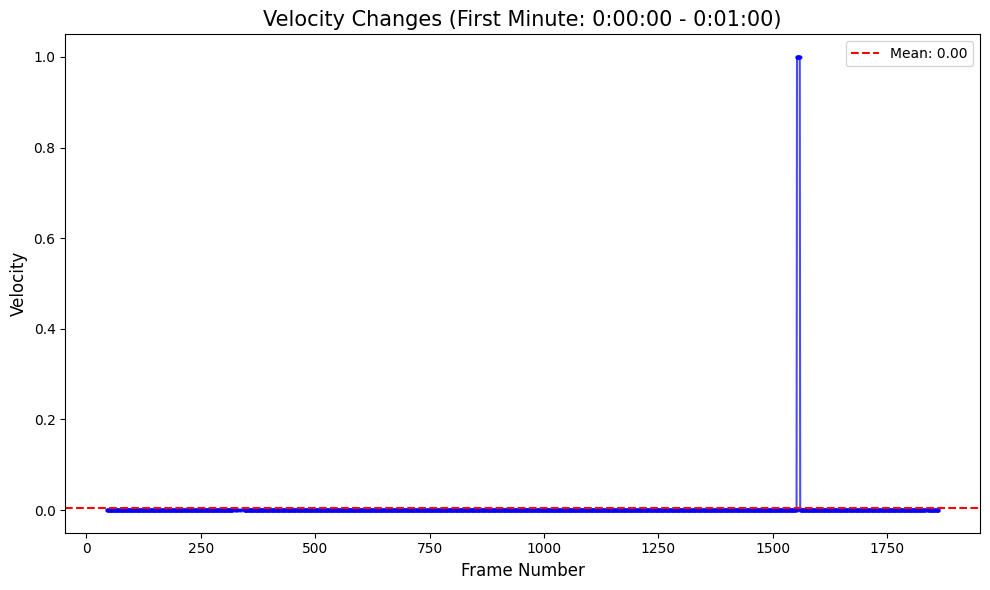

In [ ]:
filtered_df = df[(df['timestamp'] >= '0:00:00') & (df['timestamp'] <= '0:01:00')]

plt.figure(figsize=(10, 6))

plt.plot(filtered_df['velocity'], marker='o', markersize=2, linestyle='-', color='blue', alpha=0.7)

# horizontal line at the mean velocity for reference
mean_velocity = filtered_df['velocity'].mean()
plt.axhline(y=mean_velocity, color='r', linestyle='--',
            label=f'Mean: {mean_velocity:.2f}')

plt.title('Velocity Changes (First Minute: 0:00:00 - 0:01:00)', fontsize=15)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.legend()

plt.tight_layout()

plt.show()

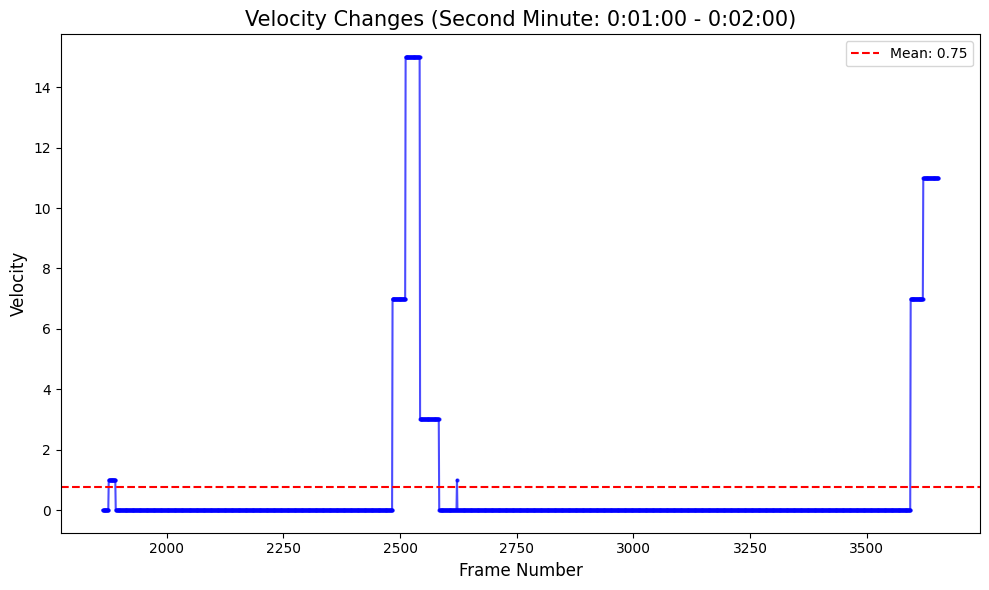

In [ ]:
filtered_df = df[(df['timestamp'] > '0:01:00') & (df['timestamp'] <= '0:02:00')]

plt.figure(figsize=(10, 6))

plt.plot(filtered_df['velocity'], marker='o', markersize=2, linestyle='-', color='blue', alpha=0.7)

# horizontal line at the mean velocity for reference
mean_velocity = filtered_df['velocity'].mean()
plt.axhline(y=mean_velocity, color='r', linestyle='--',
            label=f'Mean: {mean_velocity:.2f}')

plt.title('Velocity Changes (Second Minute: 0:01:00 - 0:02:00)', fontsize=15)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.legend()

plt.tight_layout()

plt.show()

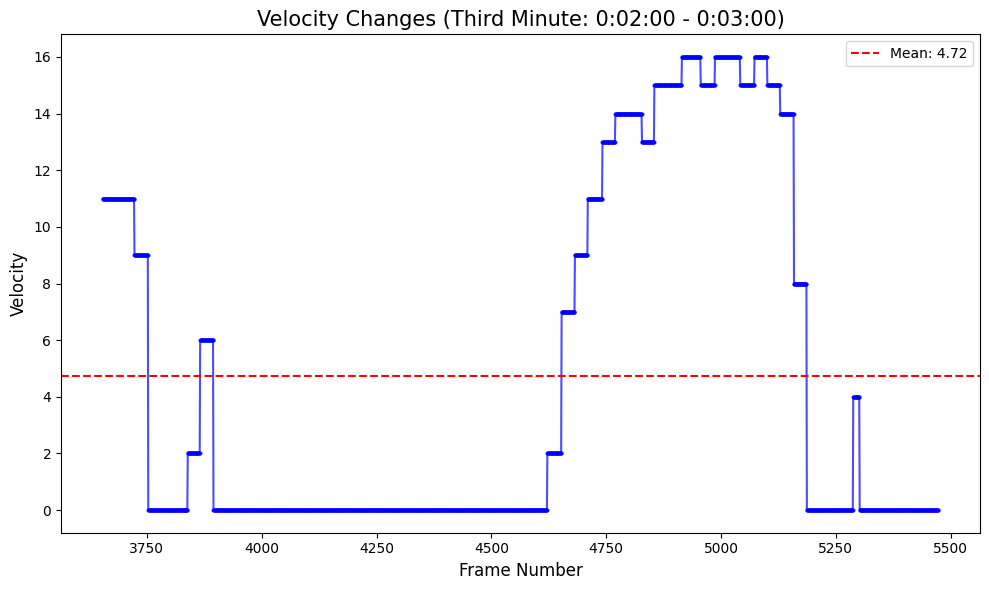

In [ ]:
filtered_df = df[(df['timestamp'] > '0:02:00') & (df['timestamp'] <= '0:03:00')]

plt.figure(figsize=(10, 6))

plt.plot(filtered_df['velocity'], marker='o', markersize=2, linestyle='-', color='blue', alpha=0.7)

# horizontal line at the mean velocity for reference
mean_velocity = filtered_df['velocity'].mean()
plt.axhline(y=mean_velocity, color='r', linestyle='--',
            label=f'Mean: {mean_velocity:.2f}')

plt.title('Velocity Changes (Third Minute: 0:02:00 - 0:03:00)', fontsize=15)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('Velocity', fontsize=12)
plt.legend()

plt.tight_layout()

plt.show()

### LZ1 plots by minutes

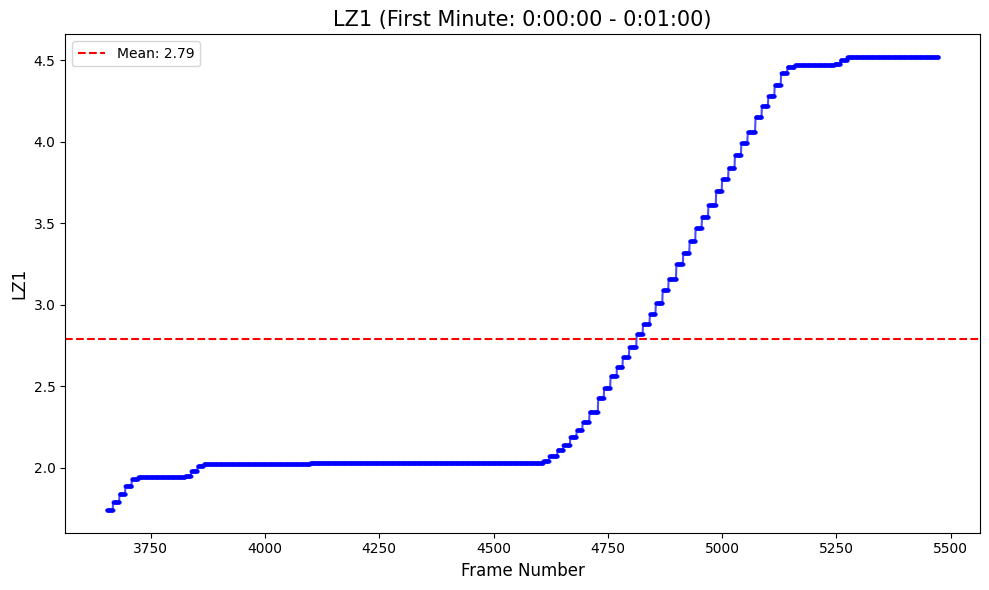

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_df['LZ1'], marker='o', markersize=2, linestyle='-', color='blue', alpha=0.7)

mean_lz1 = filtered_df['LZ1'].mean()
plt.axhline(y=mean_lz1, color='r', linestyle='--',
            label=f'Mean: {mean_lz1:.2f}')

plt.title('LZ1 (First Minute: 0:00:00 - 0:01:00)', fontsize=15)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('LZ1', fontsize=12)
plt.legend()

plt.tight_layout()

plt.show()

## ROIs debuggings

In [ ]:
# def visualize_roi(video_path, frame_number=0):
#     cap = cv2.VideoCapture(video_path)
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
#     ret, frame = cap.read()

#     if not ret:
#         print("Could not read frame")
#         return

#     # define ROIs
#     roi_timestamp = (7, 890, 185, 65)
#     roi_fz = (490, 966, 175, 60)
#     roi_lz1 = (790, 962, 290, 60)
#     roi_velocity = (1610, 865, 185, 65)

#     # rectangles around ROIs
#     cv2.rectangle(frame, (roi_timestamp[0], roi_timestamp[1]),
#                  (roi_timestamp[0]+roi_timestamp[2], roi_timestamp[1]+roi_timestamp[3]), (0,255,0), 2)
#     cv2.rectangle(frame, (roi_fz[0], roi_fz[1]),
#                  (roi_fz[0]+roi_fz[2], roi_fz[1]+roi_fz[3]), (0,255,0), 2)
#     cv2.rectangle(frame, (roi_lz1[0], roi_lz1[1]),
#                  (roi_lz1[0]+roi_lz1[2], roi_lz1[1]+roi_lz1[3]), (0,255,0), 2)
#     cv2.rectangle(frame, (roi_velocity[0], roi_velocity[1]),
#                  (roi_velocity[0]+roi_velocity[2], roi_velocity[1]+roi_velocity[3]), (0,255,0), 2)

#     from google.colab.patches import cv2_imshow
#     cv2_imshow(frame)

#     # save images
#     roi_images = {
#         "timestamp": frame[roi_timestamp[1]:roi_timestamp[1]+roi_timestamp[3],
#                           roi_timestamp[0]:roi_timestamp[0]+roi_timestamp[2]],
#         "fz": frame[roi_fz[1]:roi_fz[1]+roi_fz[3], roi_fz[0]:roi_fz[0]+roi_fz[2]],
#         "lz1": frame[roi_lz1[1]:roi_lz1[1]+roi_lz1[3], roi_lz1[0]:roi_lz1[0]+roi_lz1[2]],
#         "velocity": frame[roi_velocity[1]:roi_velocity[1]+roi_velocity[3],
#                          roi_velocity[0]:roi_velocity[0]+roi_velocity[2]]
#     }

#     for name, img in roi_images.items():
#         print(f"ROI: {name}")
#         cv2_imshow(img)

#     cap.release()

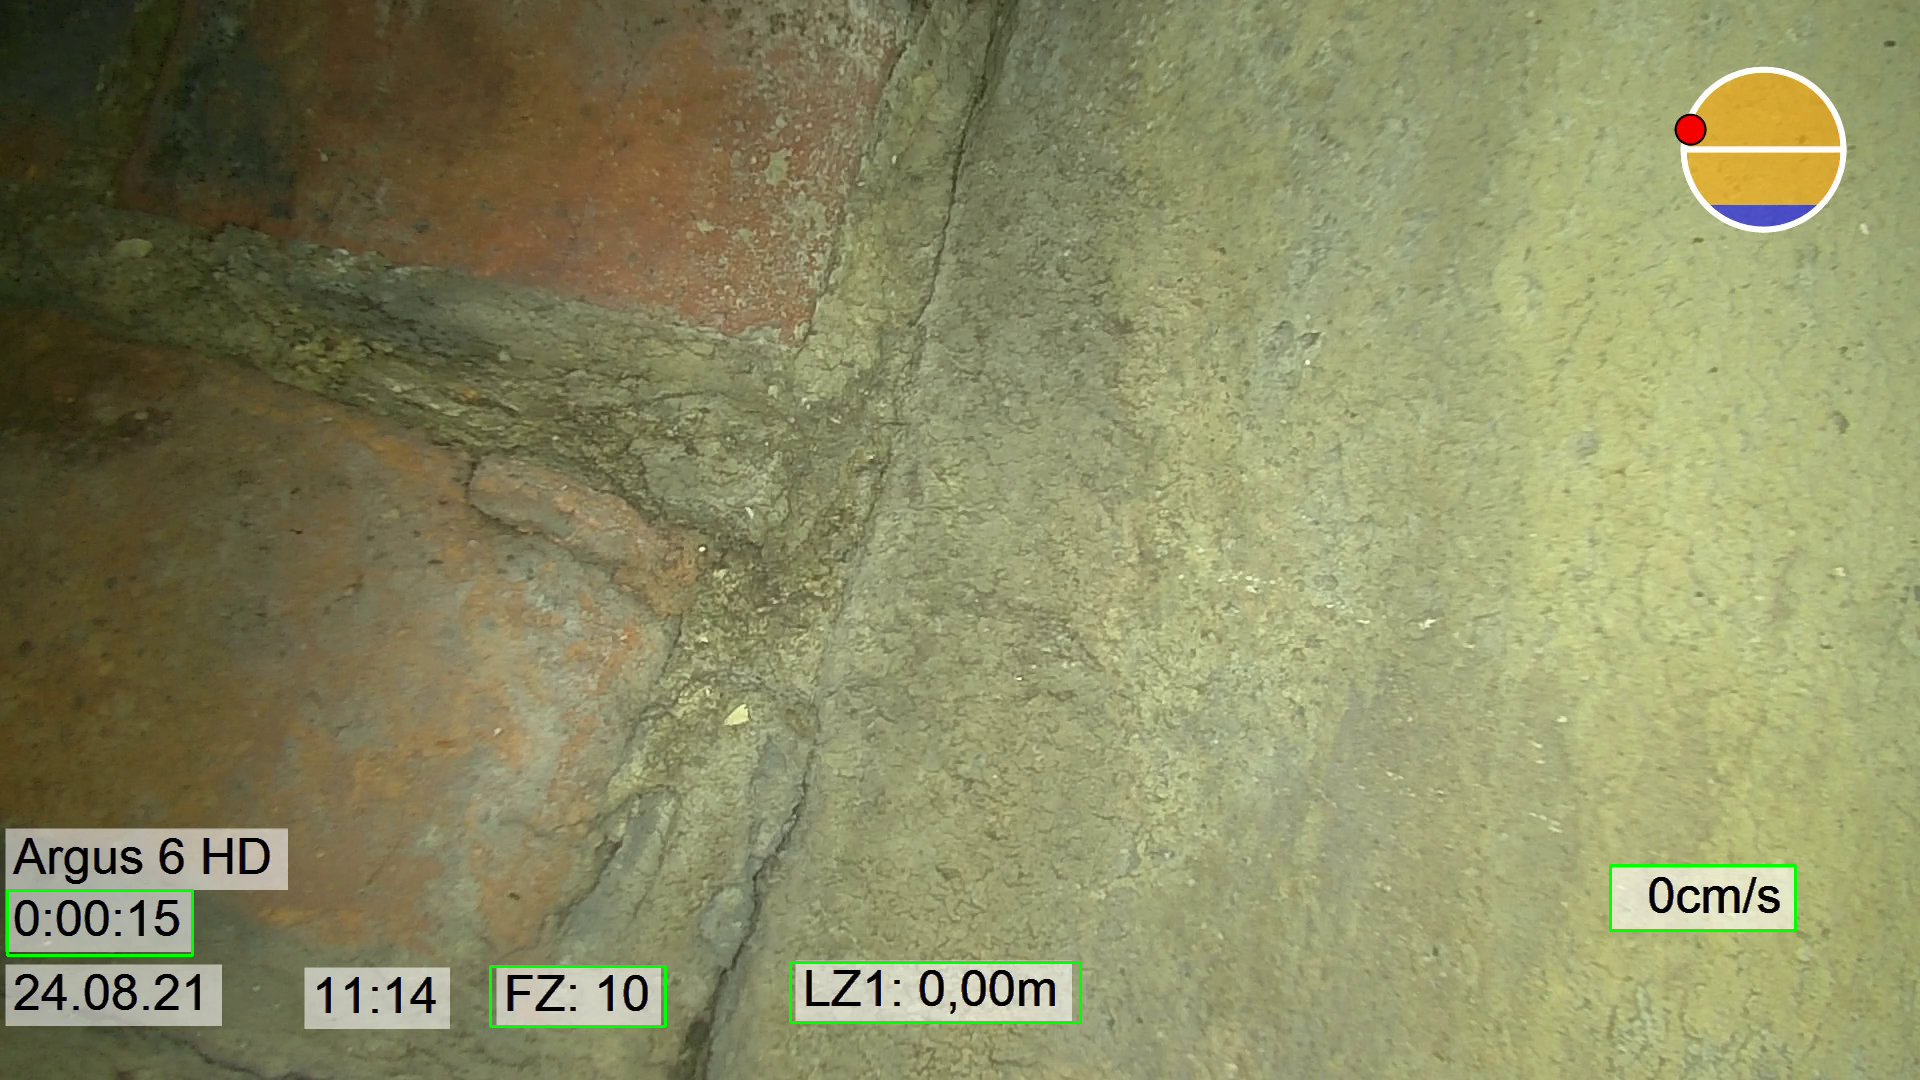

ROI: timestamp


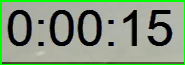

ROI: fz


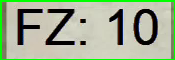

ROI: lz1


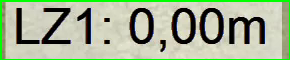

ROI: velocity


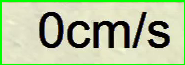

In [ ]:
# # visualize_roi(video_path, frame_number=0)
# visualize_roi(video_path, frame_number=500)  # frame in the middle

## Brightness & Sharpness

### Analysis

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
use_gpu

True

In [ ]:
sampling_rate = 1  # choose every nth frame

In [ ]:
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")
    exit()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

frame_numbers = []
mean_brightness = []
perceived_luminance = []
laplacian_var = []

print("Analyzing video...")
for frame_idx in tqdm(range(0, frame_count, sampling_rate)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    lap_var = np.var(laplacian)

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if use_gpu:
        frame_tensor = torch.from_numpy(rgb_frame).cuda().float() / 255.0  #  to CUDA tensor

        simple_mean = float(torch.mean(frame_tensor).cpu().numpy() * 255.0)

        r, g, b = frame_tensor[:, :, 0], frame_tensor[:, :, 1], frame_tensor[:, :, 2]
        luminance_tensor = 0.2126*r + 0.7152*g + 0.0722*b
        perc_luminance = float(torch.mean(luminance_tensor).cpu().numpy() * 255.0)

        torch.cuda.empty_cache()
    else:
        # CPU processing
        # average RGB
        simple_mean = np.mean(rgb_frame)

        # weighted RGB
        r, g, b = rgb_frame[:,:,0], rgb_frame[:,:,1], rgb_frame[:,:,2]
        luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
        perc_luminance = np.mean(luminance)

    frame_numbers.append(frame_idx)
    mean_brightness.append(simple_mean)
    perceived_luminance.append(perc_luminance)
    laplacian_var.append(lap_var)

cap.release()

Analyzing video...


100%|██████████| 25513/25513 [1:28:57<00:00,  4.78it/s]


In [ ]:
time_in_seconds = [frame/fps for frame in frame_numbers]

In [ ]:
# normalize sharpness values for better plotting
max_sharpness = max(laplacian_var)
normalized_sharpness = [val / max_sharpness * 255 for val in laplacian_var]

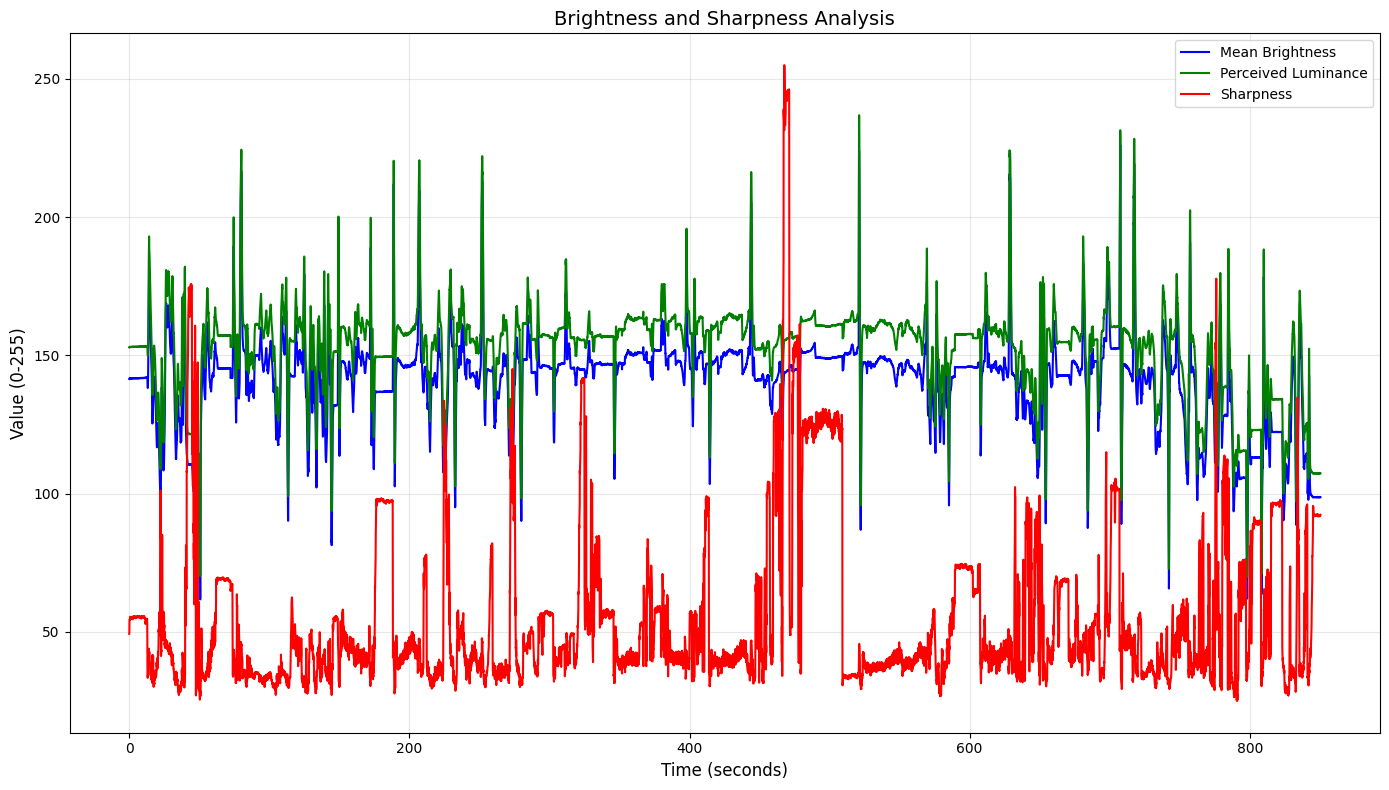

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(time_in_seconds, mean_brightness, 'b-', linewidth=1.5, label='Mean Brightness')
plt.plot(time_in_seconds, perceived_luminance, 'g-', linewidth=1.5, label='Perceived Luminance')
plt.plot(time_in_seconds, normalized_sharpness, 'r-', linewidth=1.5, label='Sharpness')

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Value (0-255)', fontsize=12)
plt.title('Brightness and Sharpness Analysis', fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

The spikes in *brightness* & *sharpness* produce different patterns in the video. Thus, they need to be used as a combination to extract various patterns or situations from the video.

***Perceived Luminance***: [link](https://en.wikipedia.org/wiki/Relative_luminance)

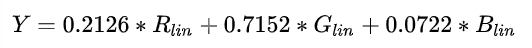

***Laplacian***: [link1](https://medium.com/@sagardhungel/laplacian-and-its-use-in-blur-detection-fbac689f0f88) + [link2](https://en.wikipedia.org/wiki/Laplace_operator)

Store the values to the dataframe:

In [ ]:
brightness_sharpness_data = {
    'frame_number': frame_numbers,
    'time_seconds': time_in_seconds,
    'mean_brightness': mean_brightness,
    'perceived_luminance': perceived_luminance,
    'sharpness': laplacian_var,
    'normalized_sharpness': normalized_sharpness
}

brightness_sharpness_df = pd.DataFrame(brightness_sharpness_data)

In [ ]:
brightness_sharpness_df.tail()

frame_number  time_seconds  mean_brightness  perceived_luminance  \
25508         25508    850.266667        98.671913           107.288628   
25509         25509    850.300000        98.674538           107.290070   
25510         25510    850.333333        98.668968           107.285568   
25511         25511    850.366667        98.665009           107.283203   
25512         25512    850.400000        98.670860           107.287758   

        sharpness  normalized_sharpness  
25508  553.718656             92.237613  
25509  553.845492             92.258741  
25510  553.962210             92.278184  
25511  554.170652             92.312906  
25512  554.333403             92.340017

In [ ]:
brightness_sharpness_df.to_csv("brightness_sharpness.csv", index=False)